In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import math
import datetime
import pylab as pl
from IPython import display
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

%matplotlib inline

Using TensorFlow backend.


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15746910785972026511
]


In [2]:
# constans
frequency = '4H'
split = 0.99
look_back = 7
look_forward = 7

In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_forward+1): 
        dataX.append(dataset[i:(i+look_back), :])
        dataY.append(dataset[(i+look_back):(i+look_back+look_forward), 0])
    return np.array(dataX), np.array(dataY)

In [4]:
# fix random seed for reproducibility
np.random.seed(7)

In [5]:
# load data
df_trend = pd.read_csv('trends.csv', index_col=0, header=0, skiprows=2, engine='python')
df_trend.columns = ['trend']
df_trend.index = pd.to_datetime(df_trend.index, format='%Y-%m-%d')
print(df_trend.tail(5))

df = pd.read_csv('trades.csv', index_col=0, usecols=['timestamp','price','volume', 'buysell'], header=0, engine='python')
df.index = pd.to_datetime(df.index, unit='s')
print(df.tail(5))

            trend
Week             
2017-10-01     47
2017-10-08     71
2017-10-15     75
2017-10-22     78
2017-10-29    100
                              volume   price buysell
timestamp                                           
2017-11-15 11:10:31.336200  0.002887  6977.0       b
2017-11-15 11:10:31.344800  0.500000  6977.0       b
2017-11-15 11:10:43.998100  0.282272  6976.9       s
2017-11-15 11:10:50.090800  0.064779  6976.9       s
2017-11-15 11:10:56.524000  0.003190  6977.0       b


                              volume   price buysell         b         s
timestamp                                                               
2017-11-15 11:09:33.860800  0.066673  6972.0       s  0.000000  0.066673
2017-11-15 11:09:33.896800  0.003092  6972.0       s  0.000000  0.003092
2017-11-15 11:09:38.942100  0.003105  6972.0       s  0.000000  0.003105
2017-11-15 11:09:45.015500  0.020985  6972.0       s  0.000000  0.020985
2017-11-15 11:09:45.033000  0.179015  6972.0       s  0.000000  0.179015
2017-11-15 11:09:58.021900  0.003096  6972.0       s  0.000000  0.003096
2017-11-15 11:09:58.047500  0.500000  6977.0       b  0.500000  0.000000
2017-11-15 11:10:09.356400  0.050000  6977.0       b  0.050000  0.000000
2017-11-15 11:10:20.150600  0.200000  6977.0       b  0.200000  0.000000
2017-11-15 11:10:31.140100  0.009000  6977.0       b  0.009000  0.000000
2017-11-15 11:10:31.336200  0.002887  6977.0       b  0.002887  0.000000
2017-11-15 11:10:31.344800  0.500000  6977.0       

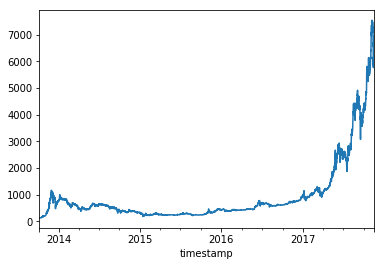

In [6]:
# resample and extract features
one_hot = pd.get_dummies(df['buysell'])
# df = df.drop('buysell', axis=1)
df = df.join(one_hot)
df['b'] = df['b']*df['volume']
df['s'] = df['s']*df['volume']


print(df.tail(15))

df_pv = df.resample(frequency).agg({'price': np.mean, 'volume': np.sum, 'b': np.sum, 's': np.sum})
df_ohlc = df['price'].resample(frequency).ohlc()
df_trend = df_trend.resample(frequency).mean()

df = pd.concat([df_pv, df_ohlc], axis=1)
df = pd.concat([df, df_trend], axis=1)
df = df.fillna(method='pad')
df['hour'] = [d.hour for d in df.index.time]
df['minute'] = [d.minute for d in df.index.time]
df = df.dropna()

# x = np.empty([1, len(df.columns)]).fill(0.0)
# s = pd.Series(x, index=df.columns)
# for i in range(look_forward-1):
#     s.name = df.index[-1] + datetime.timedelta(hours = 2)
#     df = df.append(s)
#     df.iloc[-1] = 1.0

# df = df.append(df.iloc[-look_forward:])
print(df.tail(10))

df['price'].plot()

Data has got  11.000000eatures
(9004, 11)
(9004, 11)


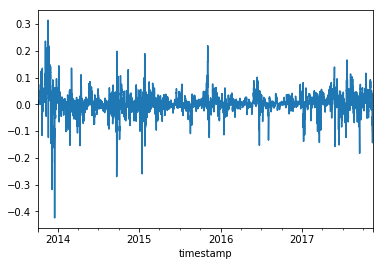

In [7]:
# preprocess: logarithm and ewma
df['price'] = np.log(df['price'])
df['volume'] = np.log(df['volume'])
df['open'] = np.log(df['open'])
df['high'] = np.log(df['high'])
df['low'] = np.log(df['low'])
df['close'] = np.log(df['close'])
ewma = df.ewm(halflife=7).mean()
df = df - ewma

df['price'].plot()

features = int(len(df.columns))
print('Data has got % features' % (features))


dataset = df.values
print(dataset.shape)
# dataset = np.concatenate((dataset,dataset[-look_forward:,:]))
print(dataset.shape)

In [8]:
# split into train and test sets
train_size = int(len(dataset) * split)
train, test = dataset[0:train_size+look_forward,:], dataset[train_size:len(dataset),:]

In [9]:
# scale data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_price.fit_transform(train[:,0].reshape(-1, 1))

scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [10]:
# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
nowX = testX[-look_forward:]

In [11]:
# create and load model
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, features), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, features), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, features), stateful=True))
model.add(Dense(look_forward))
try:
    model.load_weights("model_buysell.h5")
except:
    pass
model.compile(loss='mean_squared_error', optimizer='adam')

Epoch 1/1
 - 45s - loss: 0.0017
Train Score: 0.03011 RMSE
Test Score: 0.03527 RMSE
(9004, 11)
(9011, 11)


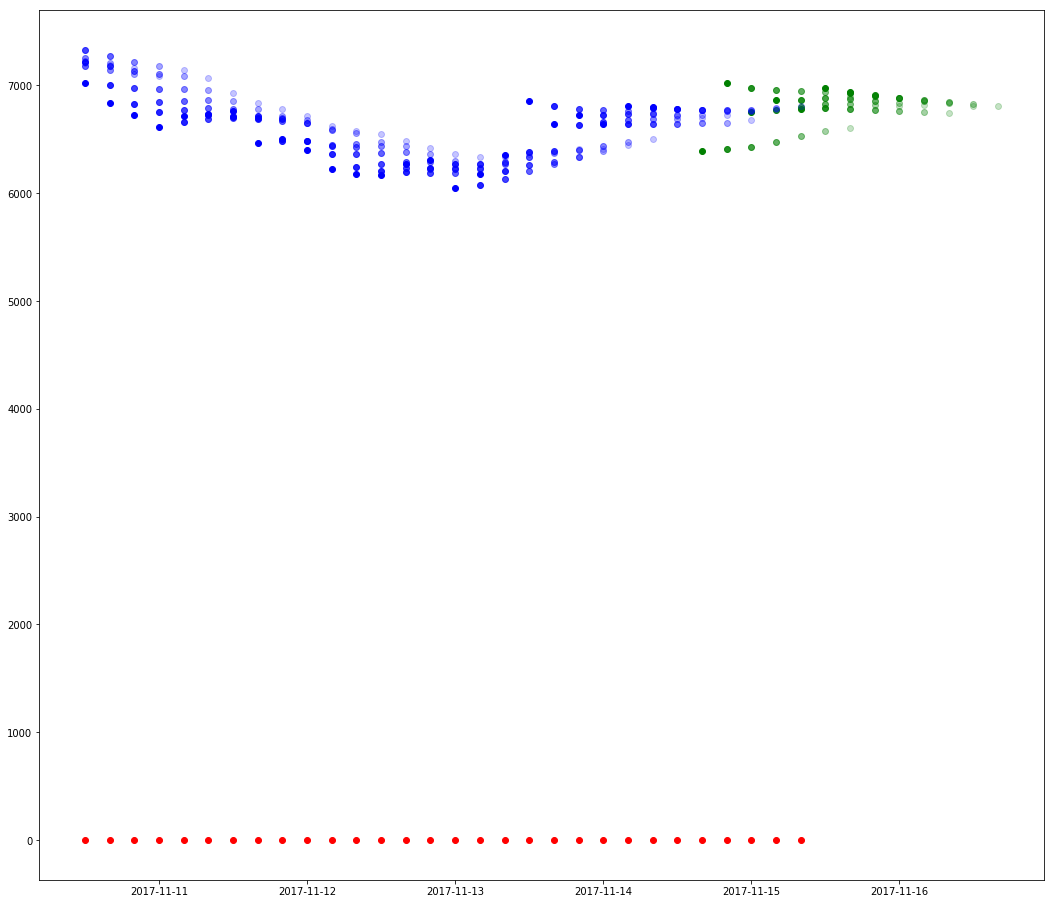

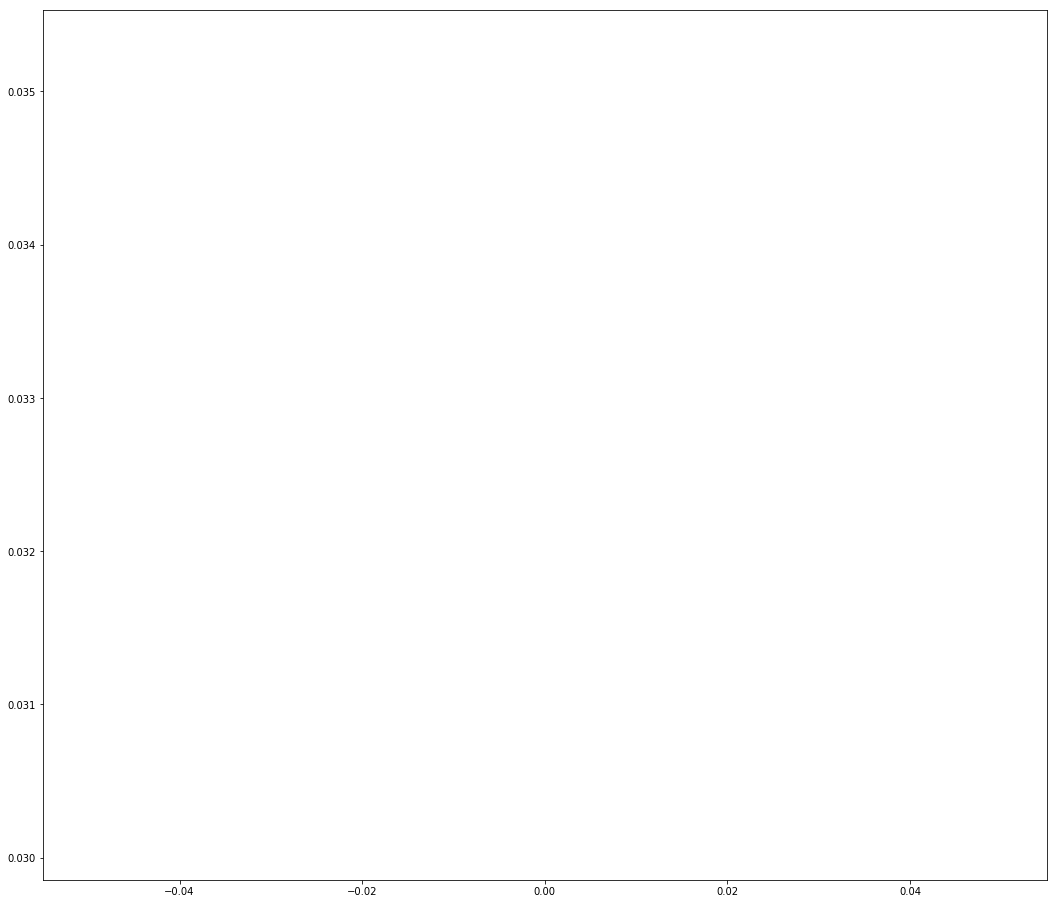

Epoch 1/1
 - 45s - loss: 0.0015
Train Score: 0.02985 RMSE
Test Score: 0.03521 RMSE
(9004, 11)
(9011, 11)


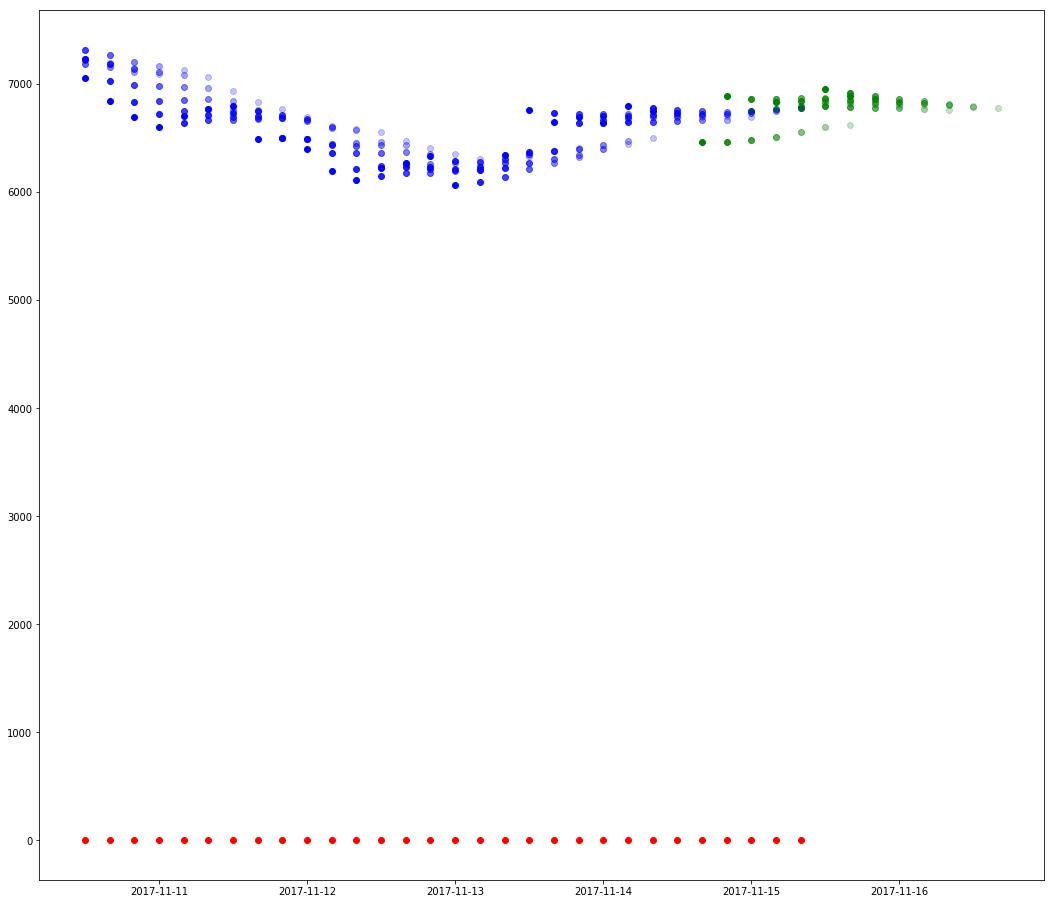

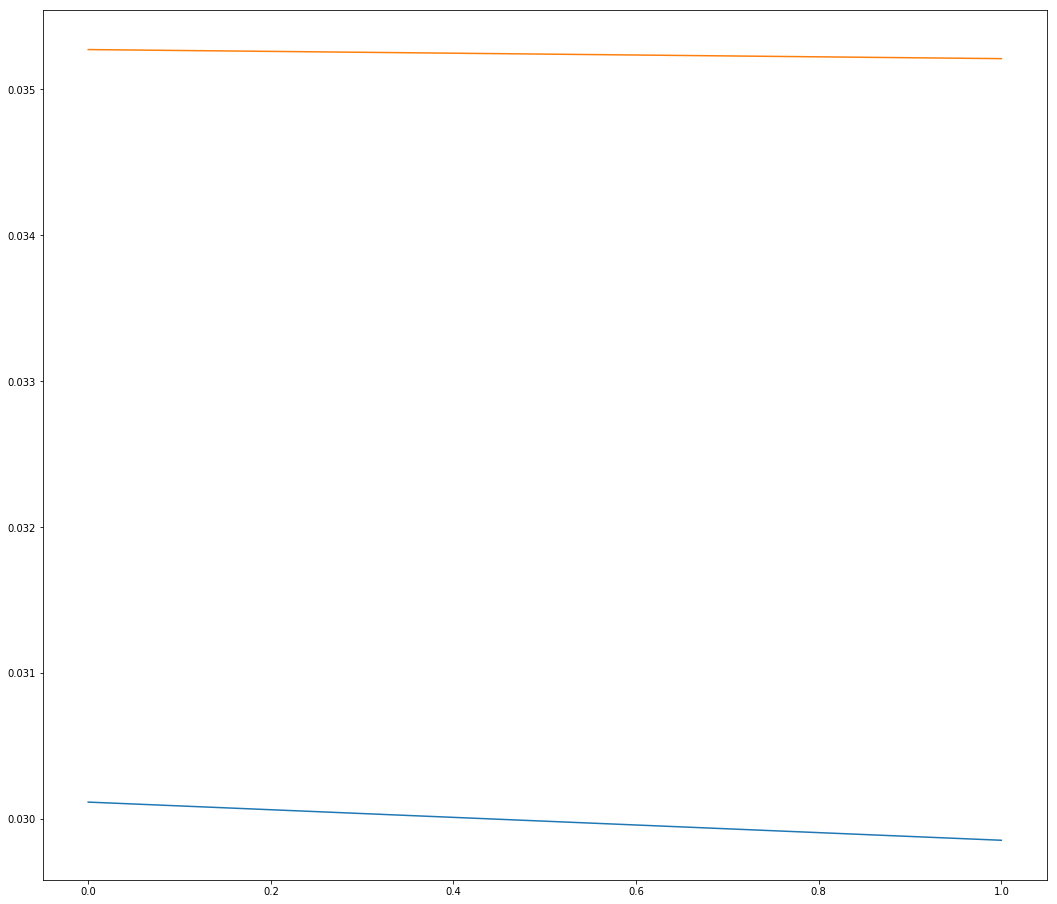

Epoch 1/1
 - 44s - loss: 0.0014
Train Score: 0.02979 RMSE
Test Score: 0.03564 RMSE
(9004, 11)
(9011, 11)


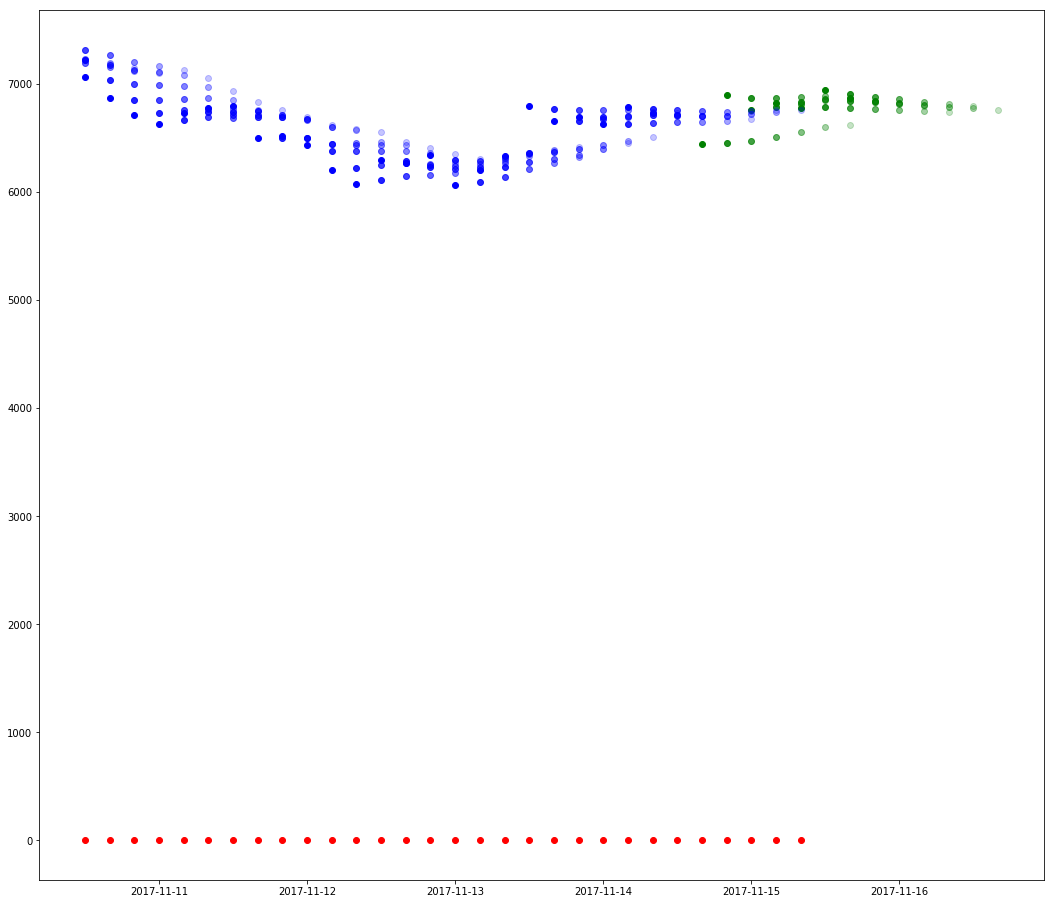

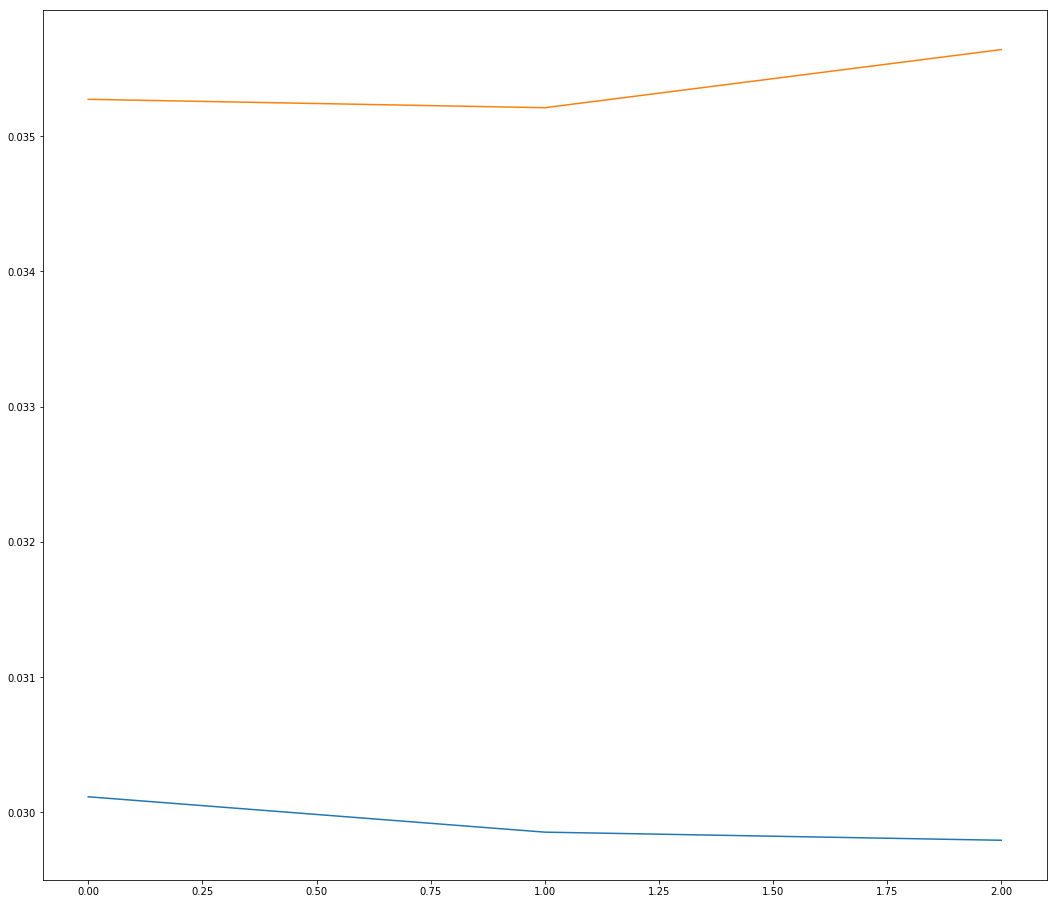

Epoch 1/1
 - 44s - loss: 0.0015
Train Score: 0.02966 RMSE
Test Score: 0.03535 RMSE
(9004, 11)
(9011, 11)


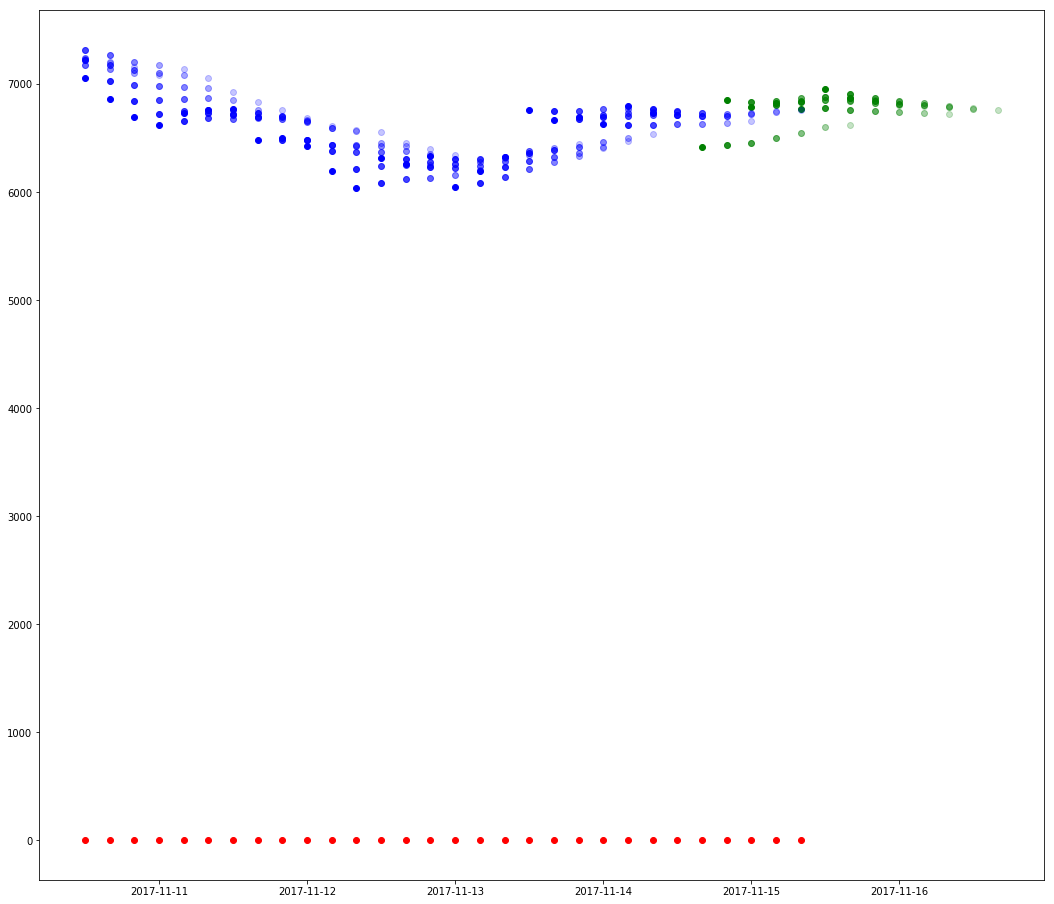

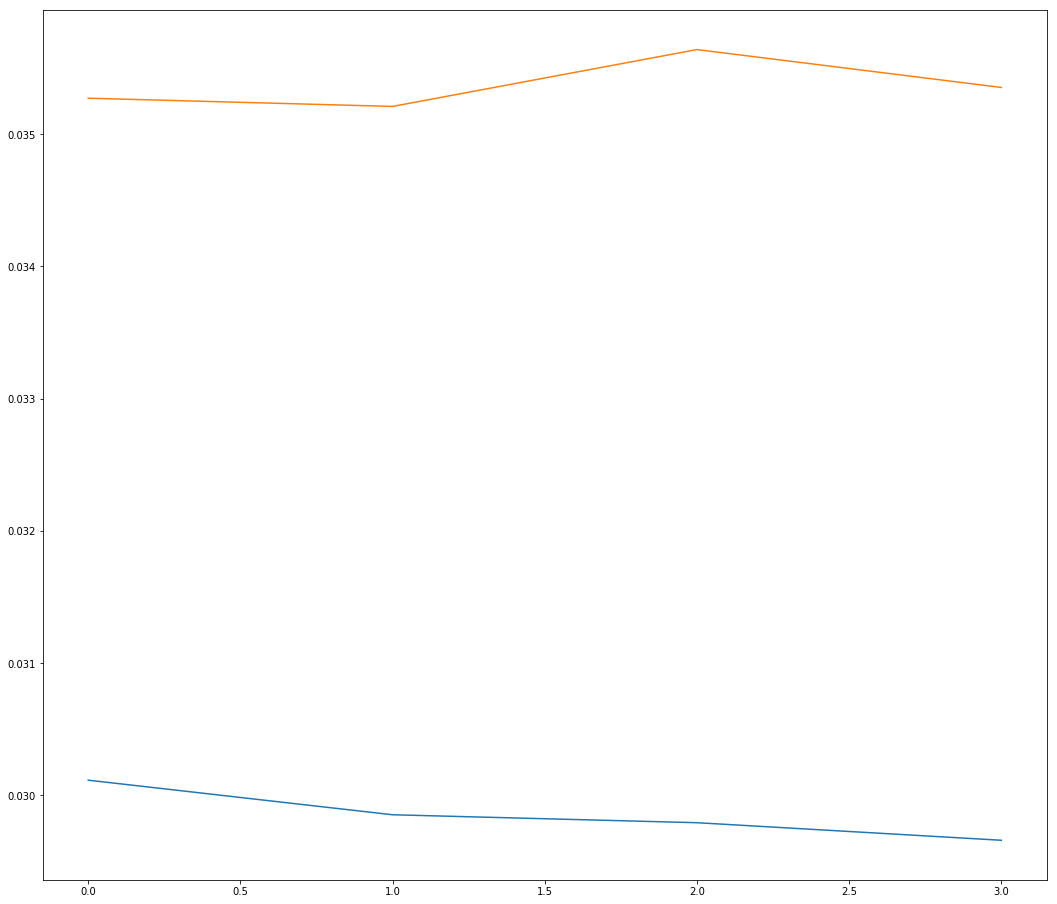

Epoch 1/1
 - 43s - loss: 0.0014
Train Score: 0.02955 RMSE
Test Score: 0.03521 RMSE
(9004, 11)
(9011, 11)


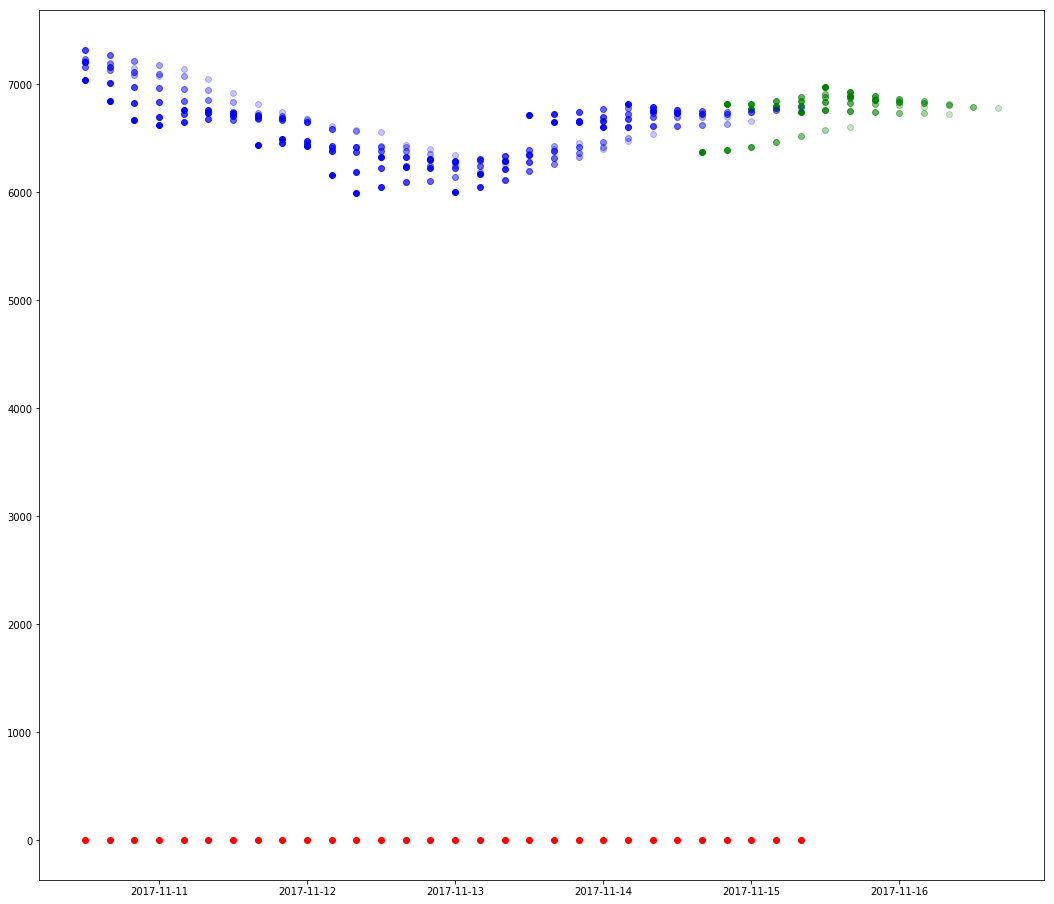

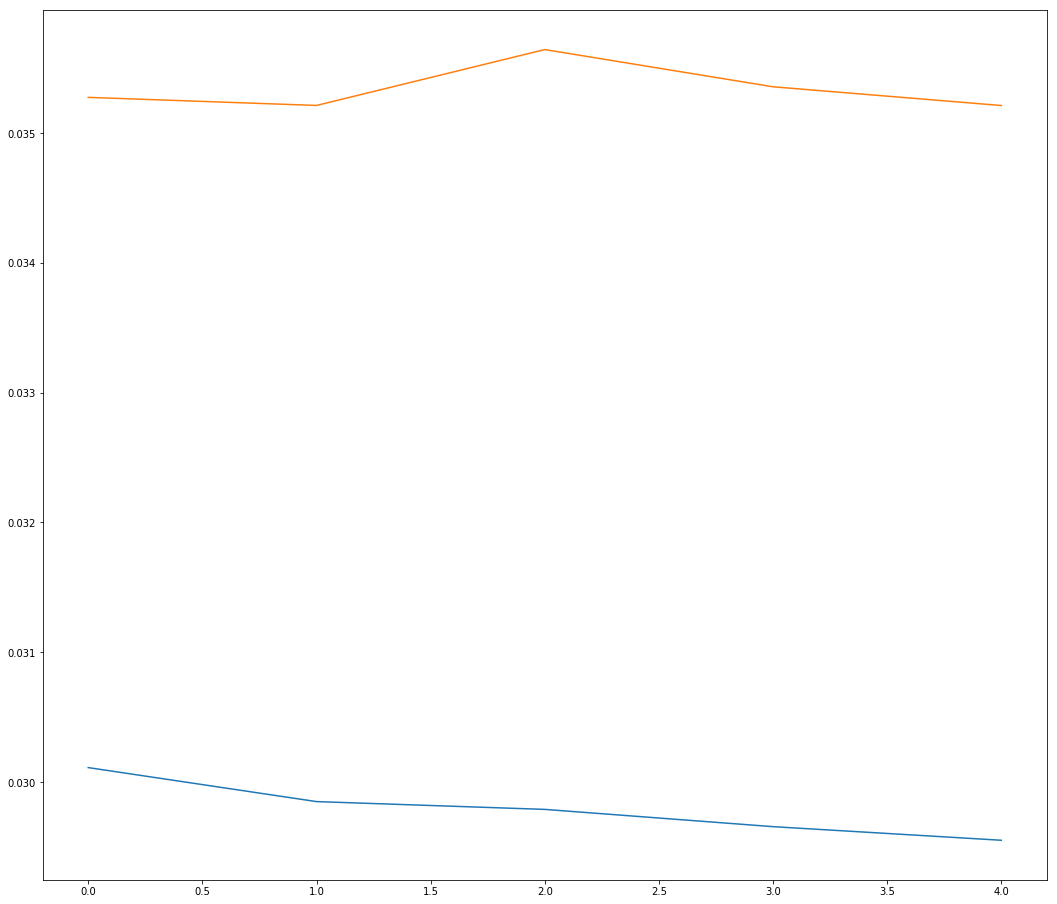

Epoch 1/1
 - 44s - loss: 0.0014
Train Score: 0.02950 RMSE
Test Score: 0.03514 RMSE
(9004, 11)
(9011, 11)


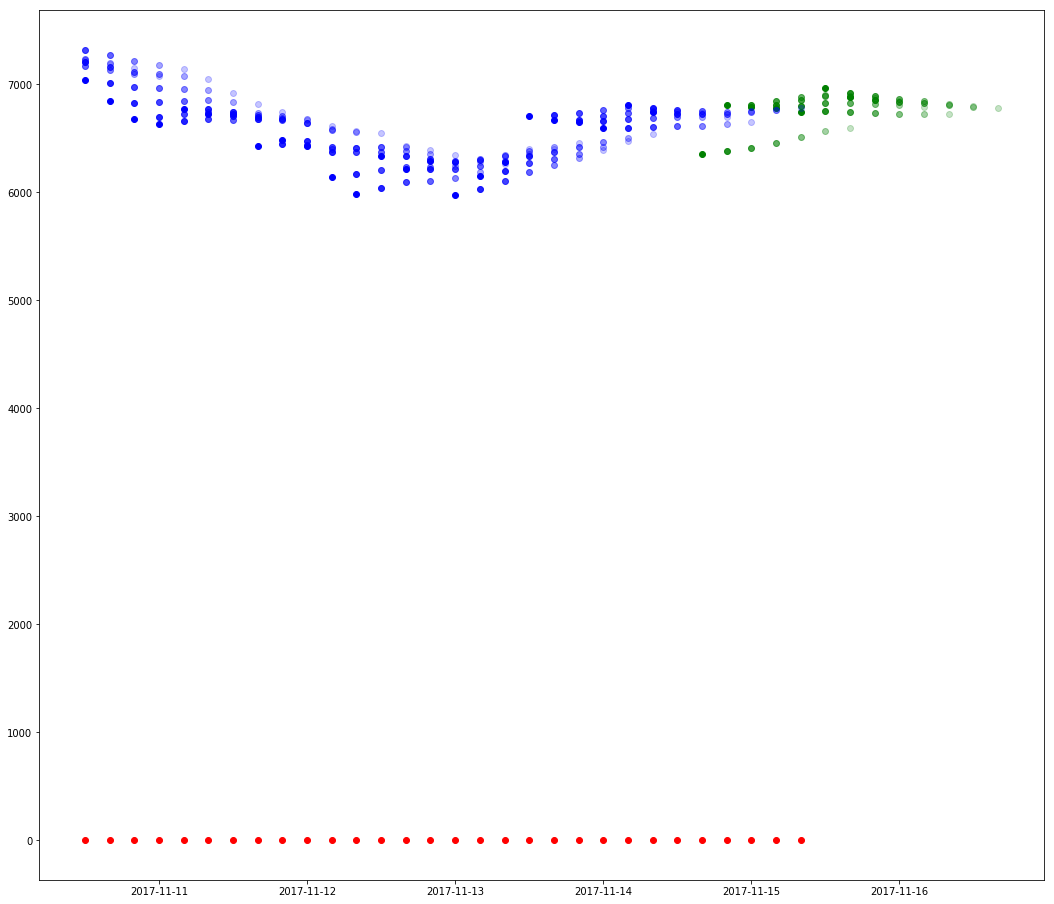

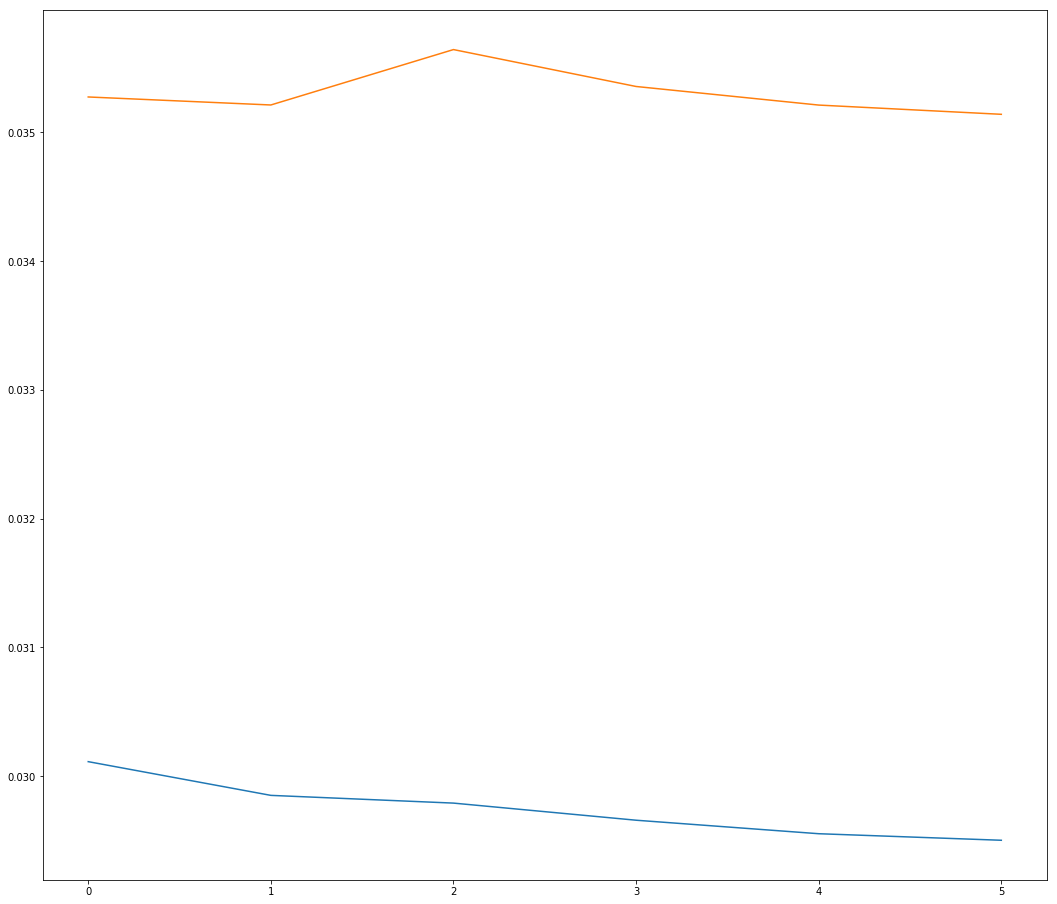

Epoch 1/1
 - 43s - loss: 0.0014
Train Score: 0.02949 RMSE
Test Score: 0.03512 RMSE
(9004, 11)
(9011, 11)


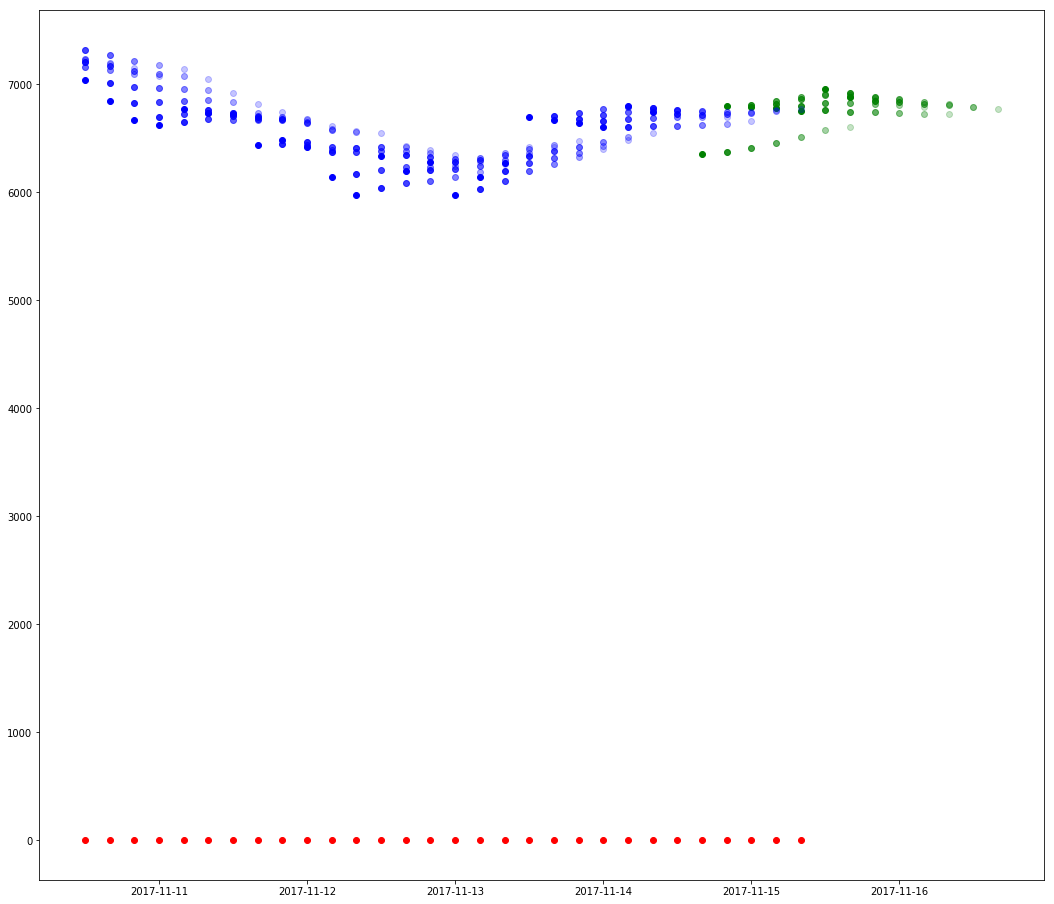

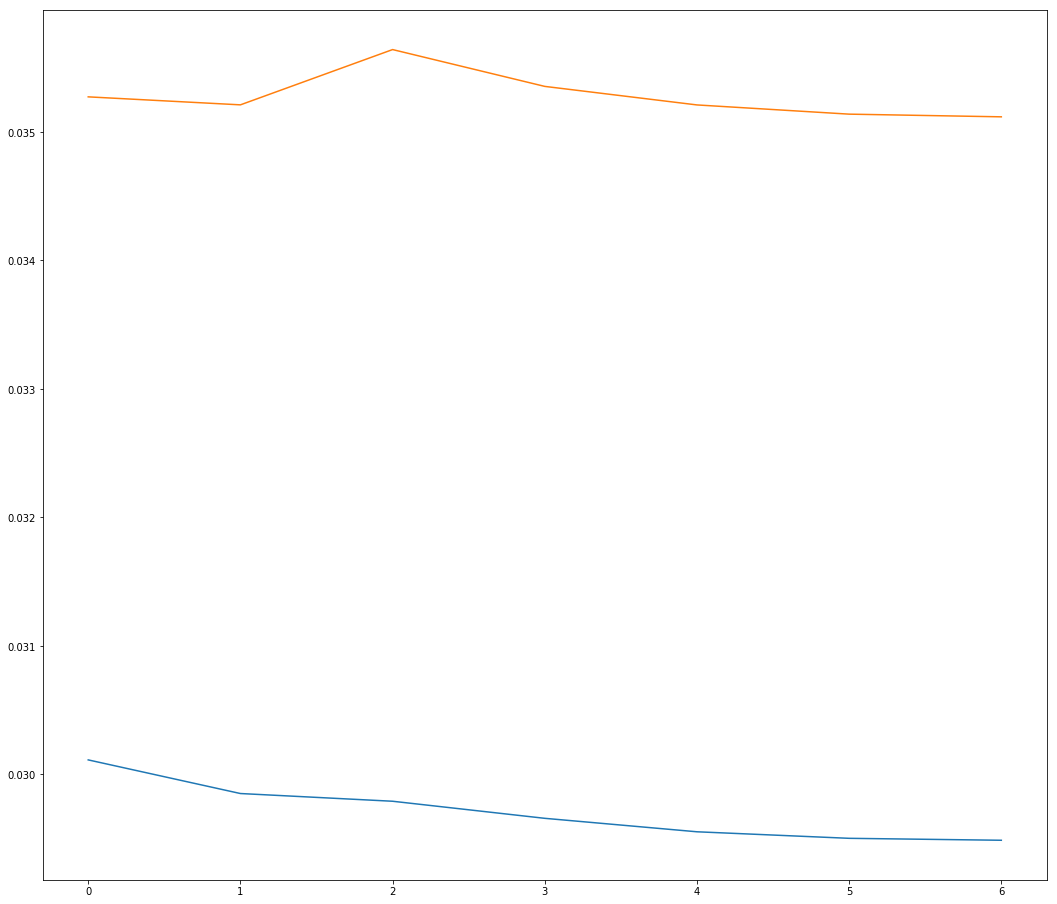

Epoch 1/1
 - 44s - loss: 0.0014
Train Score: 0.02949 RMSE
Test Score: 0.03512 RMSE
(9004, 11)
(9011, 11)


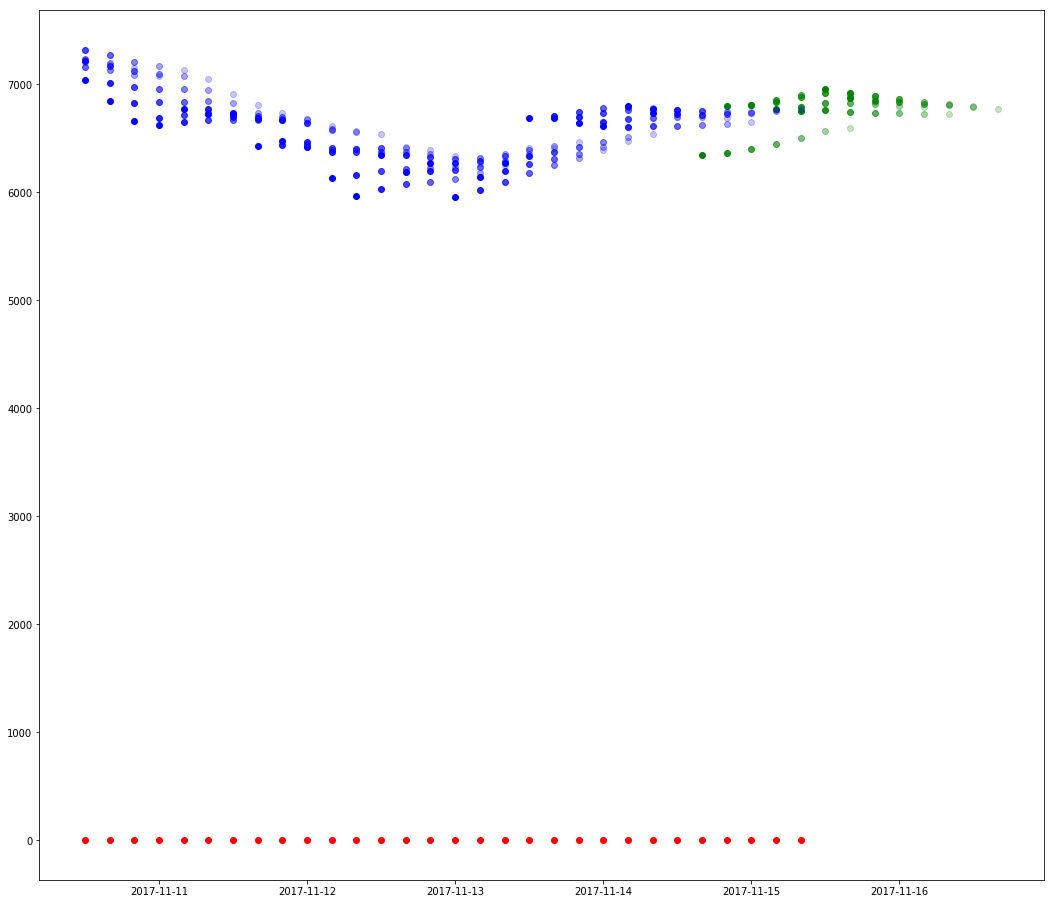

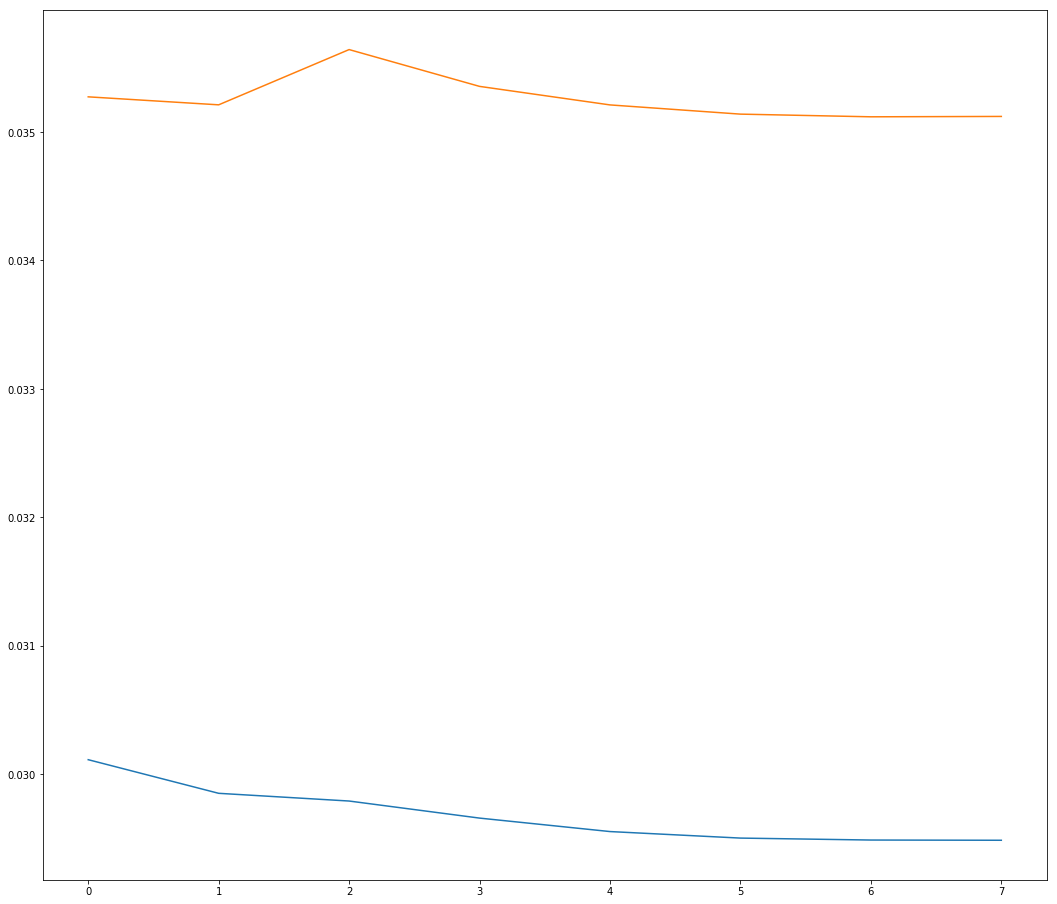

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02940 RMSE
Test Score: 0.03533 RMSE
(9004, 11)
(9011, 11)


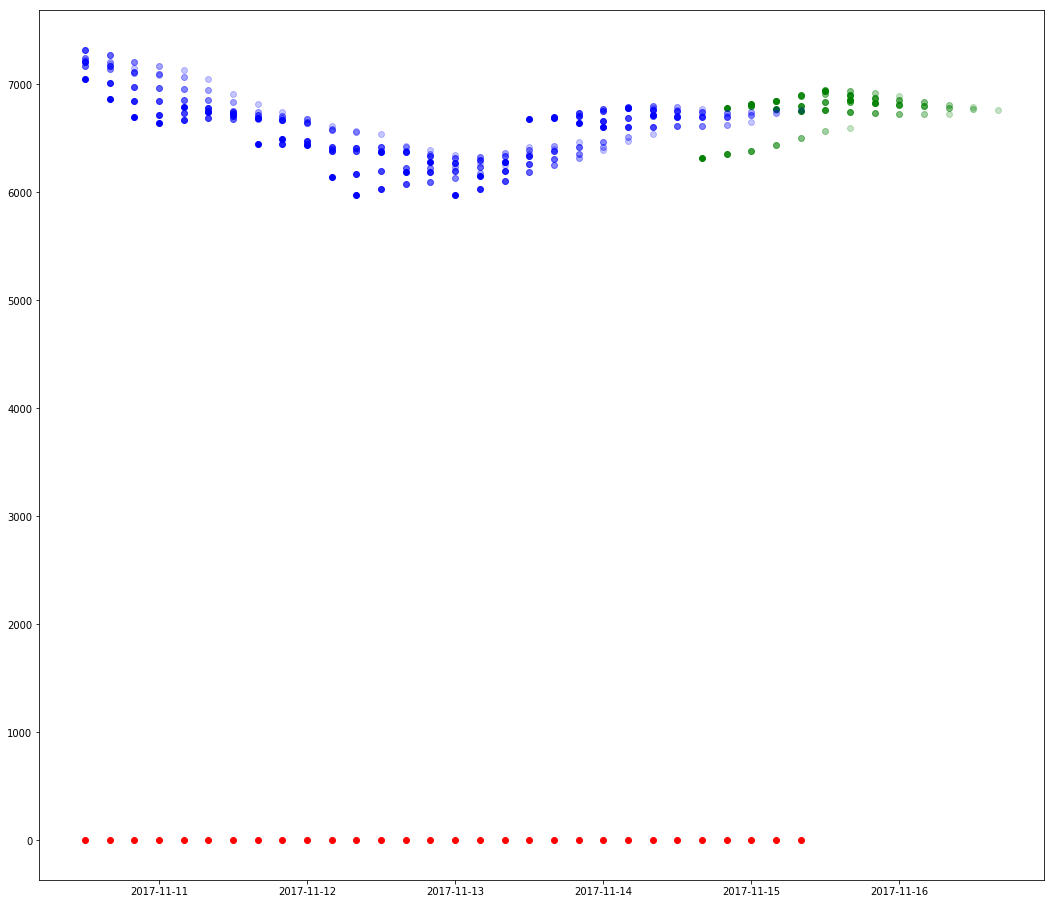

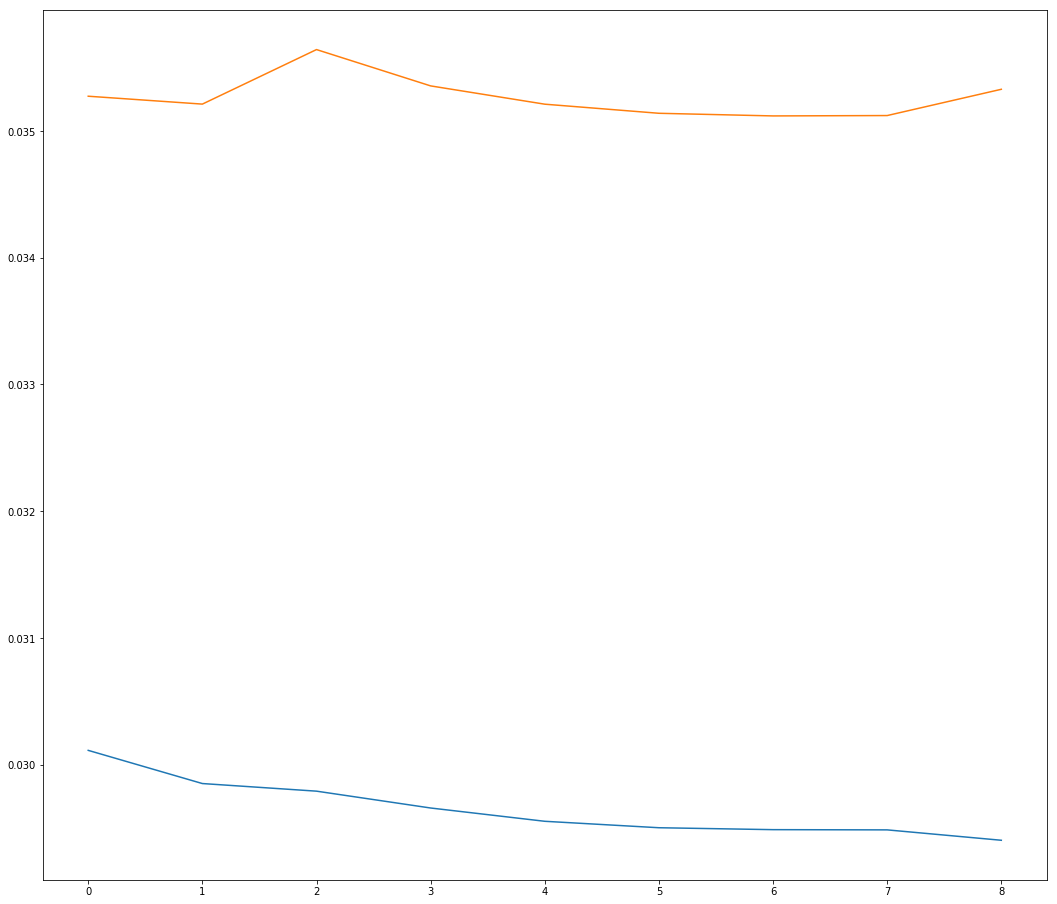

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02949 RMSE
Test Score: 0.03513 RMSE
(9004, 11)
(9011, 11)


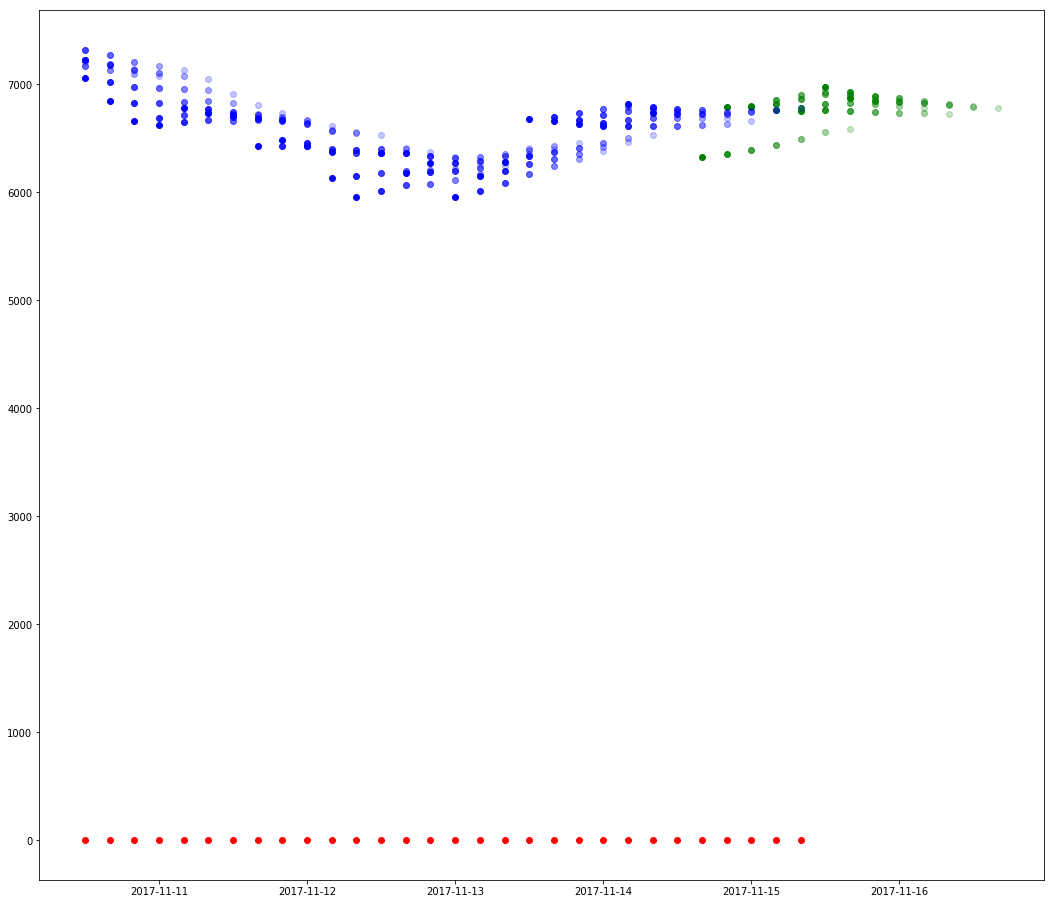

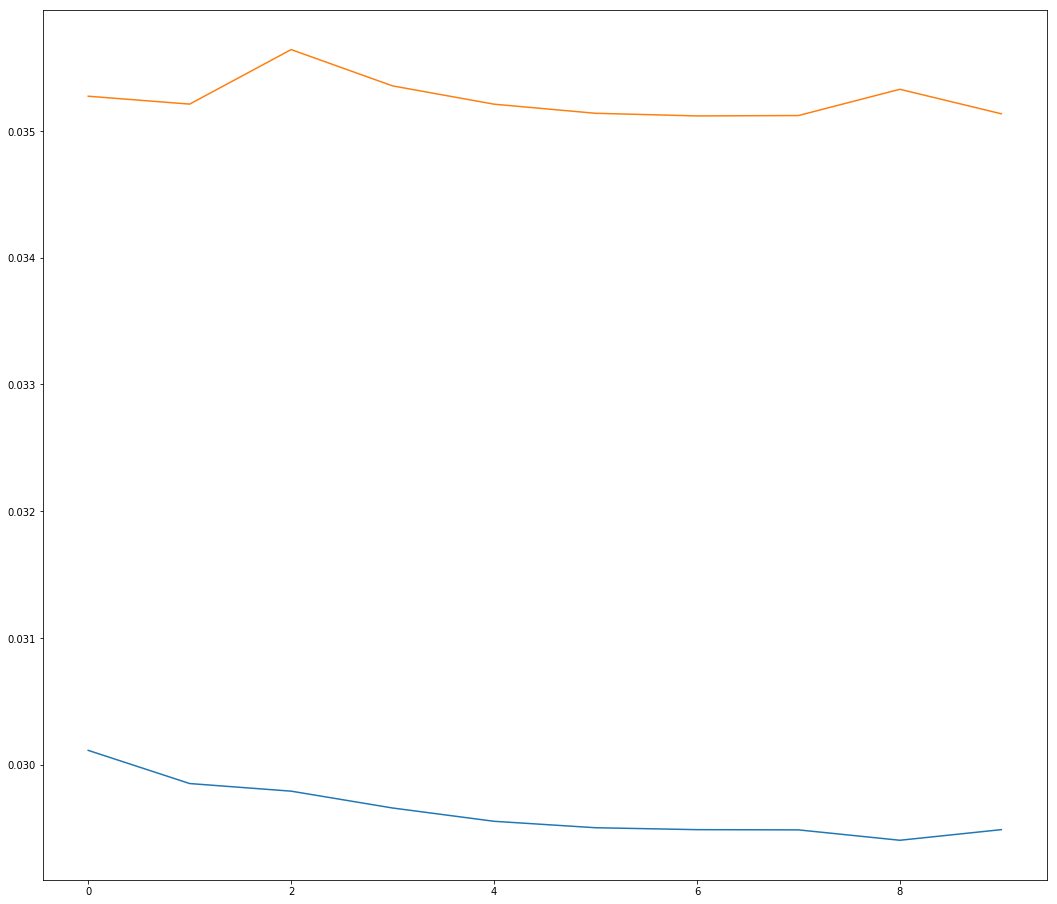

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02947 RMSE
Test Score: 0.03515 RMSE
(9004, 11)
(9011, 11)


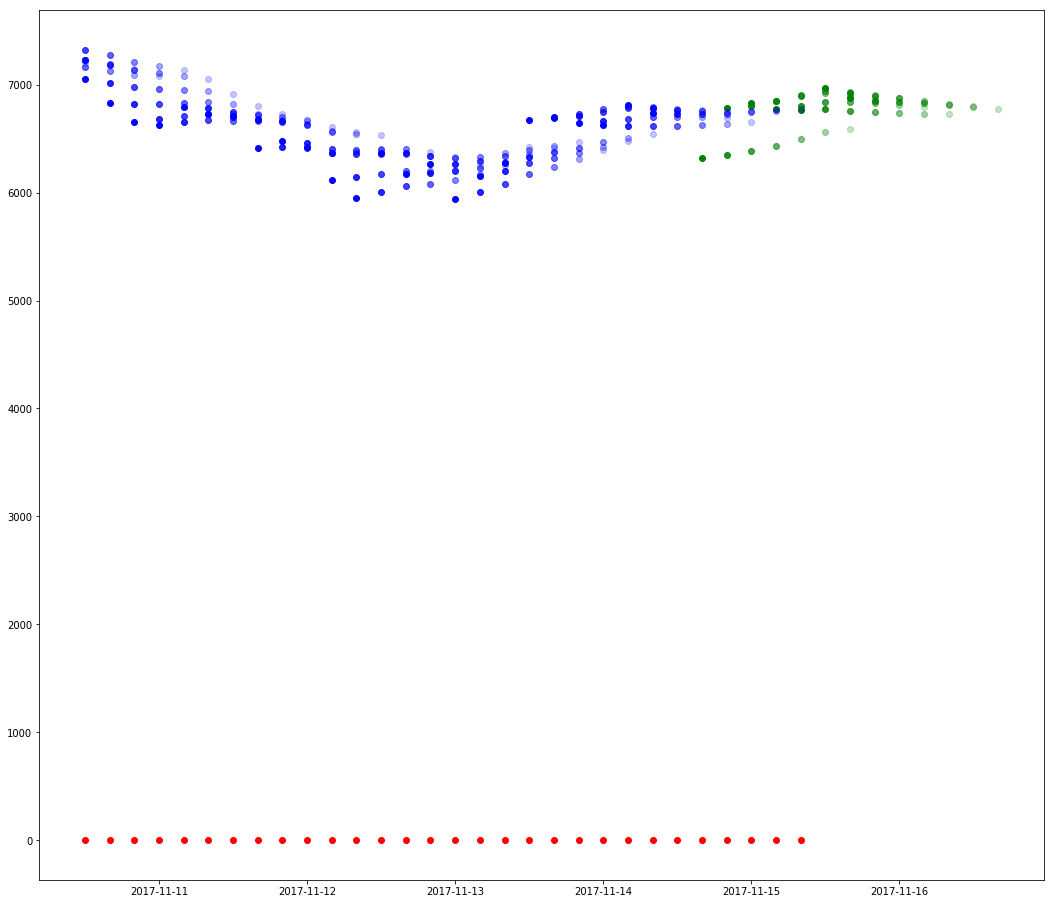

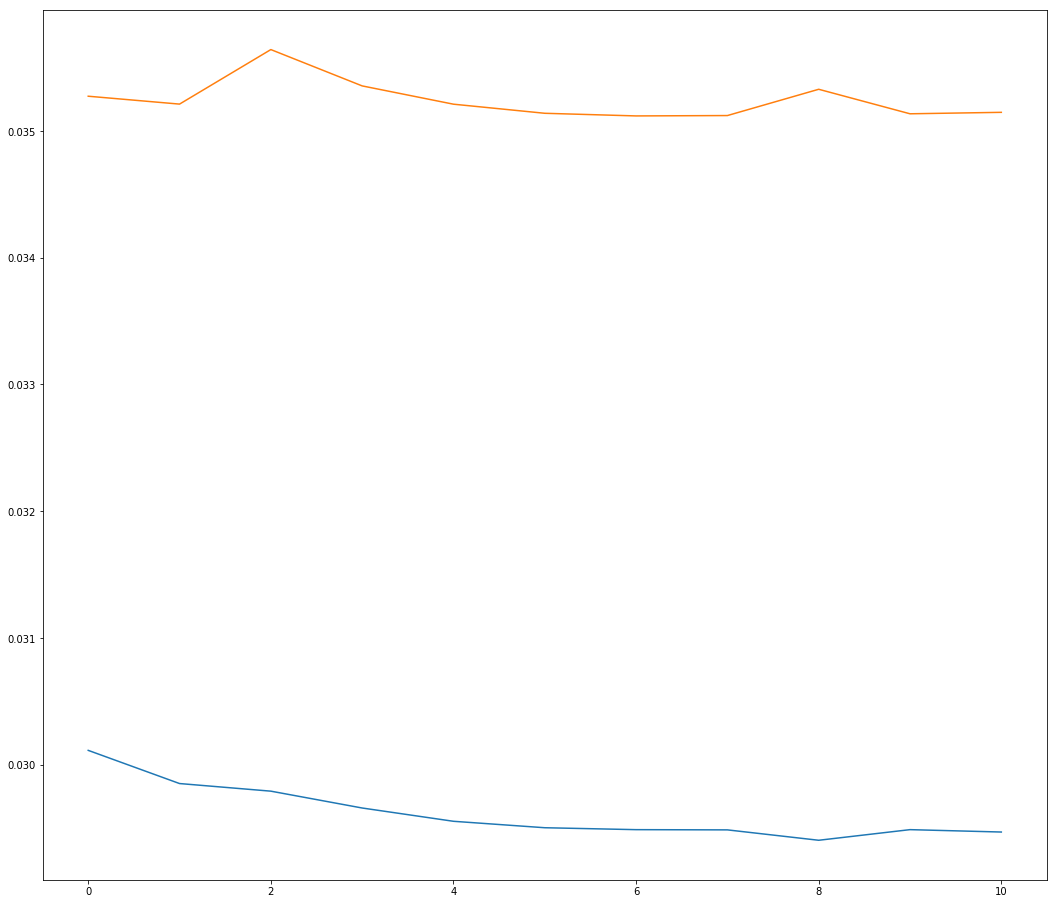

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02943 RMSE
Test Score: 0.03511 RMSE
(9004, 11)
(9011, 11)


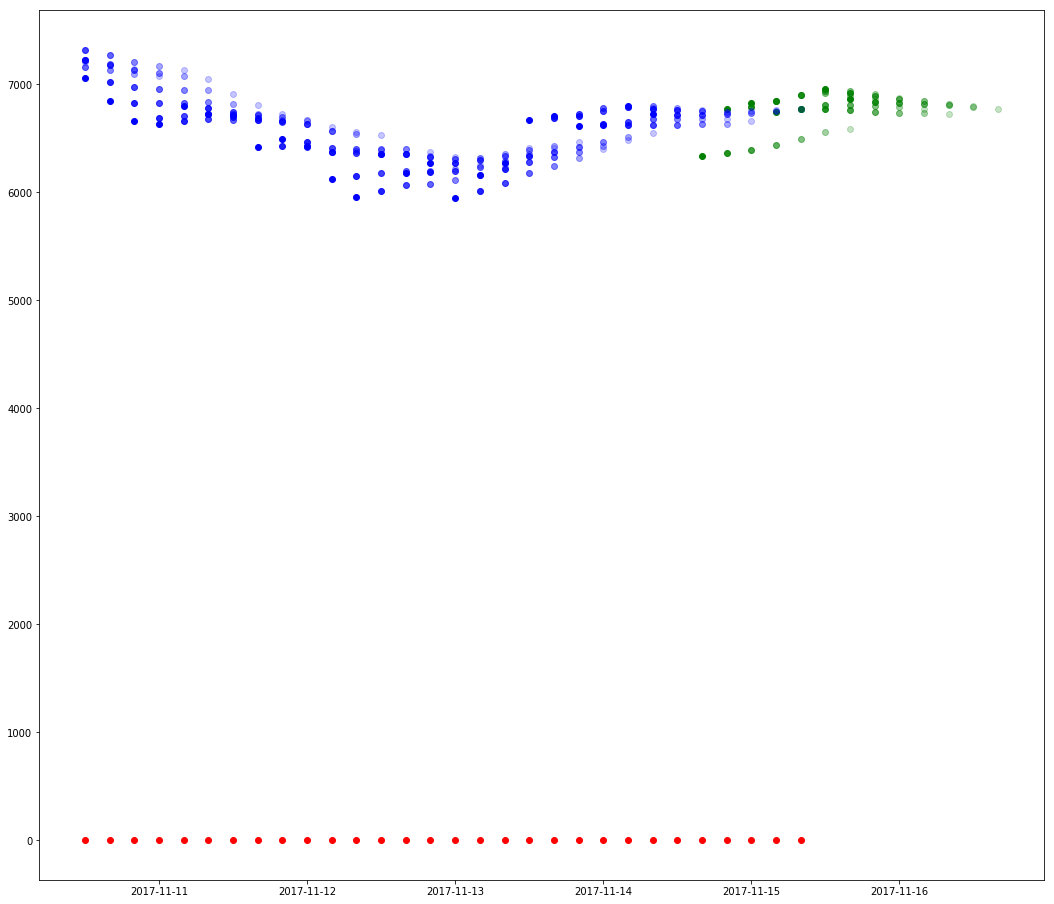

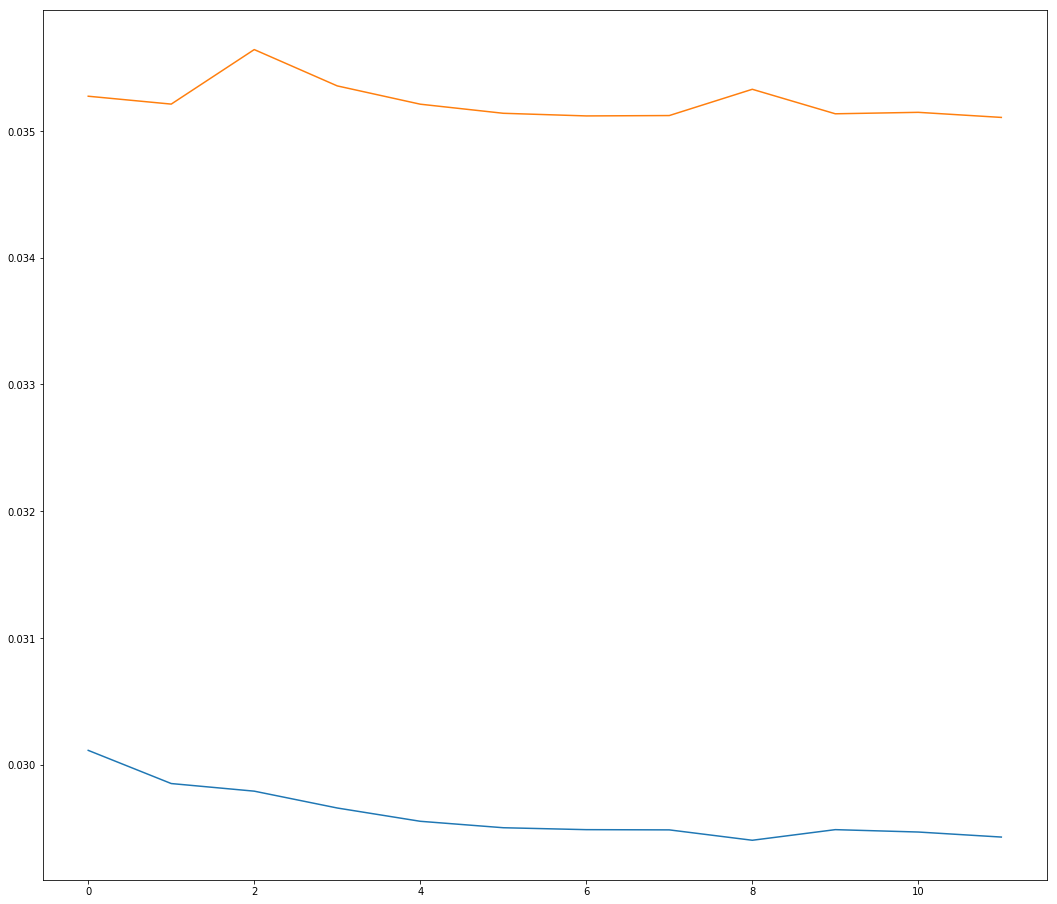

Epoch 1/1
 - 44s - loss: 0.0014
Train Score: 0.02937 RMSE
Test Score: 0.03501 RMSE
(9004, 11)
(9011, 11)


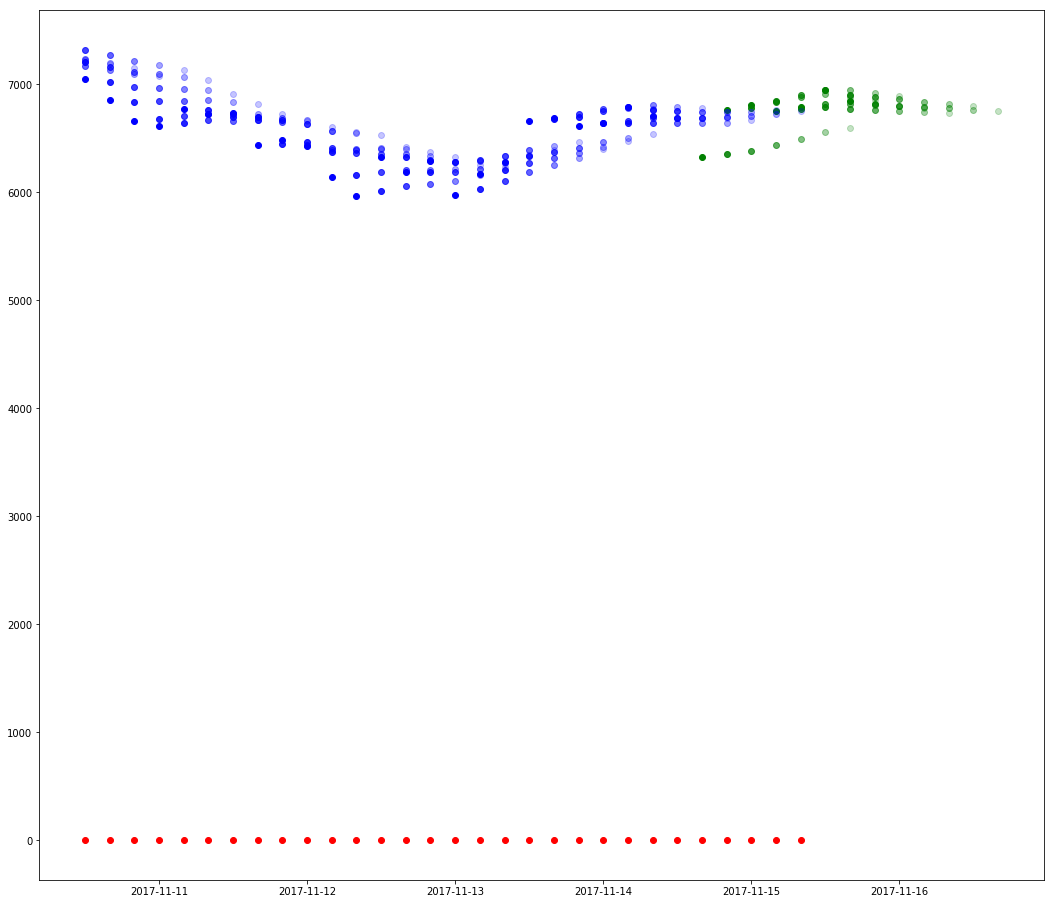

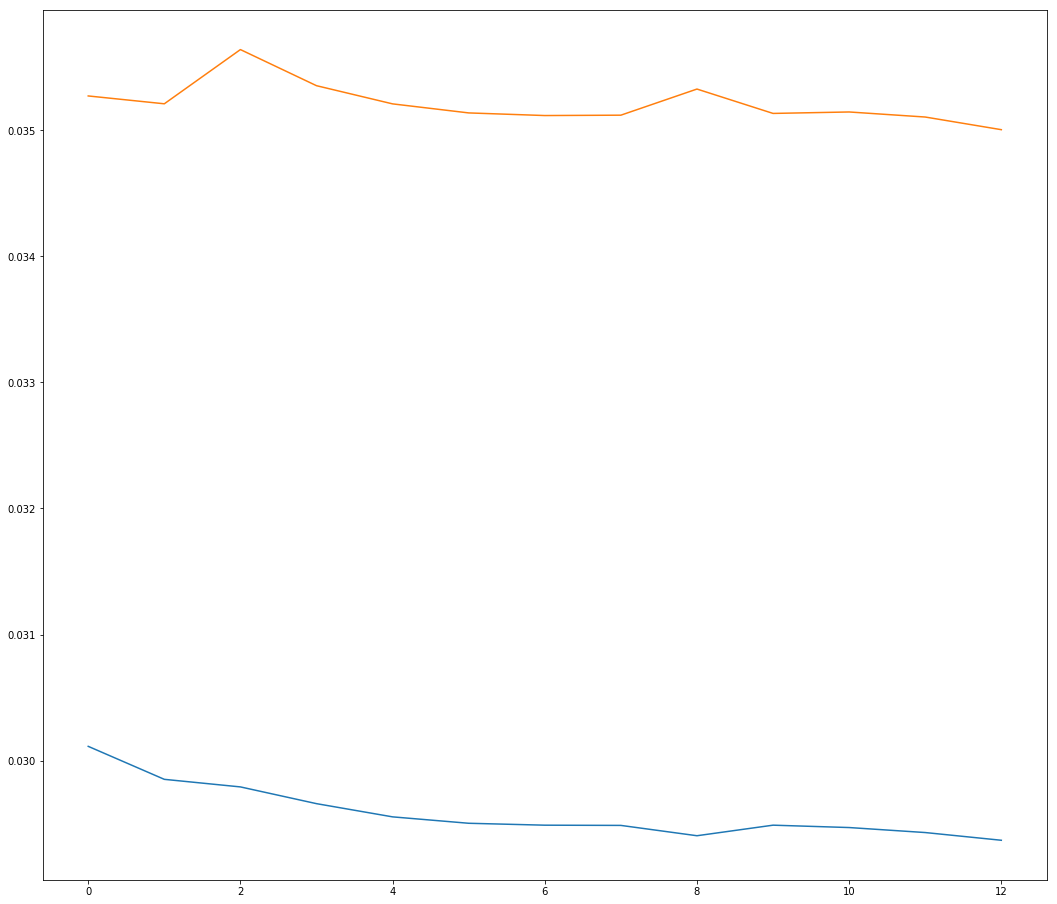

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02928 RMSE
Test Score: 0.03509 RMSE
(9004, 11)
(9011, 11)


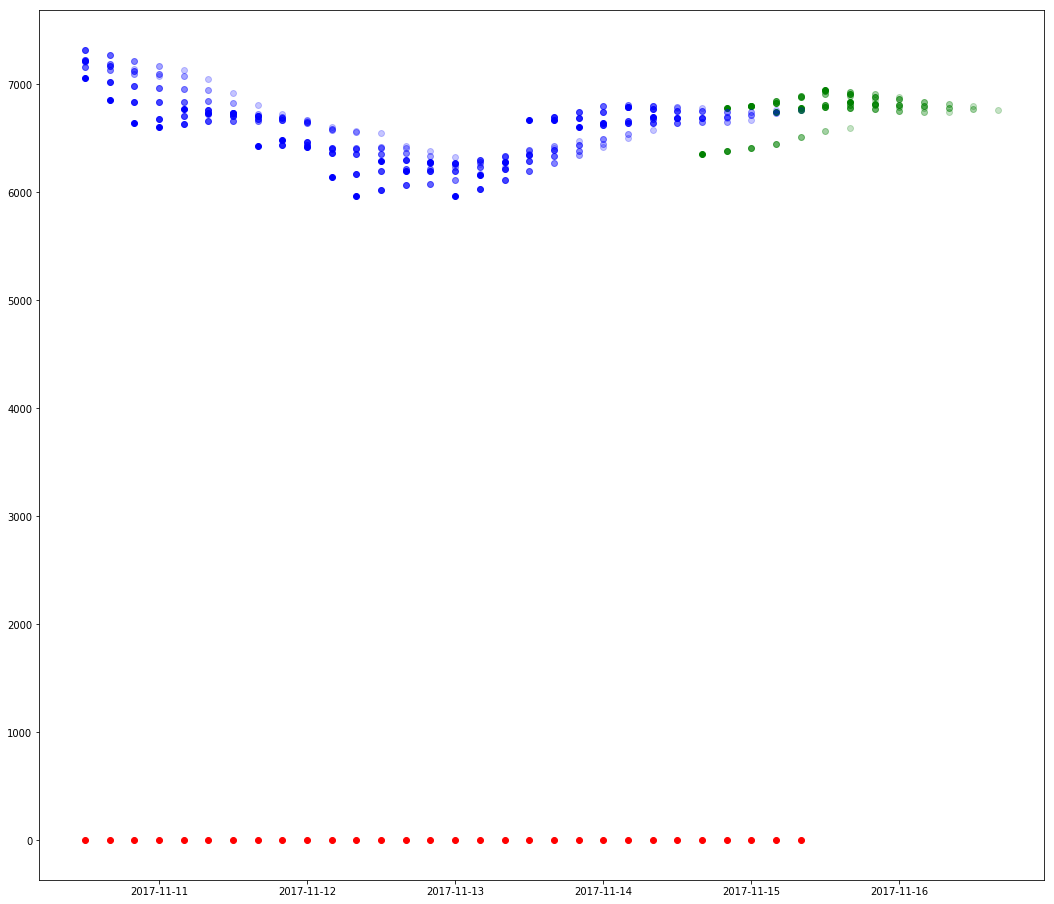

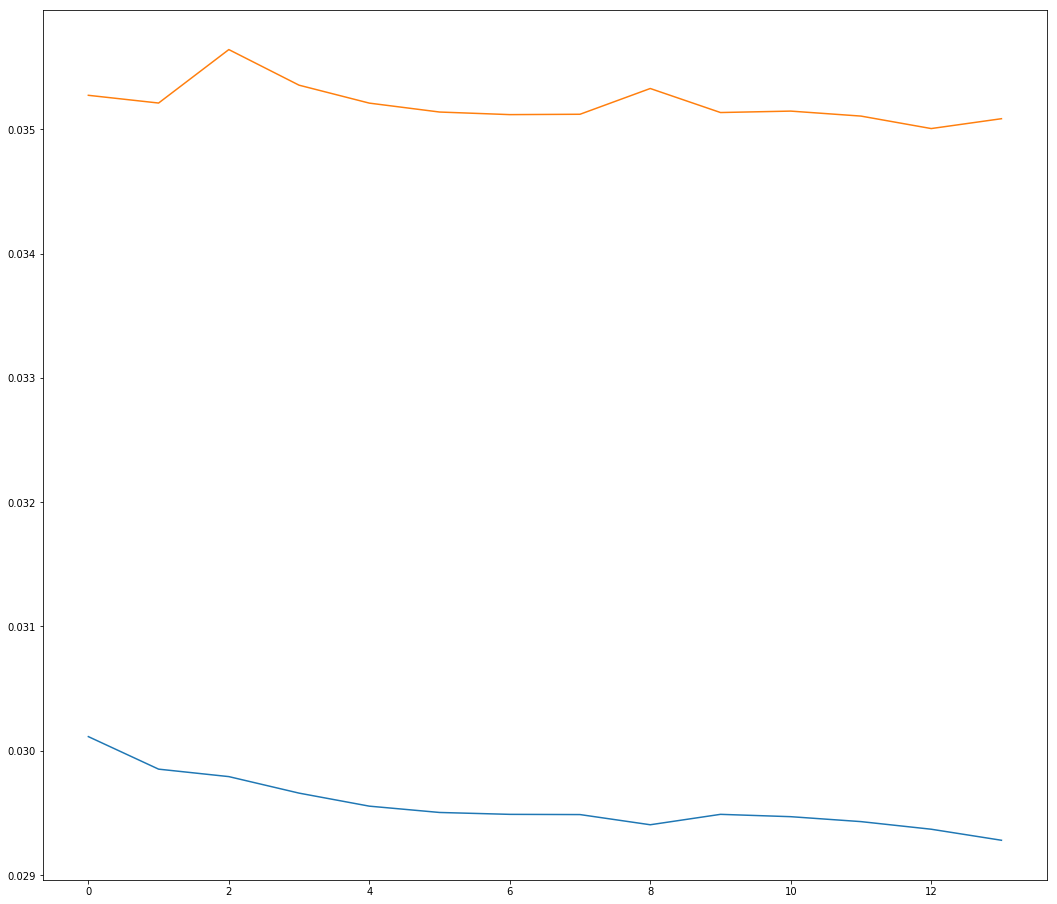

Epoch 1/1
 - 44s - loss: 0.0014
Train Score: 0.02937 RMSE
Test Score: 0.03479 RMSE
(9004, 11)
(9011, 11)


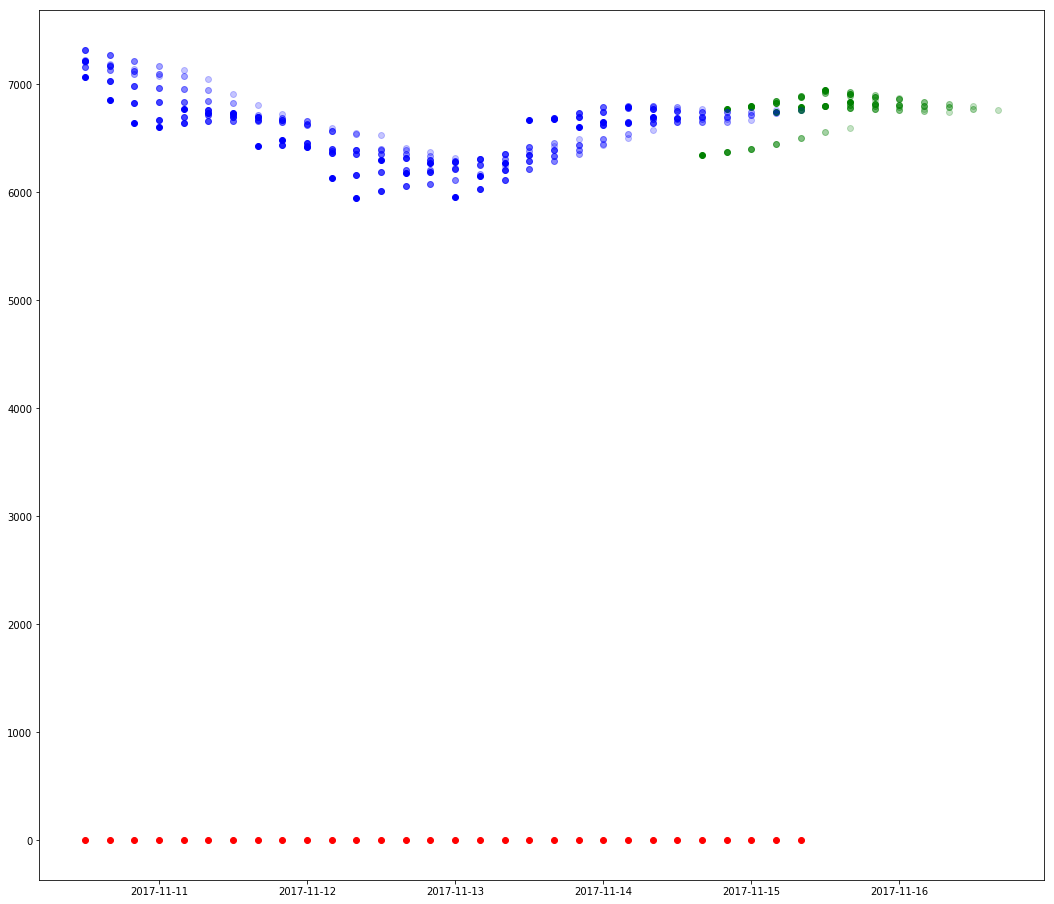

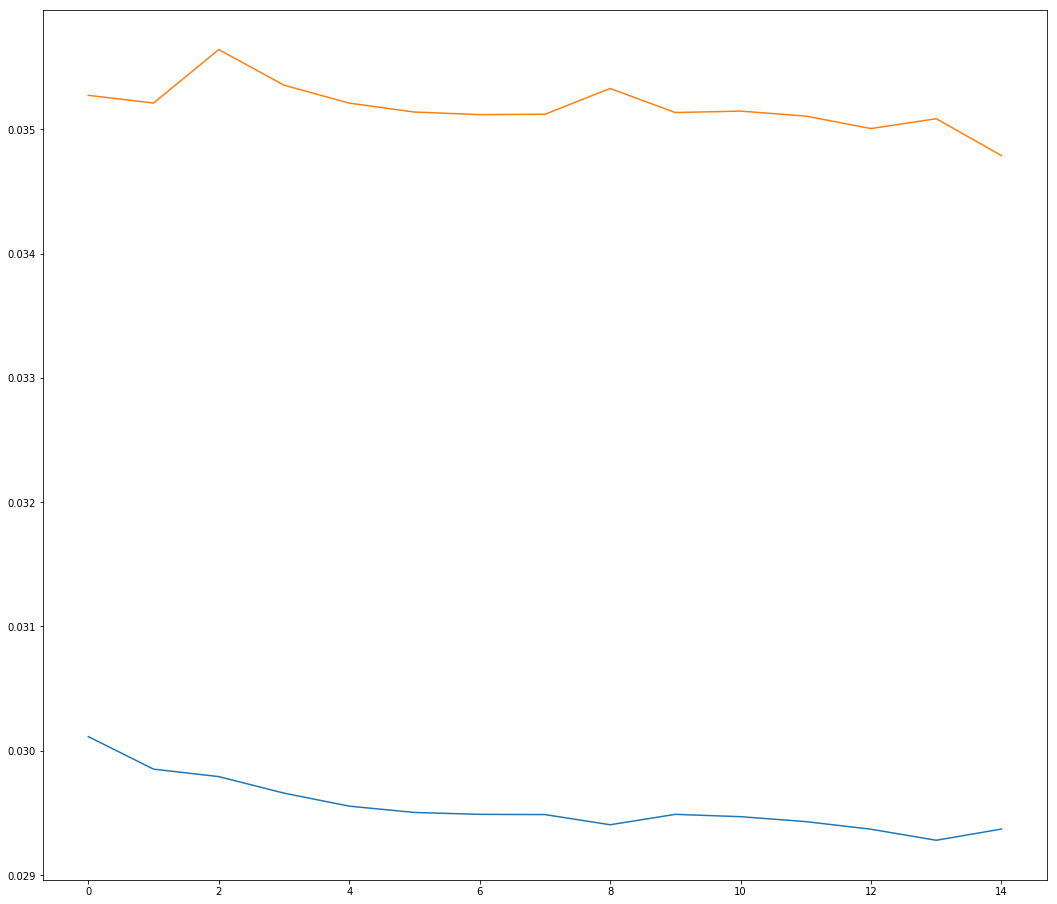

Epoch 1/1
 - 44s - loss: 0.0014
Train Score: 0.02914 RMSE
Test Score: 0.03500 RMSE
(9004, 11)
(9011, 11)


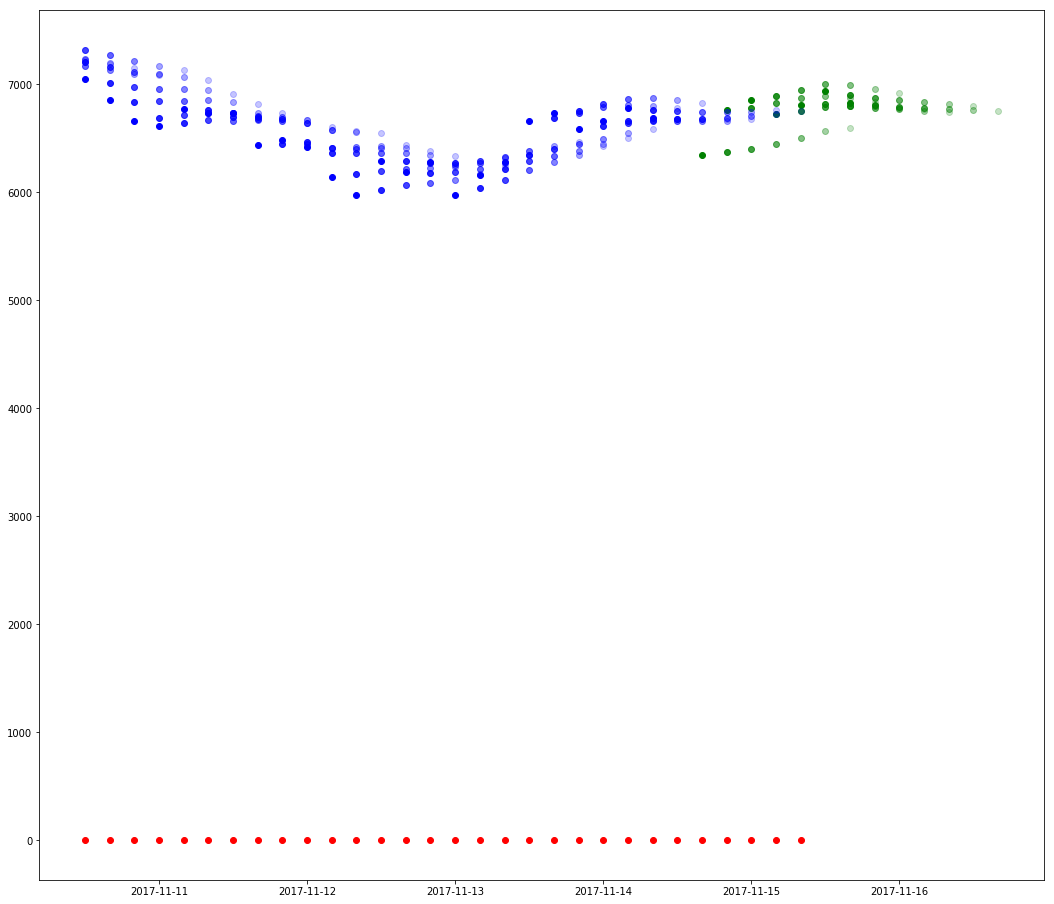

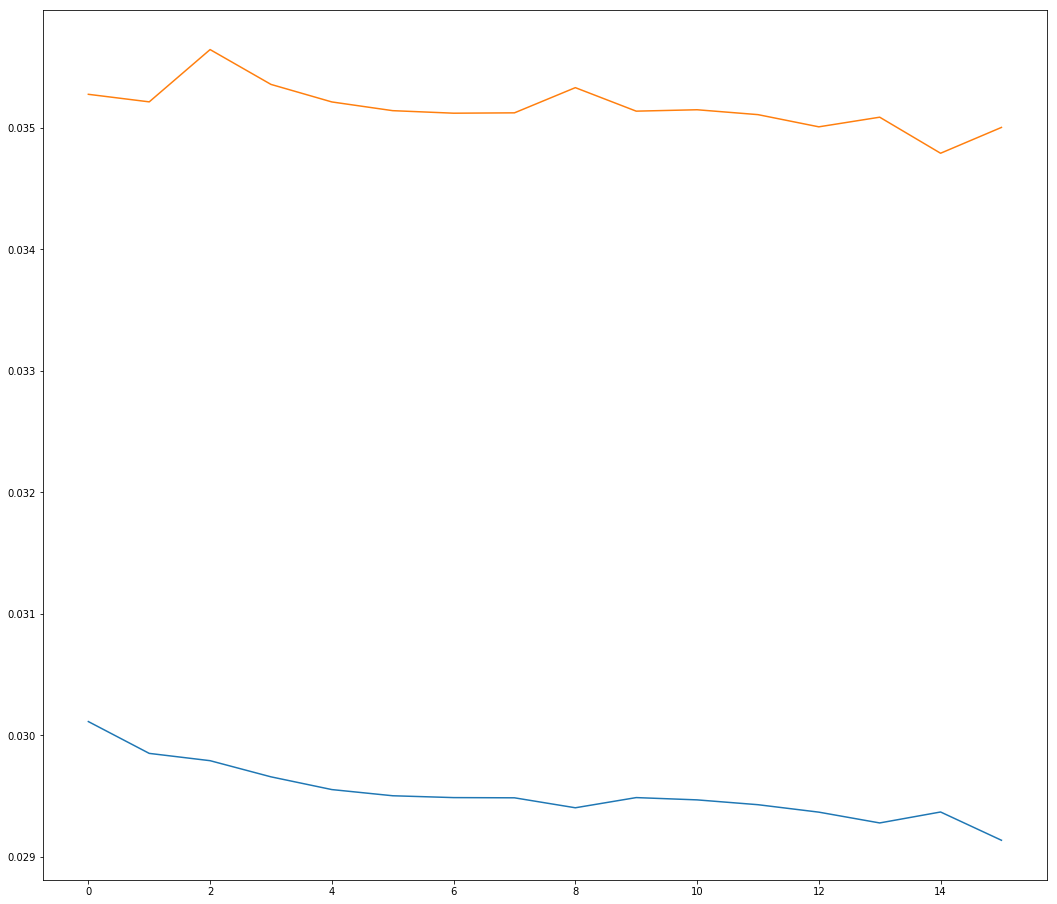

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02919 RMSE
Test Score: 0.03474 RMSE
(9004, 11)
(9011, 11)


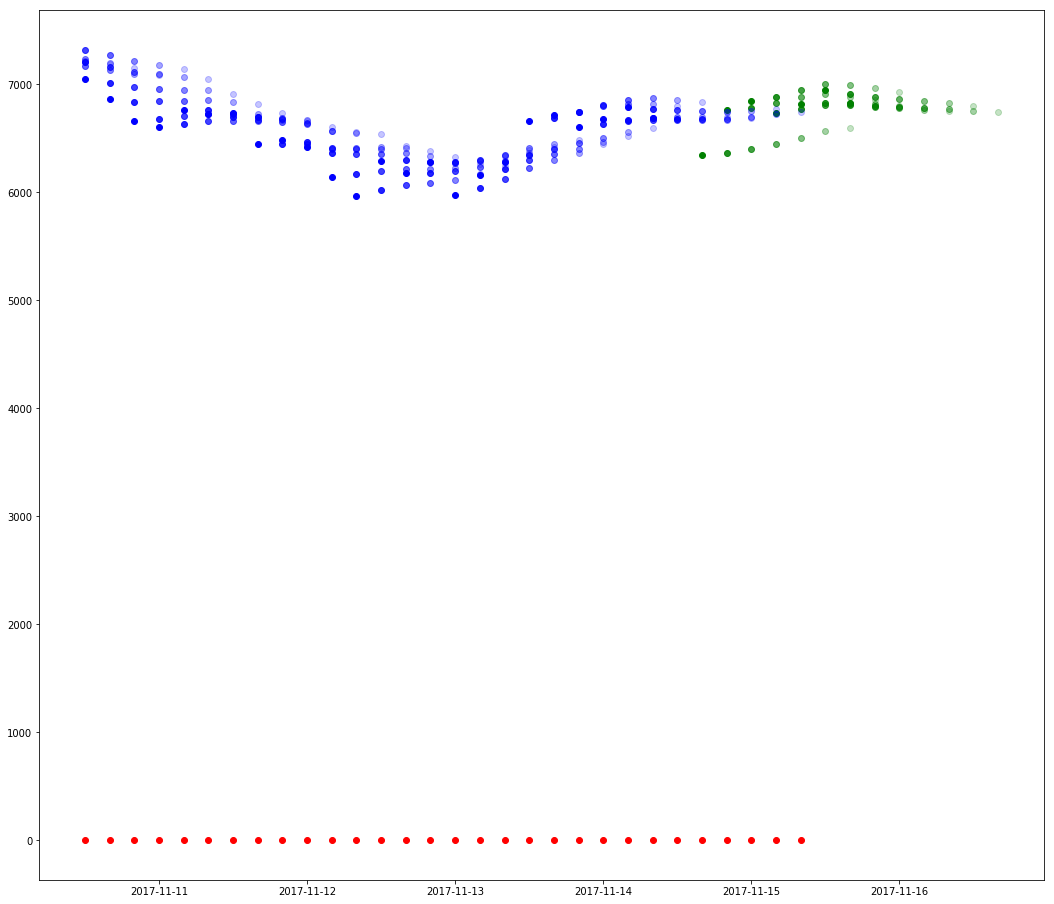

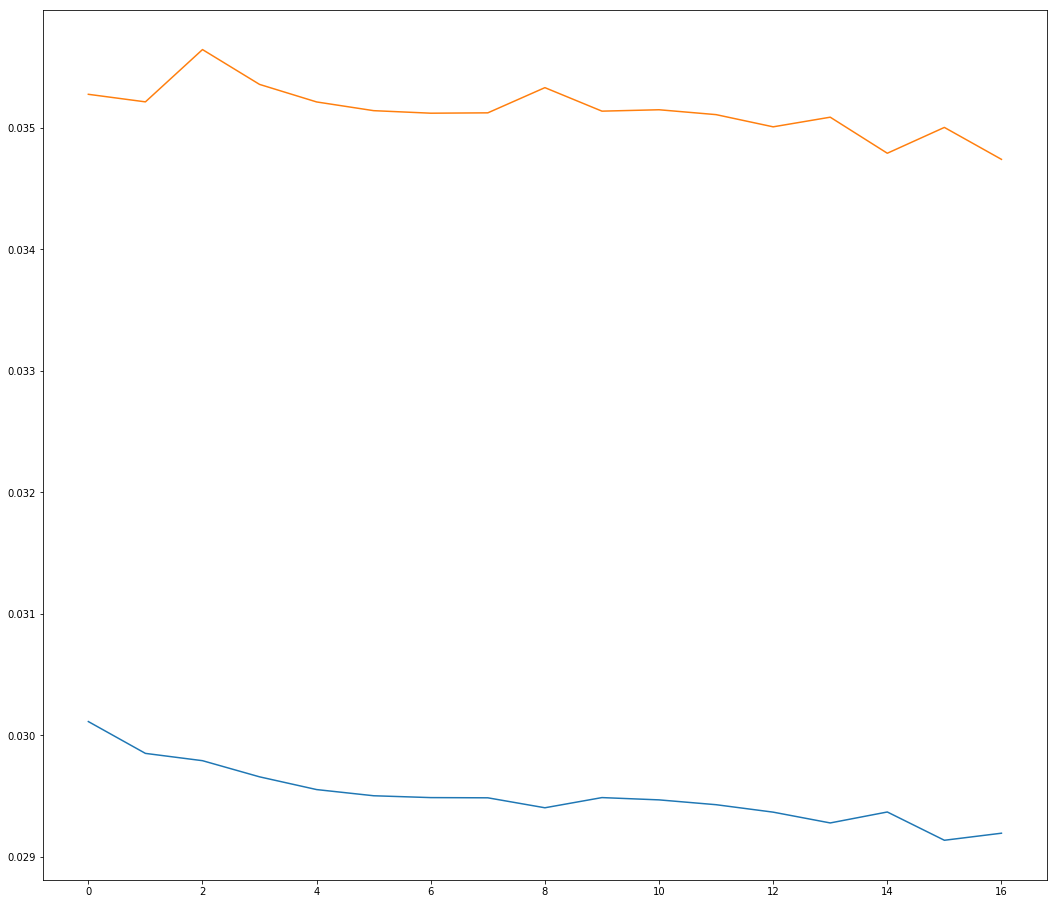

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02920 RMSE
Test Score: 0.03481 RMSE
(9004, 11)
(9011, 11)


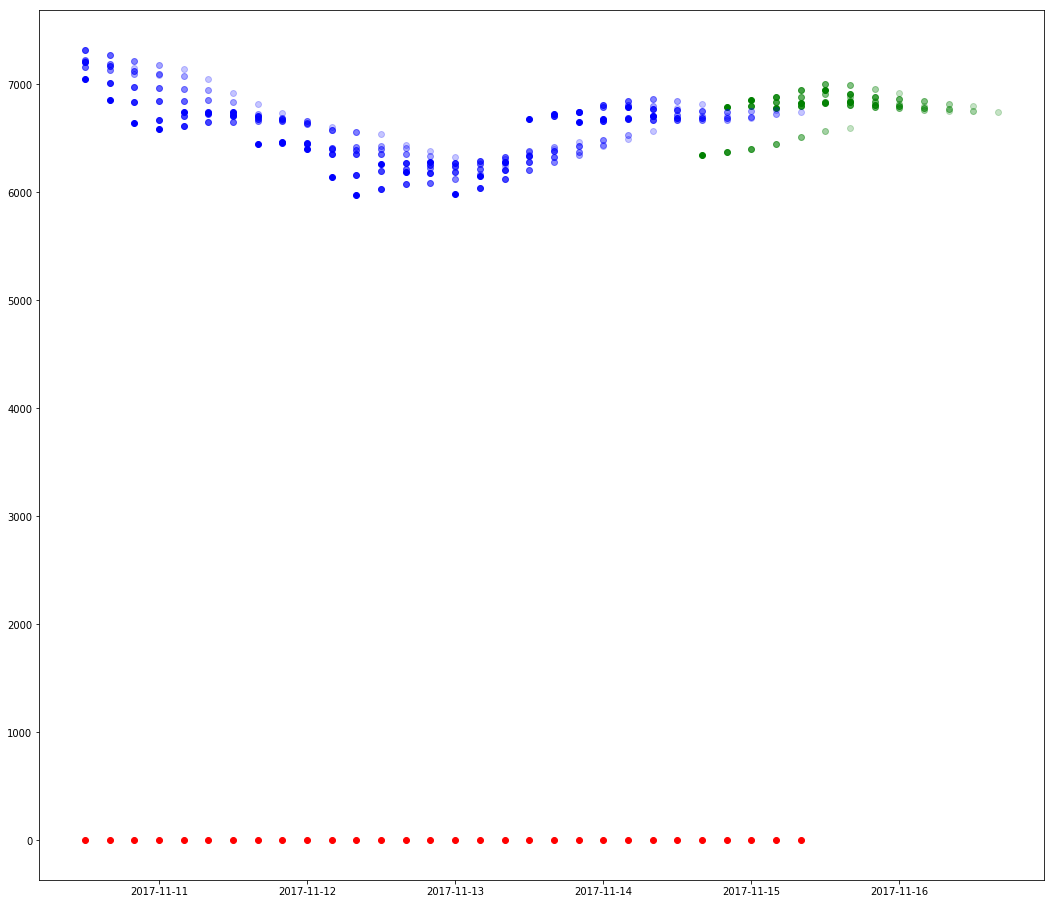

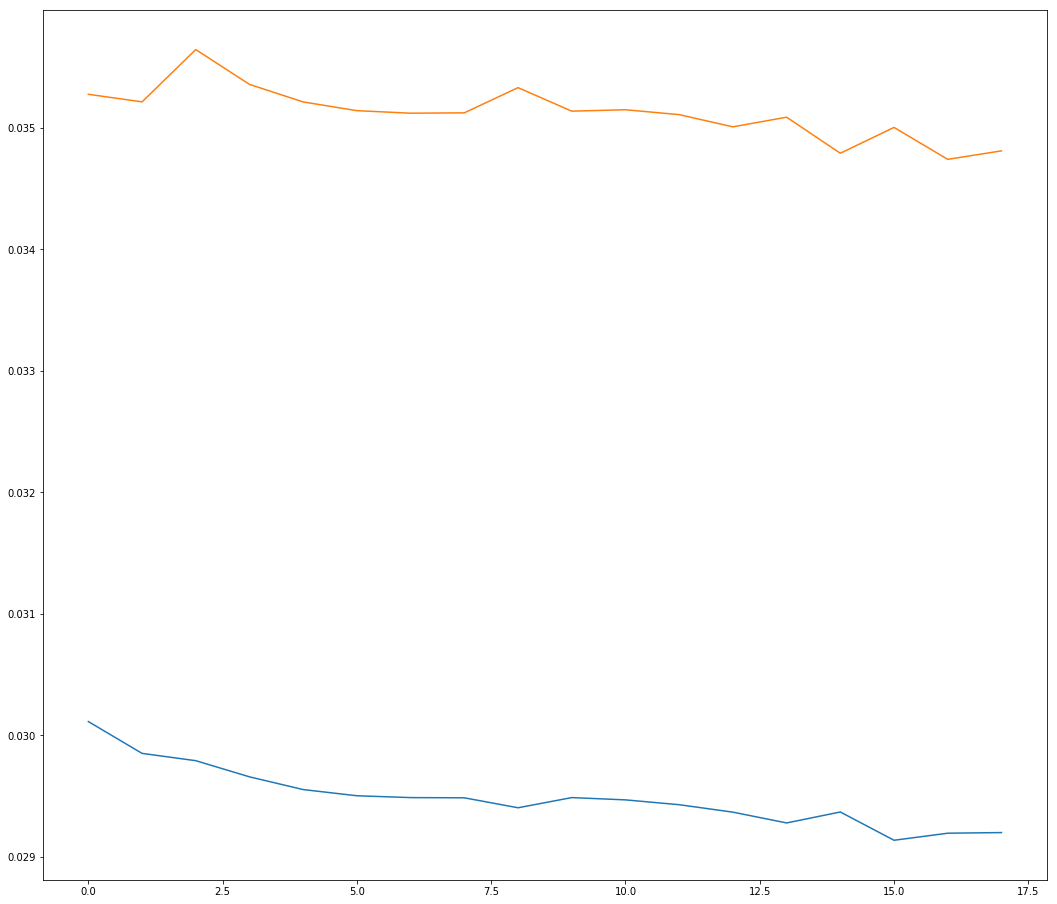

Epoch 1/1
 - 44s - loss: 0.0014
Train Score: 0.02918 RMSE
Test Score: 0.03518 RMSE
(9004, 11)
(9011, 11)


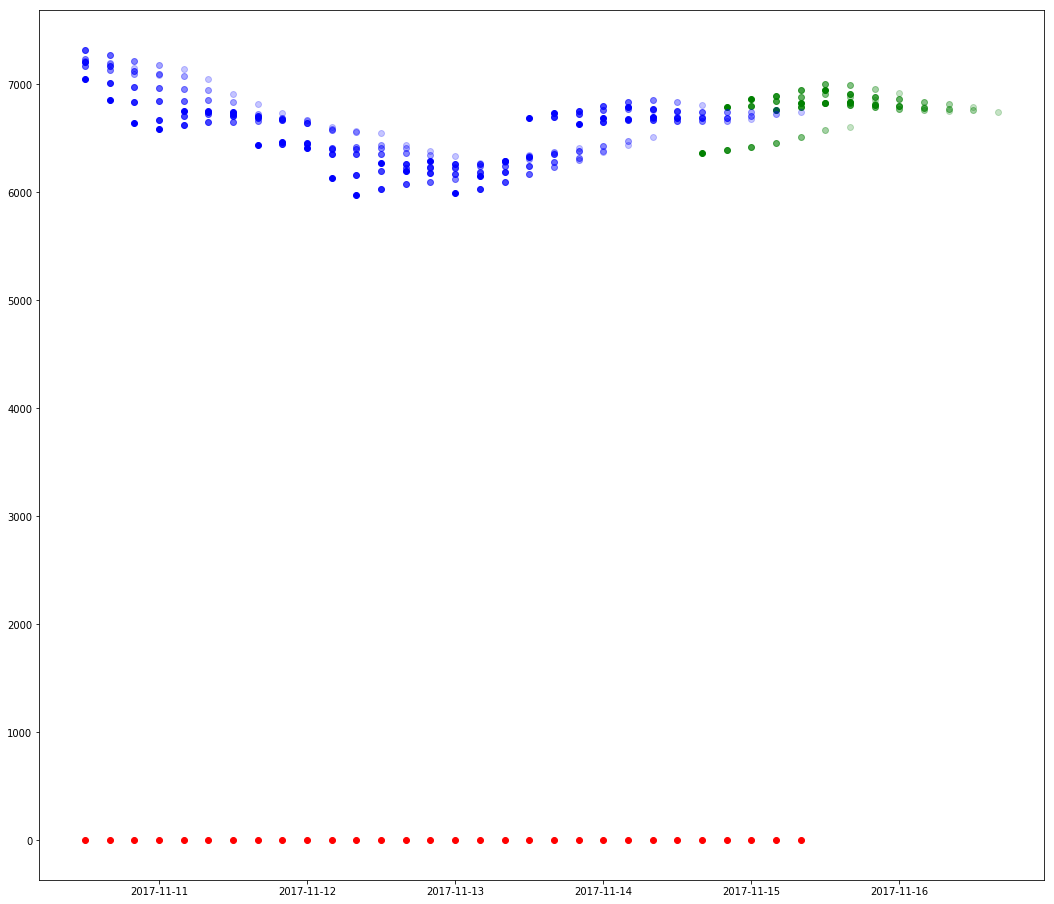

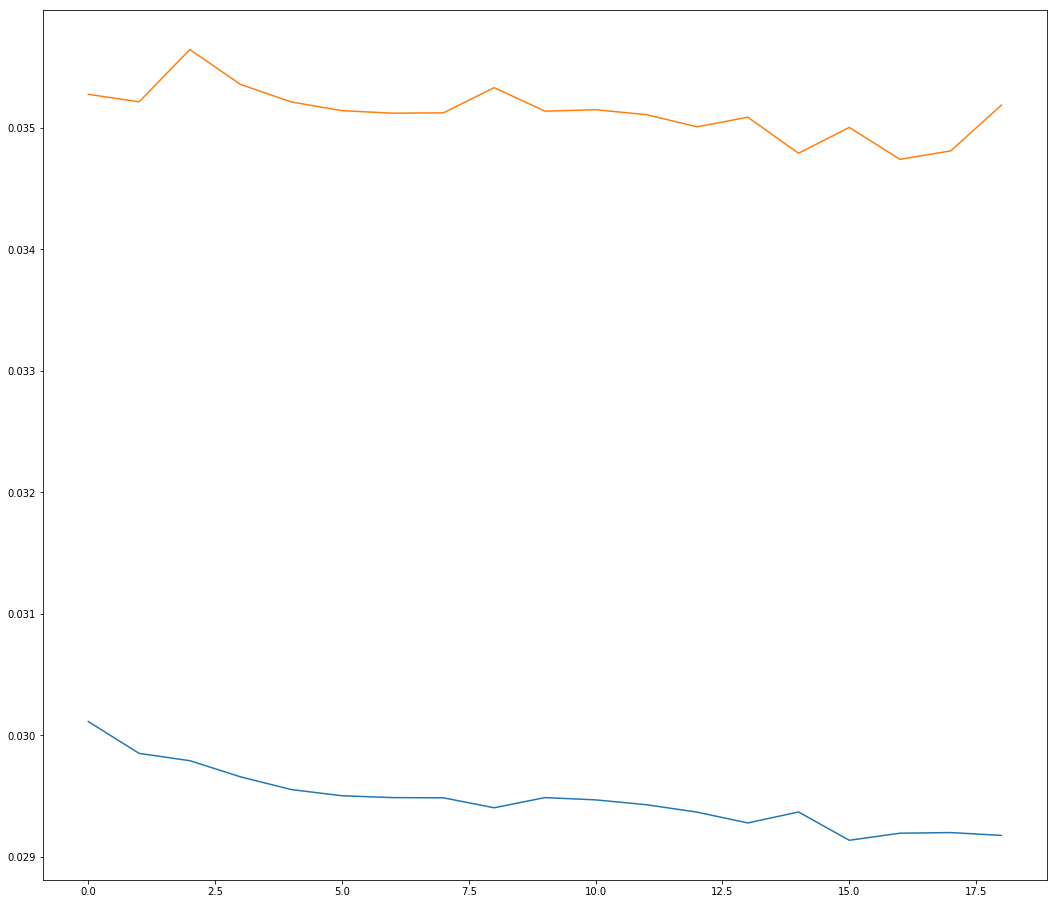

Epoch 1/1
 - 44s - loss: 0.0014
Train Score: 0.02906 RMSE
Test Score: 0.03526 RMSE
(9004, 11)
(9011, 11)


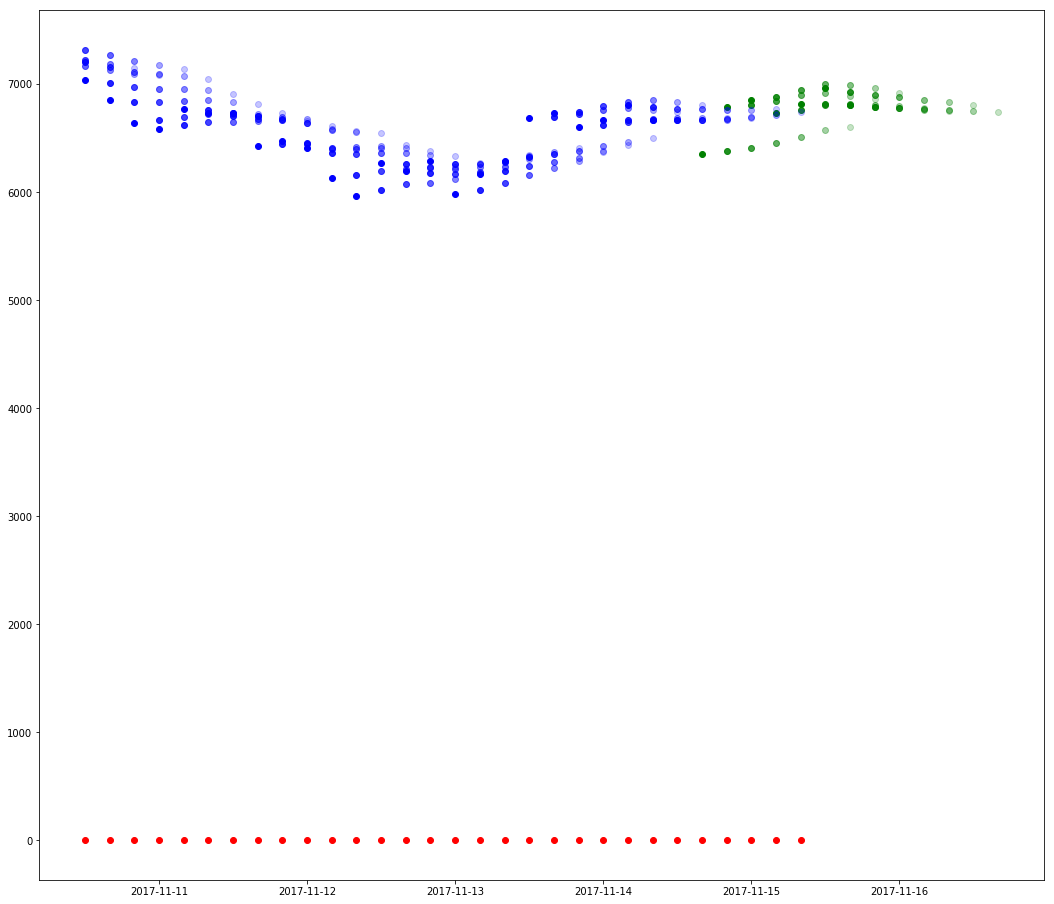

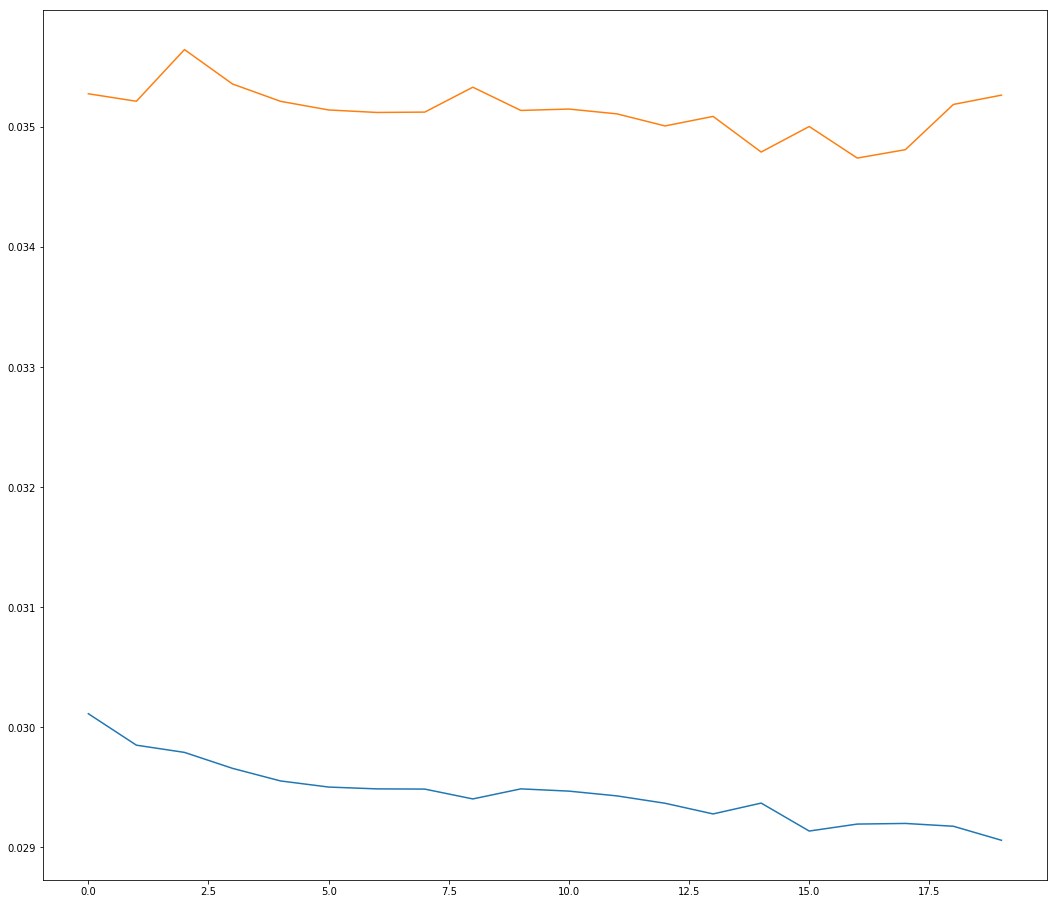

Epoch 1/1
 - 44s - loss: 0.0014
Train Score: 0.02906 RMSE
Test Score: 0.03516 RMSE
(9004, 11)
(9011, 11)


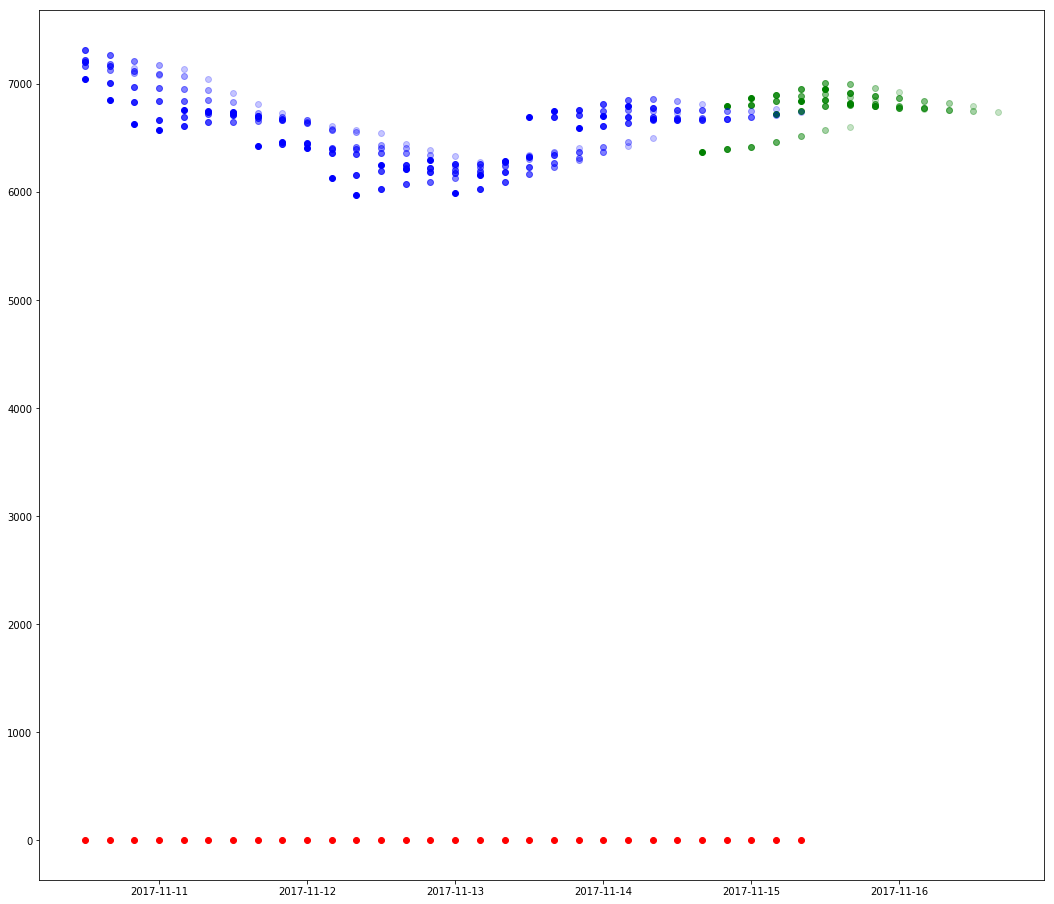

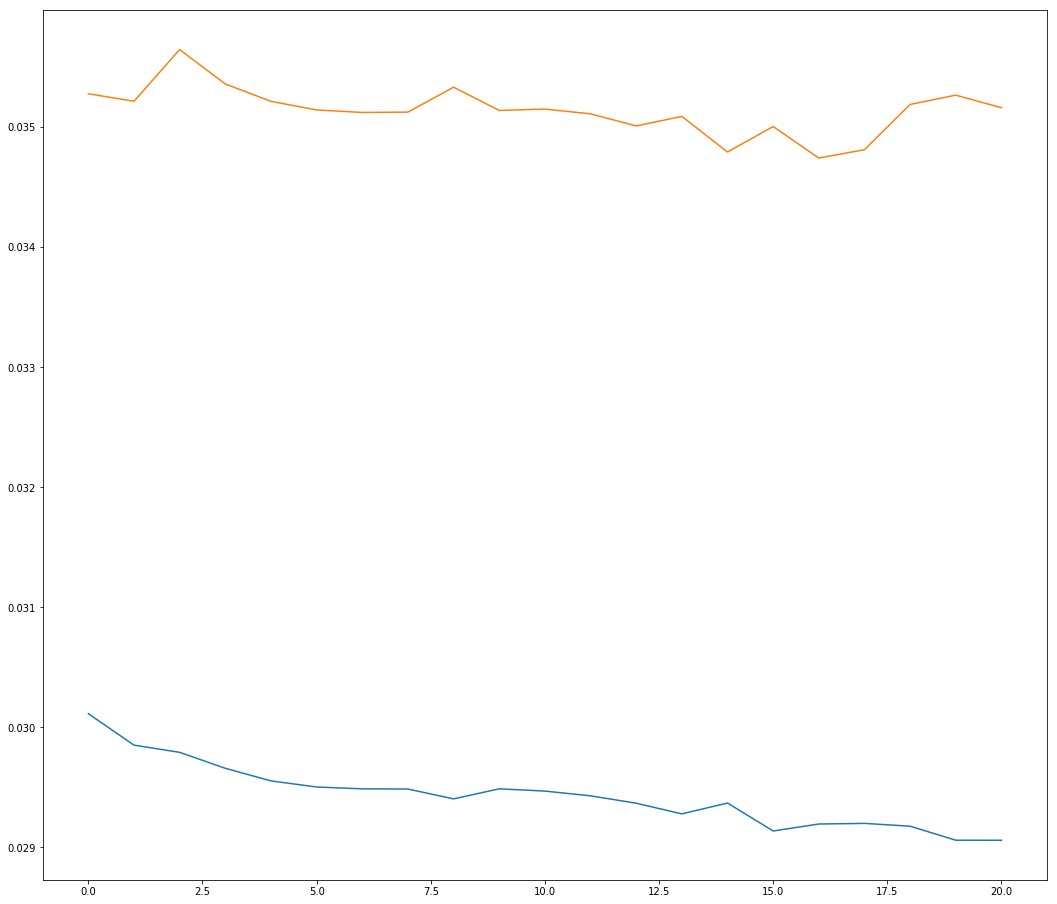

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02902 RMSE
Test Score: 0.03511 RMSE
(9004, 11)
(9011, 11)


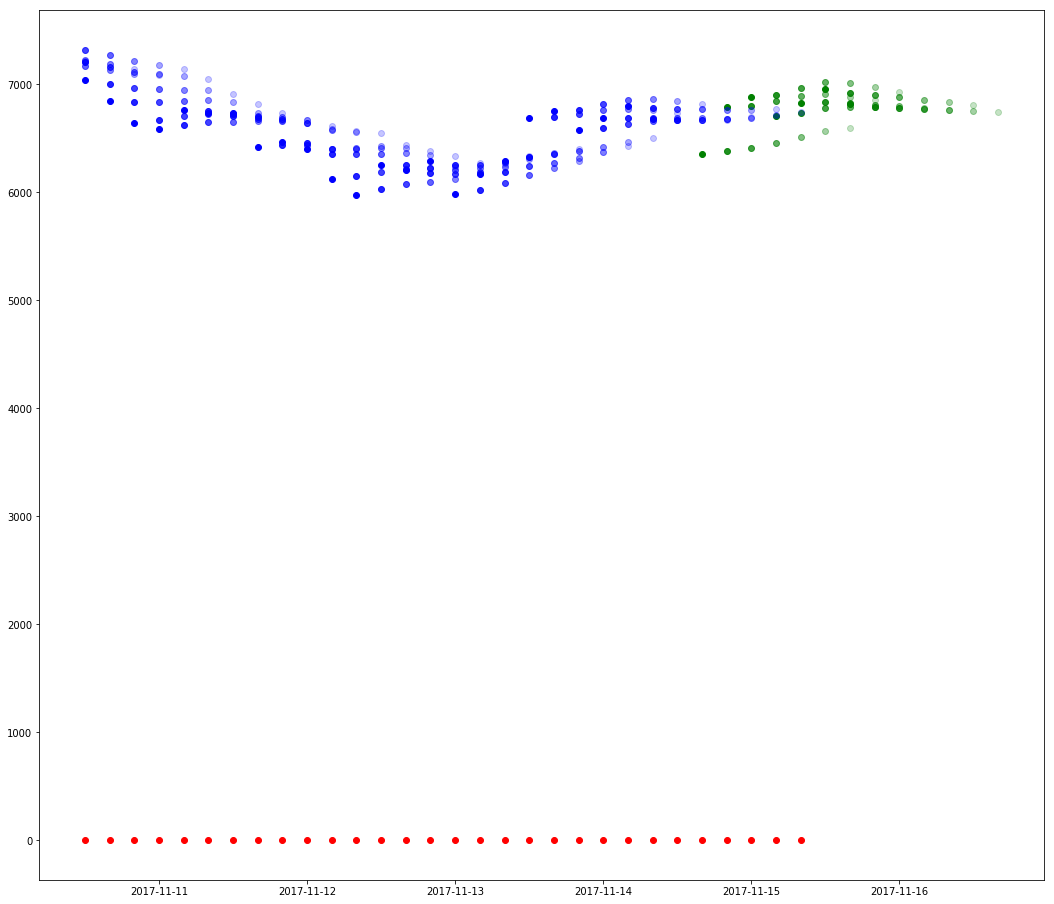

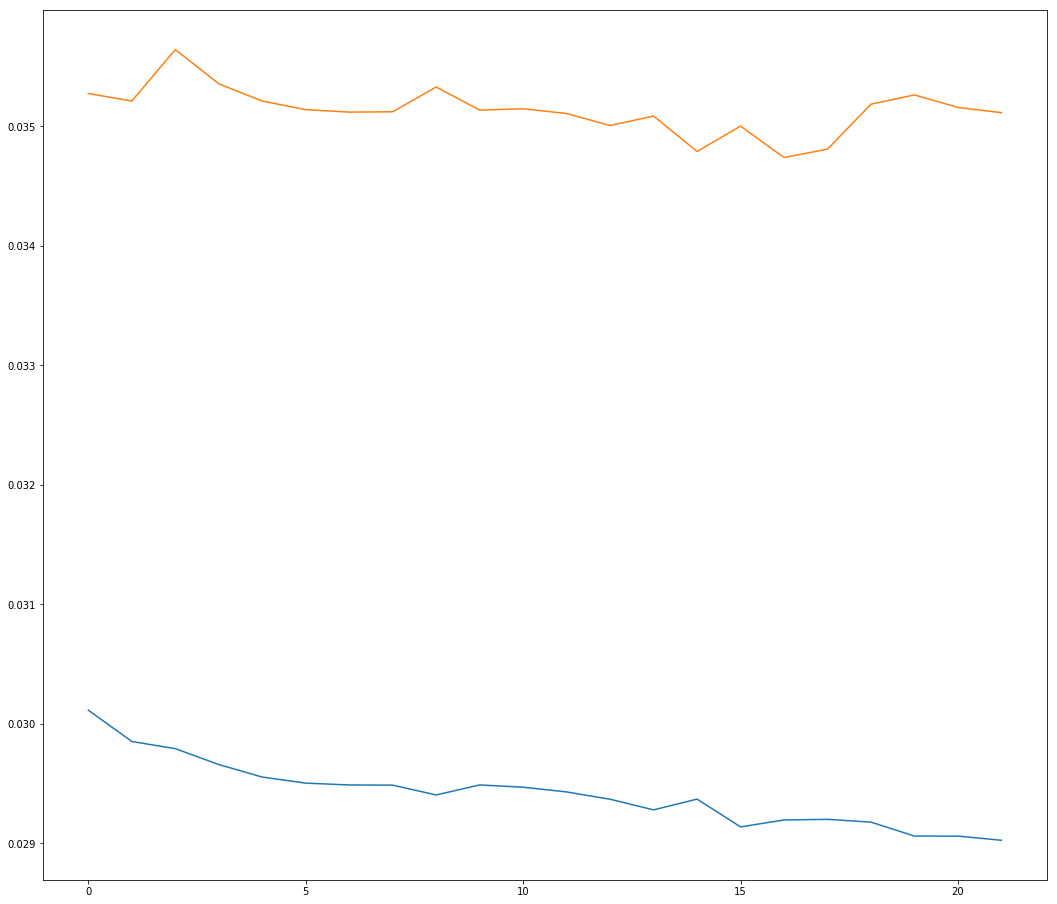

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02922 RMSE
Test Score: 0.03526 RMSE
(9004, 11)
(9011, 11)


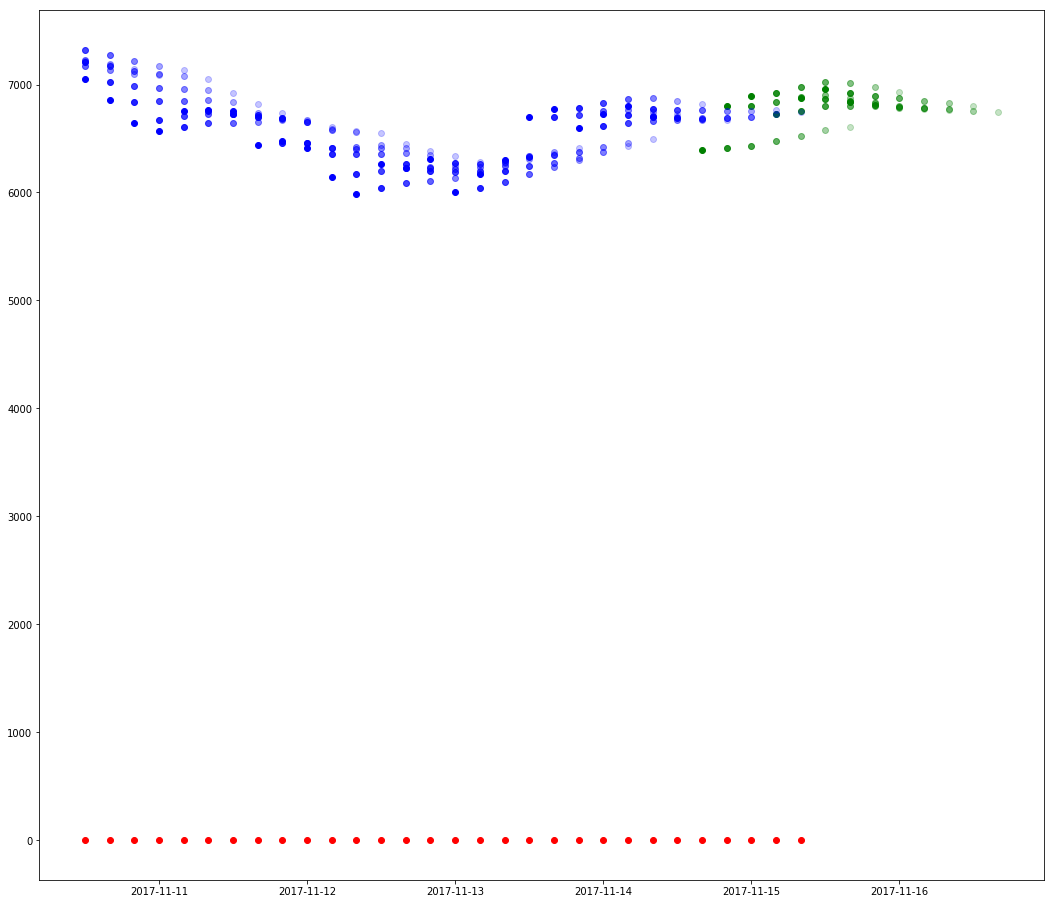

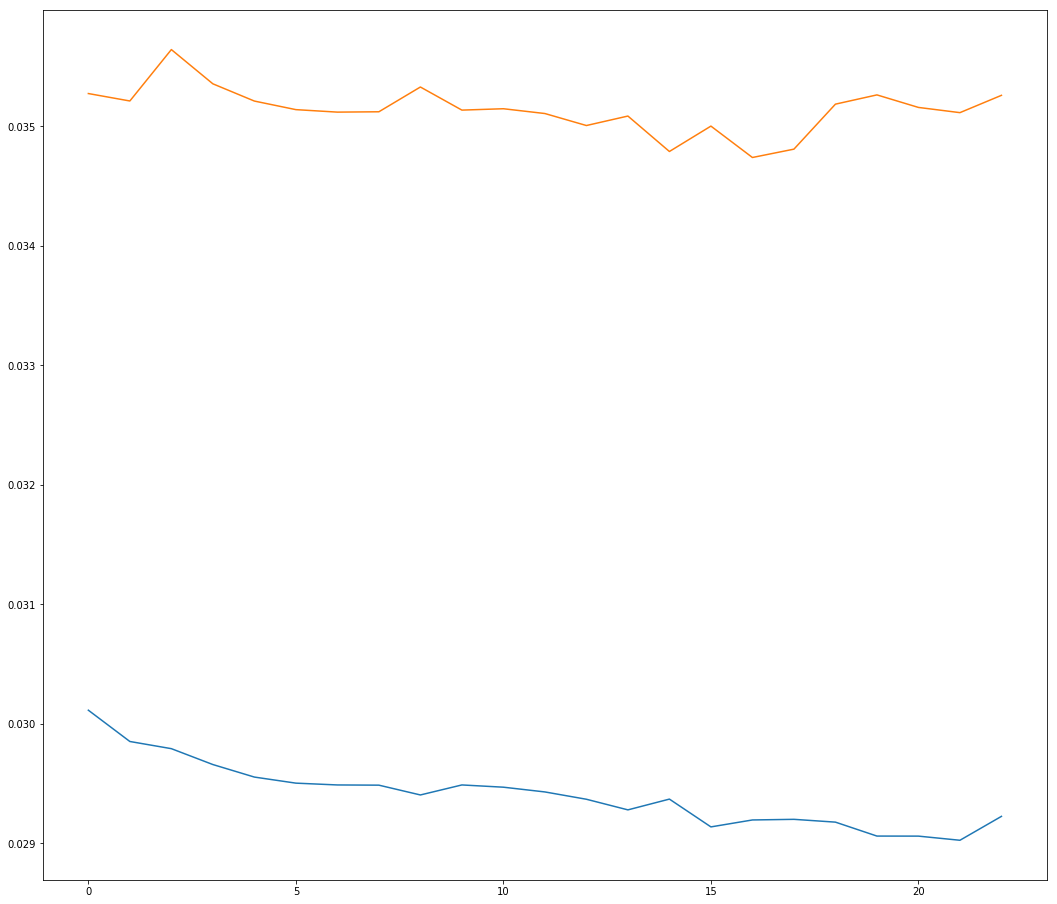

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02921 RMSE
Test Score: 0.03525 RMSE
(9004, 11)
(9011, 11)


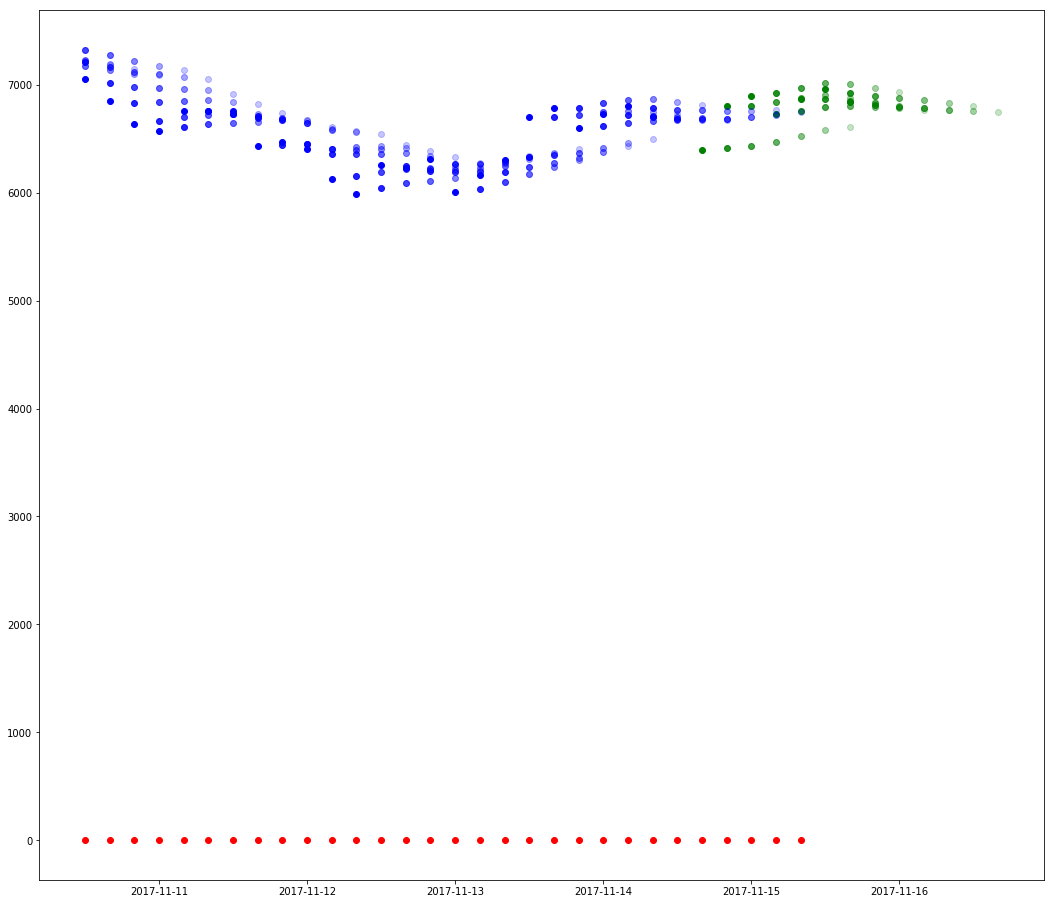

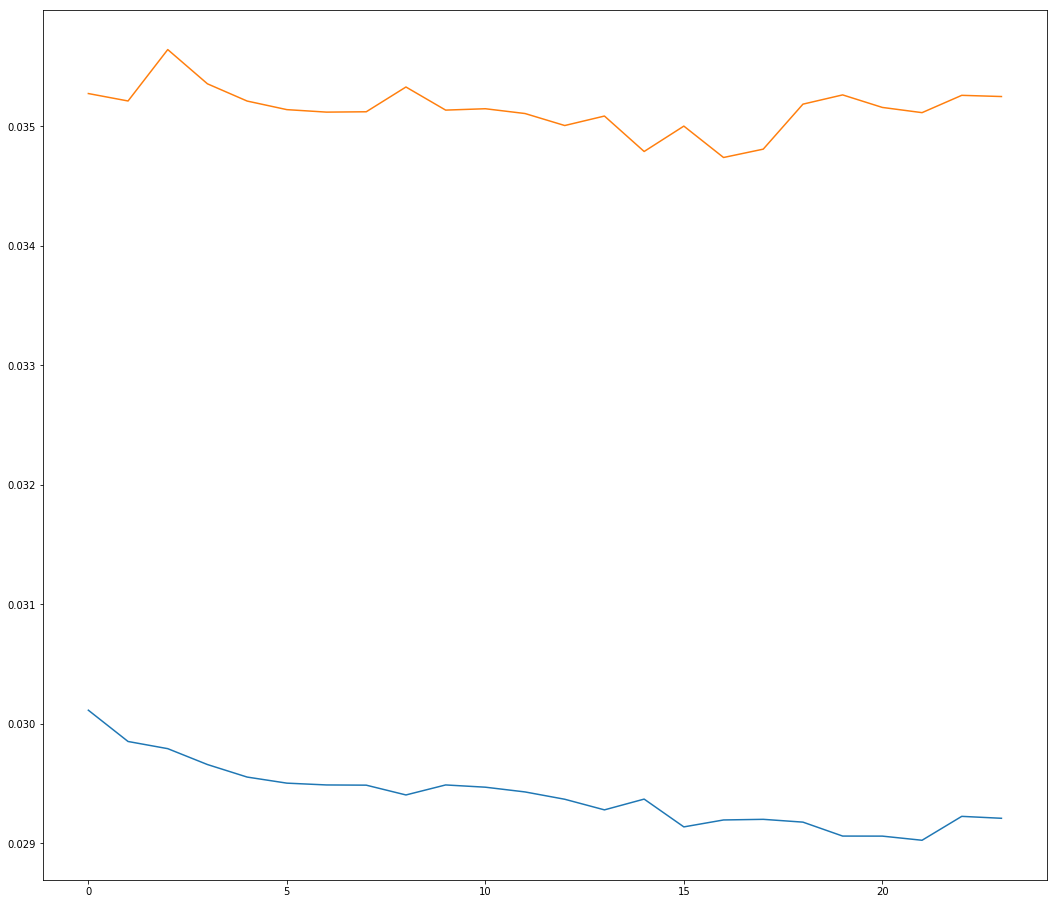

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02921 RMSE
Test Score: 0.03527 RMSE
(9004, 11)
(9011, 11)


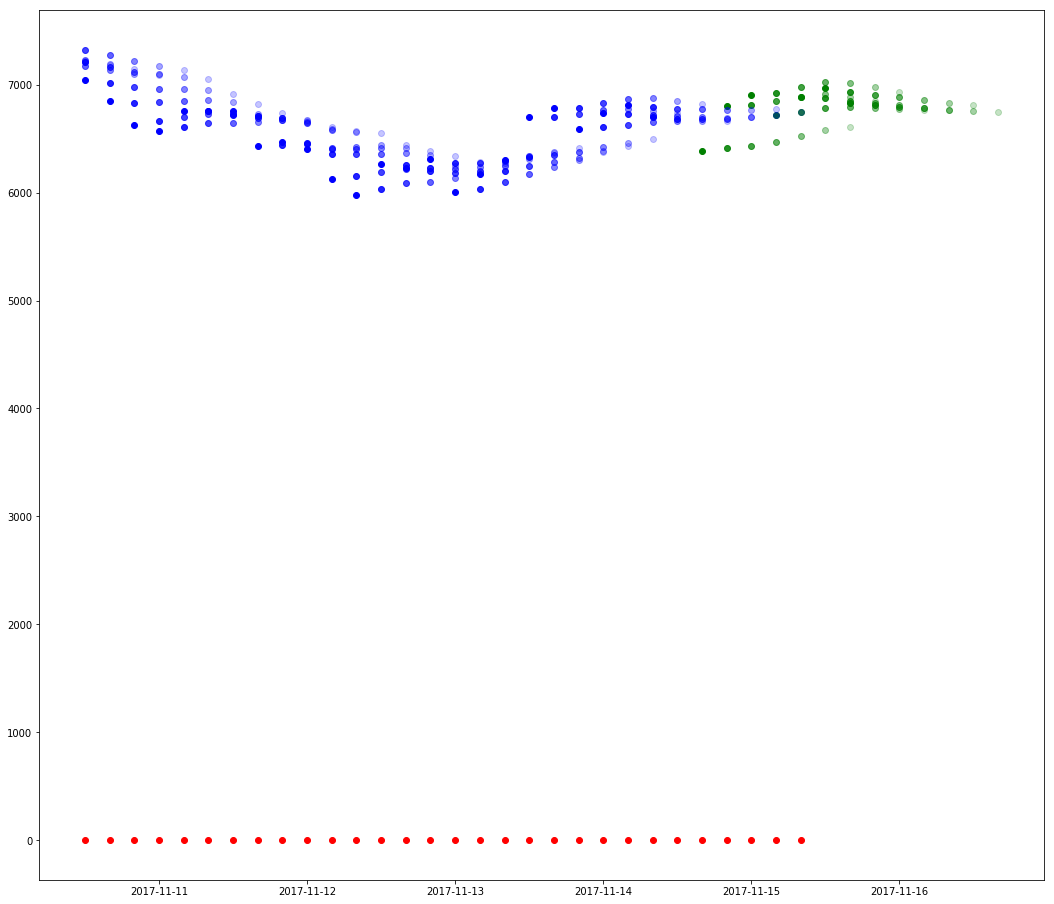

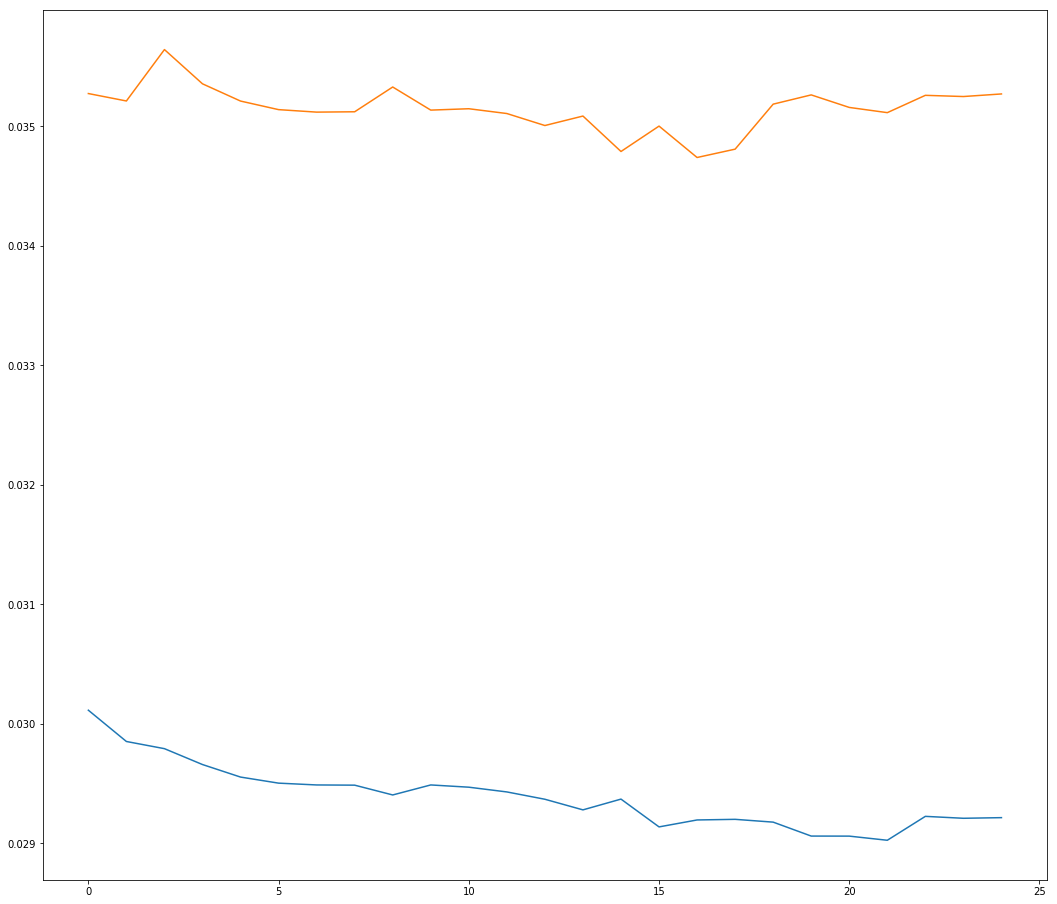

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02916 RMSE
Test Score: 0.03521 RMSE
(9004, 11)
(9011, 11)


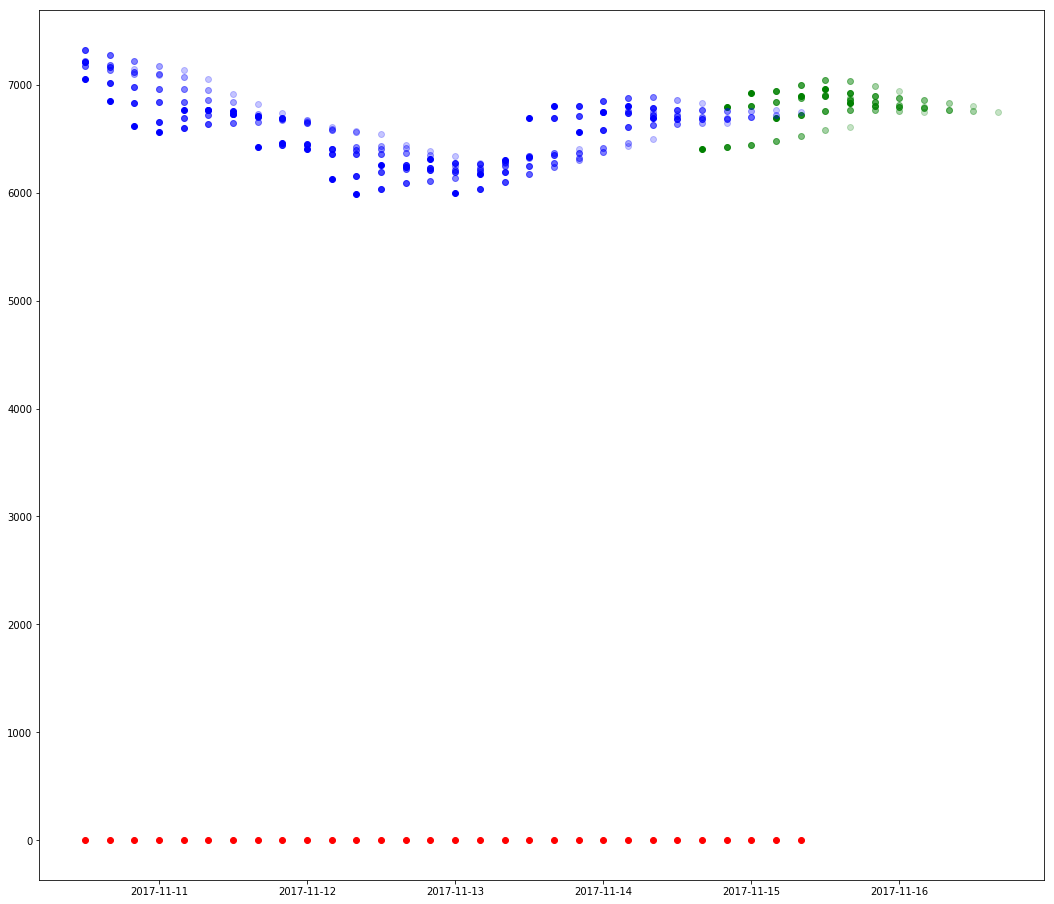

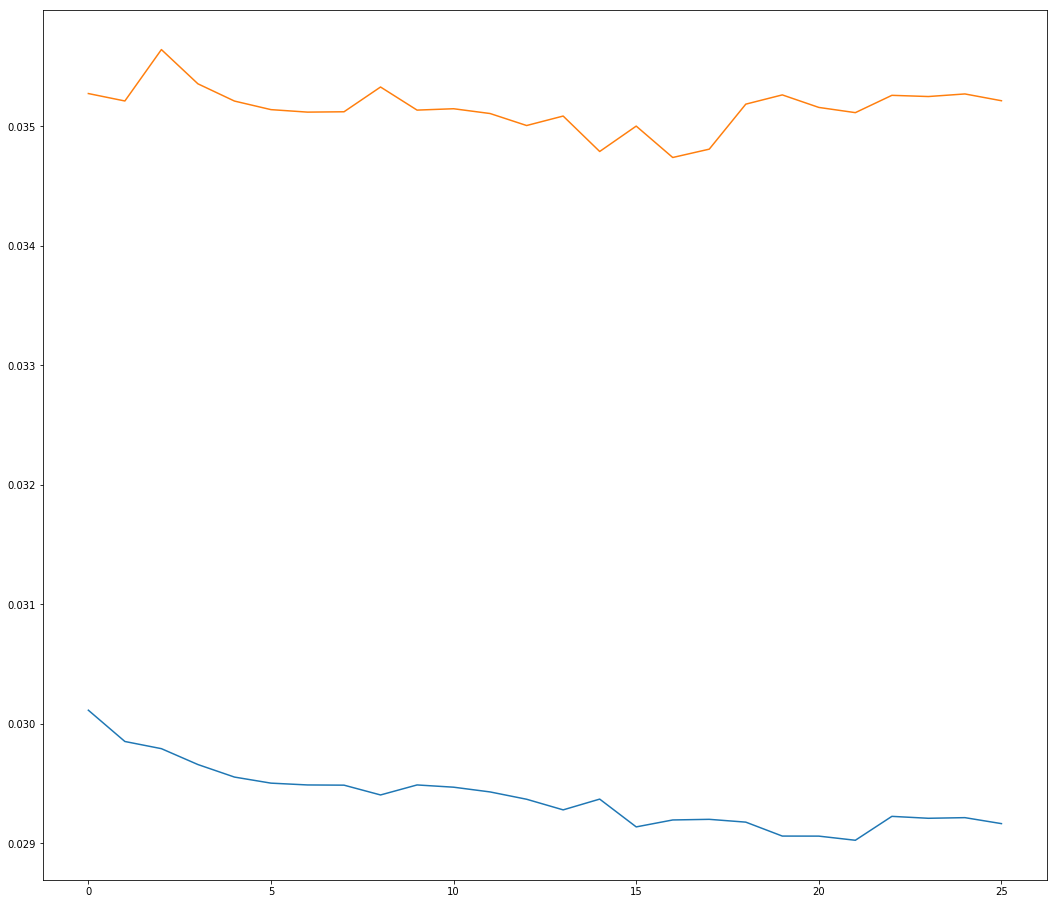

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02915 RMSE
Test Score: 0.03530 RMSE
(9004, 11)
(9011, 11)


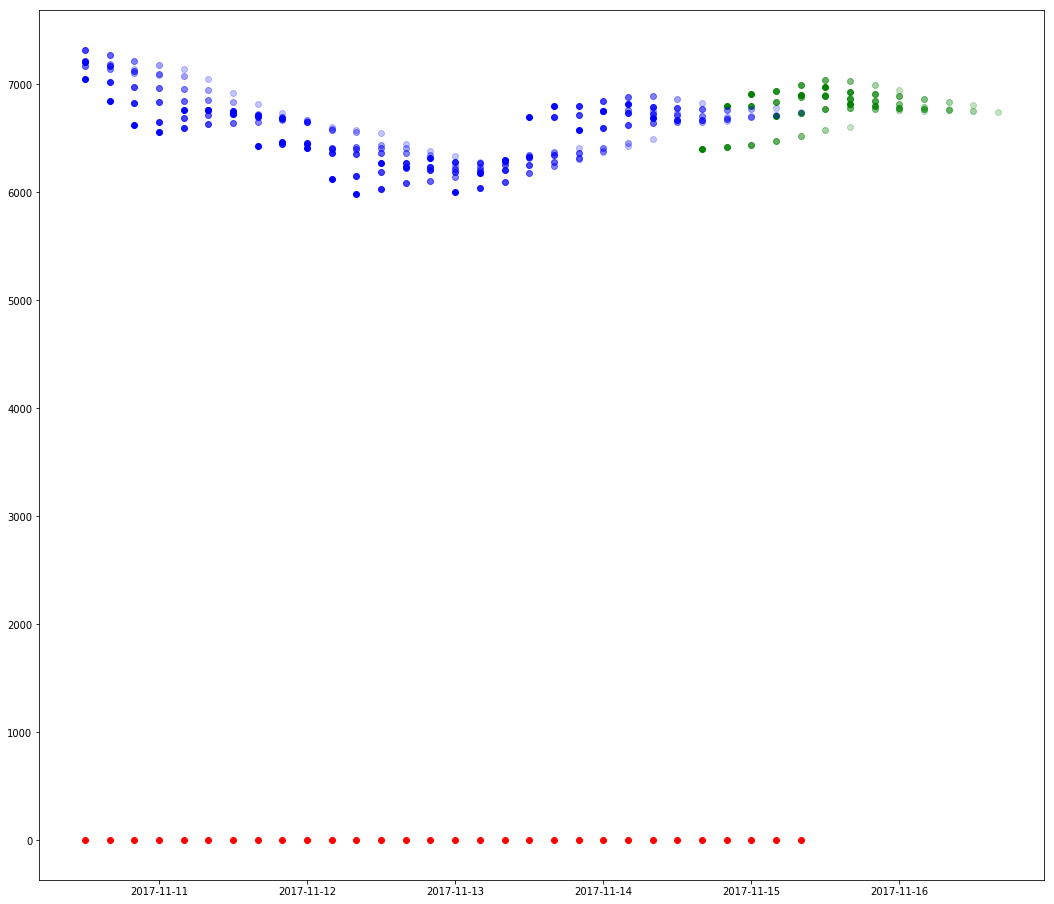

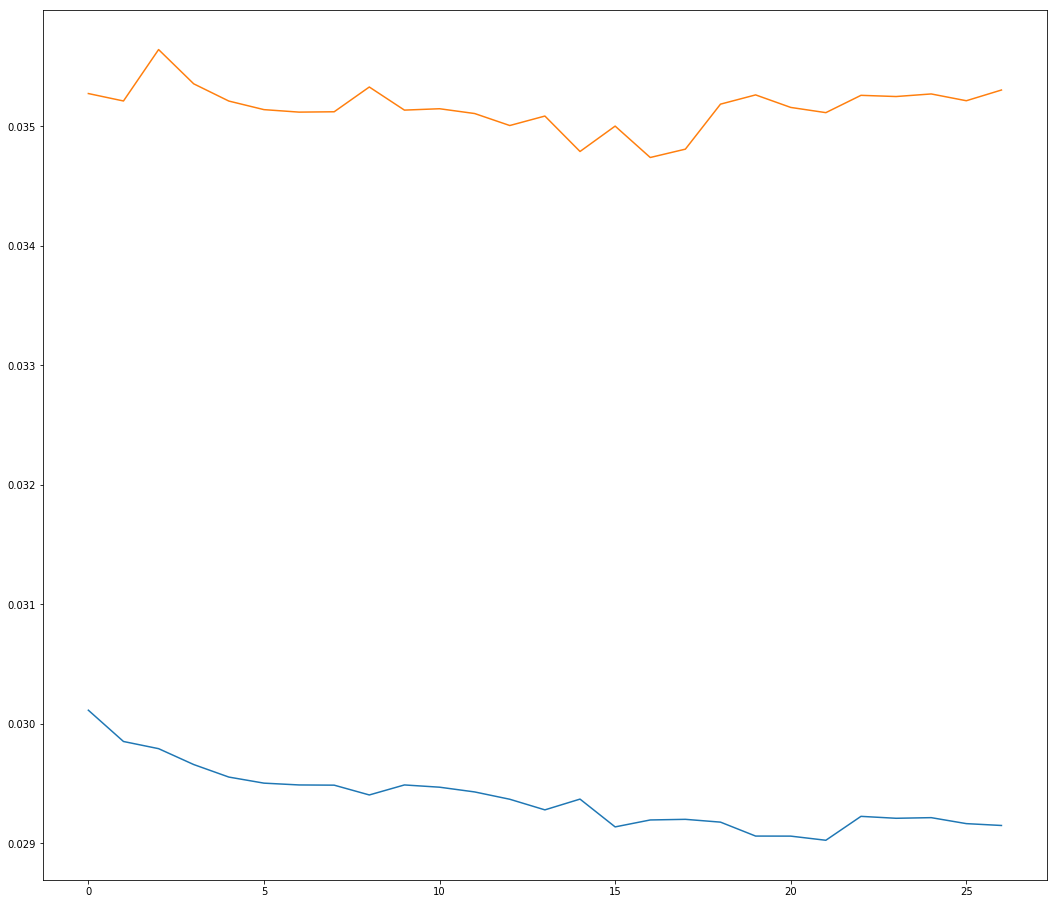

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02910 RMSE
Test Score: 0.03526 RMSE
(9004, 11)
(9011, 11)


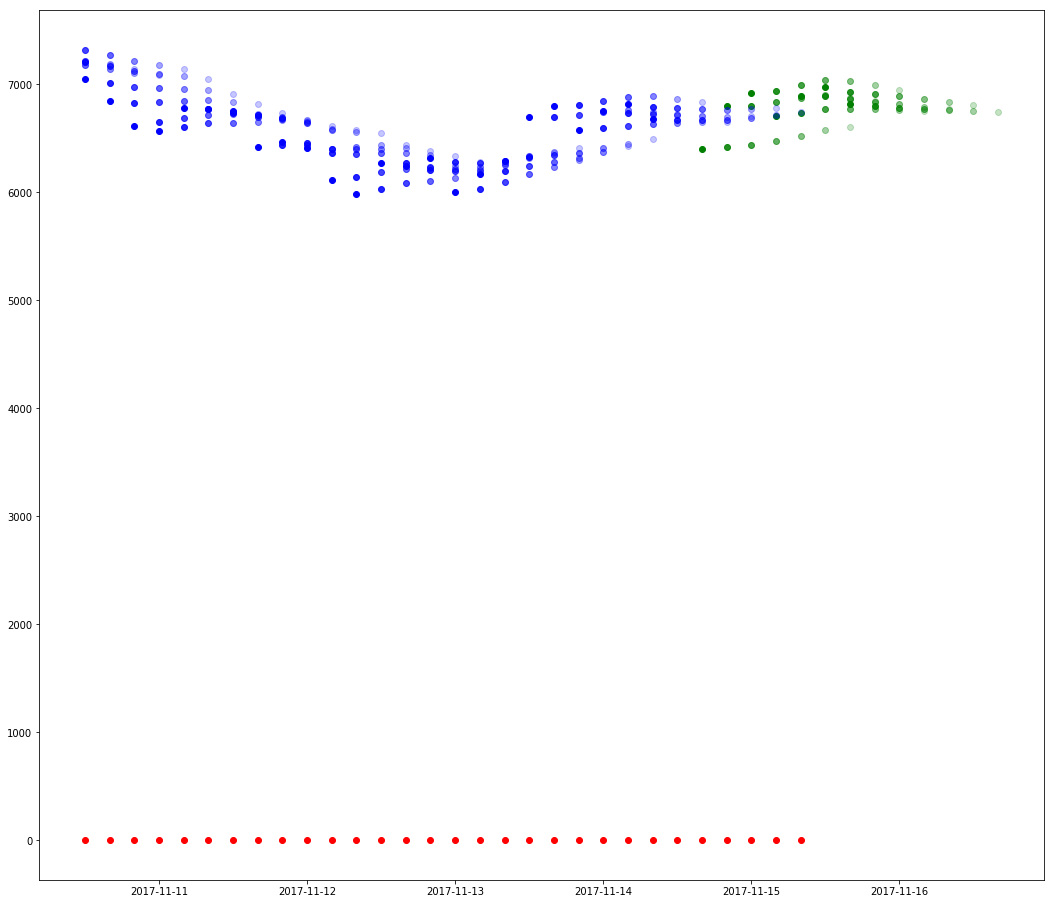

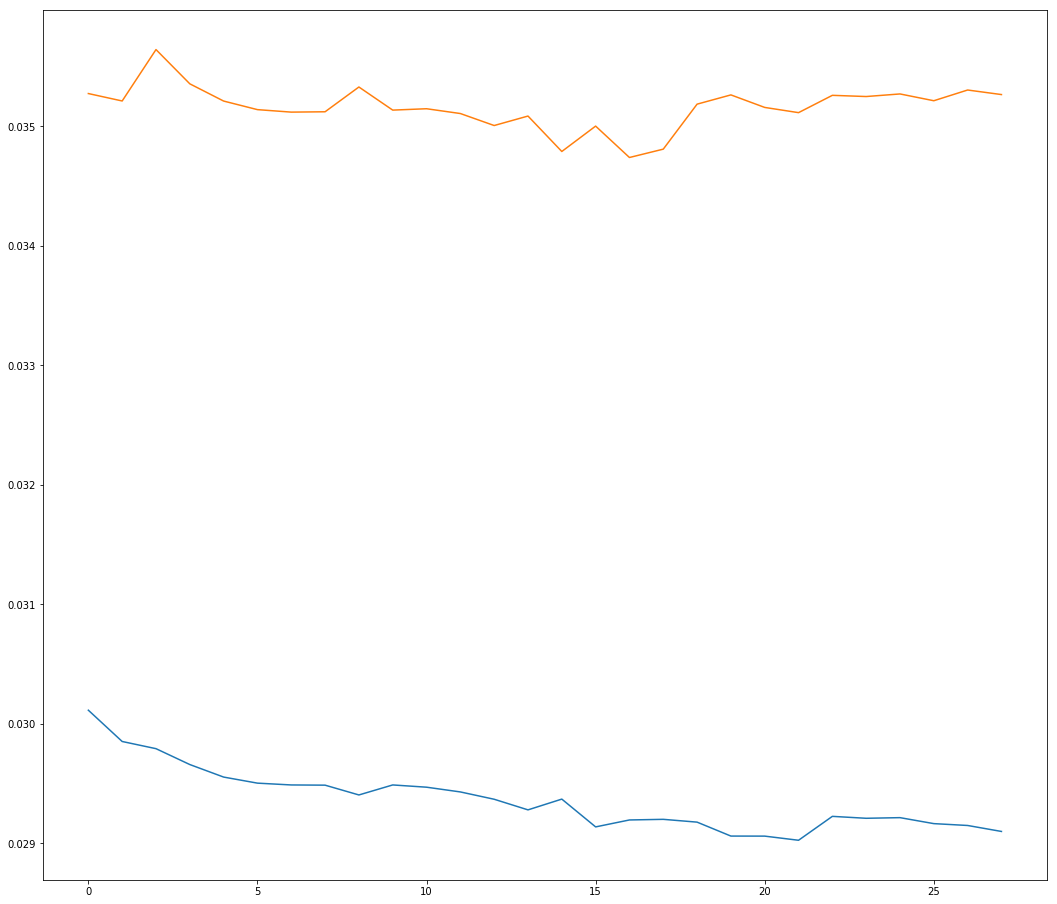

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02902 RMSE
Test Score: 0.03528 RMSE
(9004, 11)
(9011, 11)


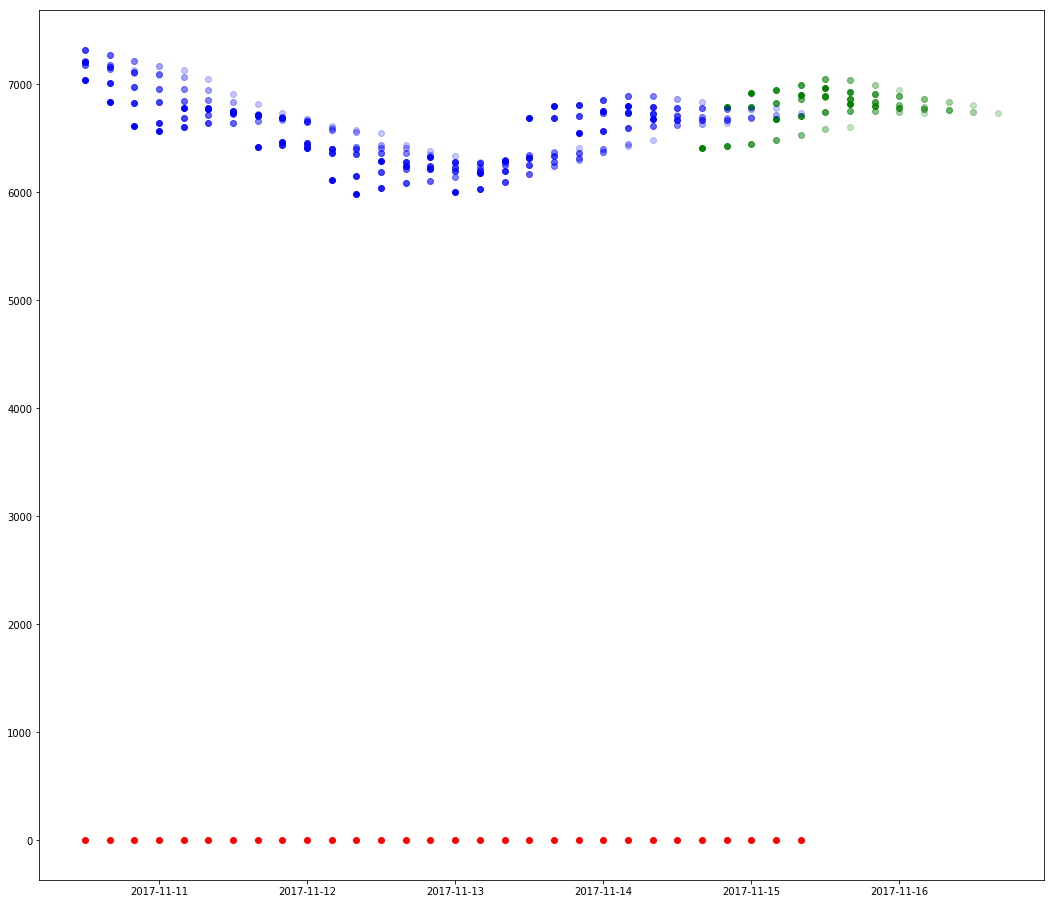

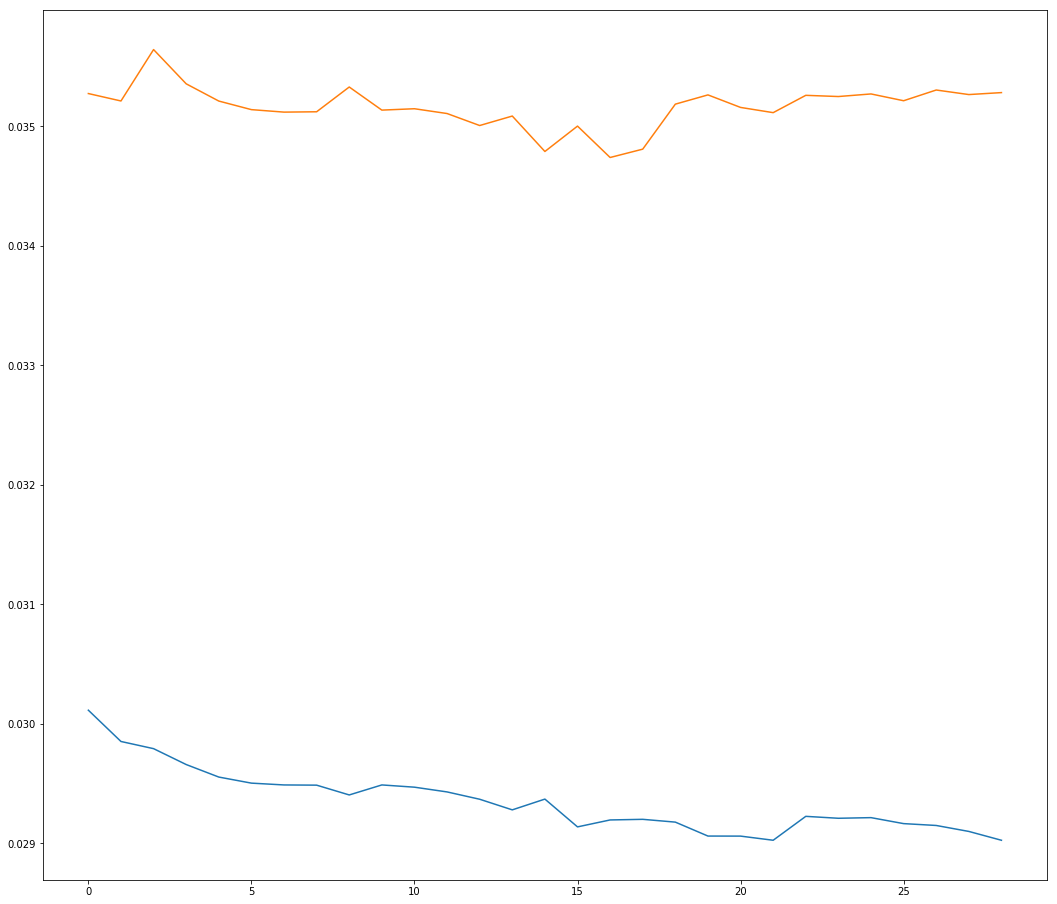

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02899 RMSE
Test Score: 0.03527 RMSE
(9004, 11)
(9011, 11)


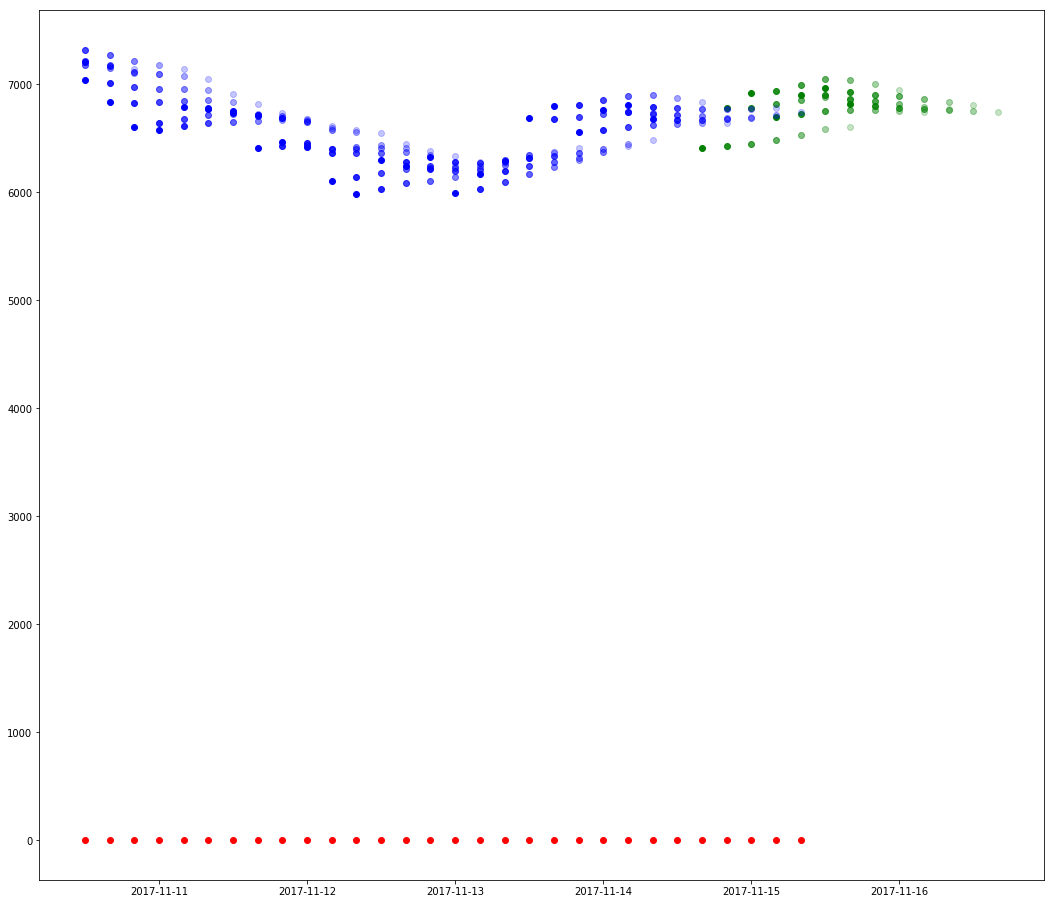

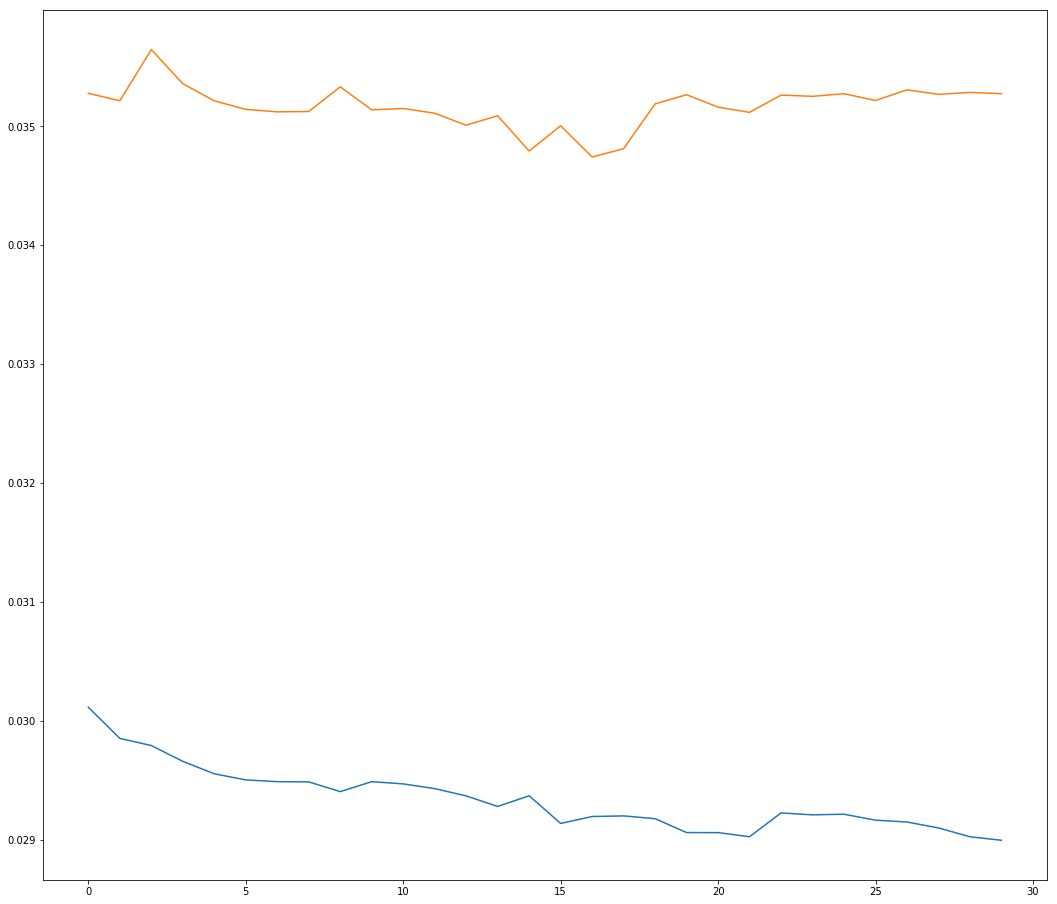

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02898 RMSE
Test Score: 0.03529 RMSE
(9004, 11)
(9011, 11)


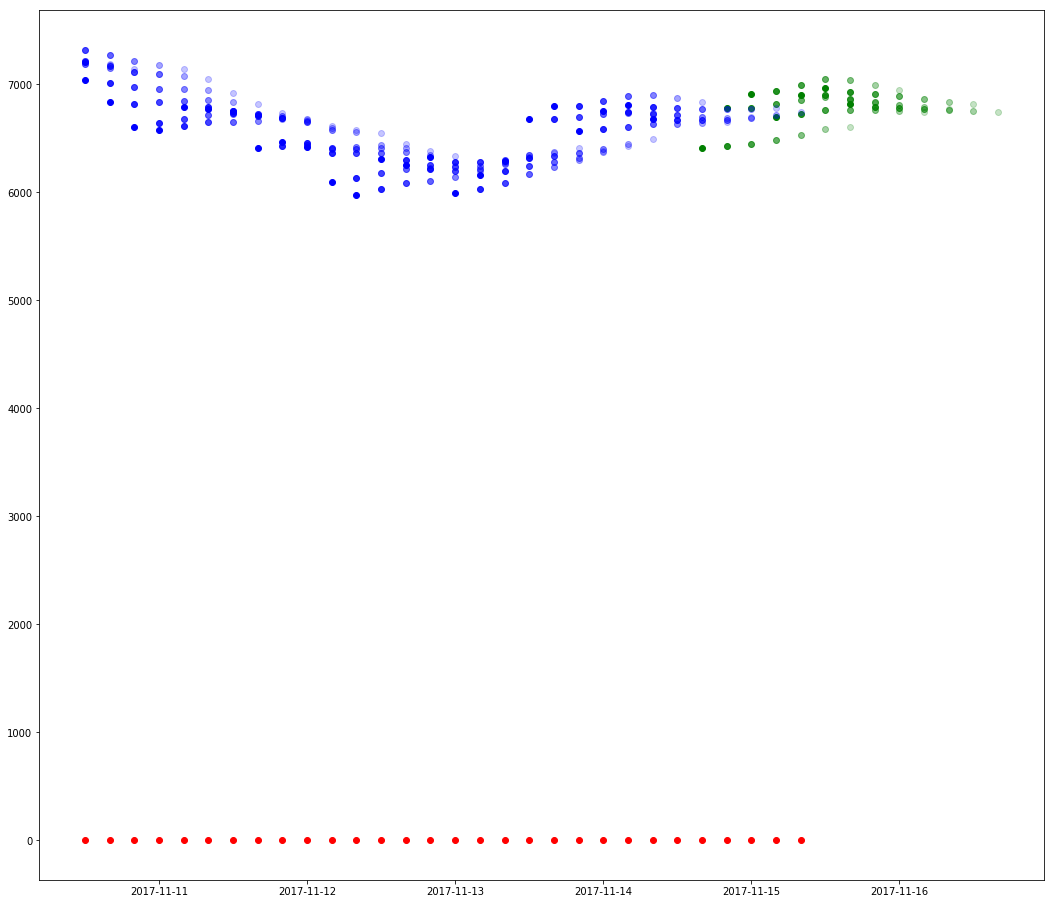

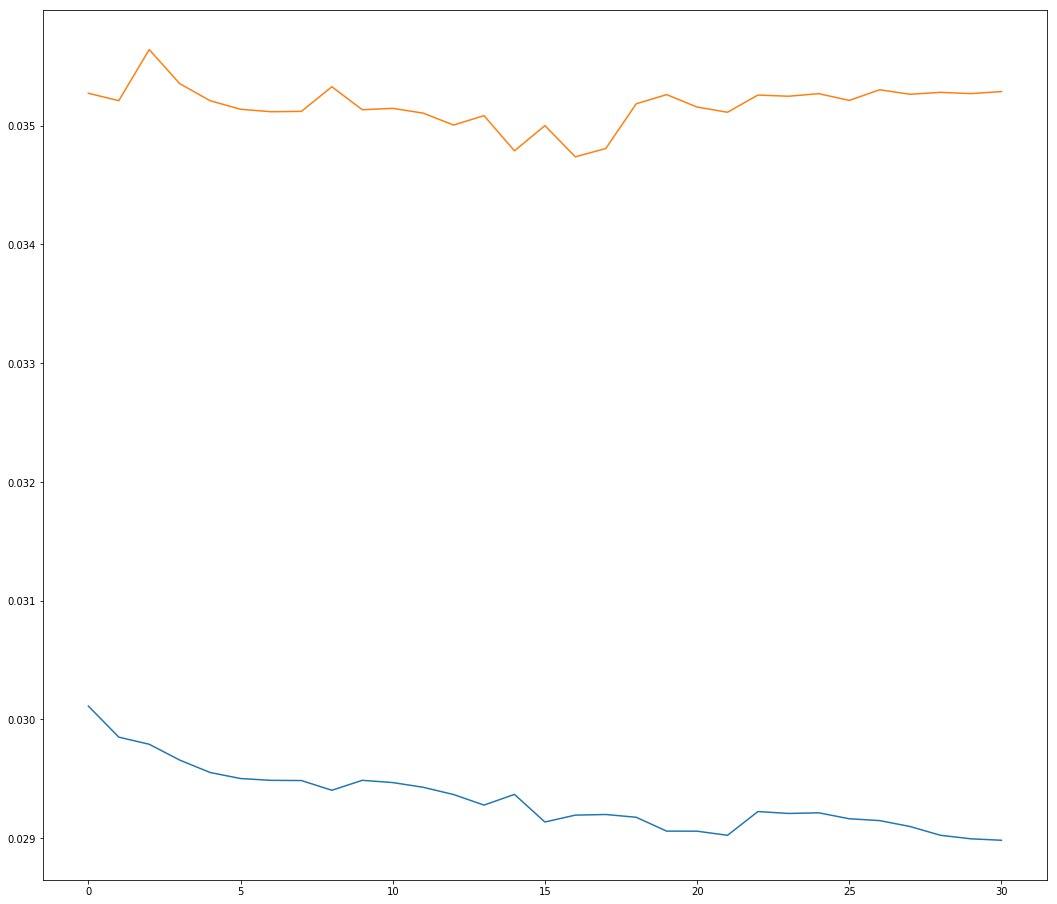

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02898 RMSE
Test Score: 0.03534 RMSE
(9004, 11)
(9011, 11)


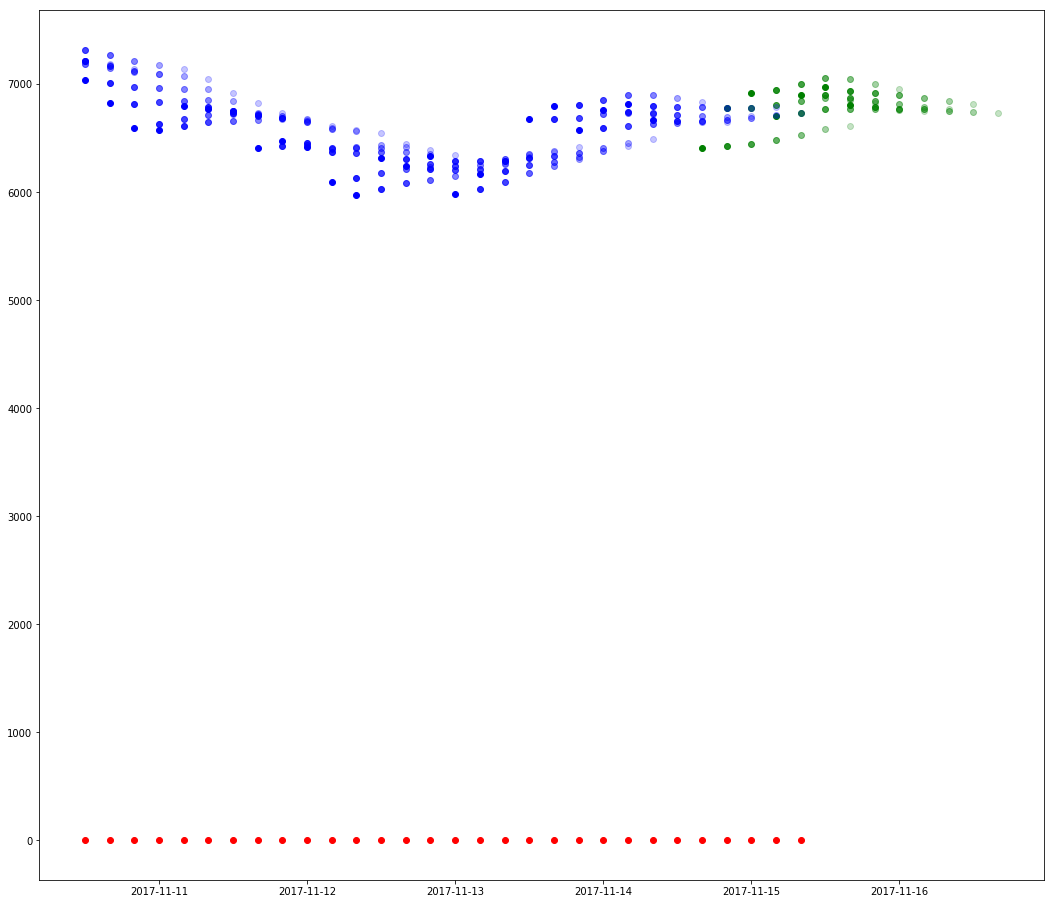

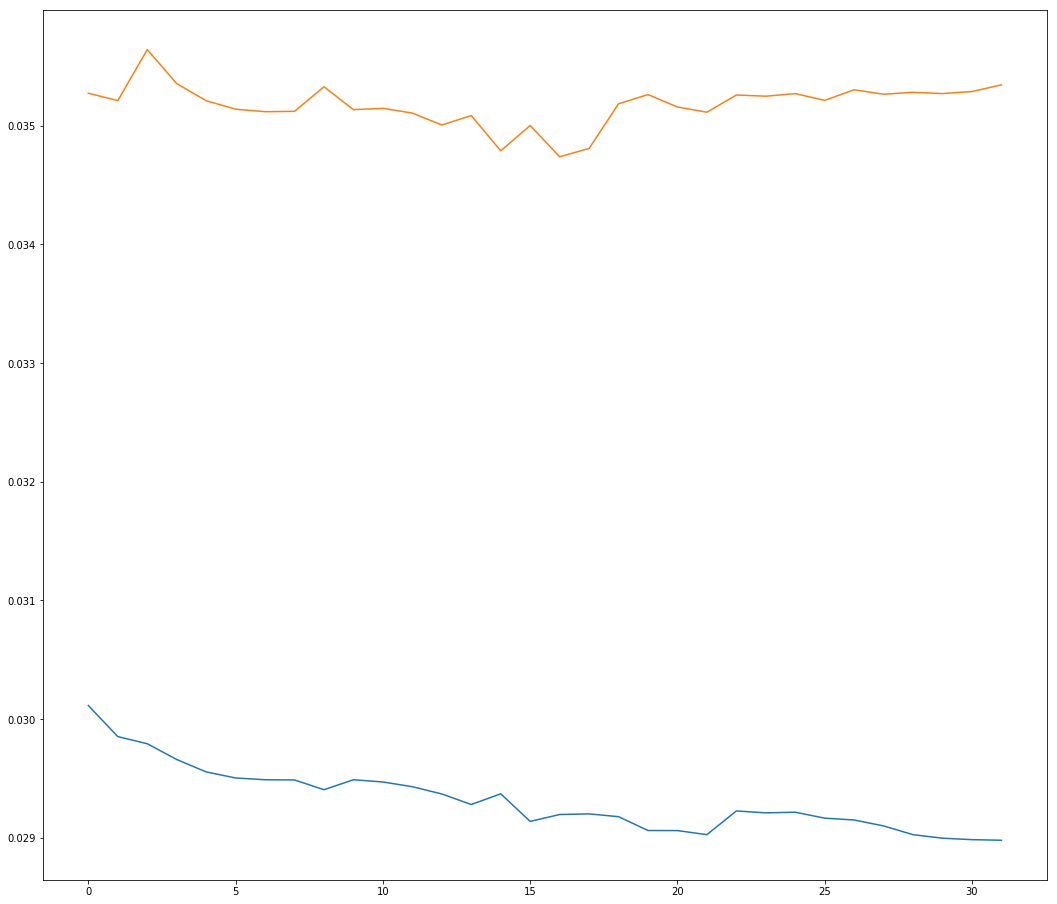

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02897 RMSE
Test Score: 0.03535 RMSE
(9004, 11)
(9011, 11)


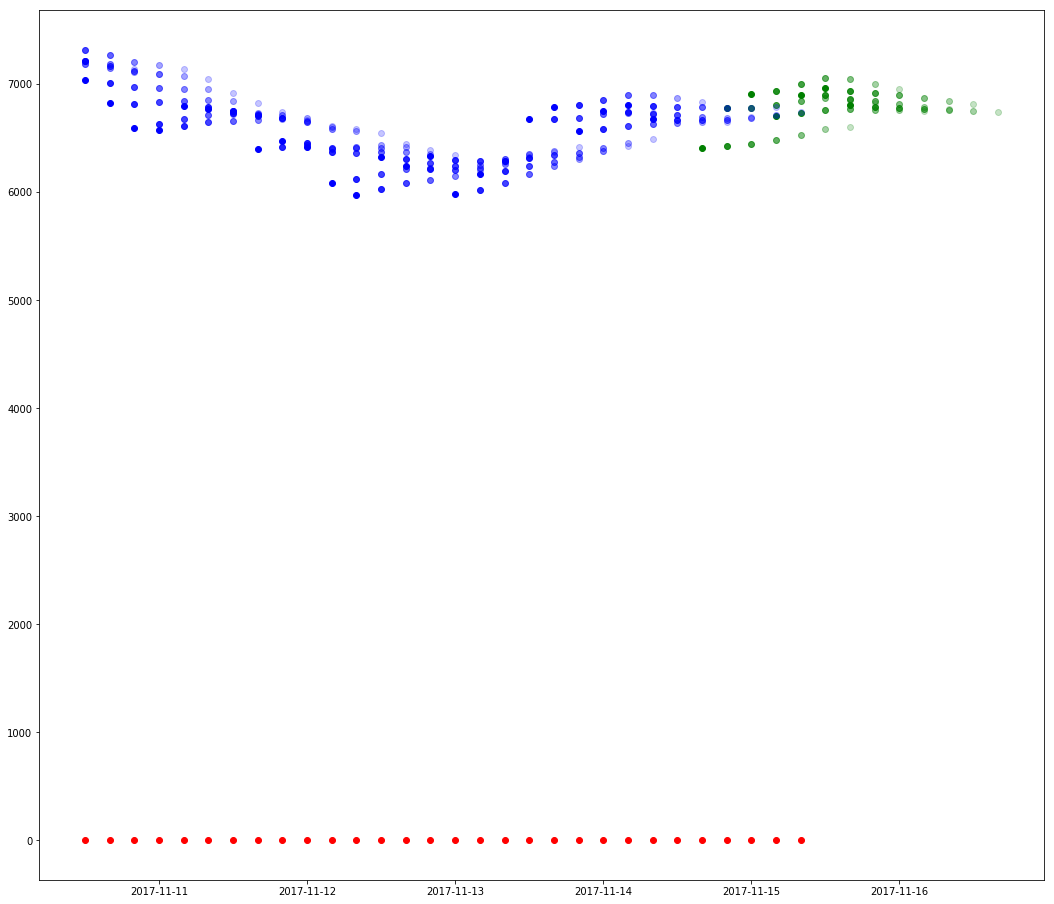

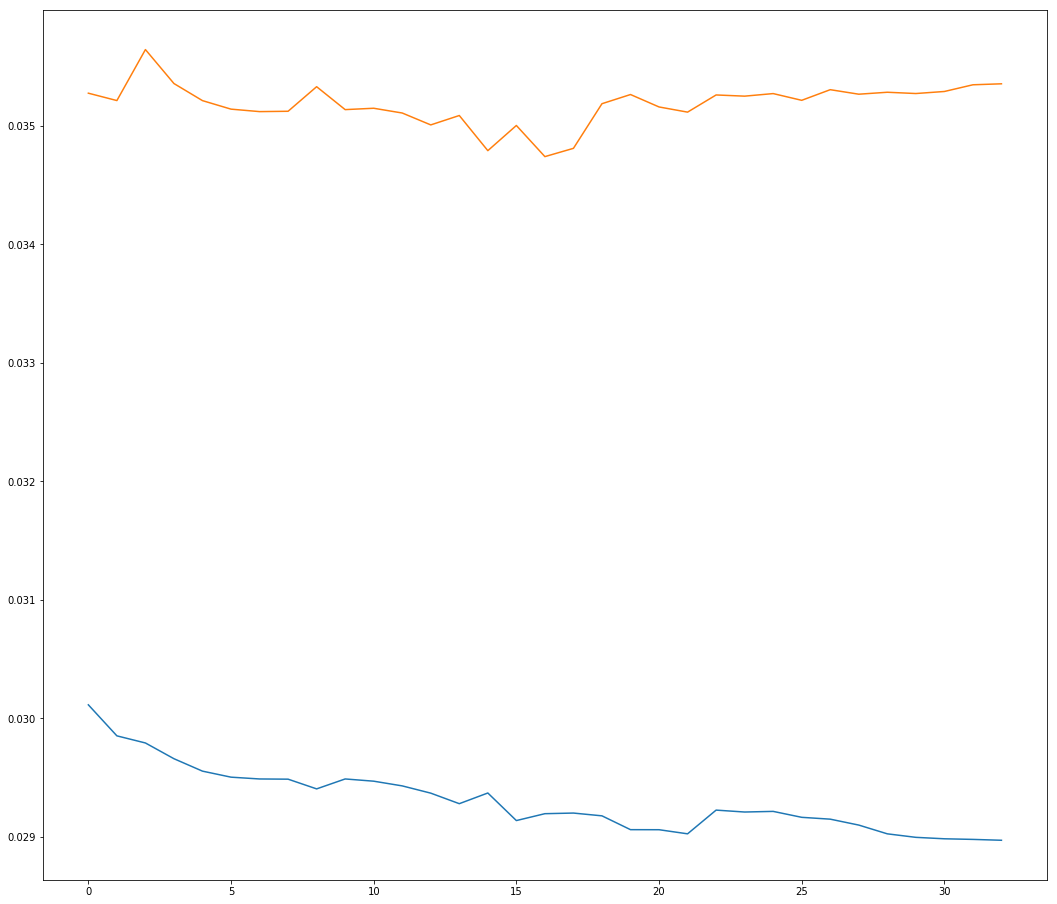

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02897 RMSE
Test Score: 0.03537 RMSE
(9004, 11)
(9011, 11)


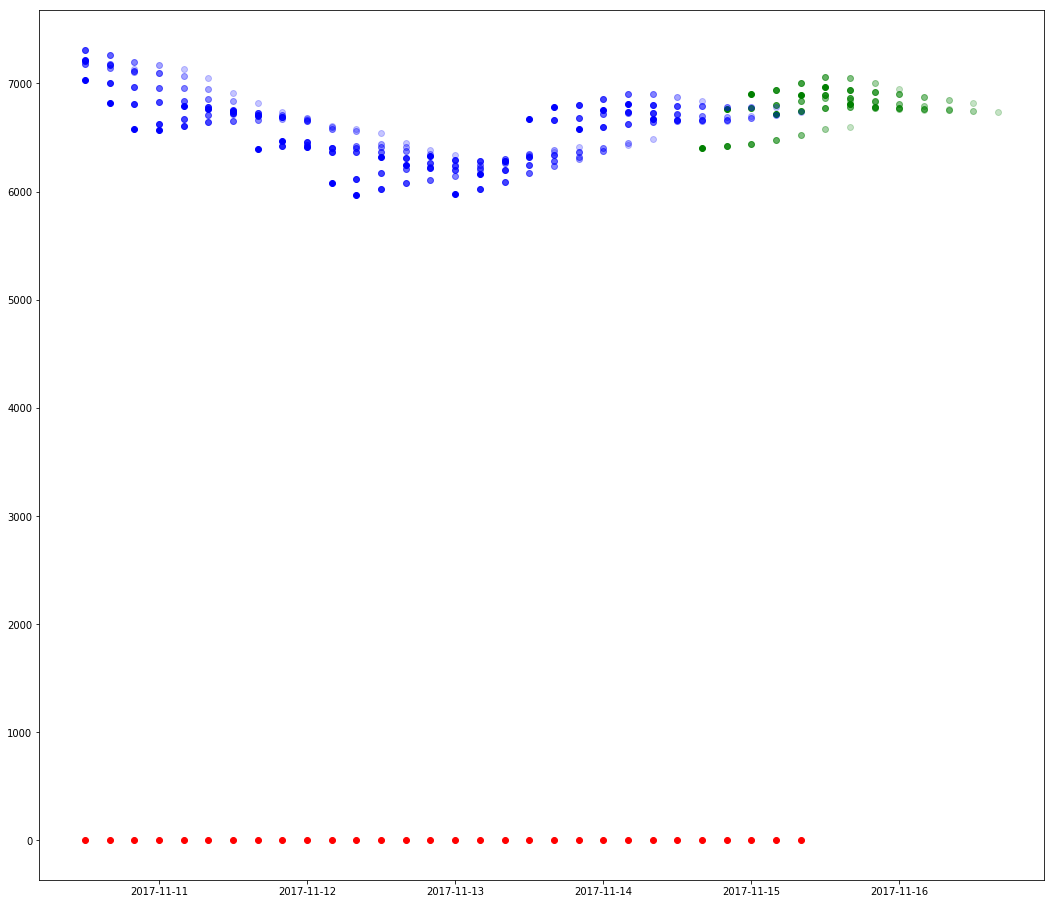

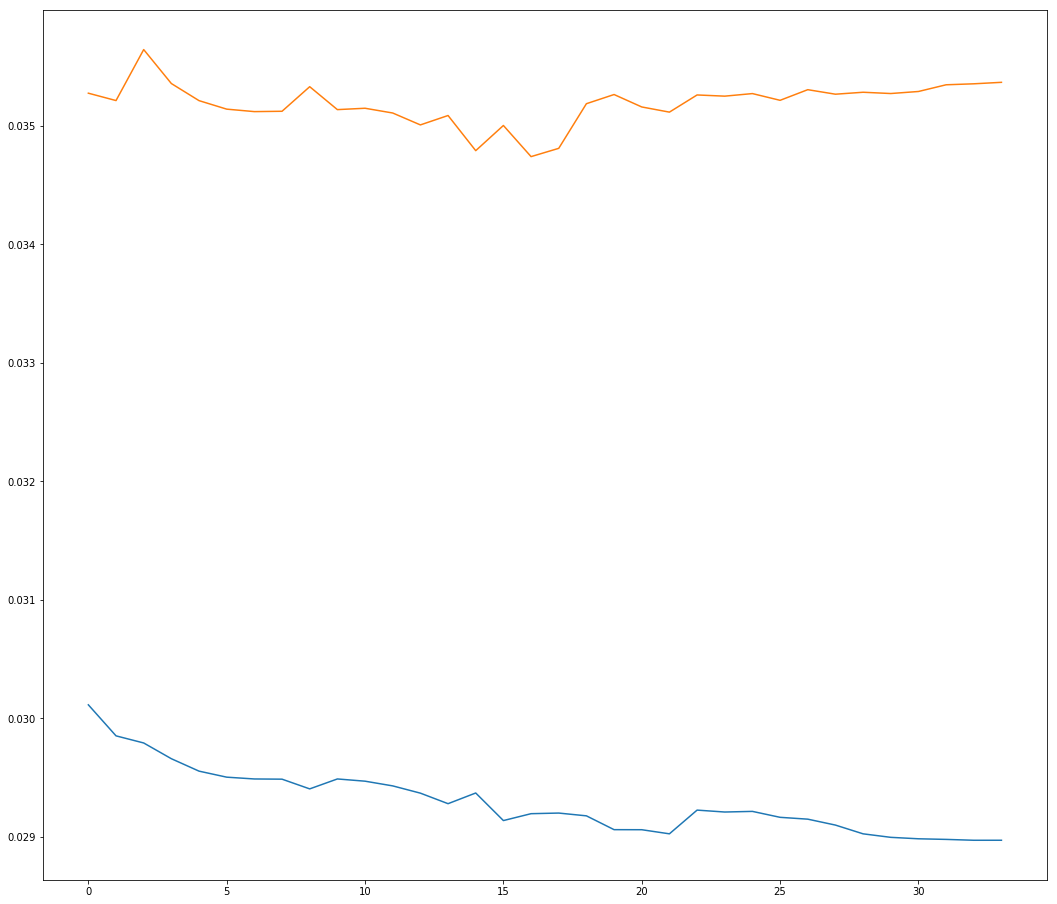

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02896 RMSE
Test Score: 0.03535 RMSE
(9004, 11)
(9011, 11)


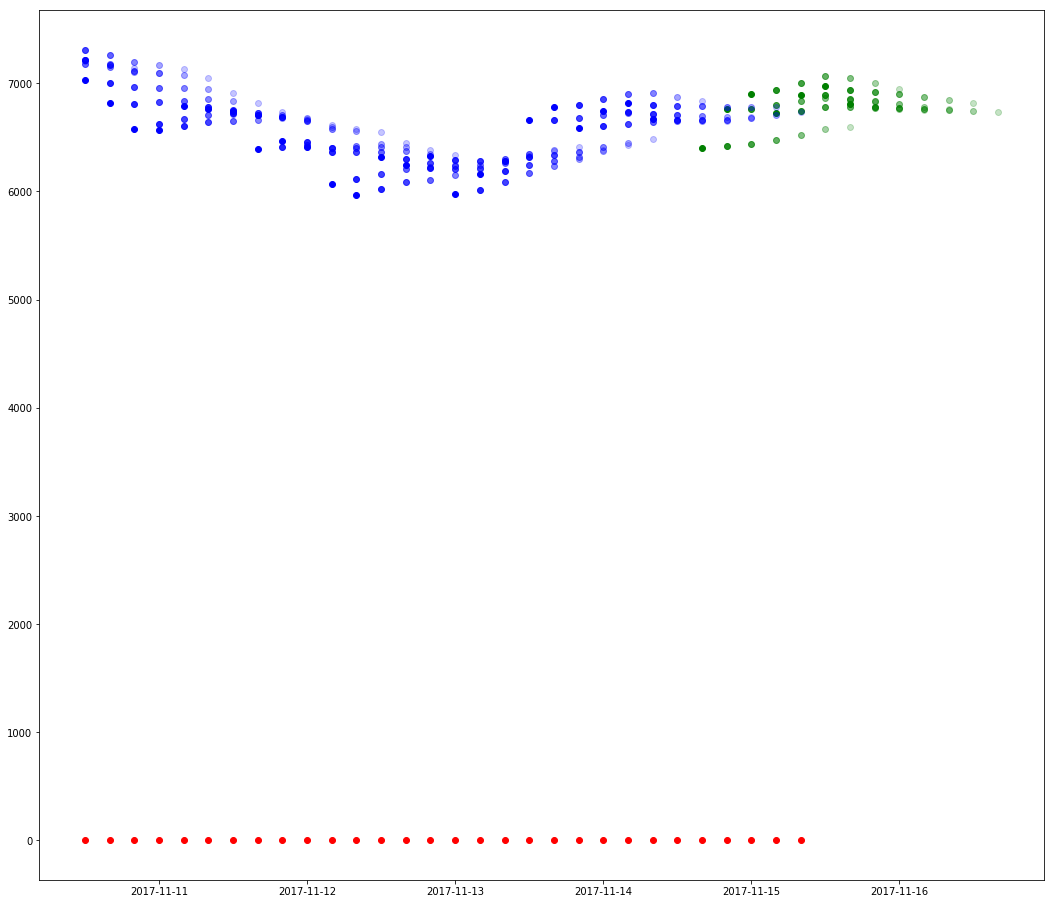

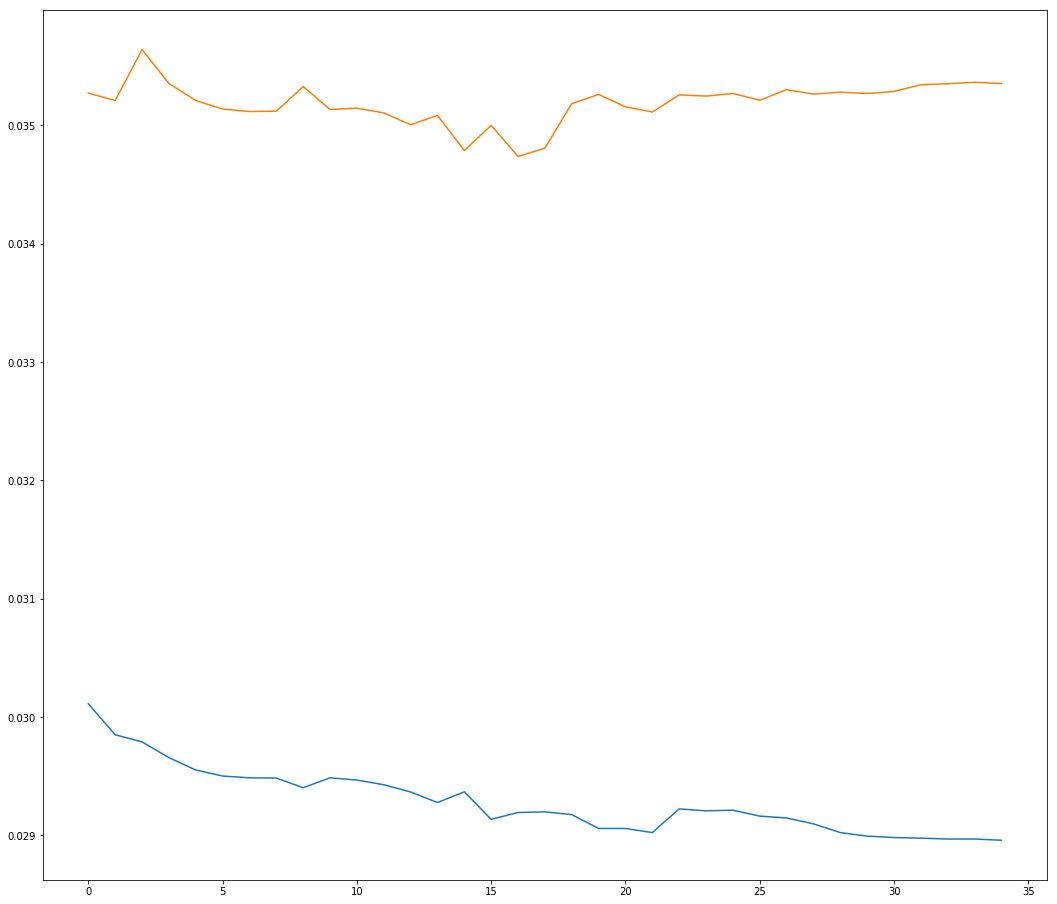

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02894 RMSE
Test Score: 0.03540 RMSE
(9004, 11)
(9011, 11)


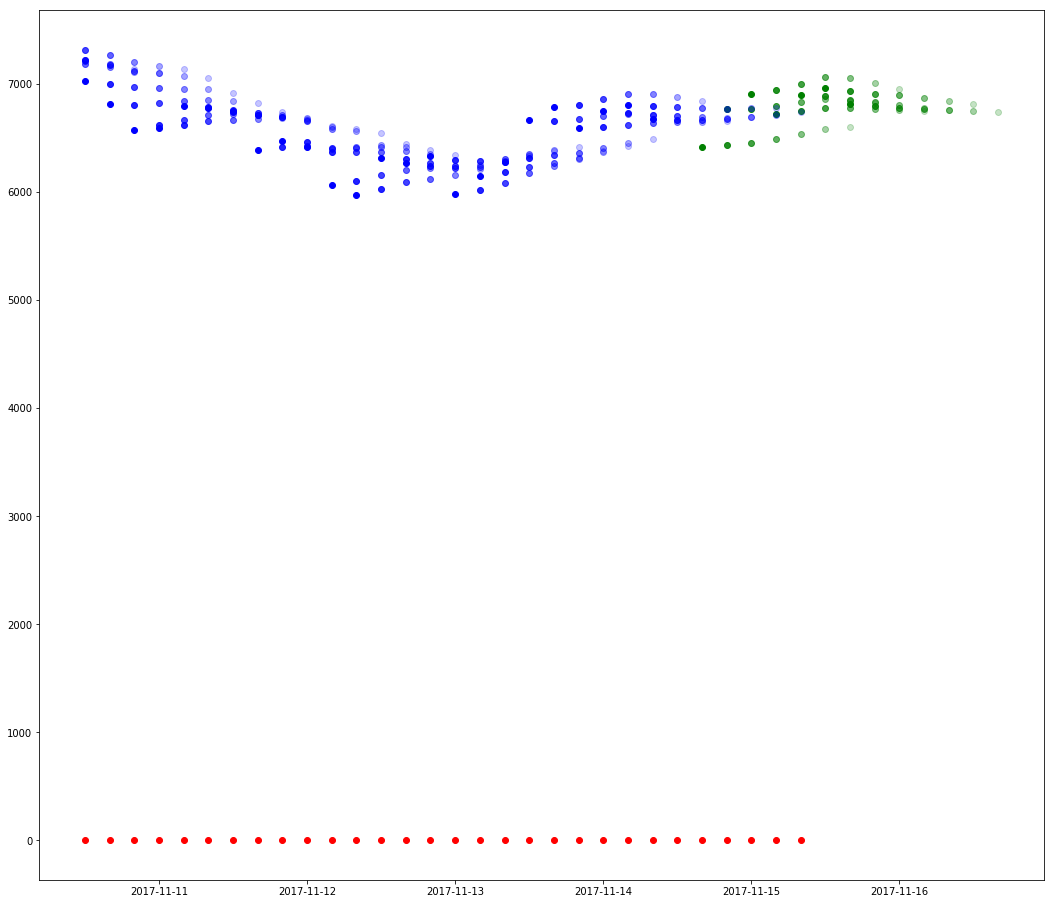

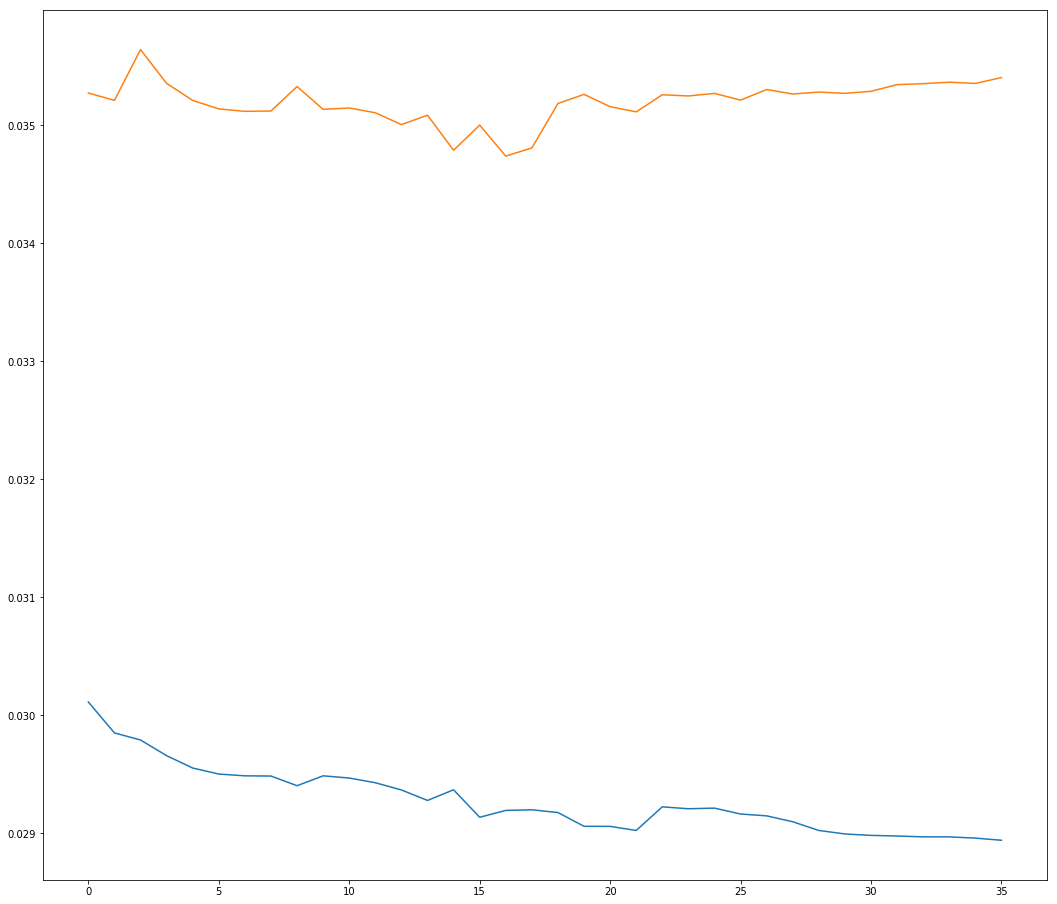

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02891 RMSE
Test Score: 0.03542 RMSE
(9004, 11)
(9011, 11)


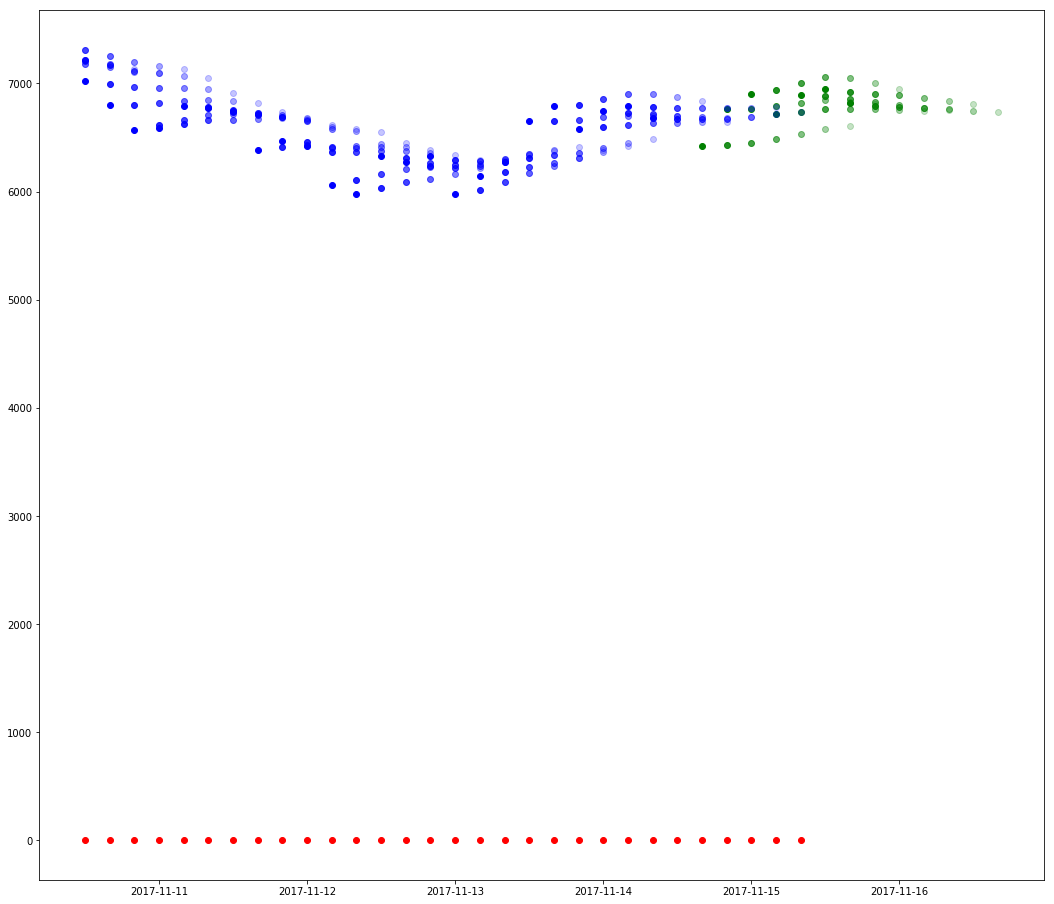

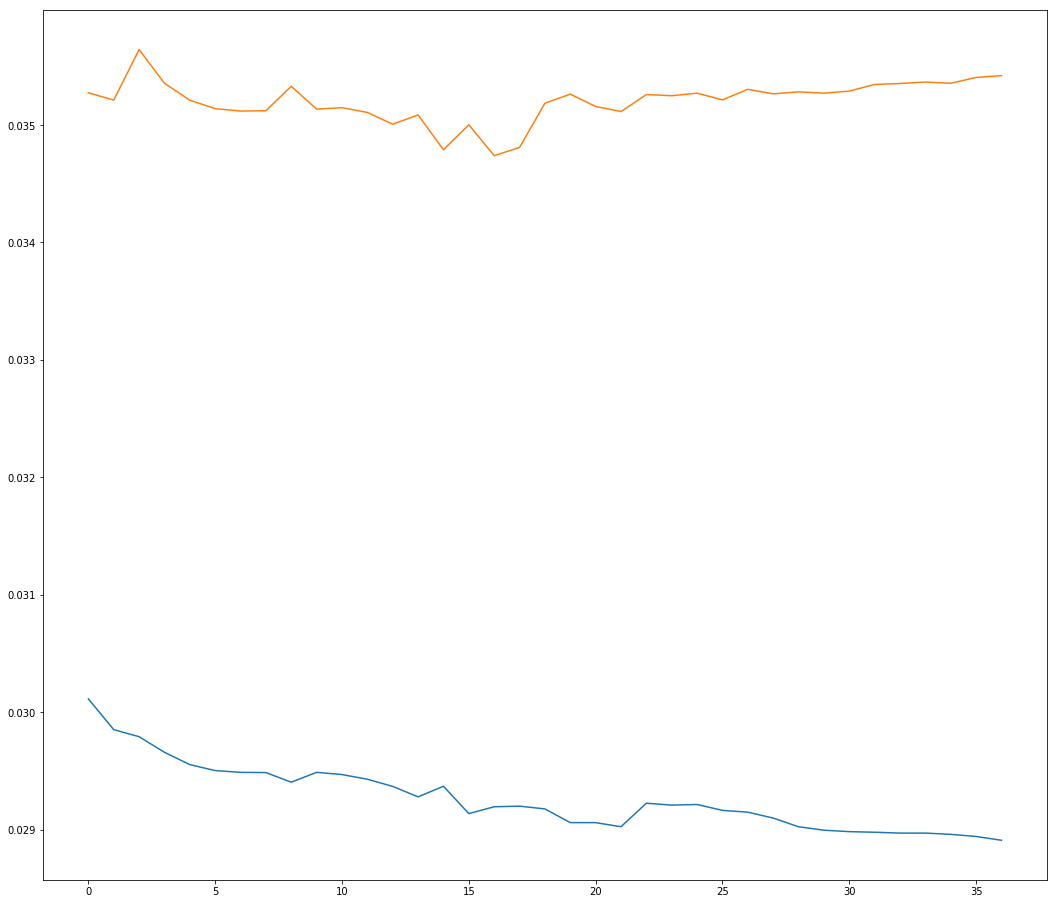

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02897 RMSE
Test Score: 0.03544 RMSE
(9004, 11)
(9011, 11)


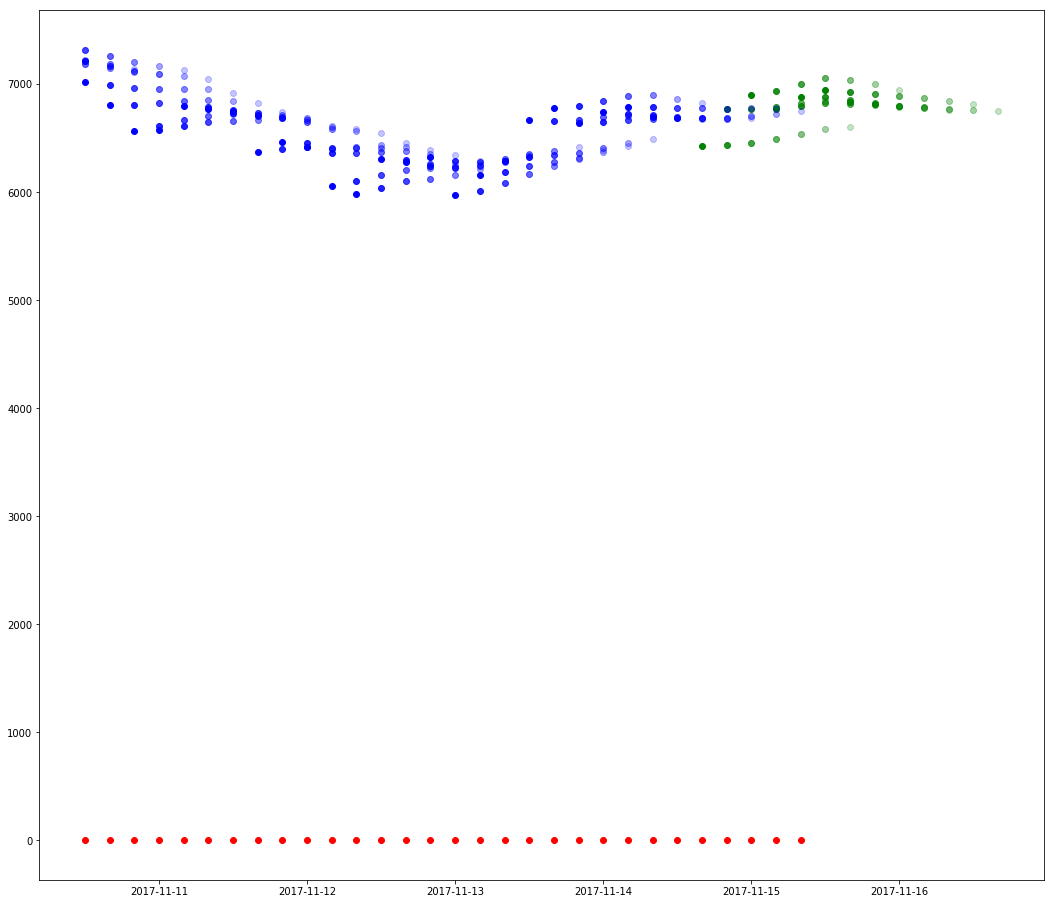

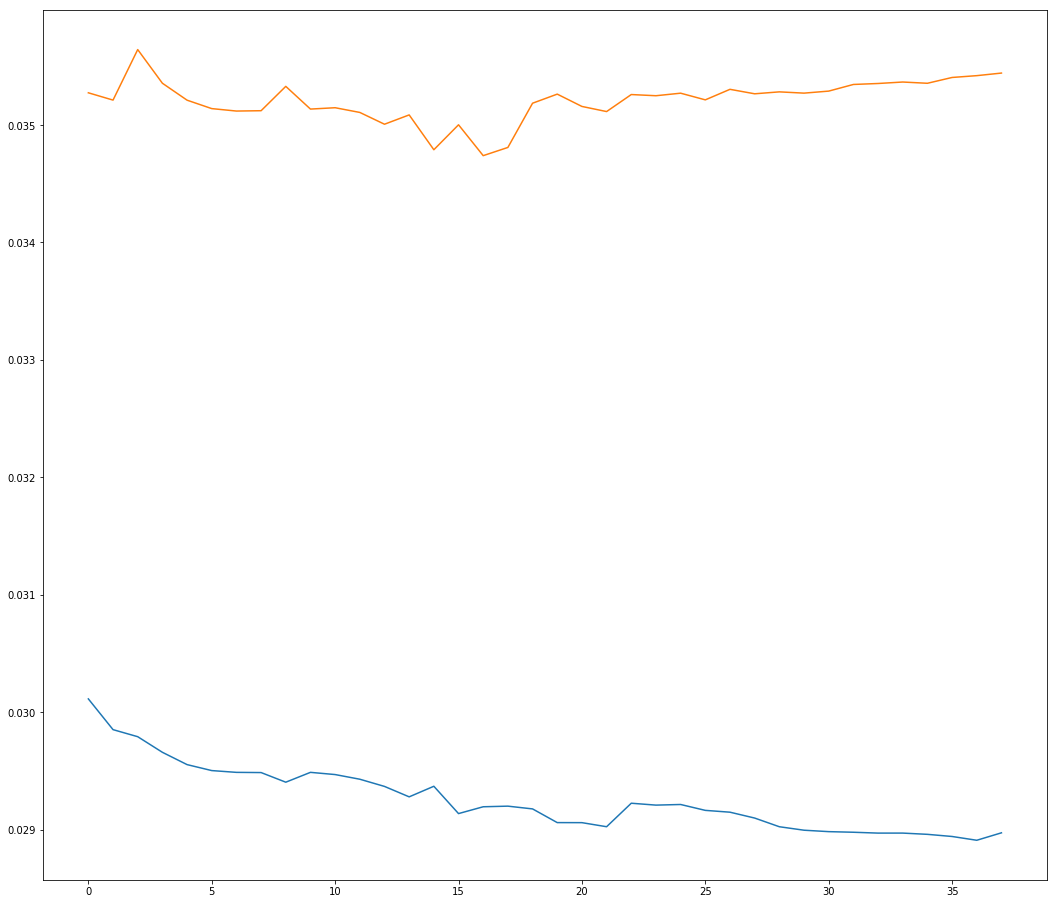

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02899 RMSE
Test Score: 0.03547 RMSE
(9004, 11)
(9011, 11)


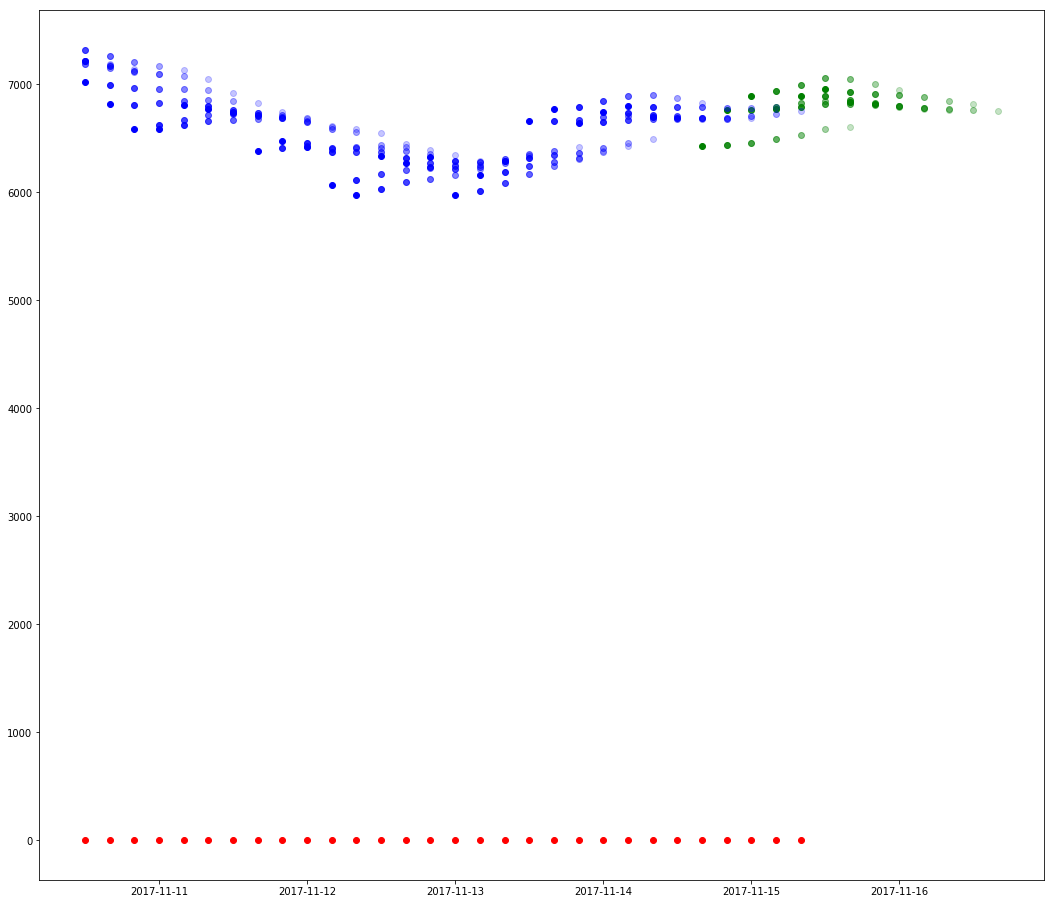

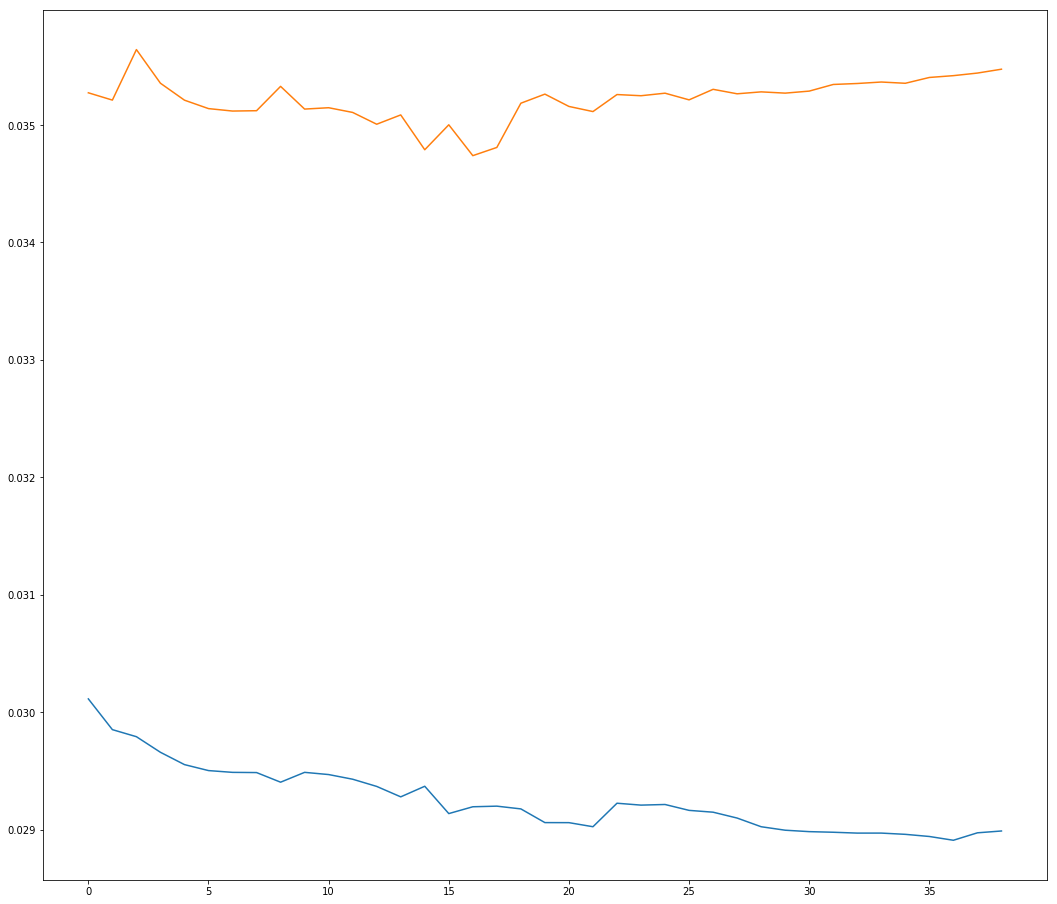

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02898 RMSE
Test Score: 0.03545 RMSE
(9004, 11)
(9011, 11)


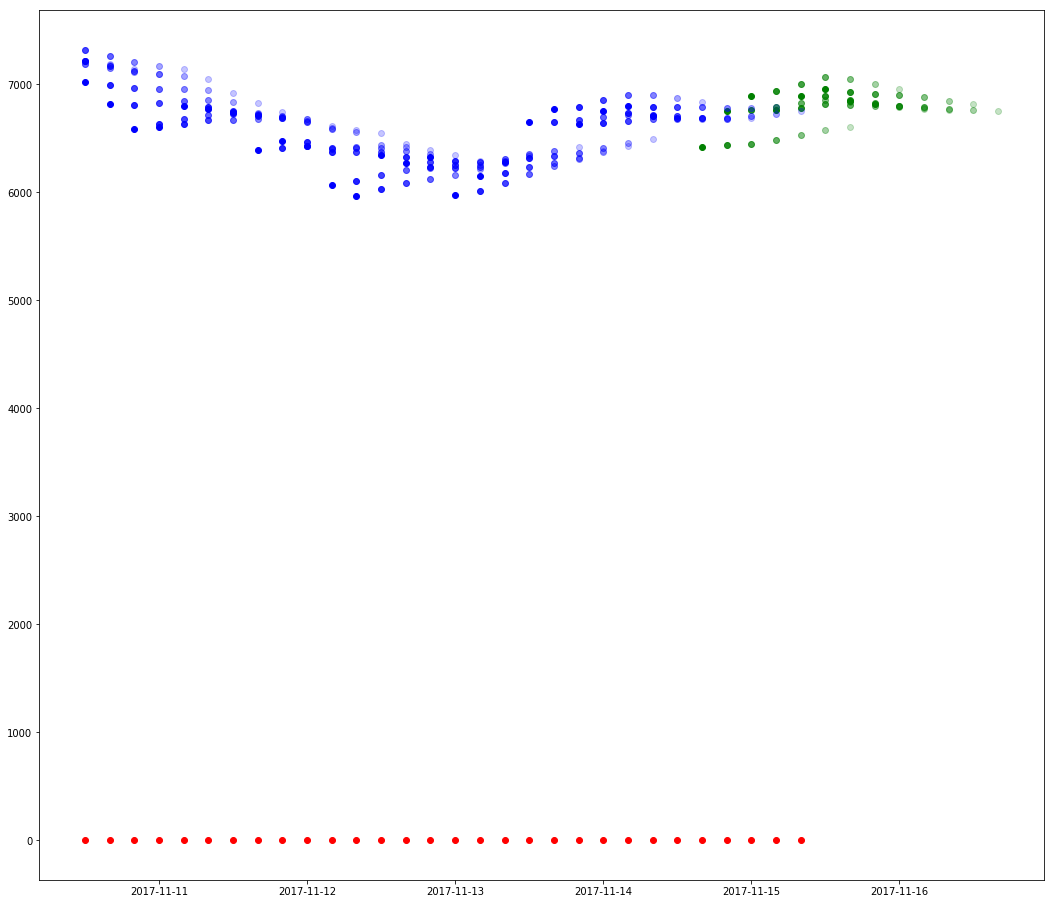

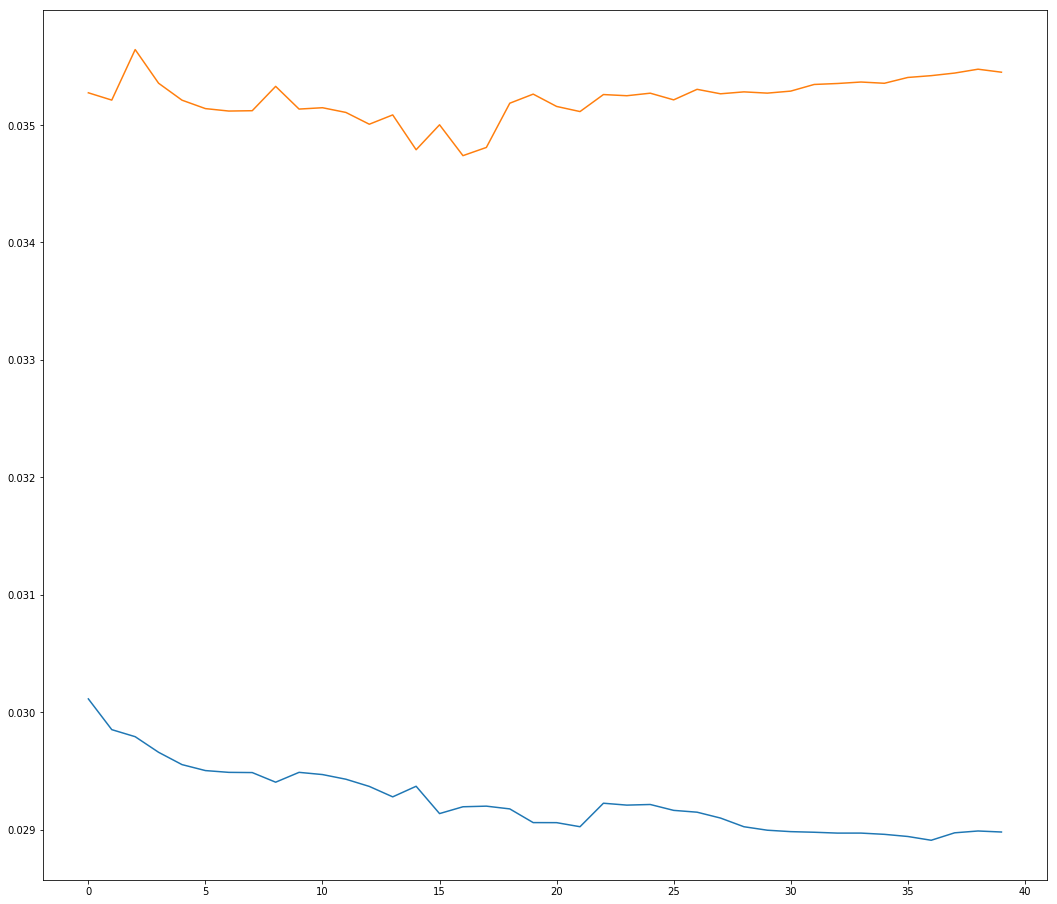

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02895 RMSE
Test Score: 0.03540 RMSE
(9004, 11)
(9011, 11)


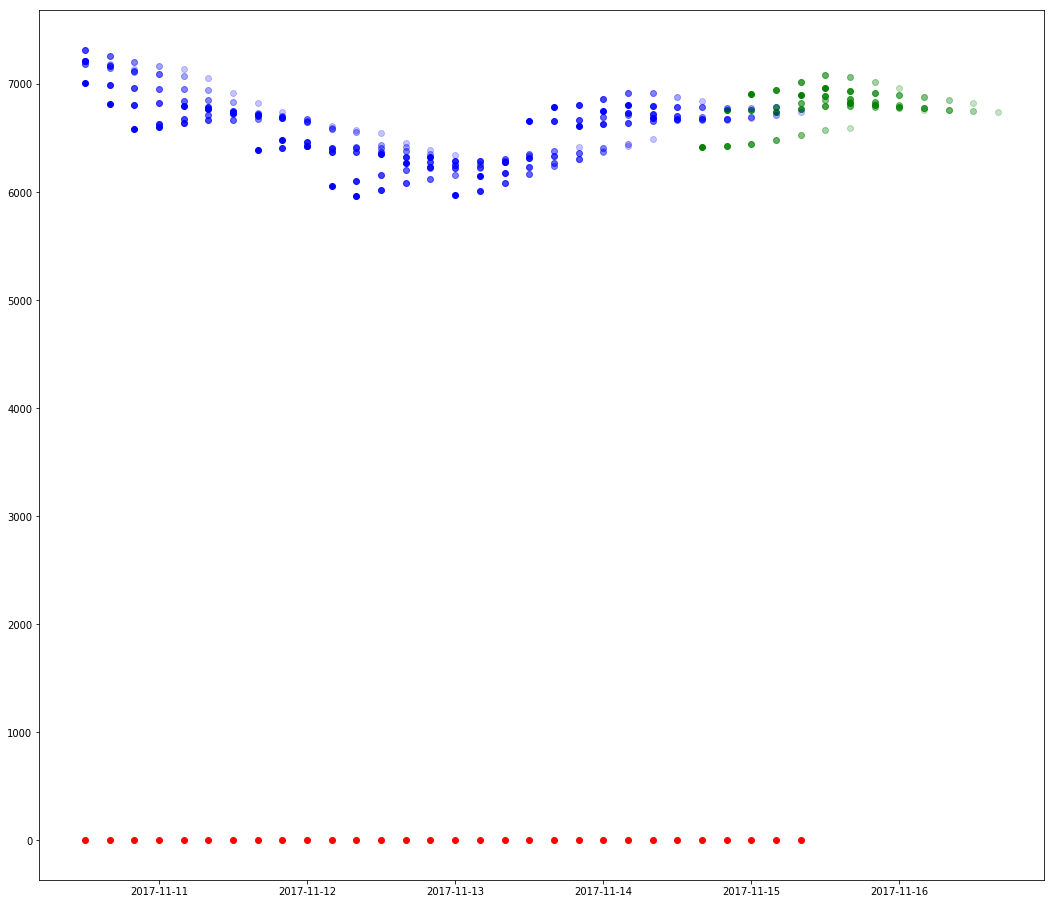

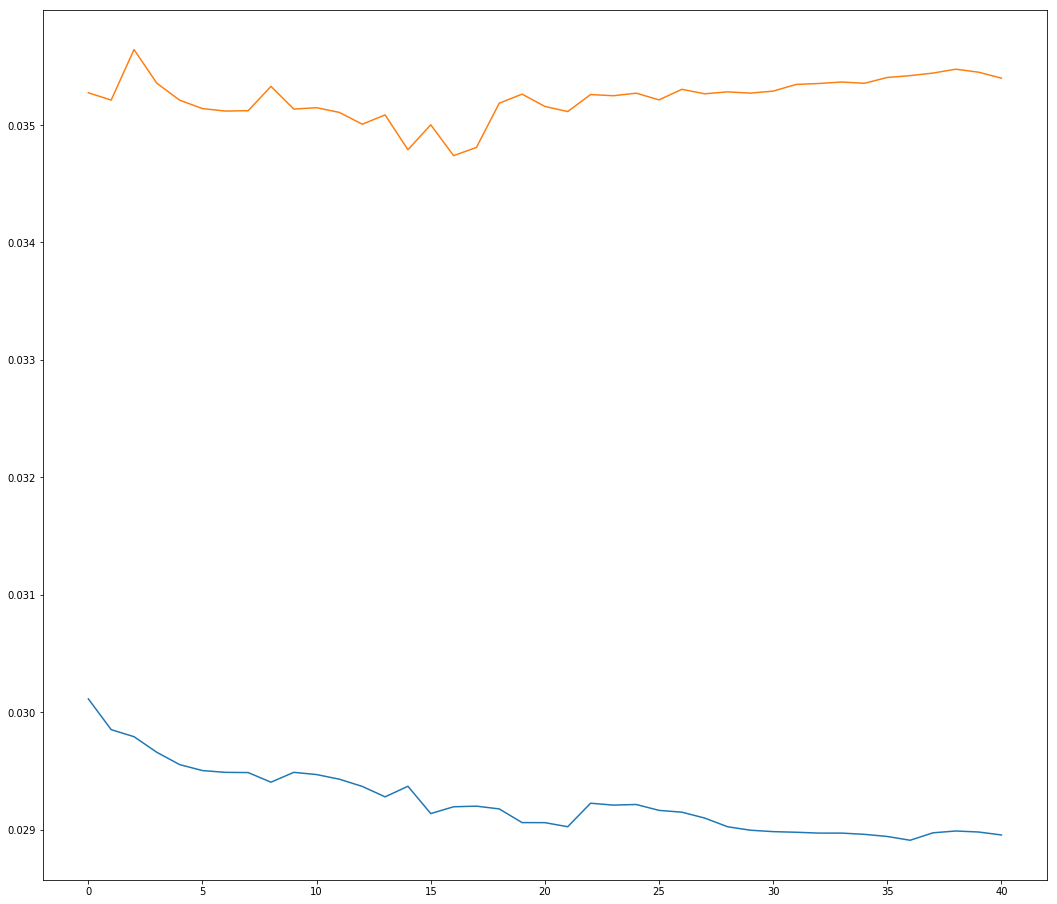

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02894 RMSE
Test Score: 0.03538 RMSE
(9004, 11)
(9011, 11)


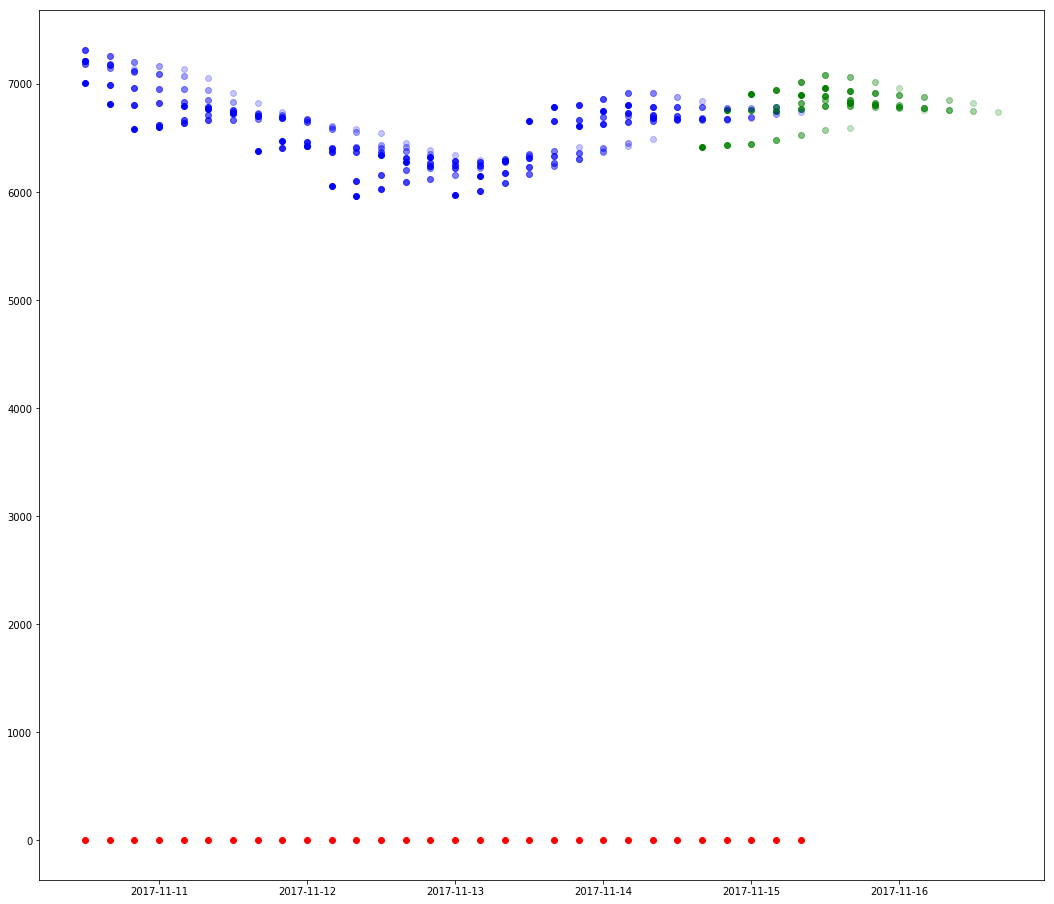

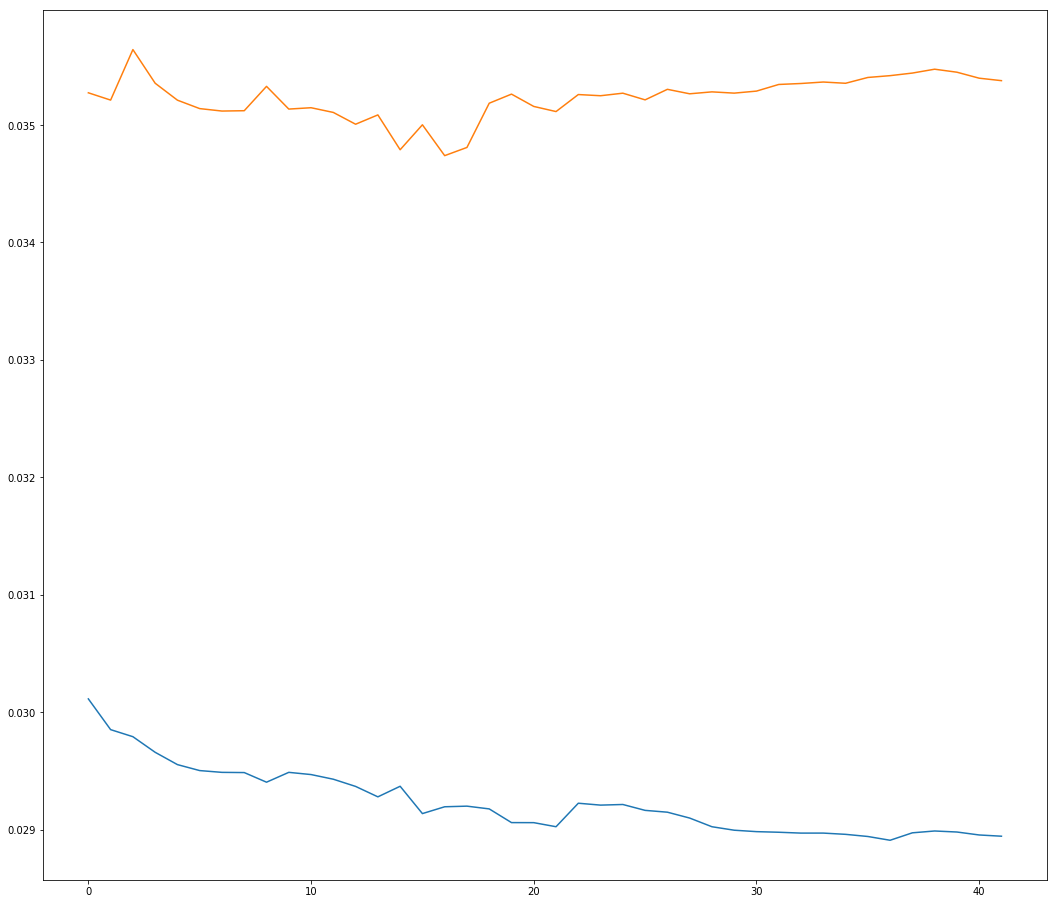

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02896 RMSE
Test Score: 0.03545 RMSE
(9004, 11)
(9011, 11)


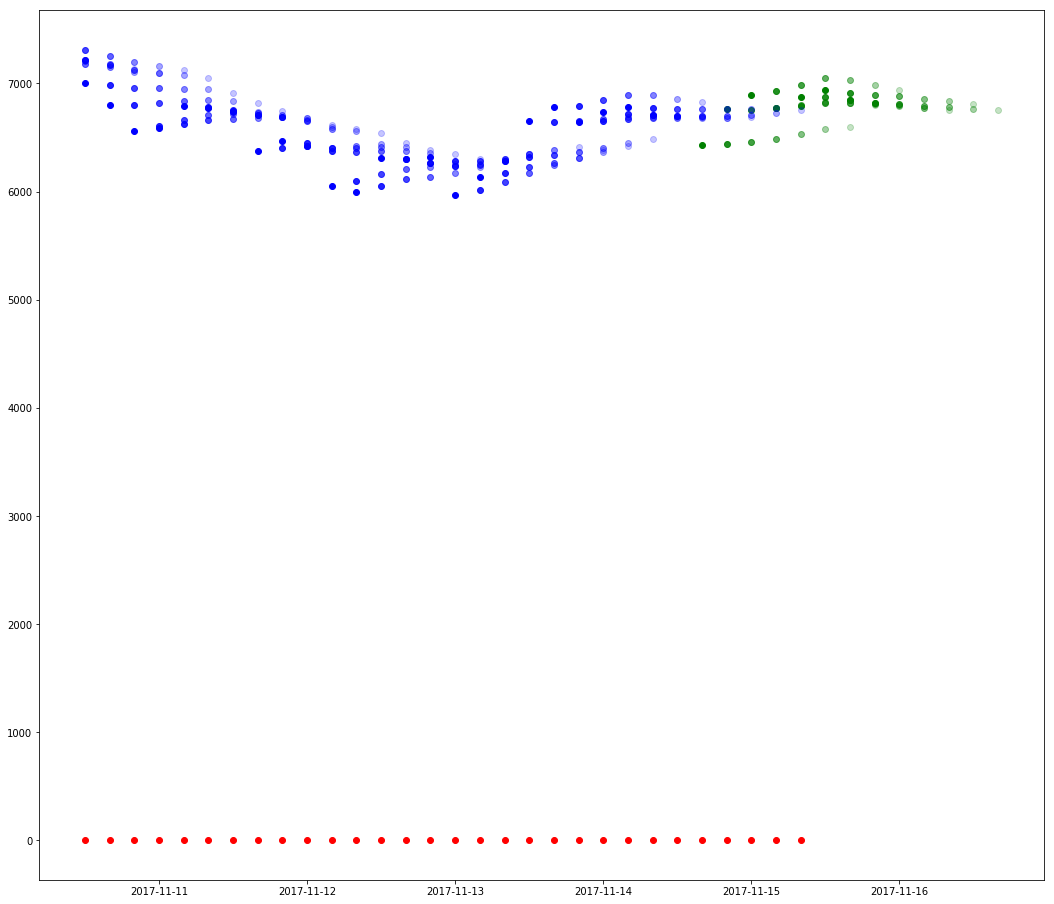

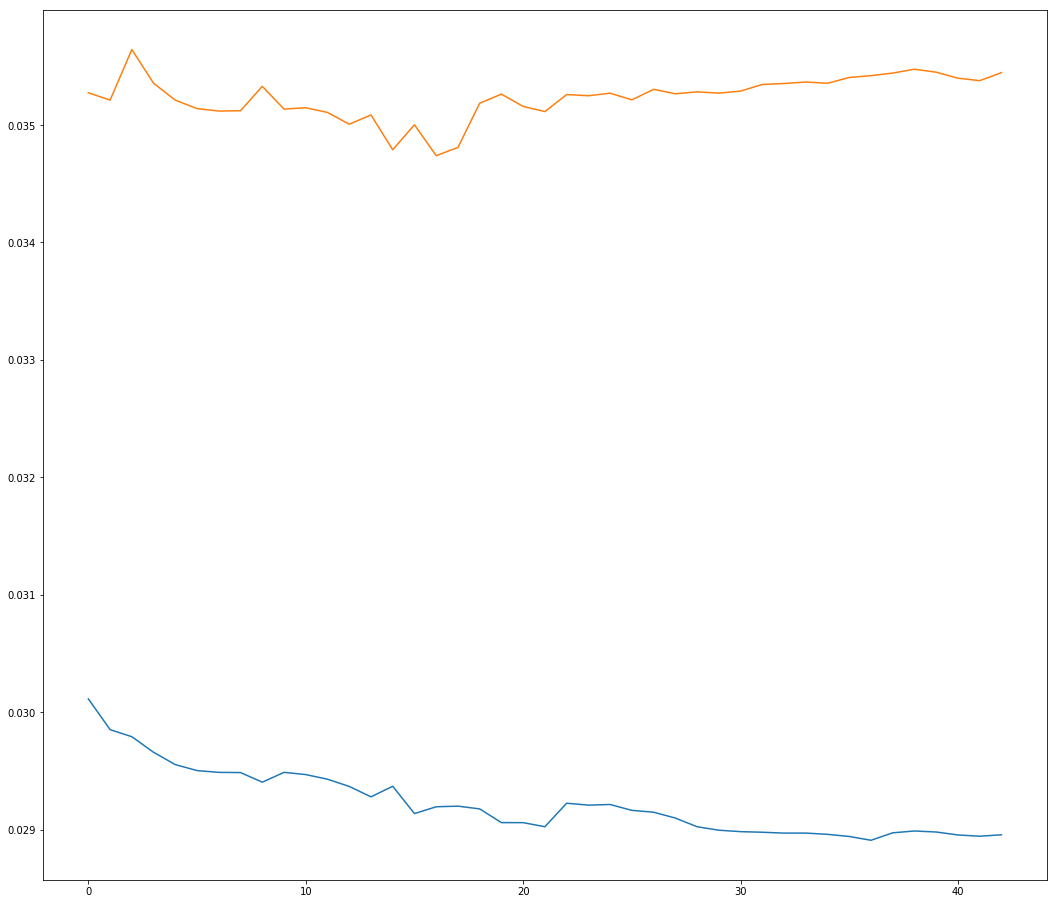

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02895 RMSE
Test Score: 0.03543 RMSE
(9004, 11)
(9011, 11)


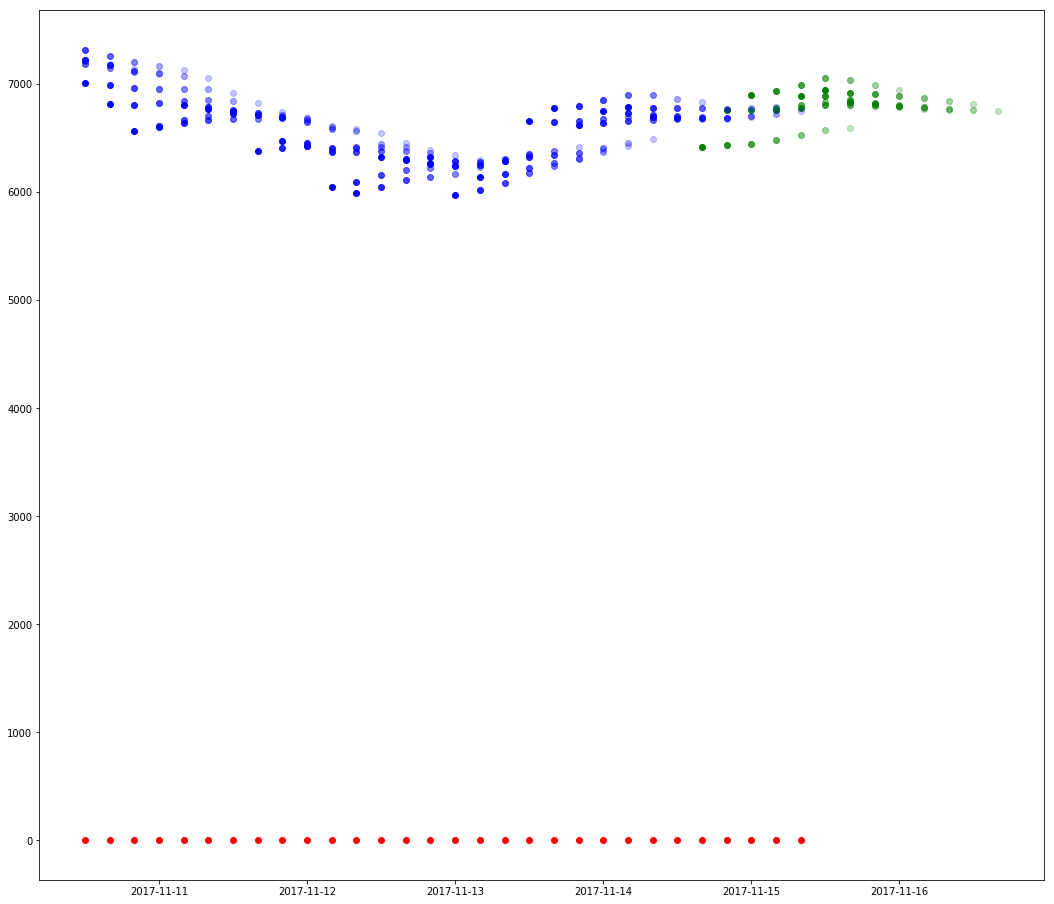

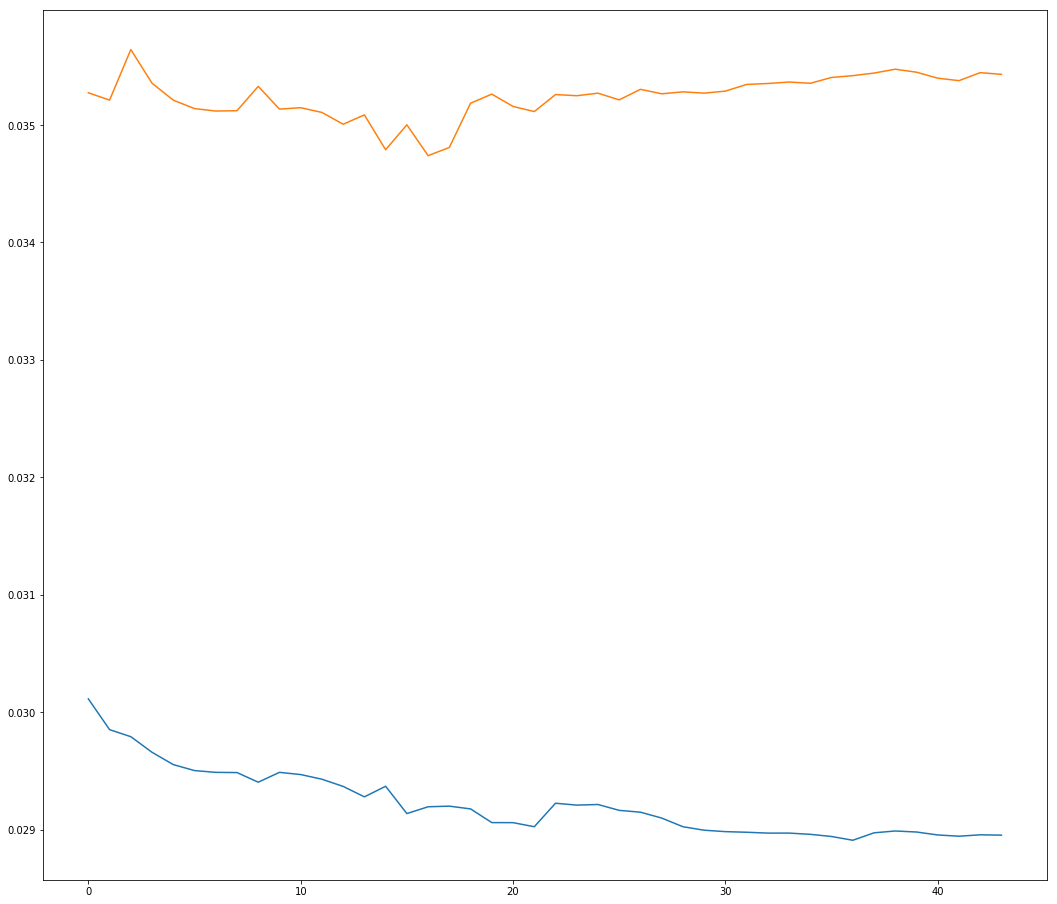

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02894 RMSE
Test Score: 0.03546 RMSE
(9004, 11)
(9011, 11)


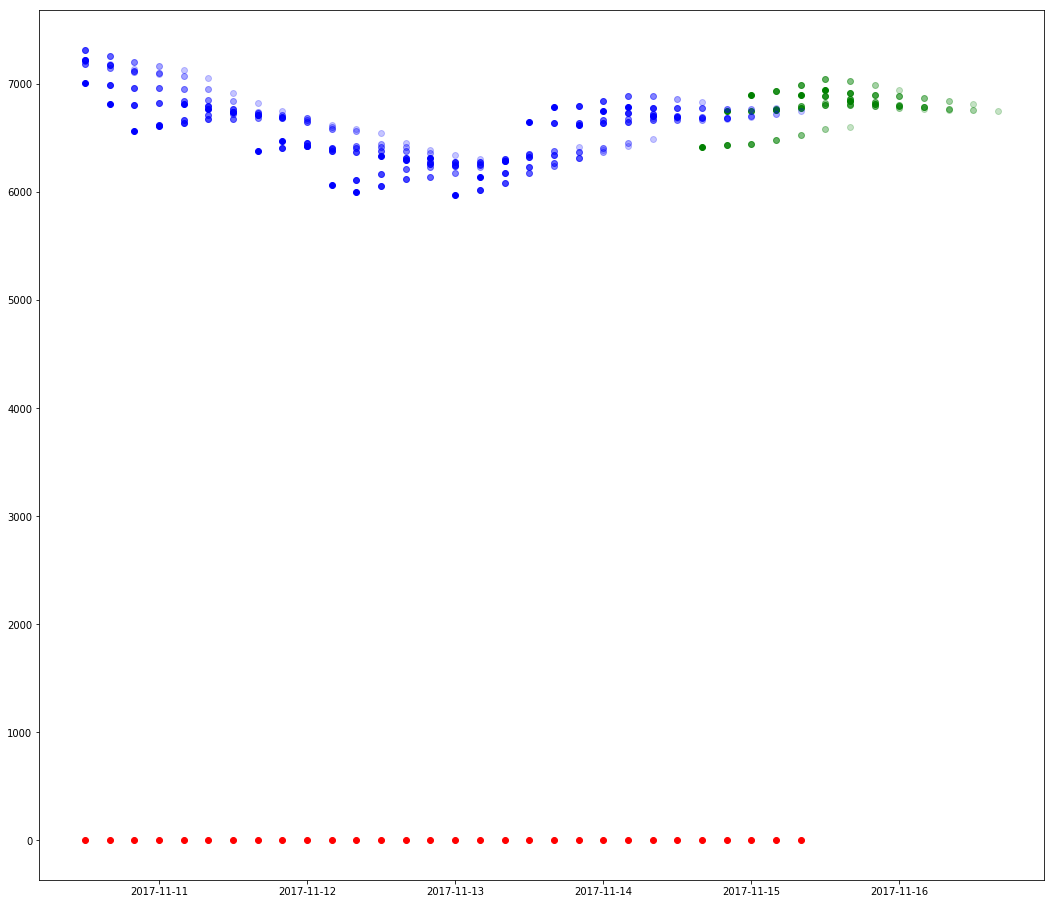

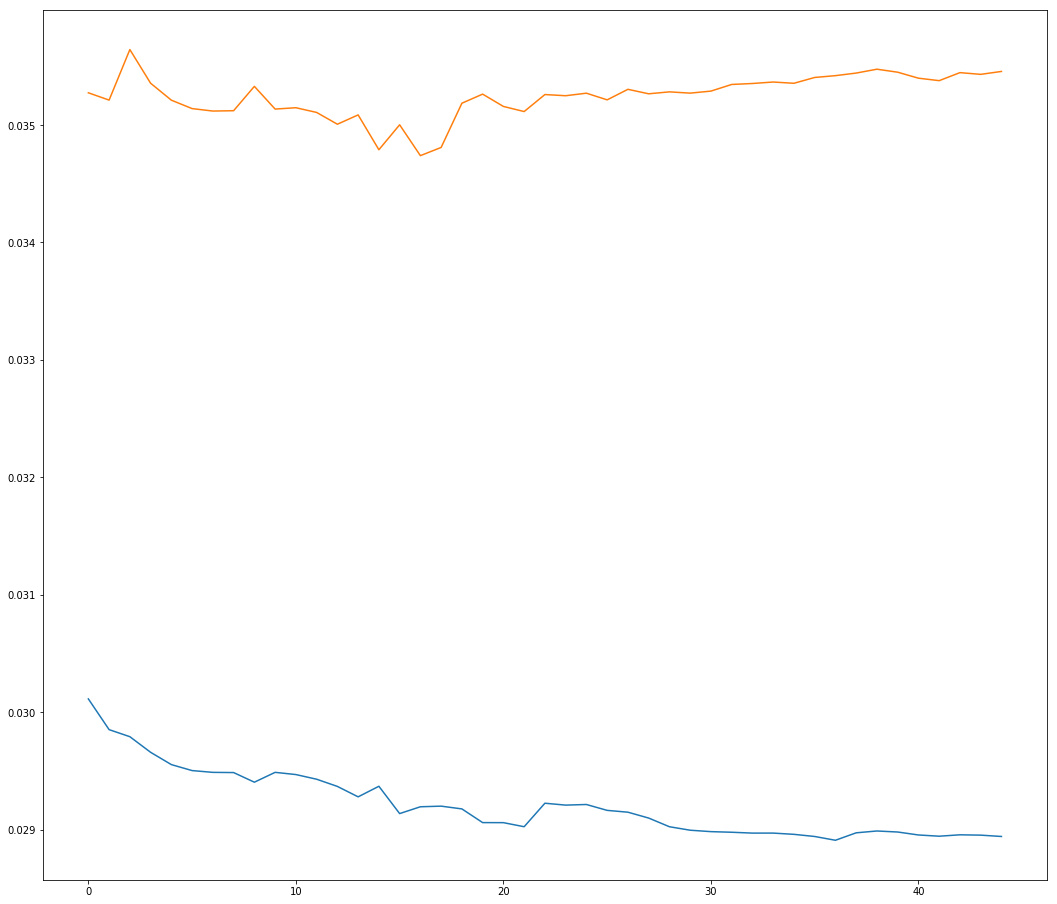

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02892 RMSE
Test Score: 0.03533 RMSE
(9004, 11)
(9011, 11)


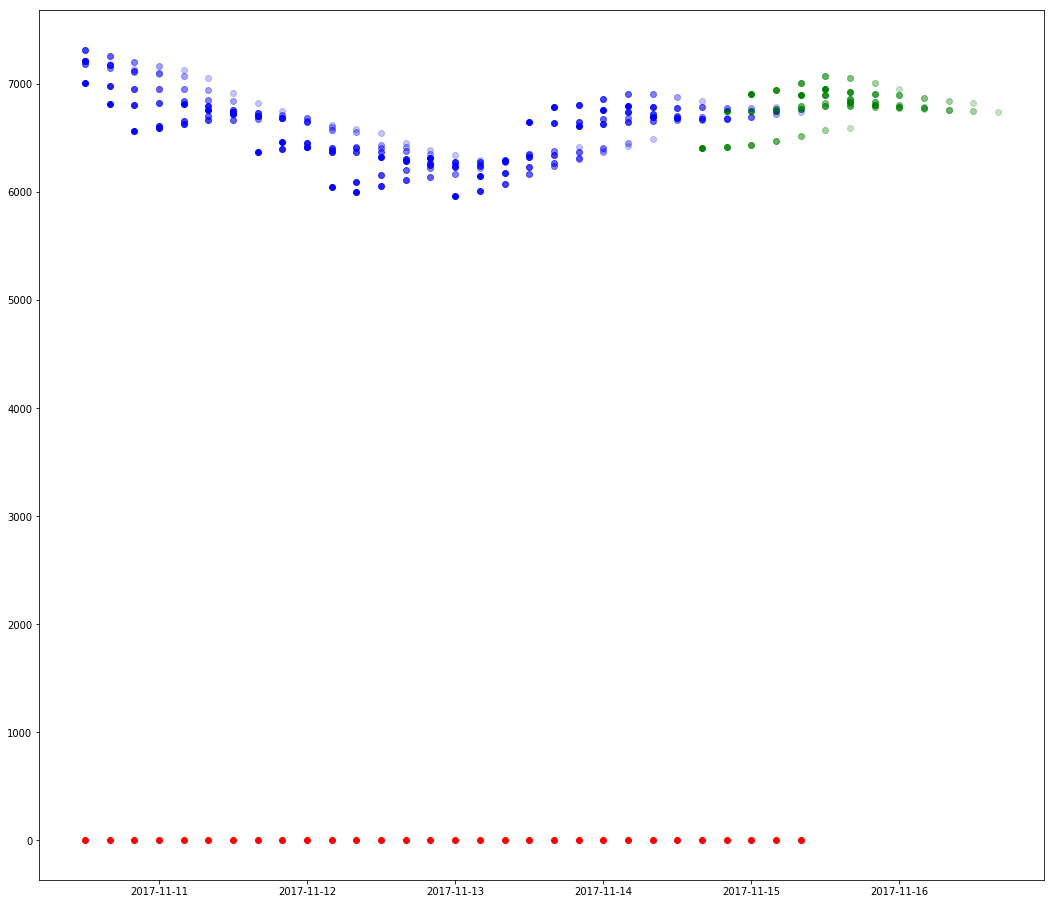

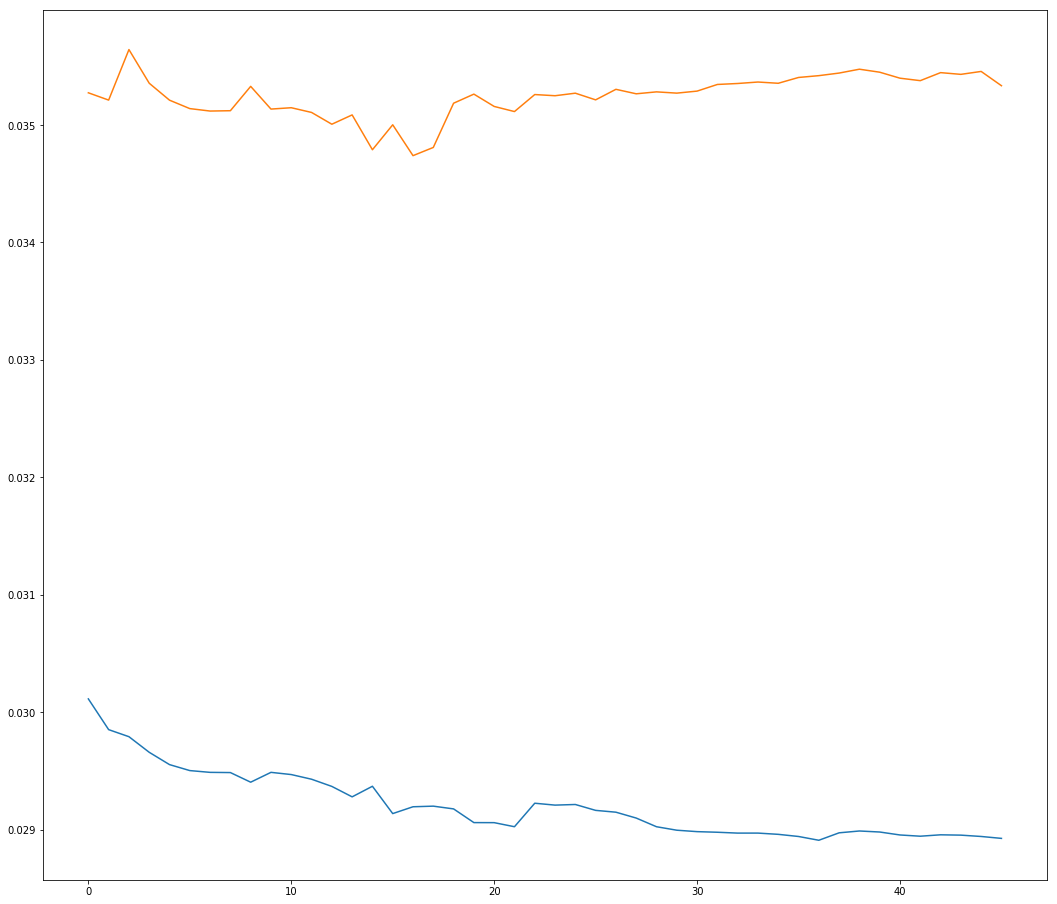

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02892 RMSE
Test Score: 0.03529 RMSE
(9004, 11)
(9011, 11)


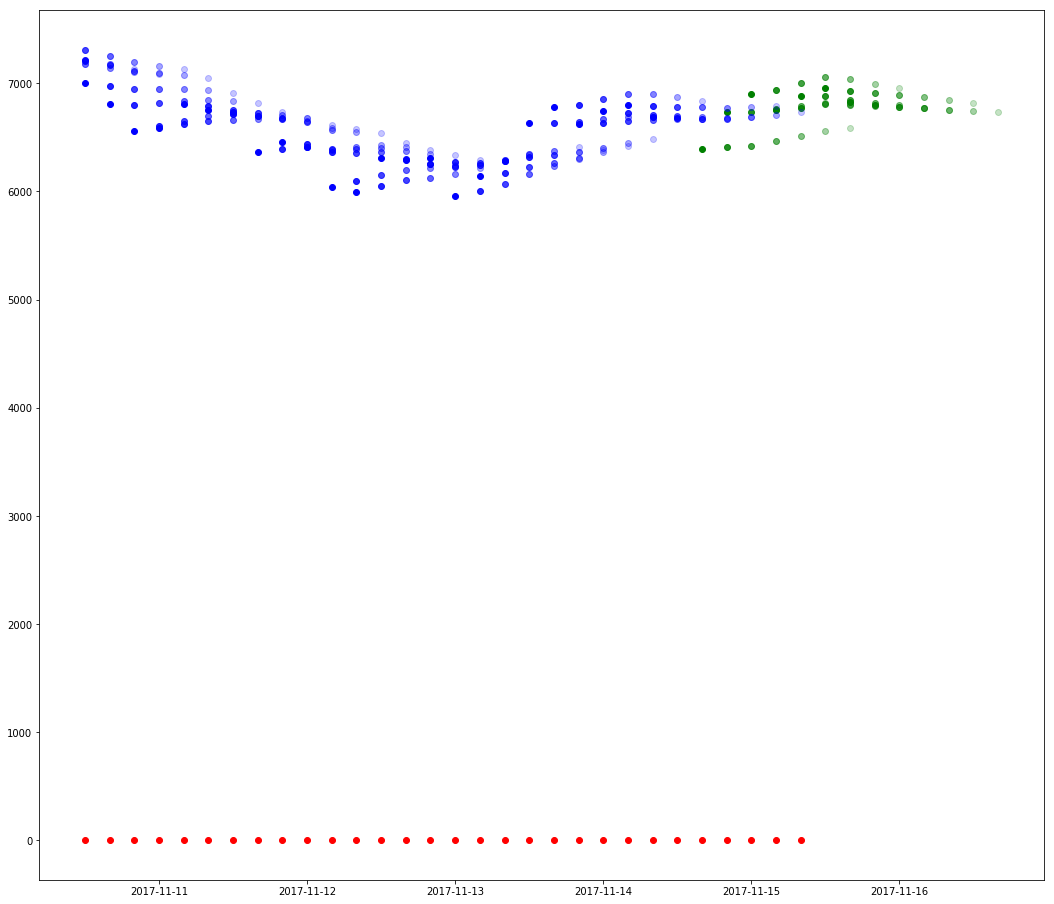

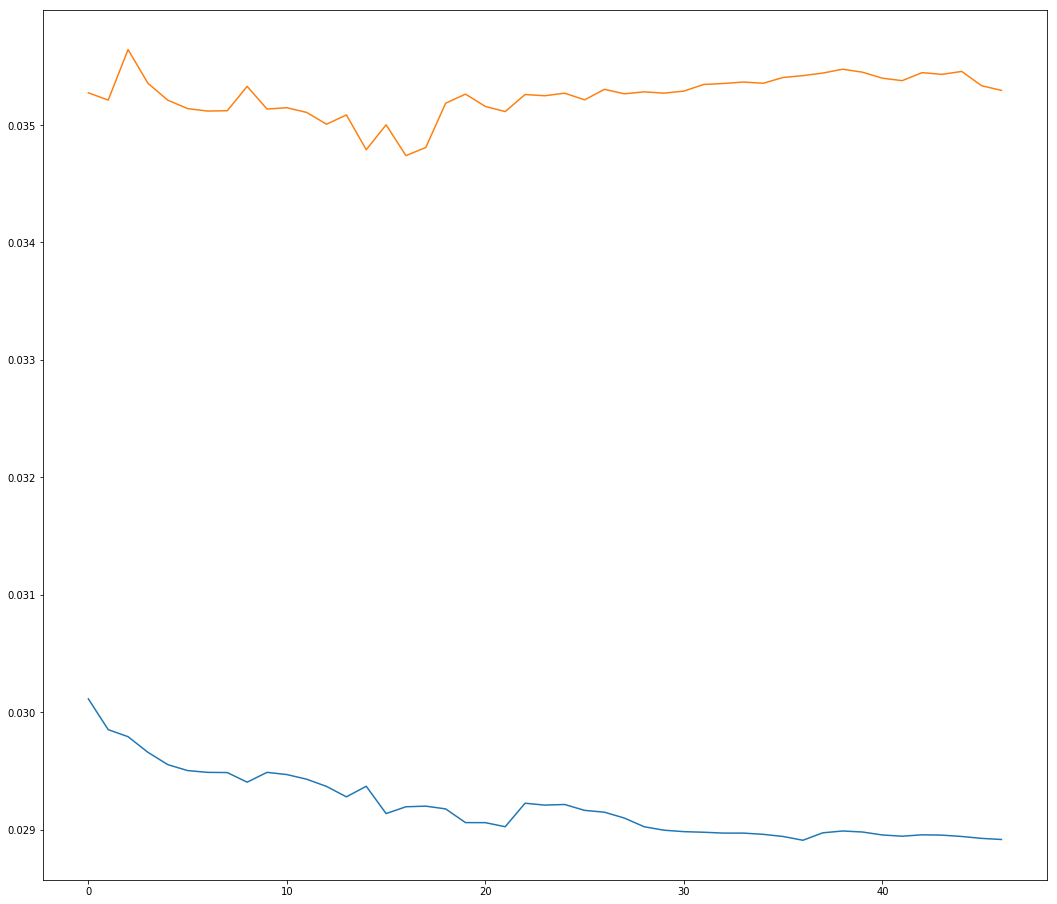

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02892 RMSE
Test Score: 0.03537 RMSE
(9004, 11)
(9011, 11)


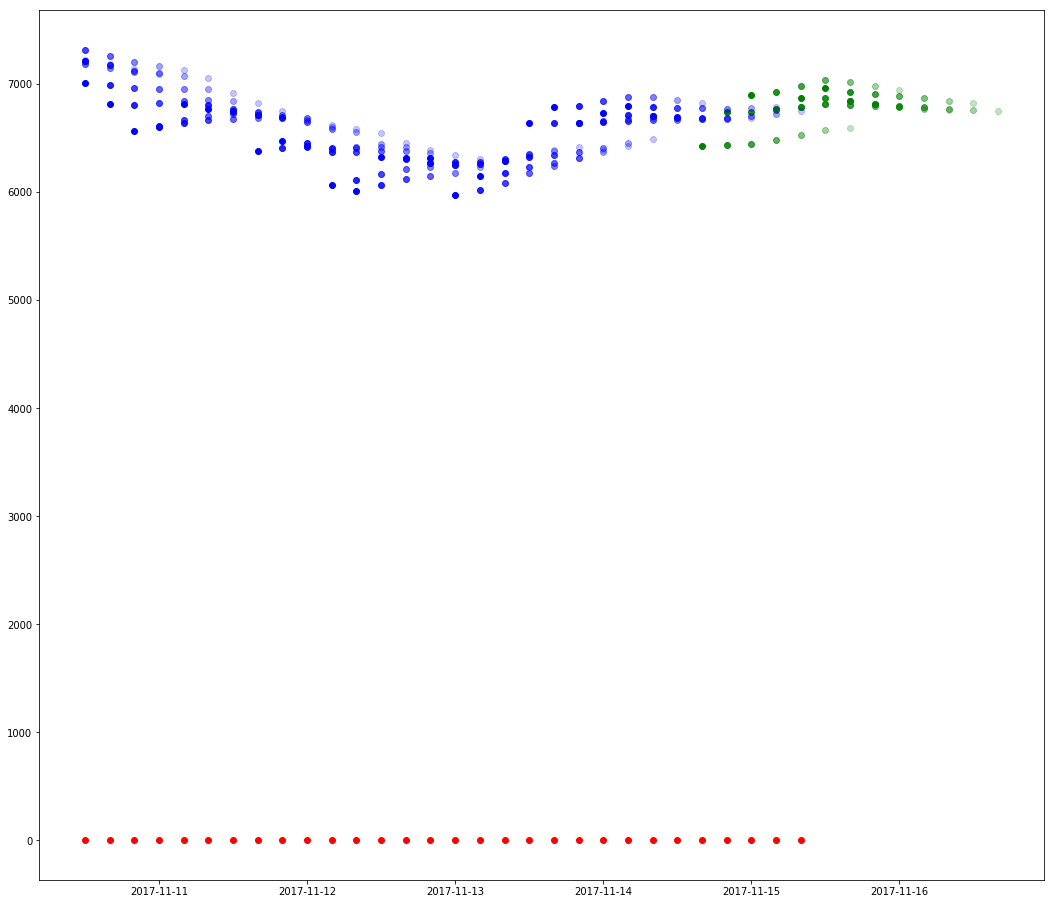

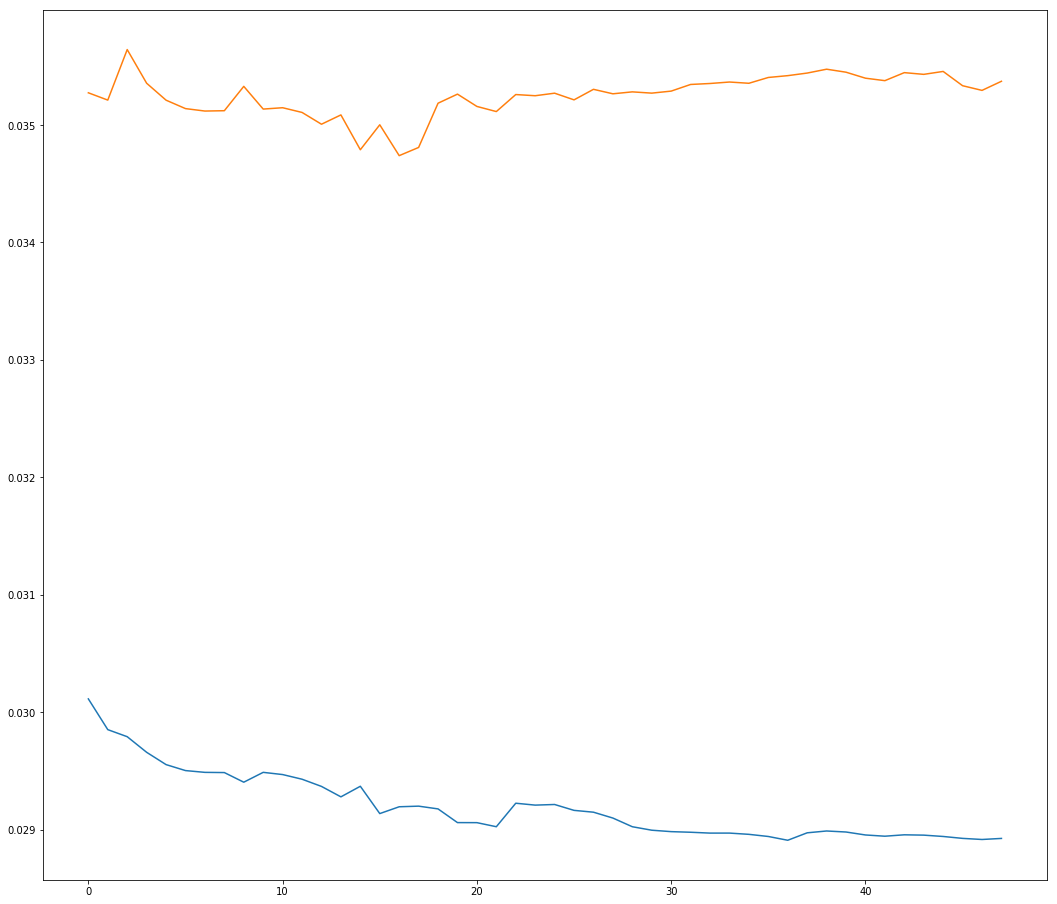

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02894 RMSE
Test Score: 0.03522 RMSE
(9004, 11)
(9011, 11)


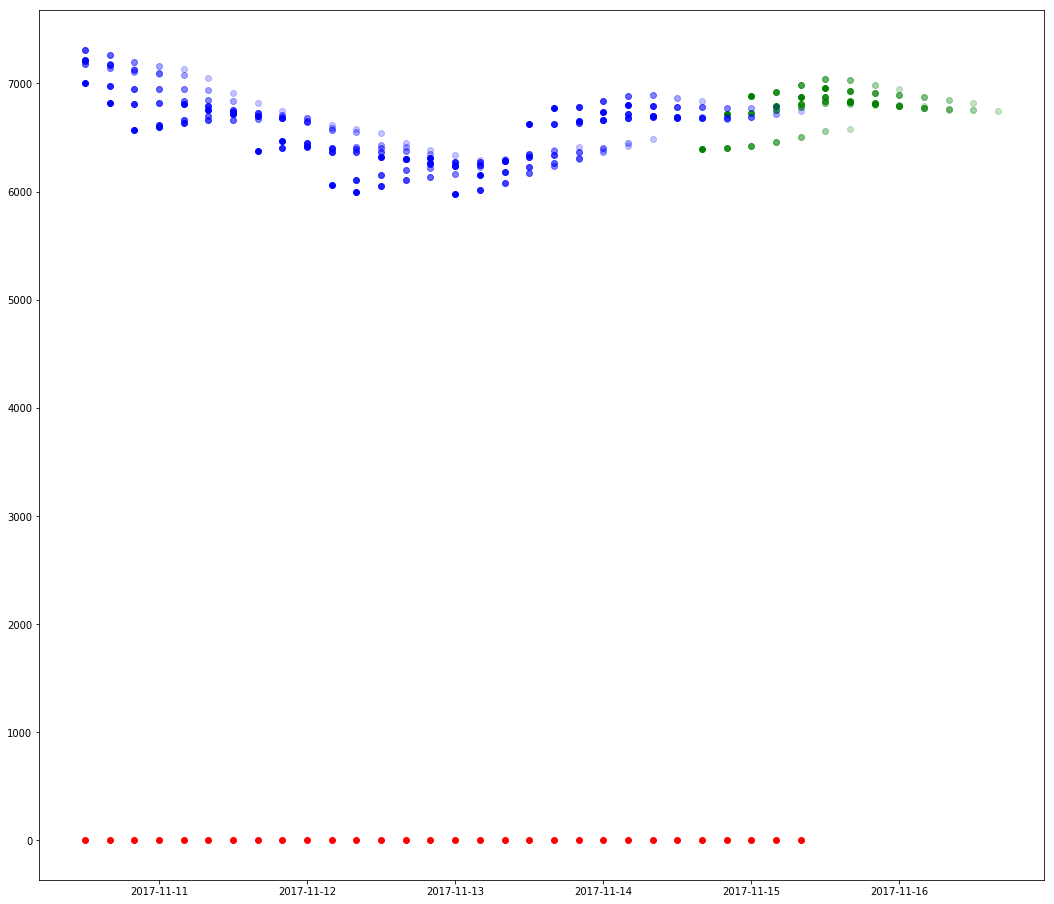

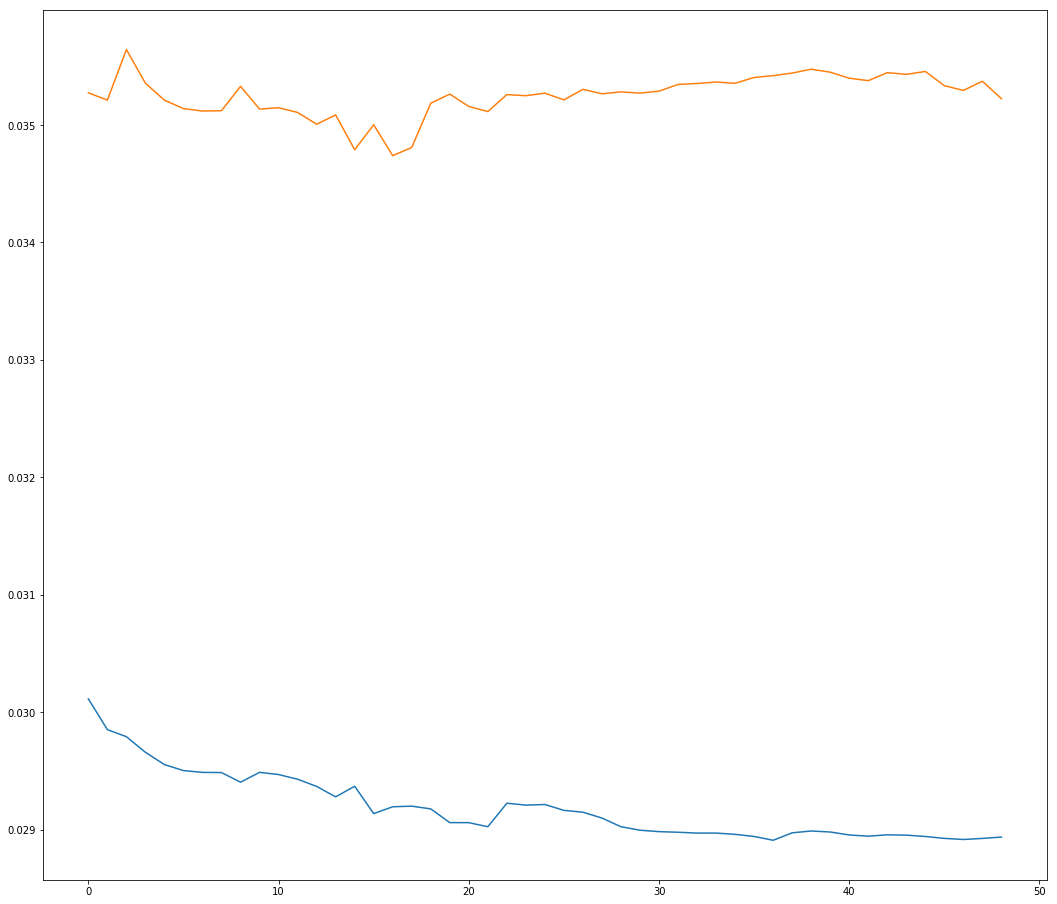

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02893 RMSE
Test Score: 0.03518 RMSE
(9004, 11)
(9011, 11)


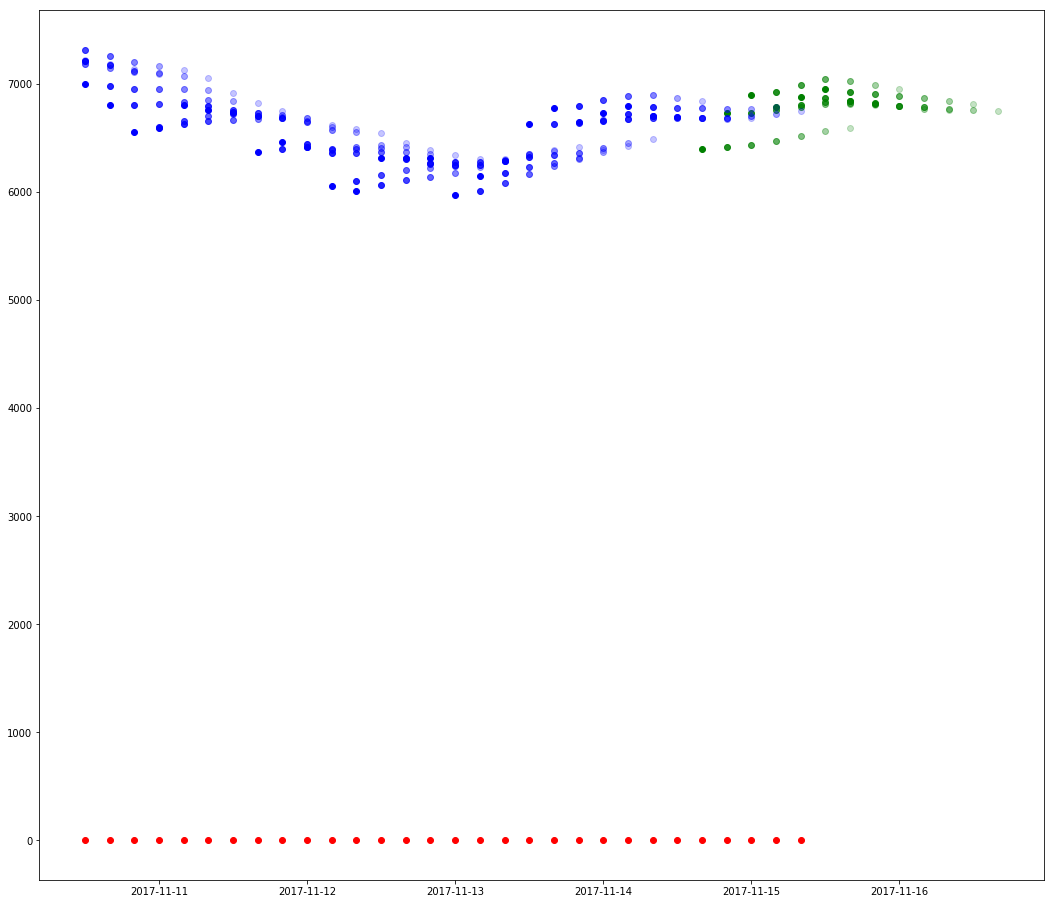

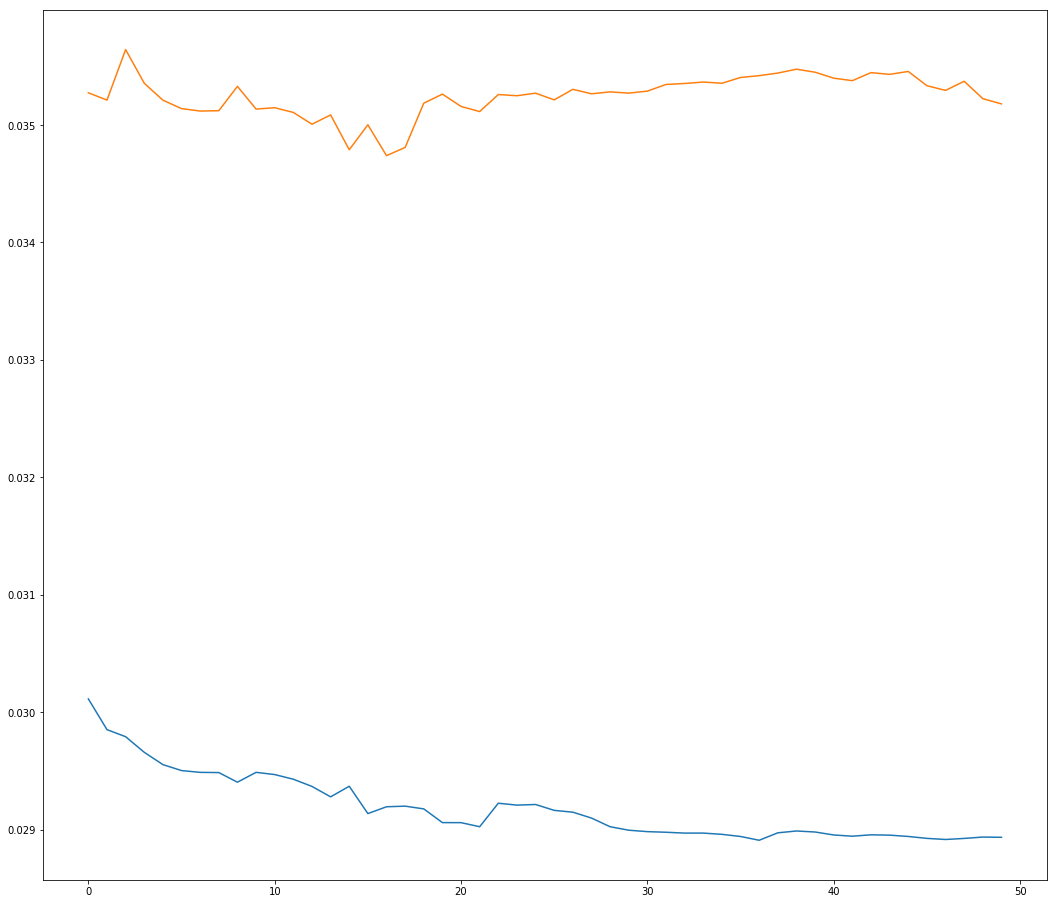

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02894 RMSE
Test Score: 0.03523 RMSE
(9004, 11)
(9011, 11)


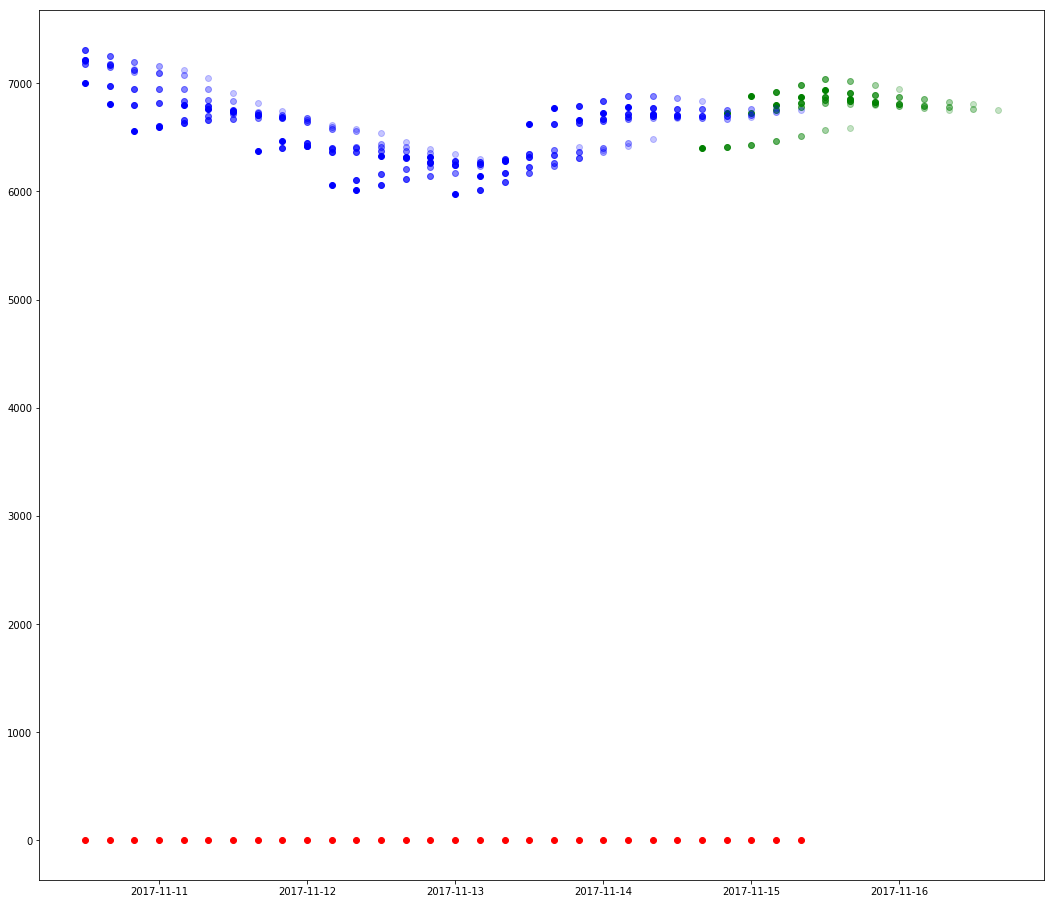

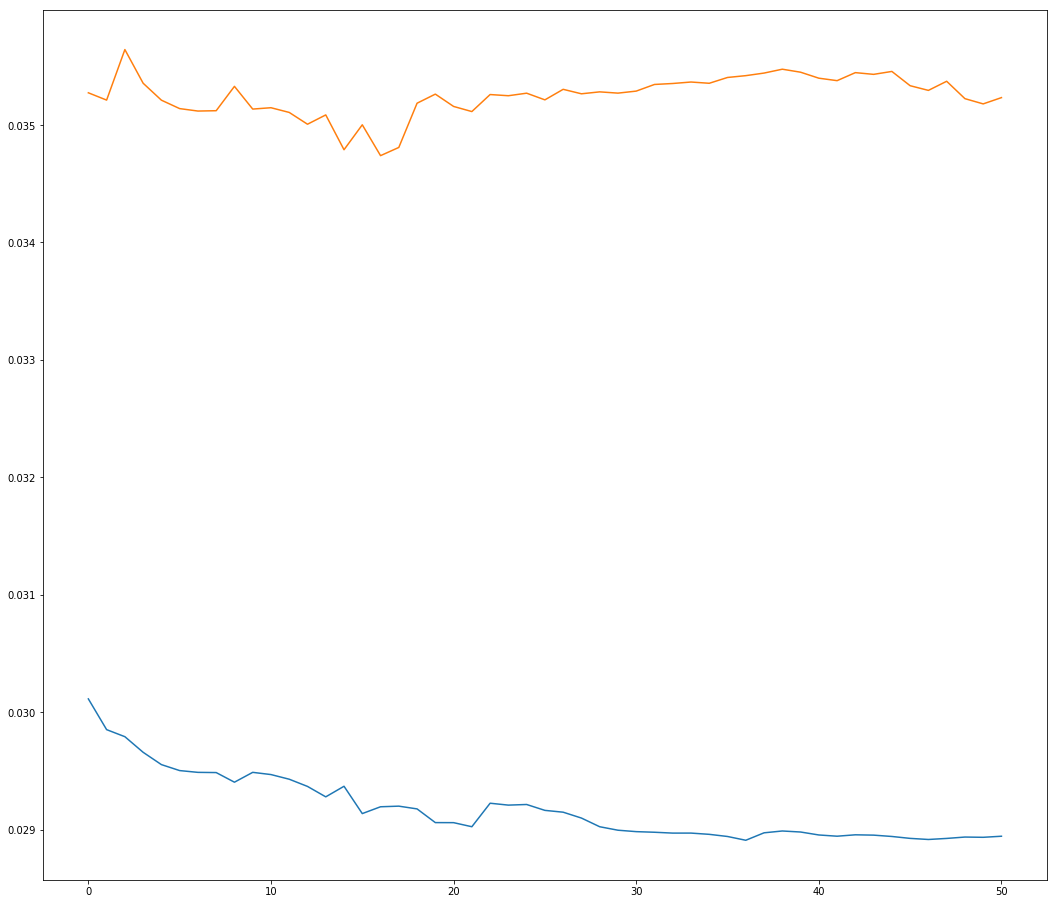

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02893 RMSE
Test Score: 0.03516 RMSE
(9004, 11)
(9011, 11)


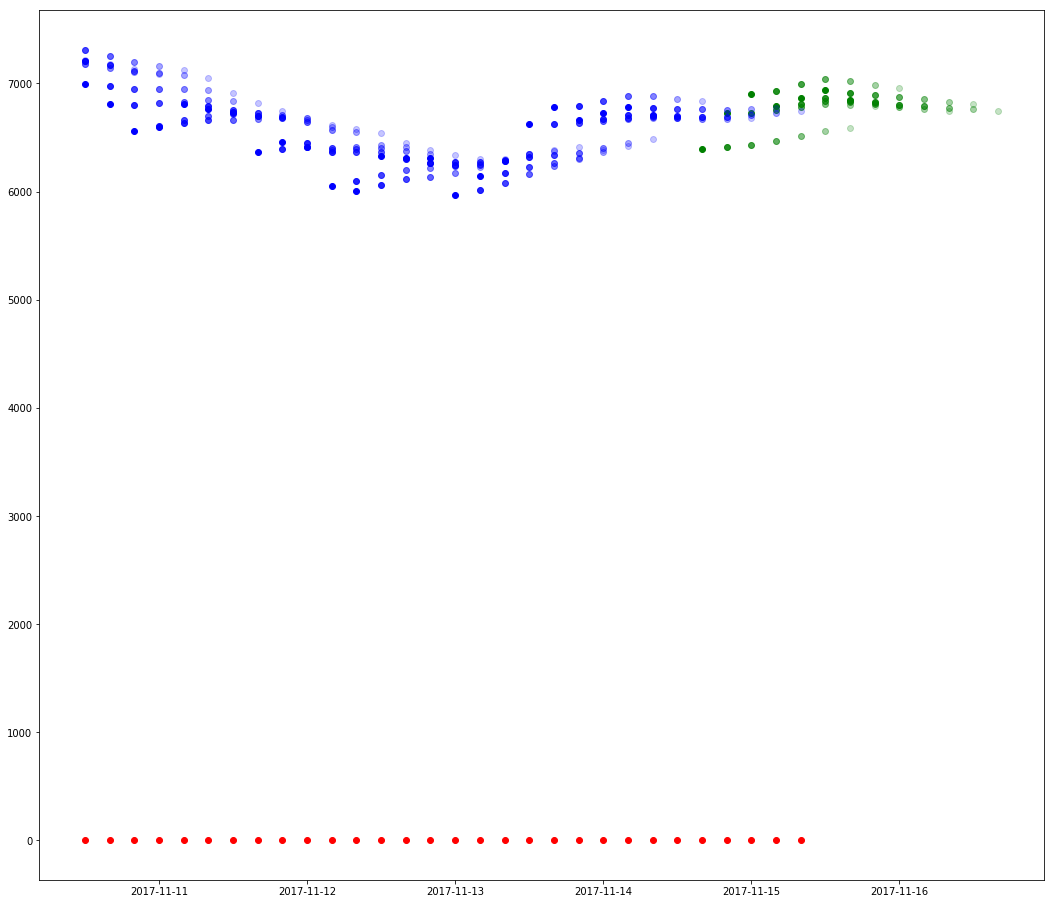

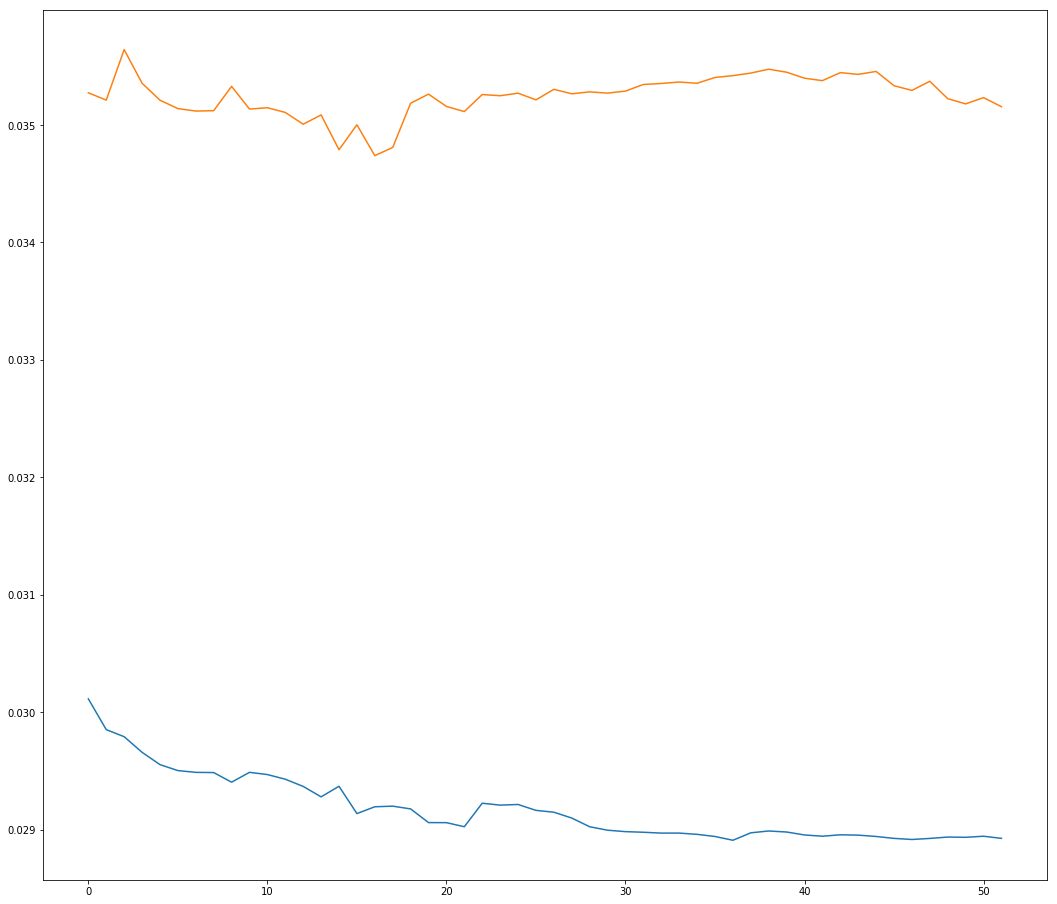

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02891 RMSE
Test Score: 0.03515 RMSE
(9004, 11)
(9011, 11)


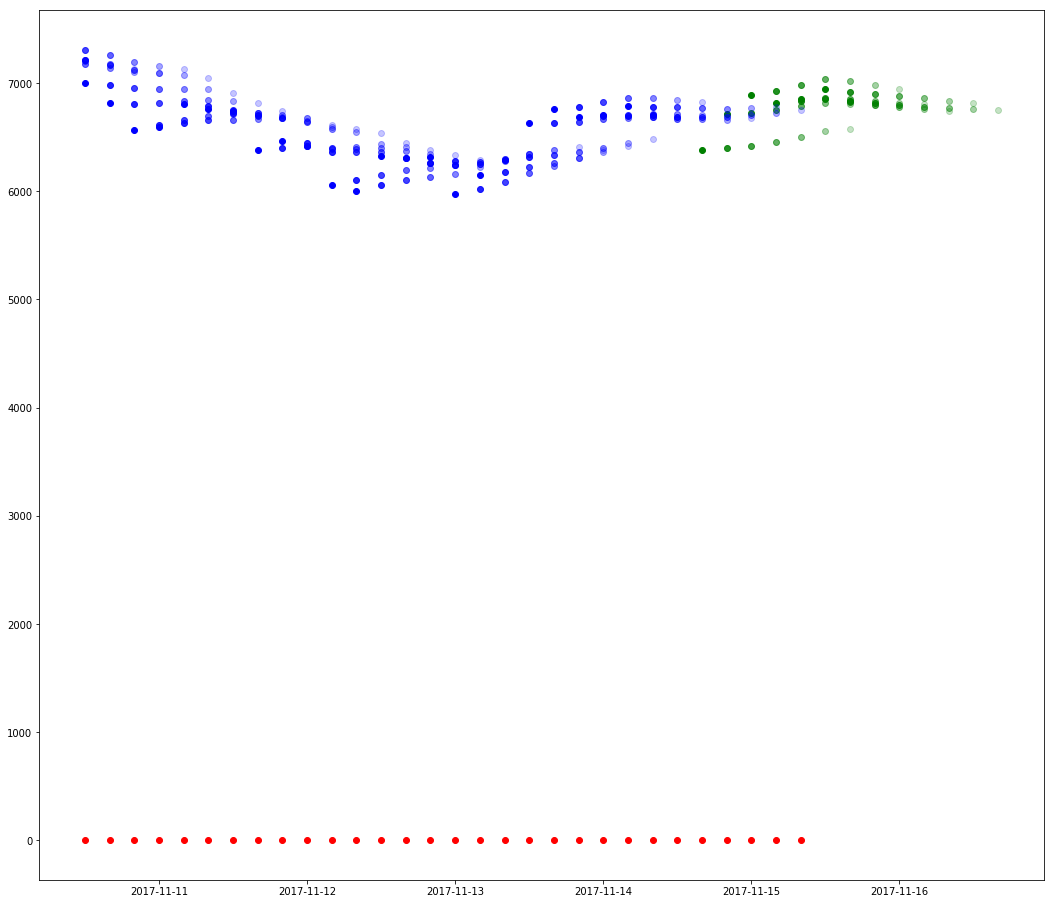

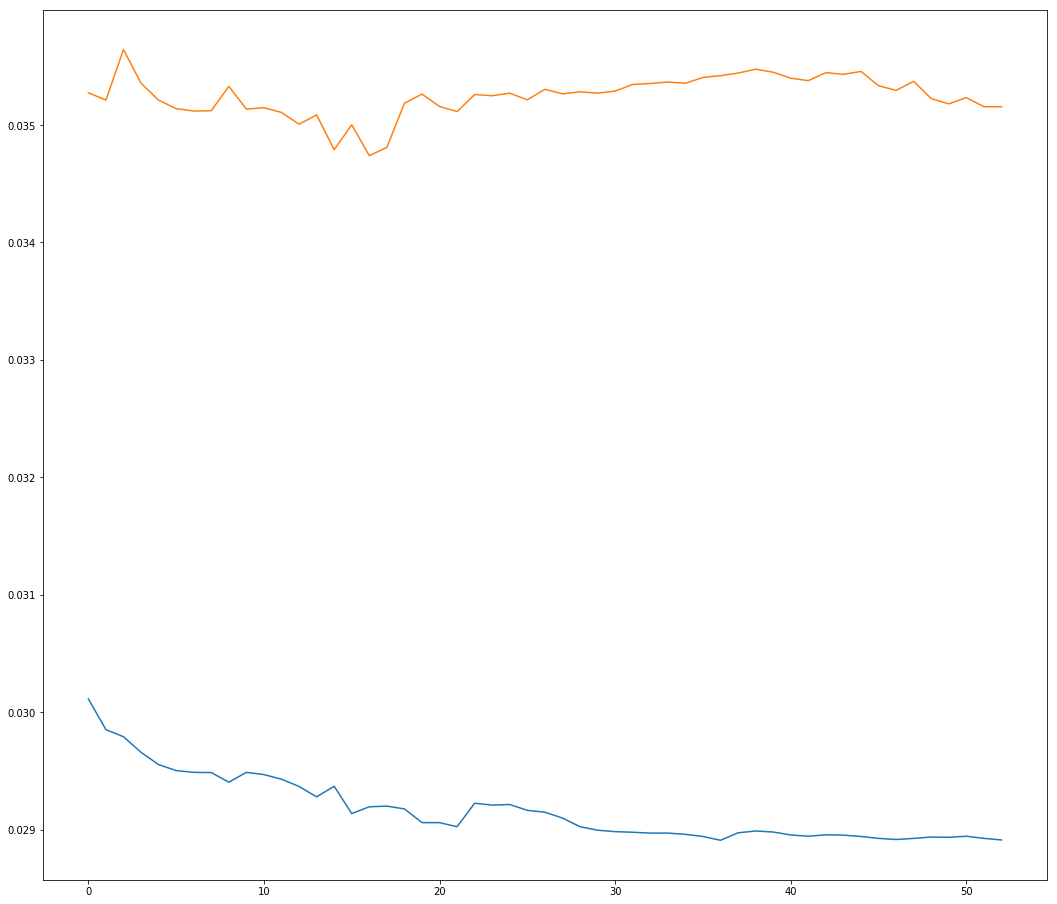

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02888 RMSE
Test Score: 0.03503 RMSE
(9004, 11)
(9011, 11)


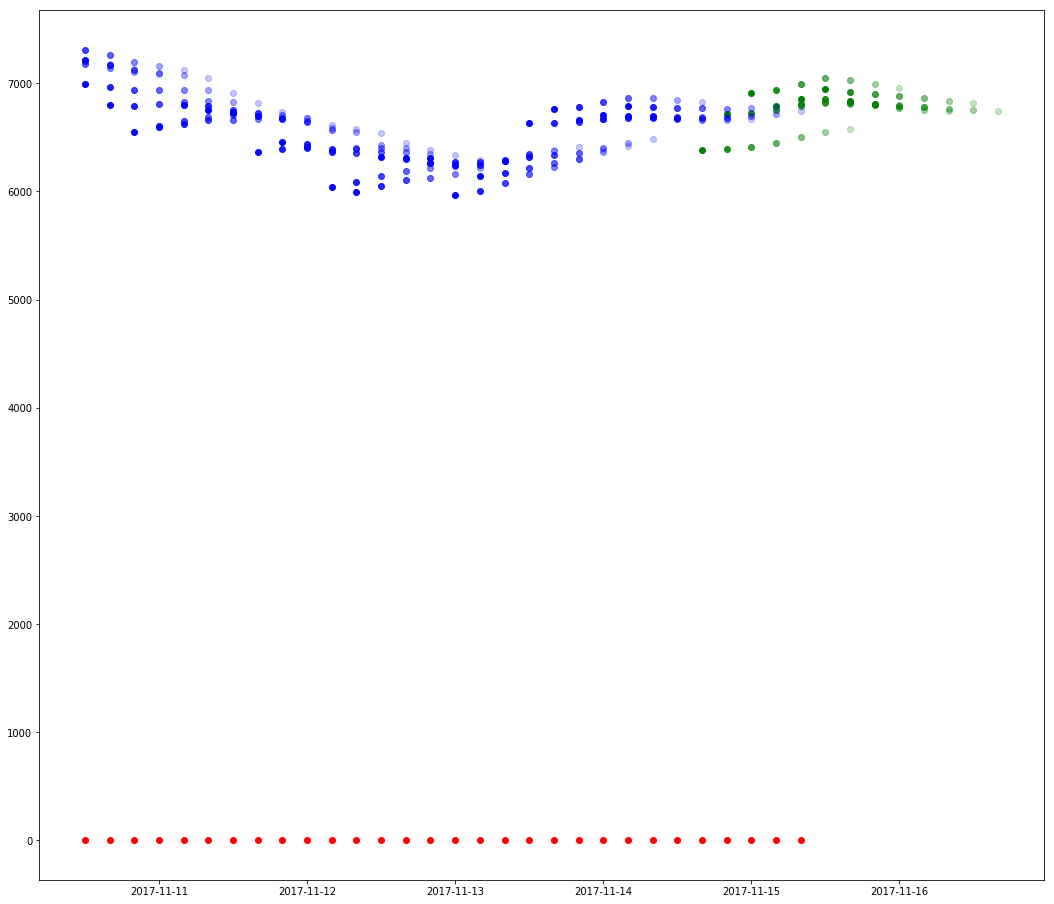

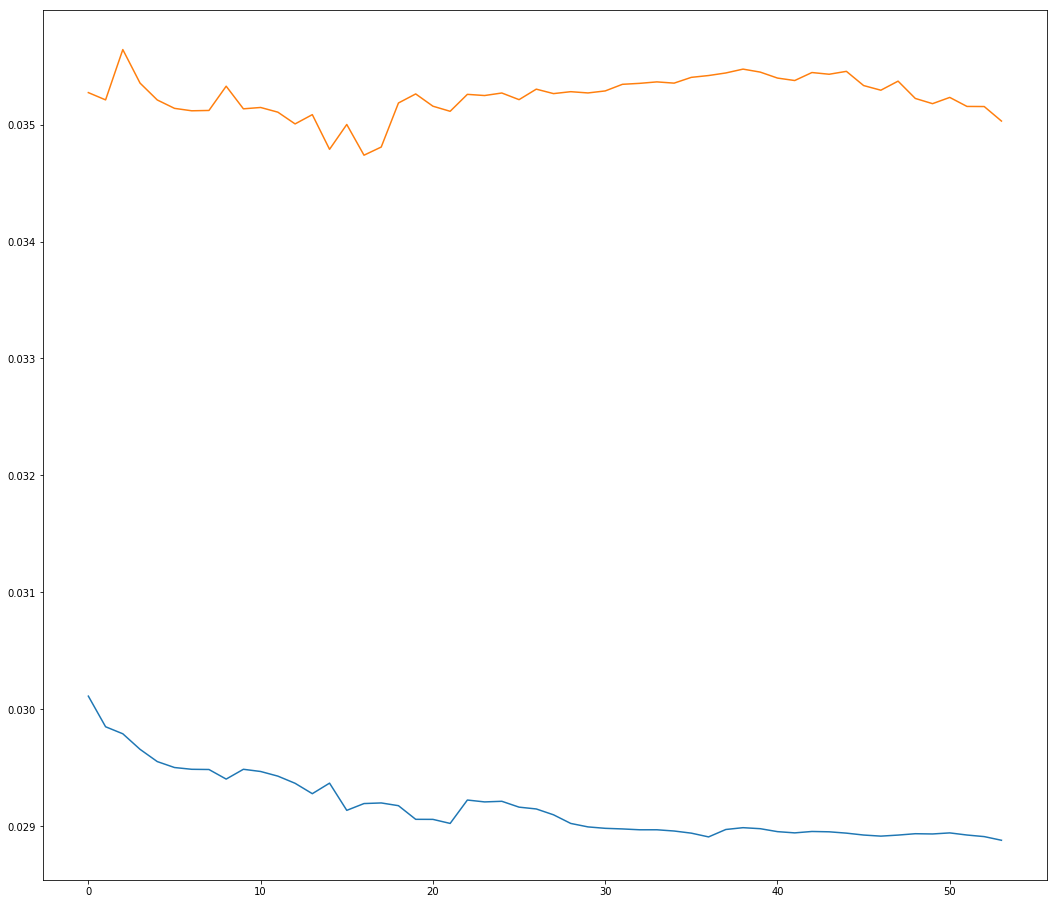

Epoch 1/1
 - 44s - loss: 0.0014
Train Score: 0.02890 RMSE
Test Score: 0.03512 RMSE
(9004, 11)
(9011, 11)


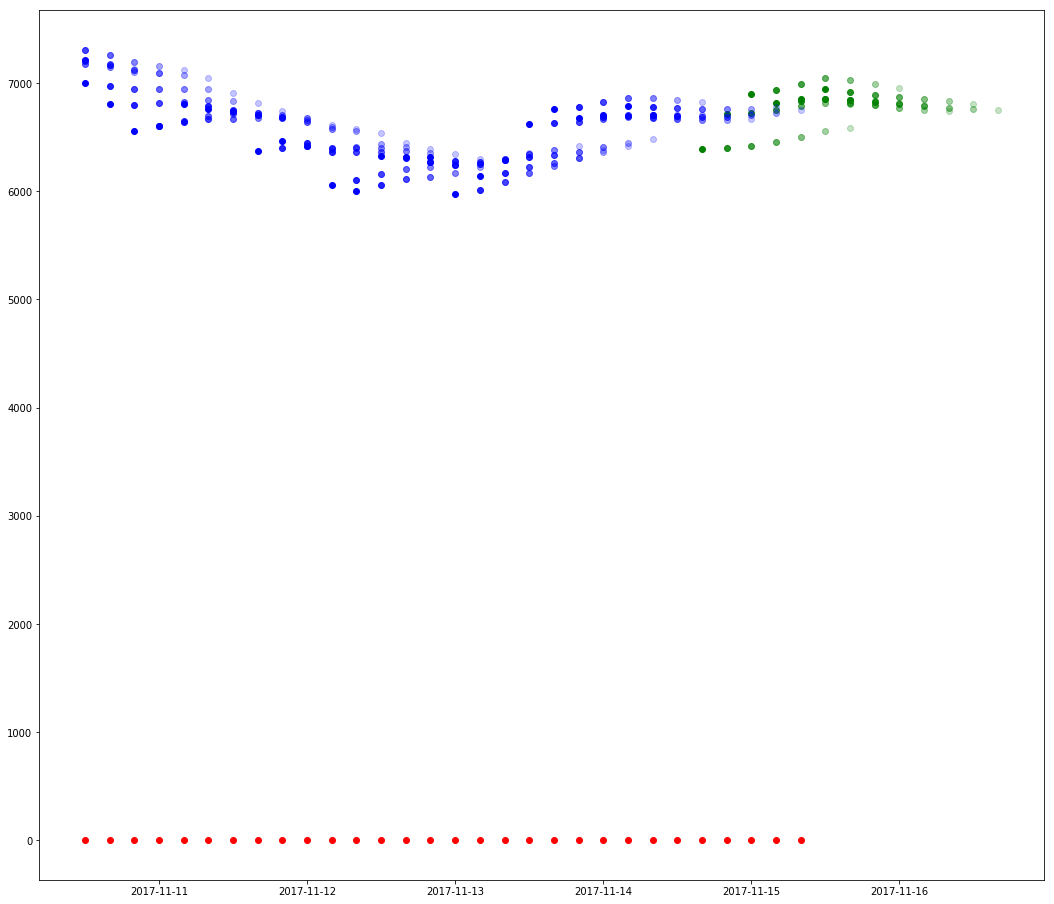

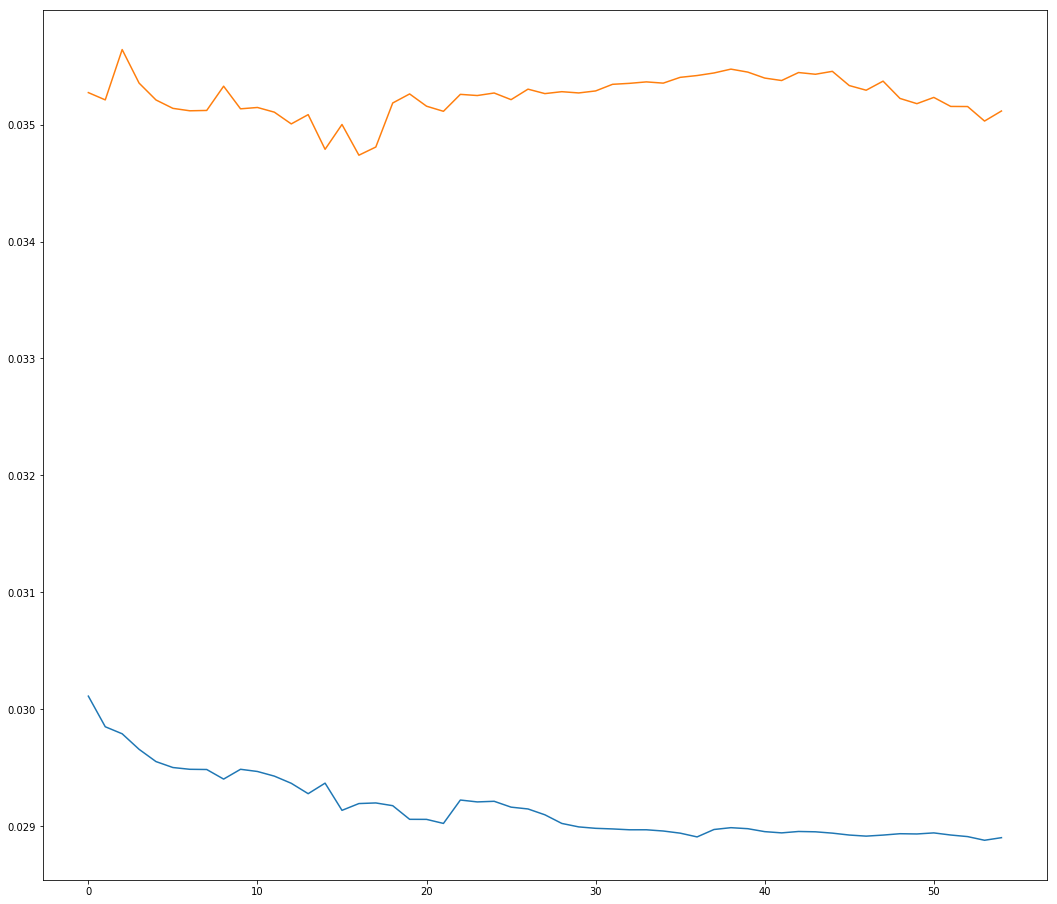

Epoch 1/1
 - 44s - loss: 0.0014
Train Score: 0.02884 RMSE
Test Score: 0.03507 RMSE
(9004, 11)
(9011, 11)


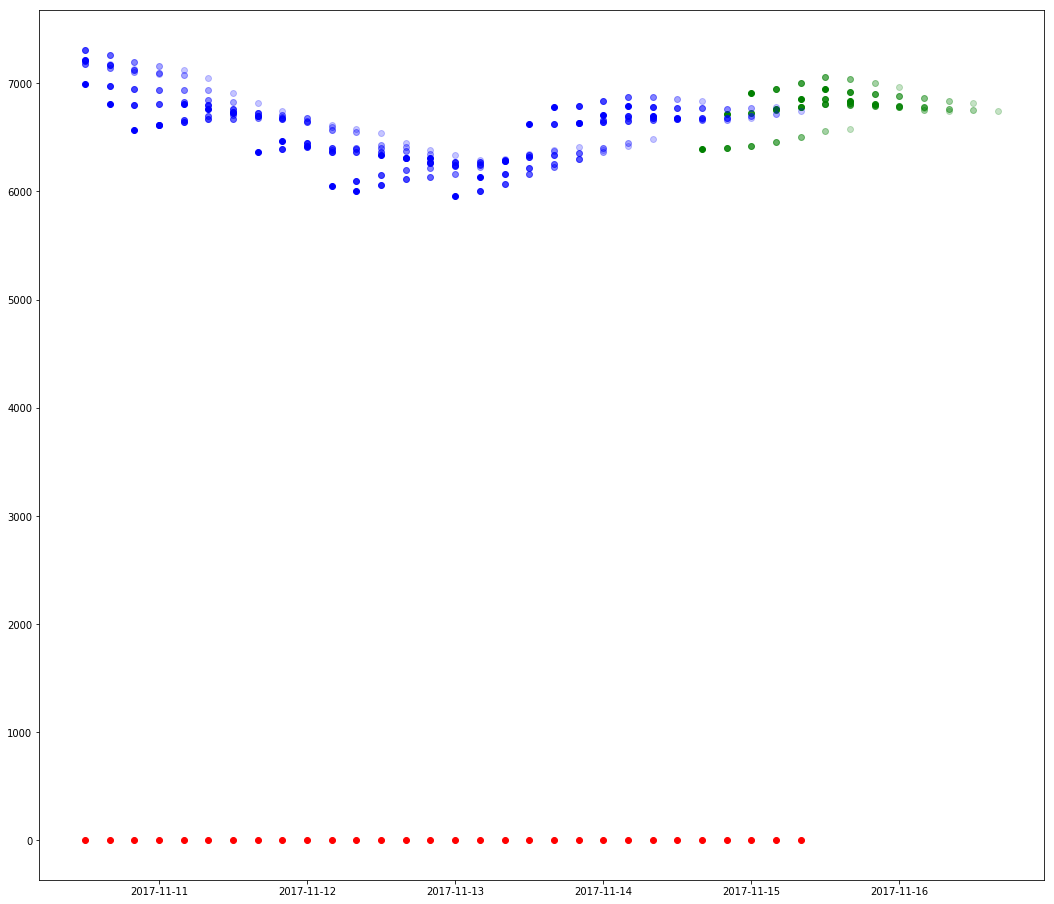

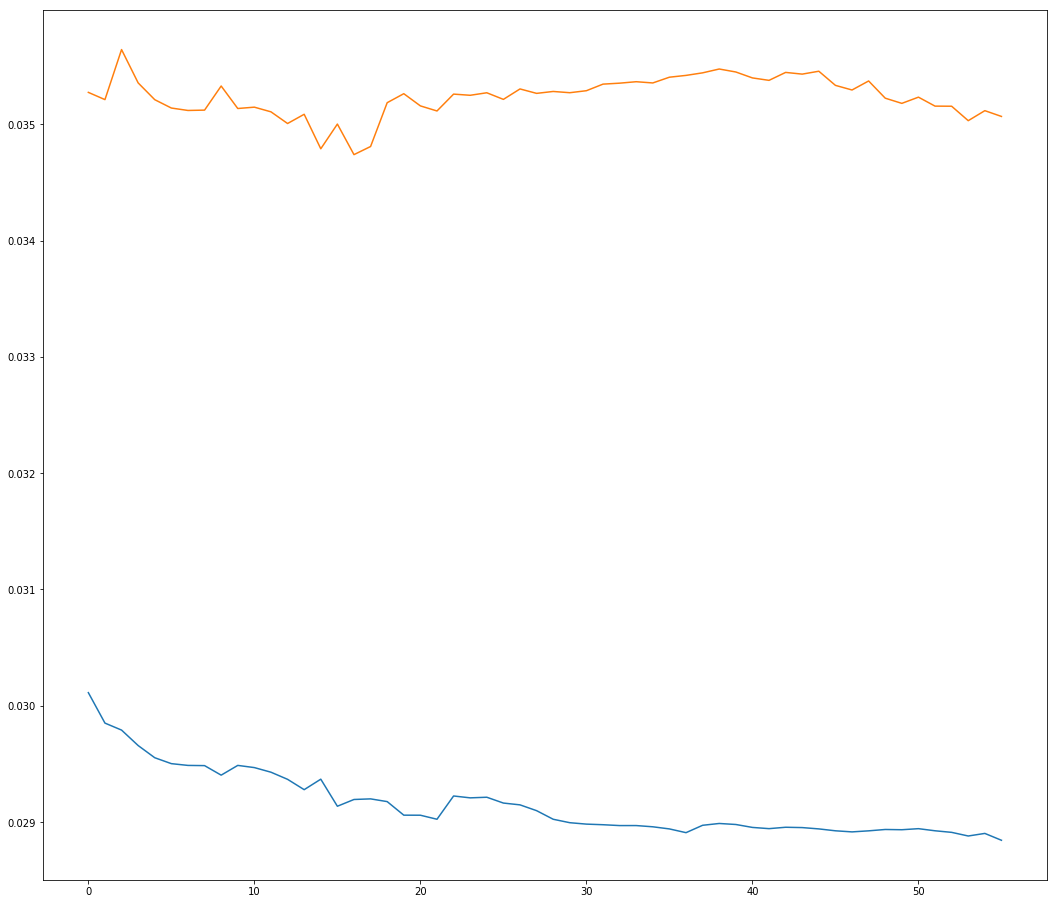

Epoch 1/1
 - 44s - loss: 0.0014
Train Score: 0.02888 RMSE
Test Score: 0.03491 RMSE
(9004, 11)
(9011, 11)


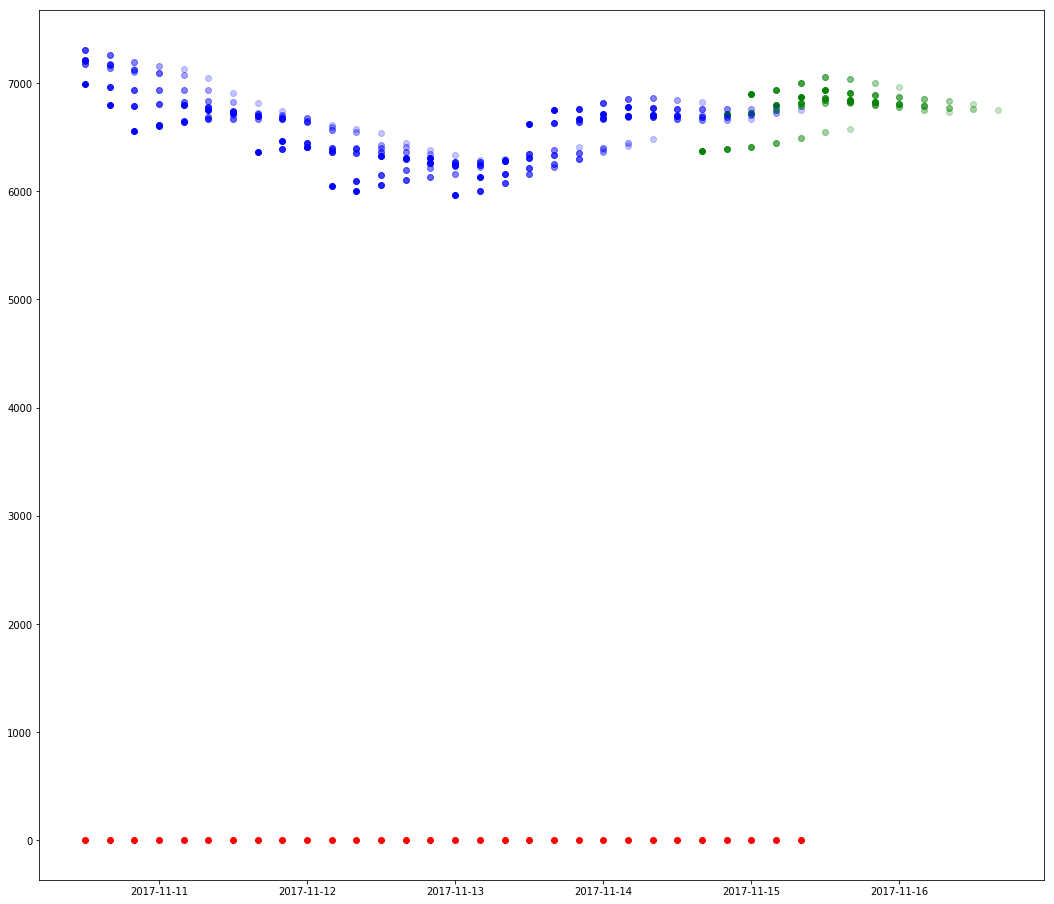

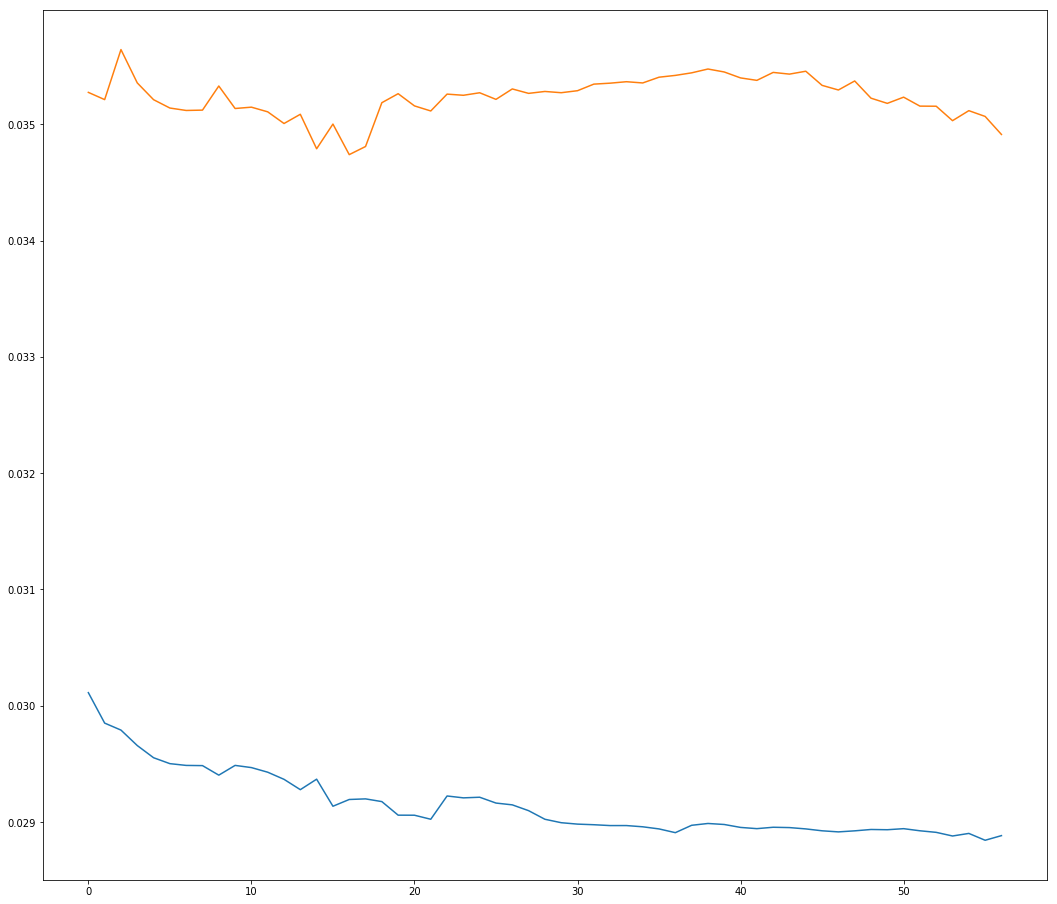

Epoch 1/1
 - 45s - loss: 0.0014
Train Score: 0.02886 RMSE
Test Score: 0.03494 RMSE
(9004, 11)
(9011, 11)


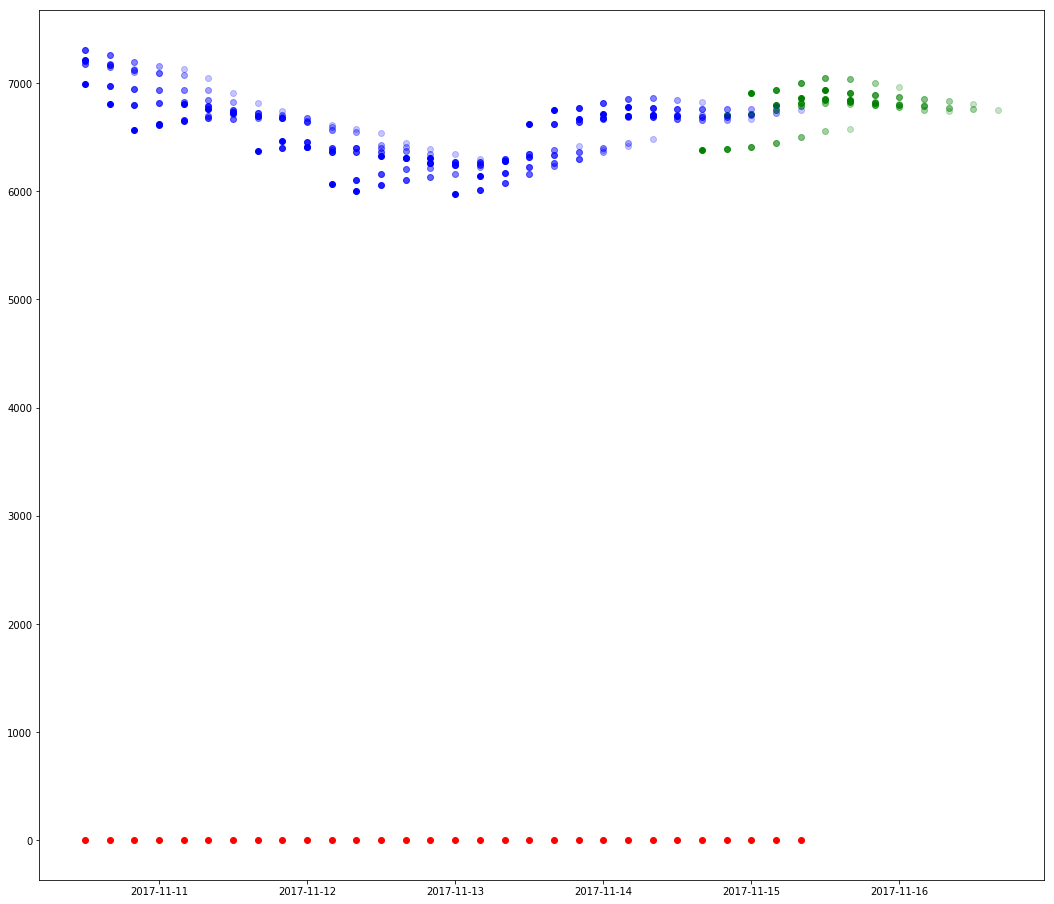

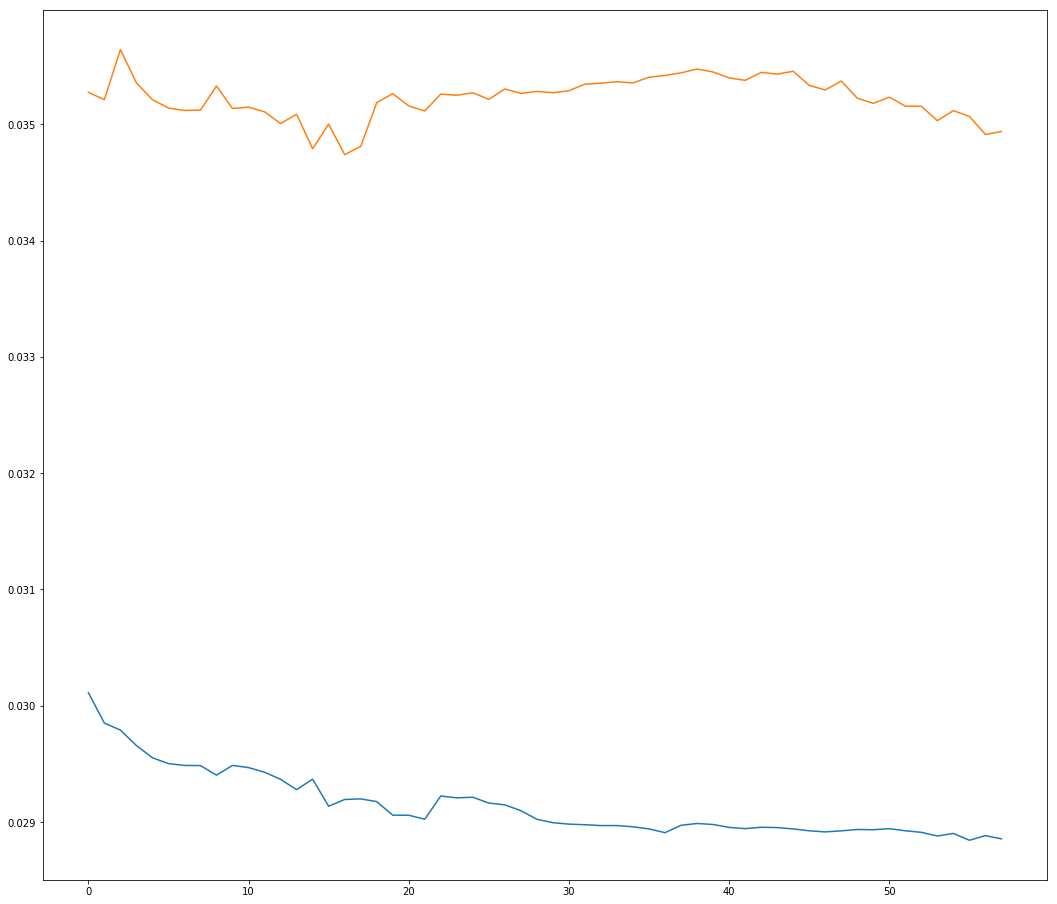

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02886 RMSE
Test Score: 0.03494 RMSE
(9004, 11)
(9011, 11)


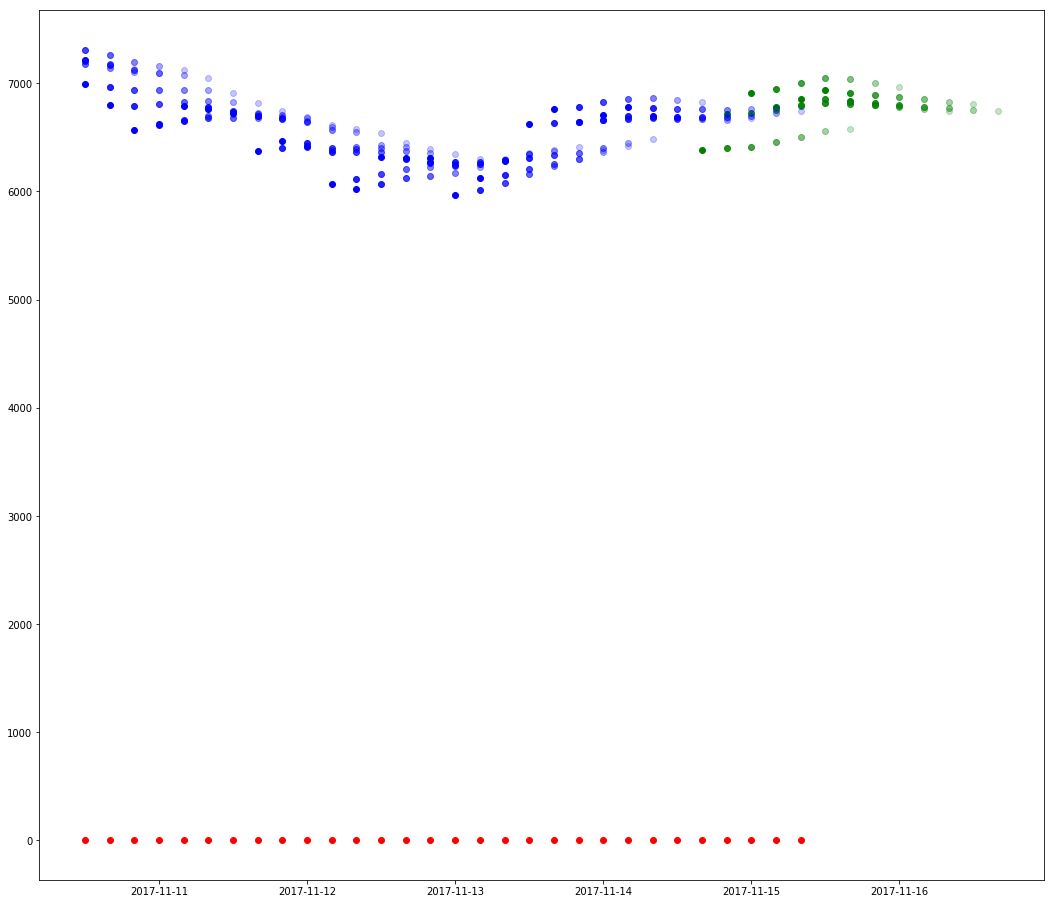

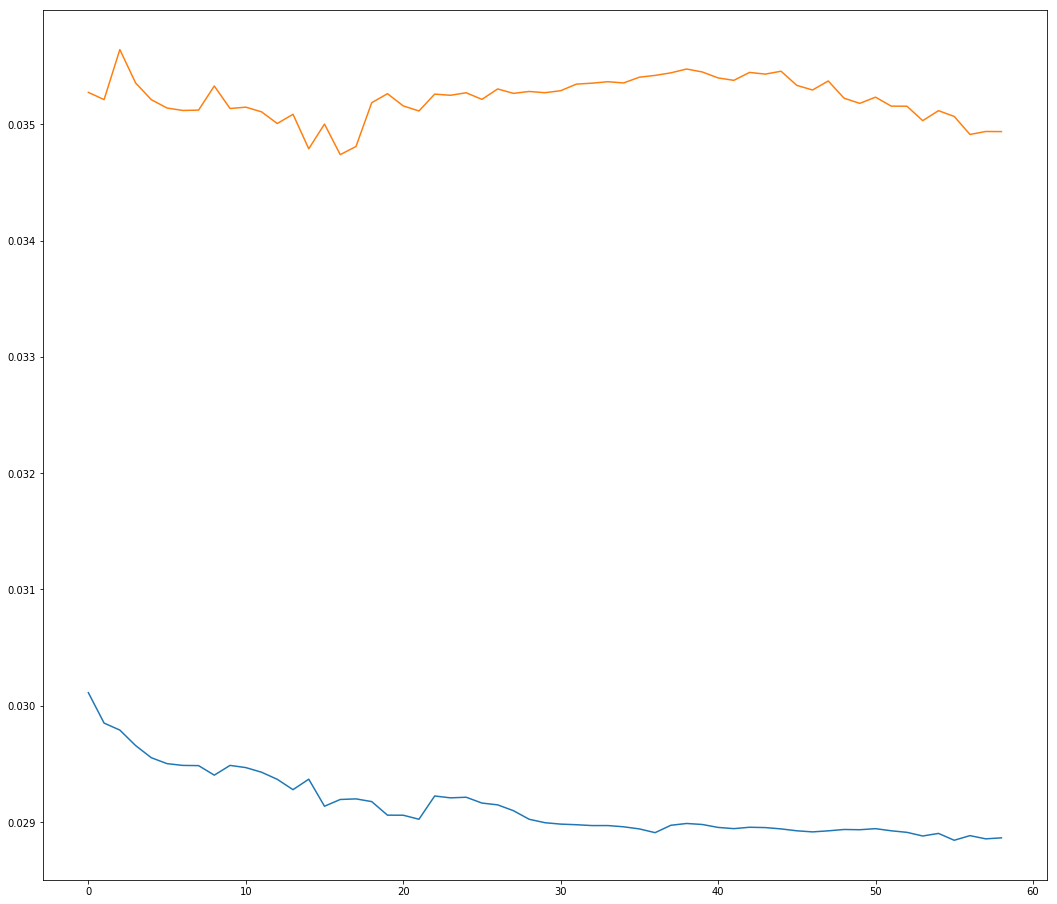

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02888 RMSE
Test Score: 0.03499 RMSE
(9004, 11)
(9011, 11)


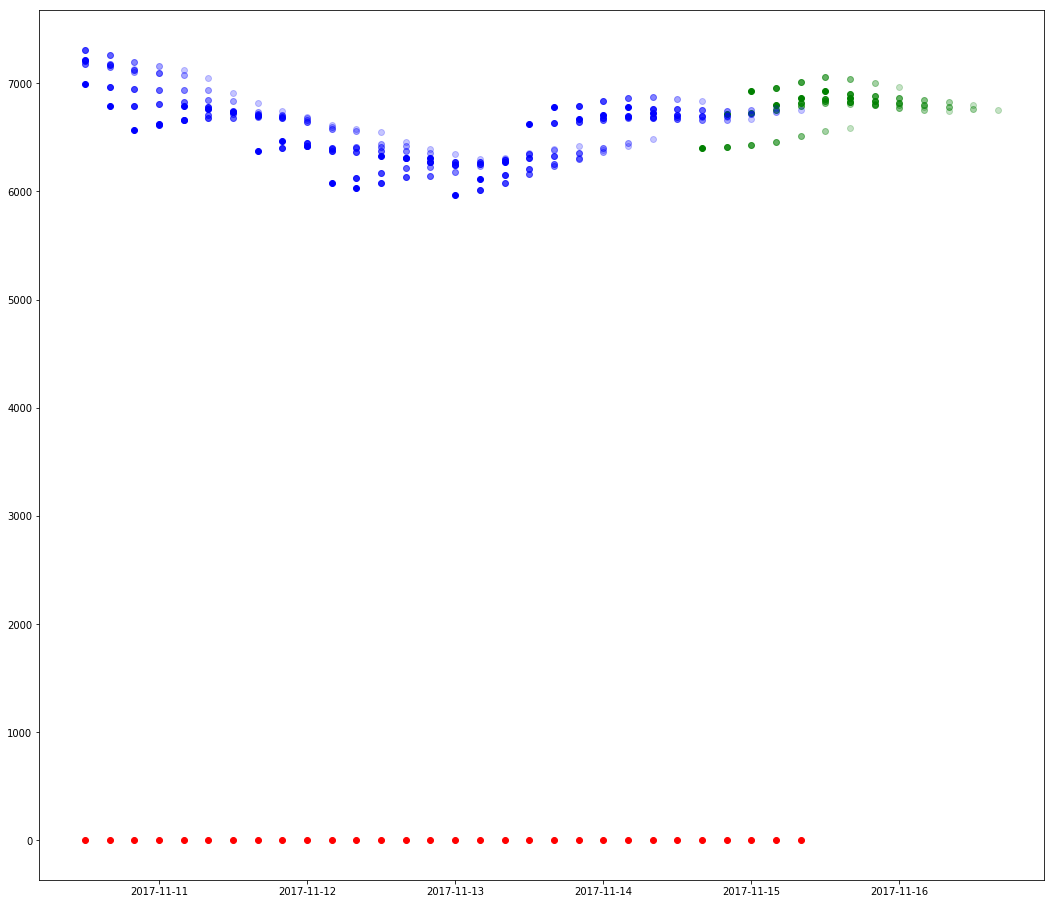

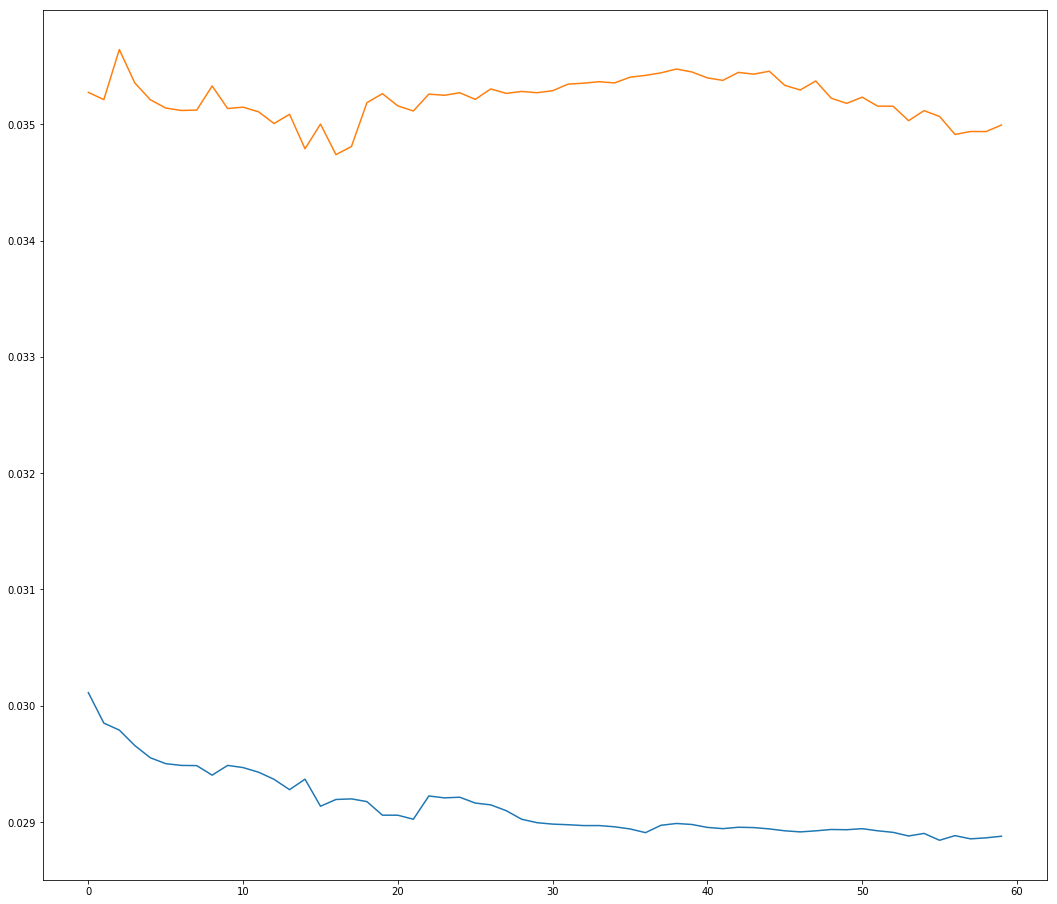

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02887 RMSE
Test Score: 0.03490 RMSE
(9004, 11)
(9011, 11)


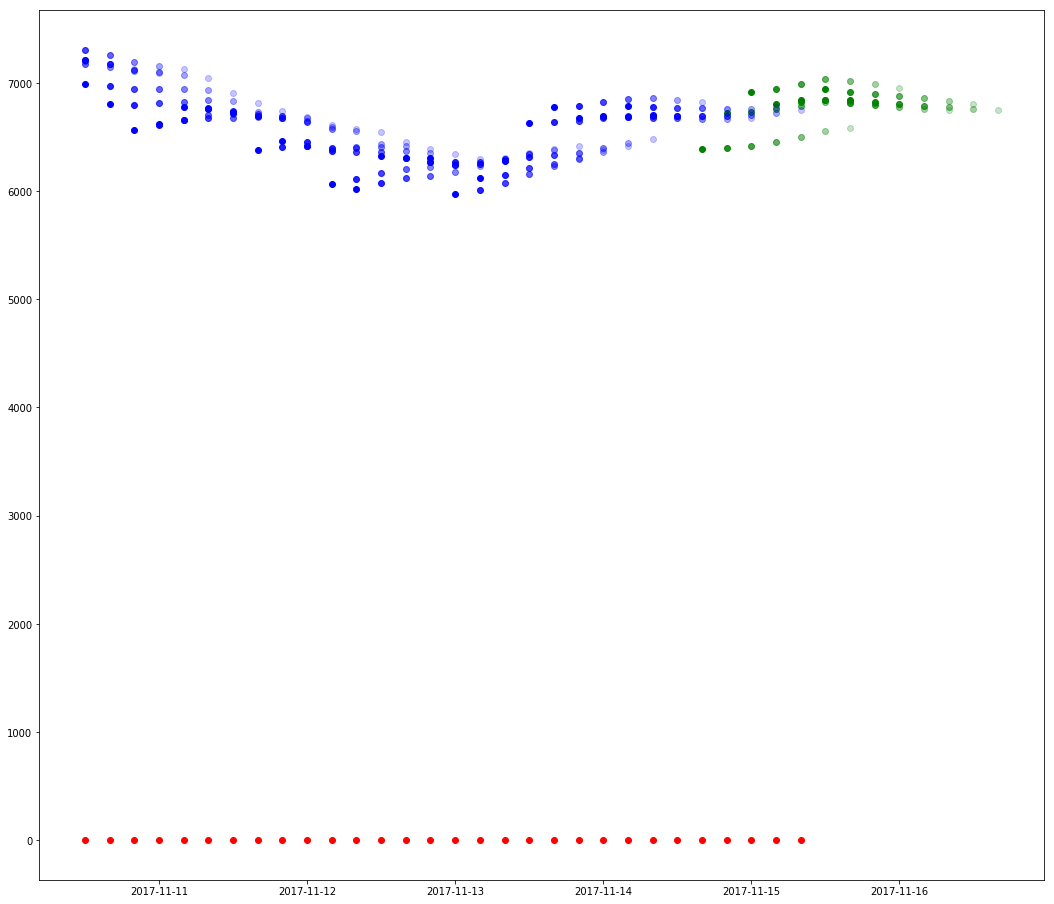

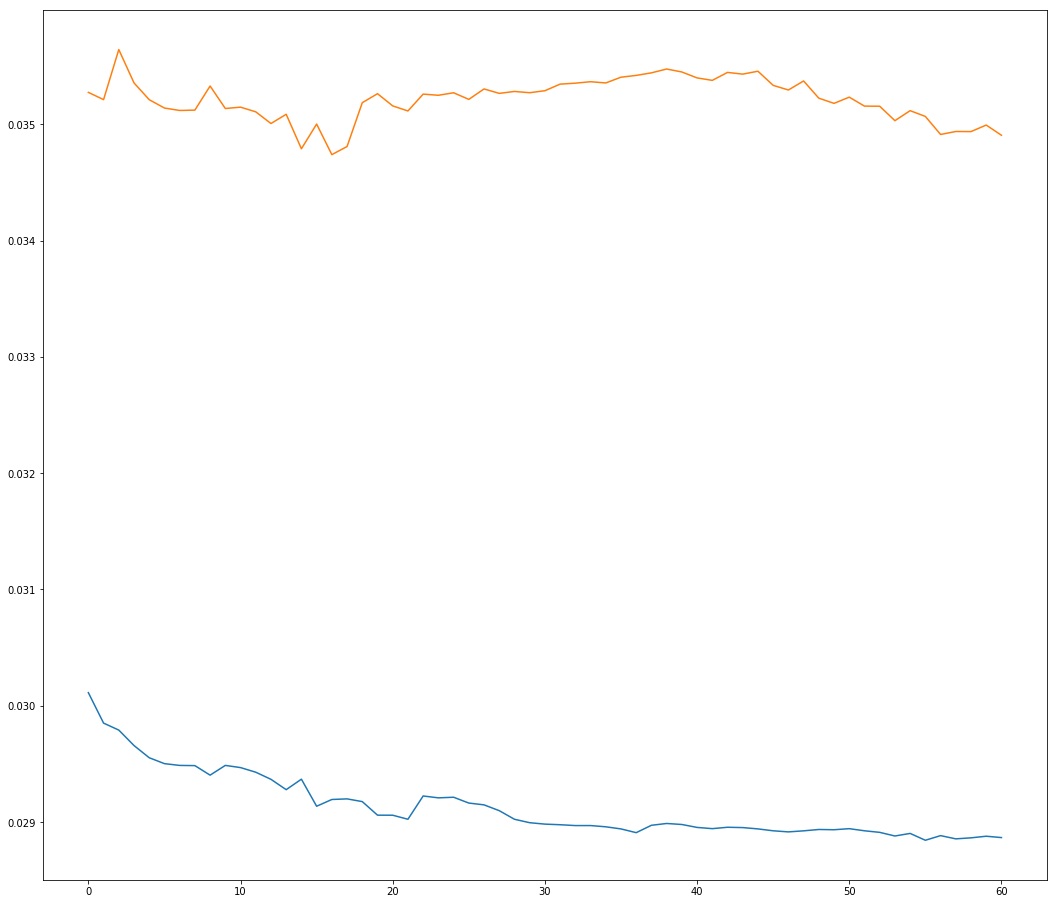

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02887 RMSE
Test Score: 0.03492 RMSE
(9004, 11)
(9011, 11)


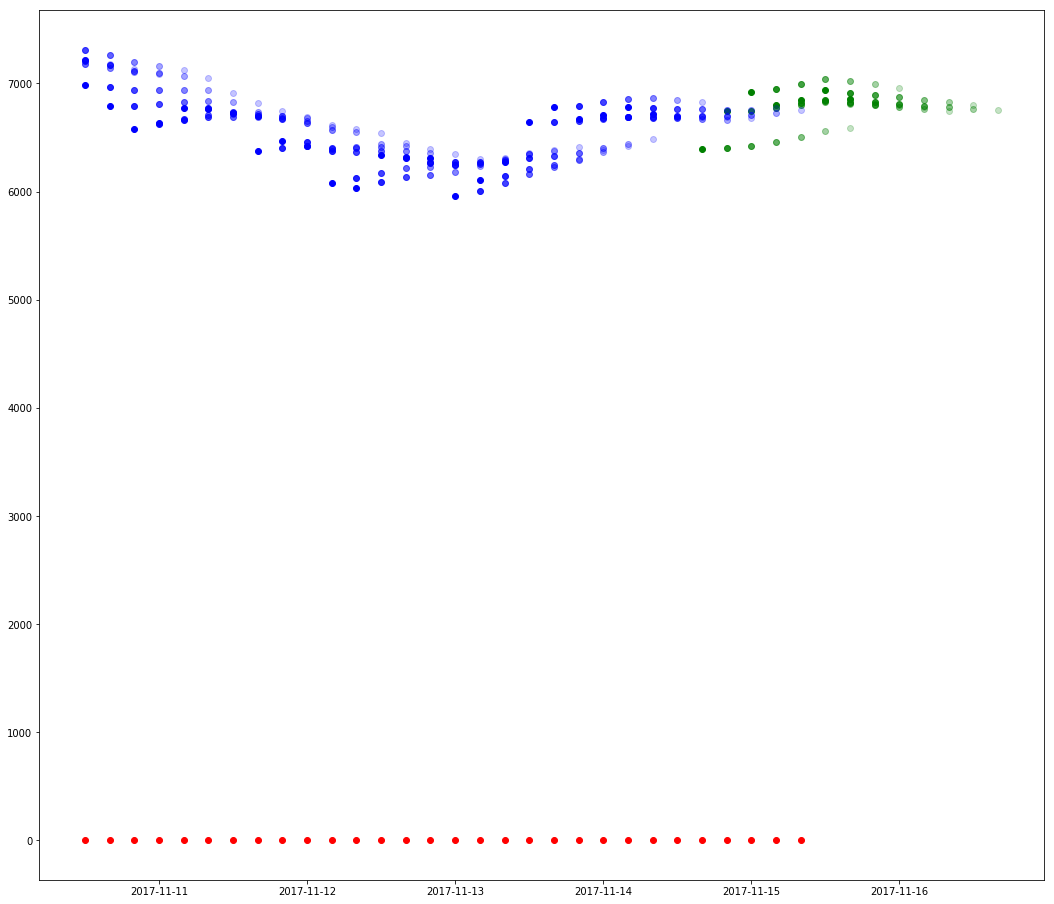

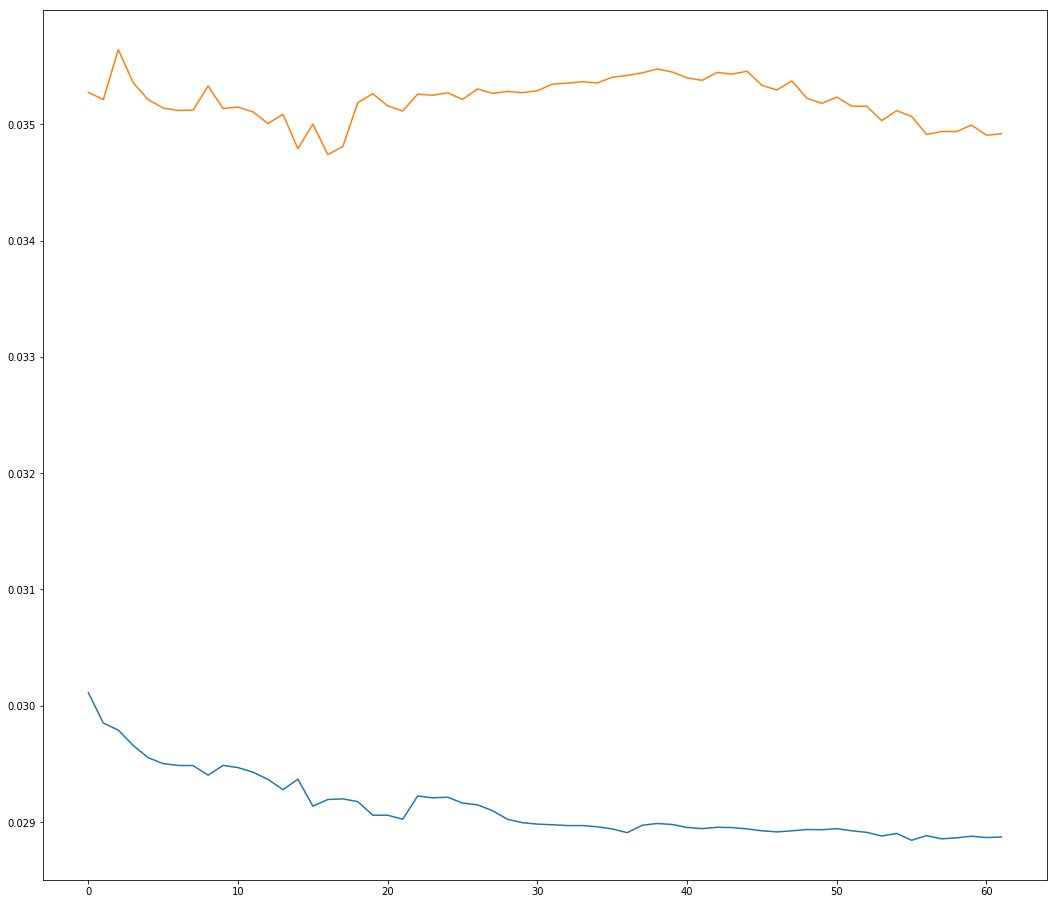

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02887 RMSE
Test Score: 0.03489 RMSE
(9004, 11)
(9011, 11)


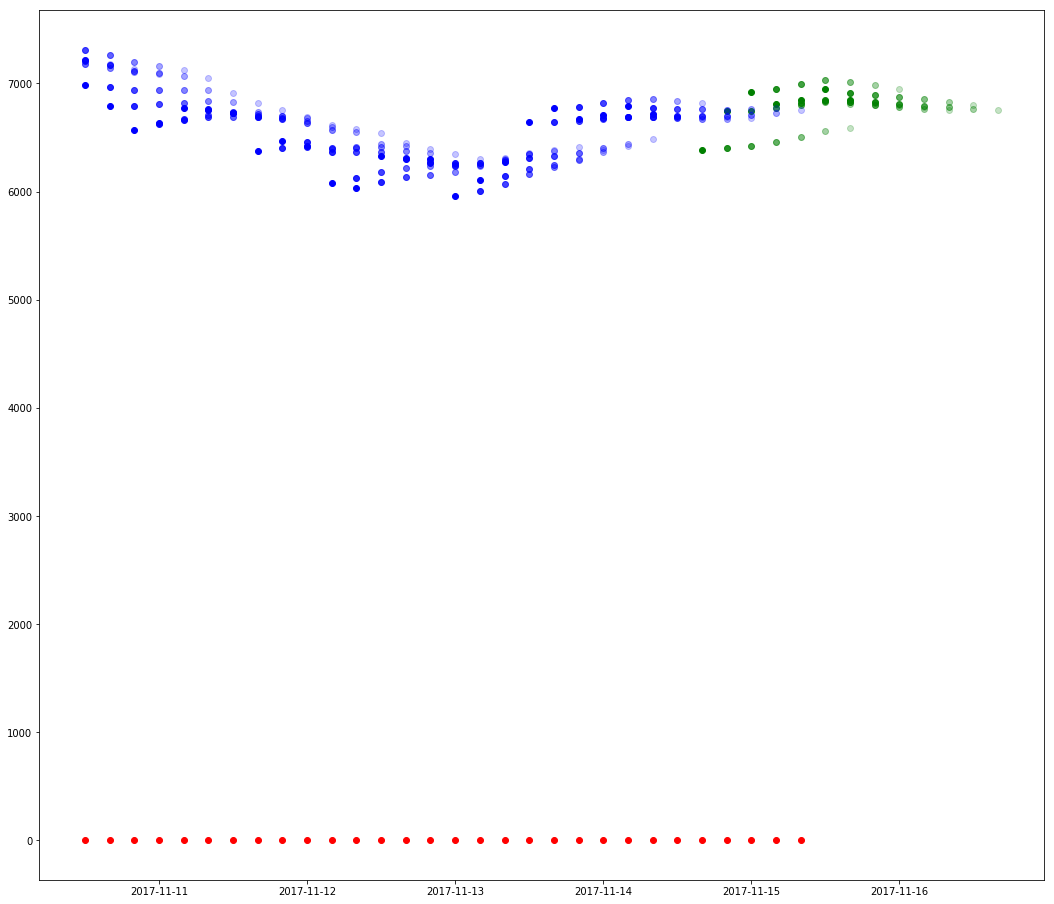

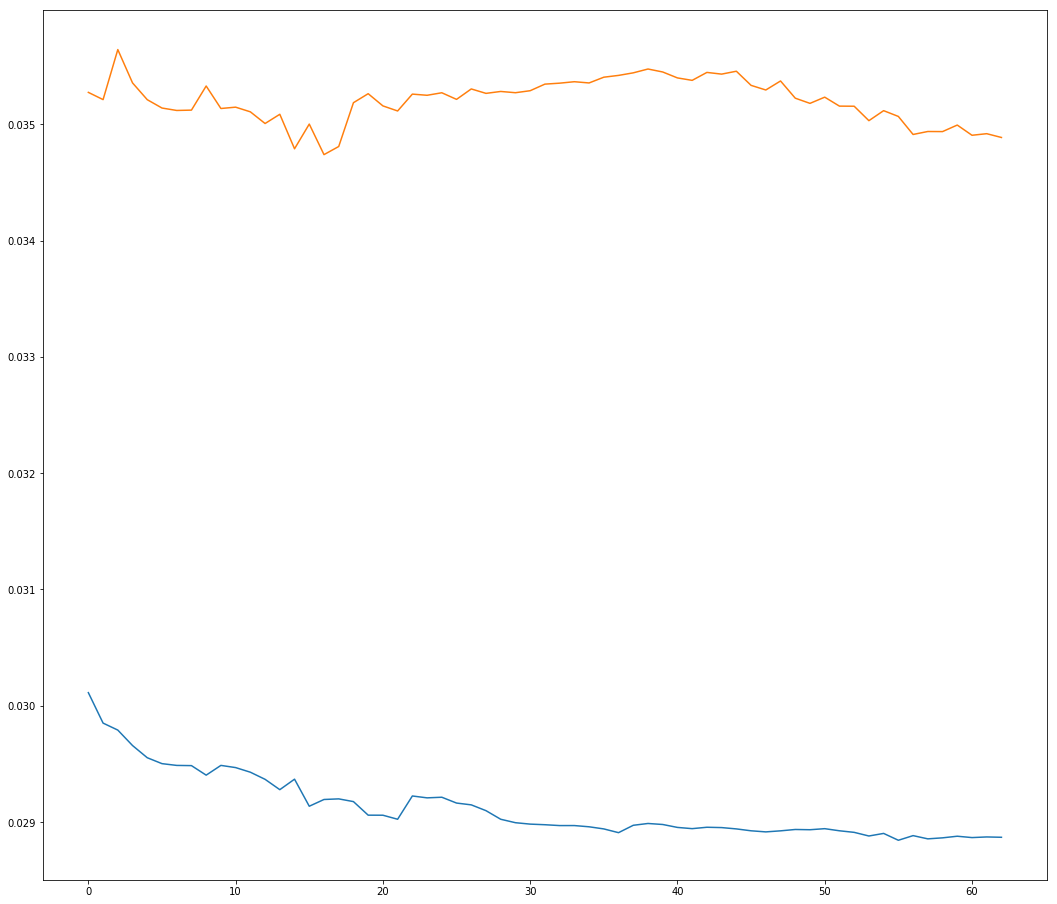

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02891 RMSE
Test Score: 0.03486 RMSE
(9004, 11)
(9011, 11)


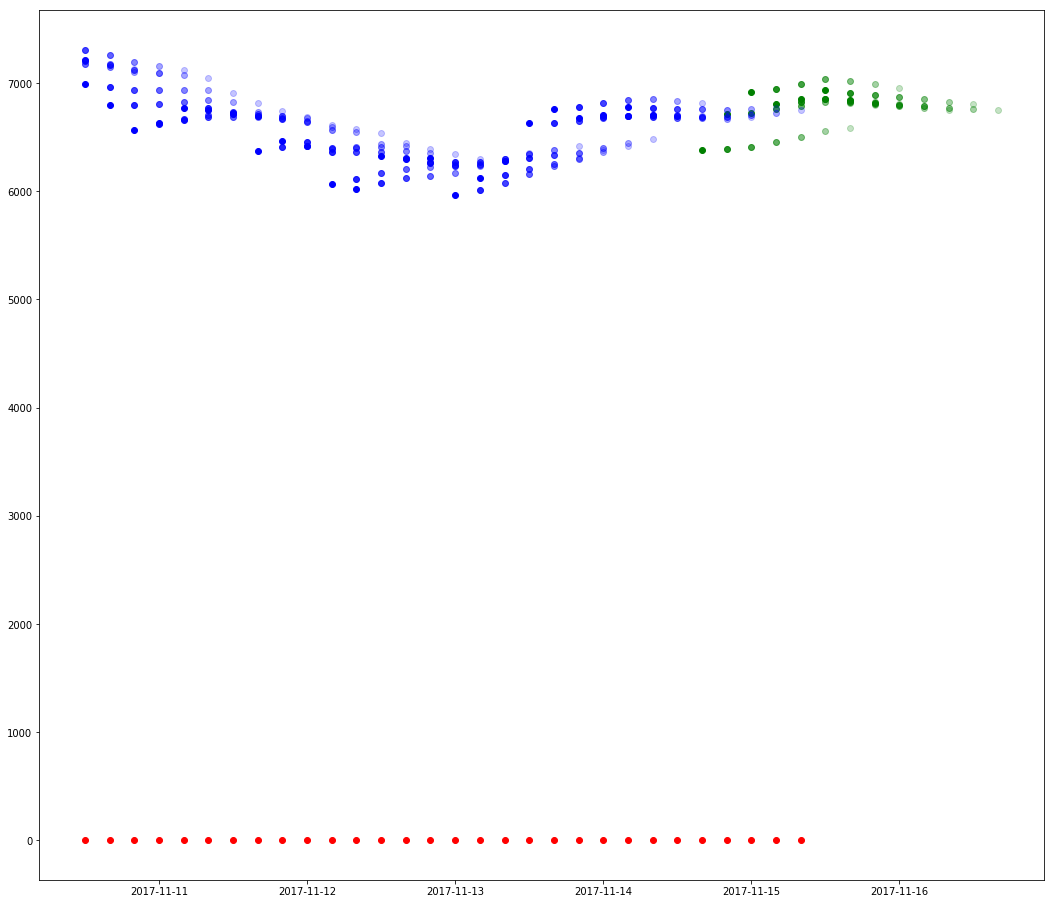

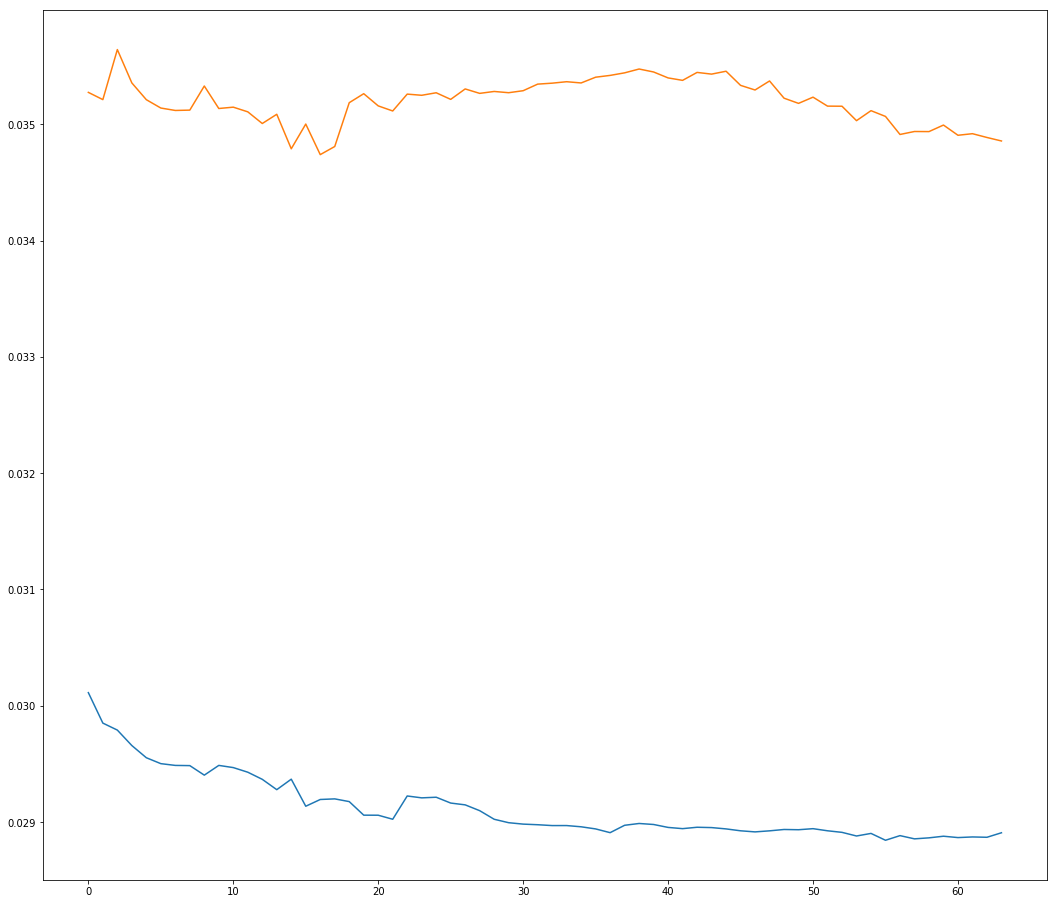

Epoch 1/1
 - 46s - loss: 0.0014
Train Score: 0.02888 RMSE
Test Score: 0.03489 RMSE
(9004, 11)
(9011, 11)


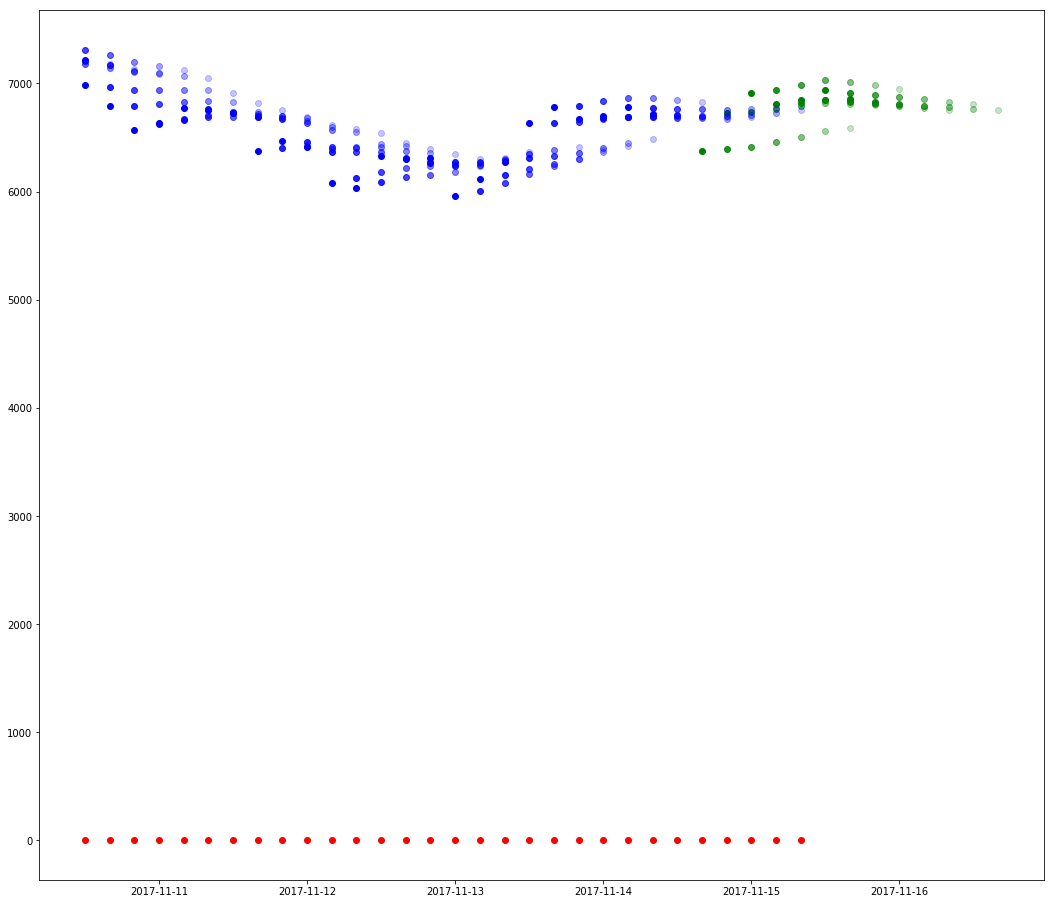

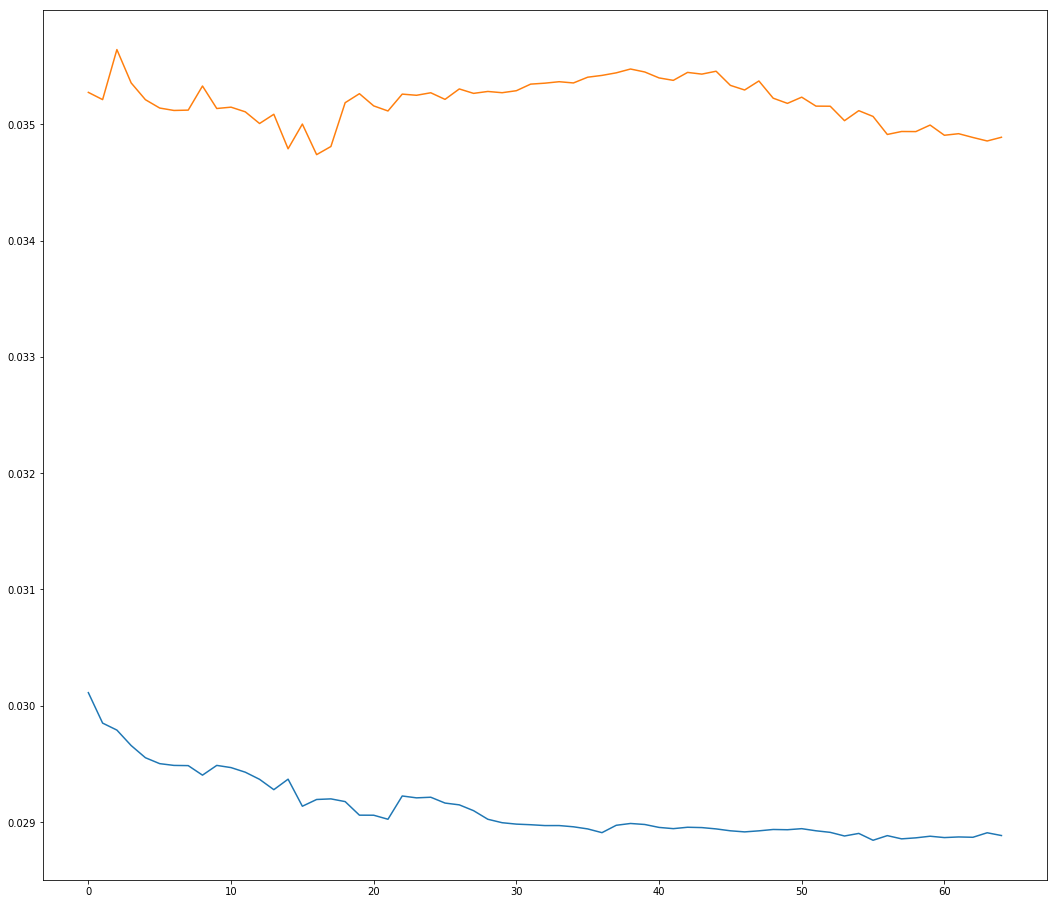

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02888 RMSE
Test Score: 0.03491 RMSE
(9004, 11)
(9011, 11)


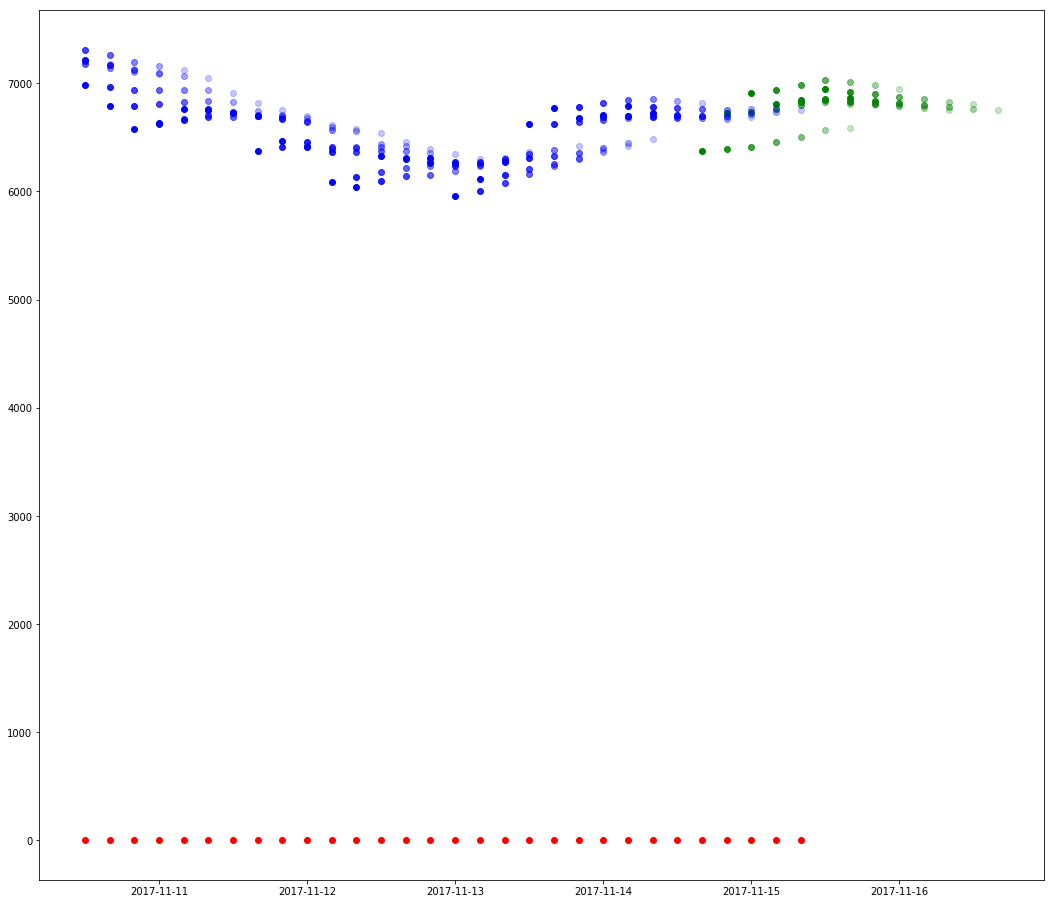

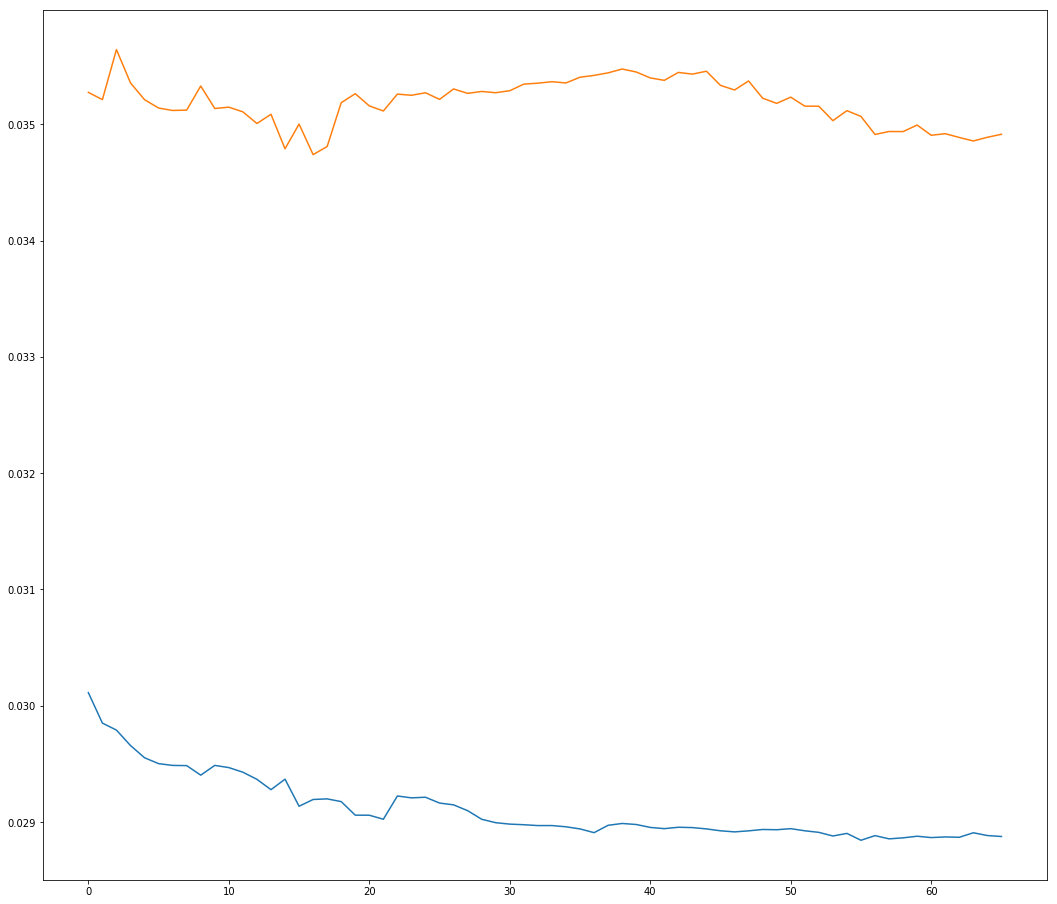

Epoch 1/1
 - 48s - loss: 0.0014
Train Score: 0.02887 RMSE
Test Score: 0.03494 RMSE
(9004, 11)
(9011, 11)


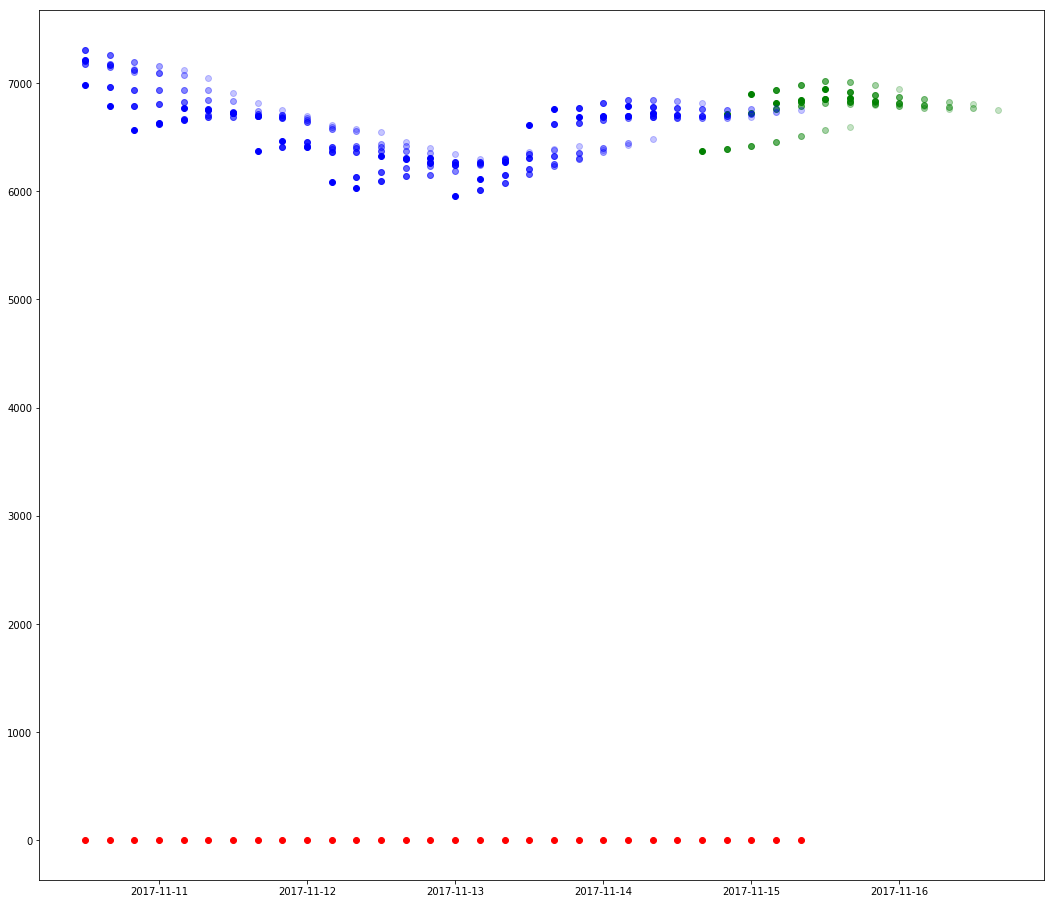

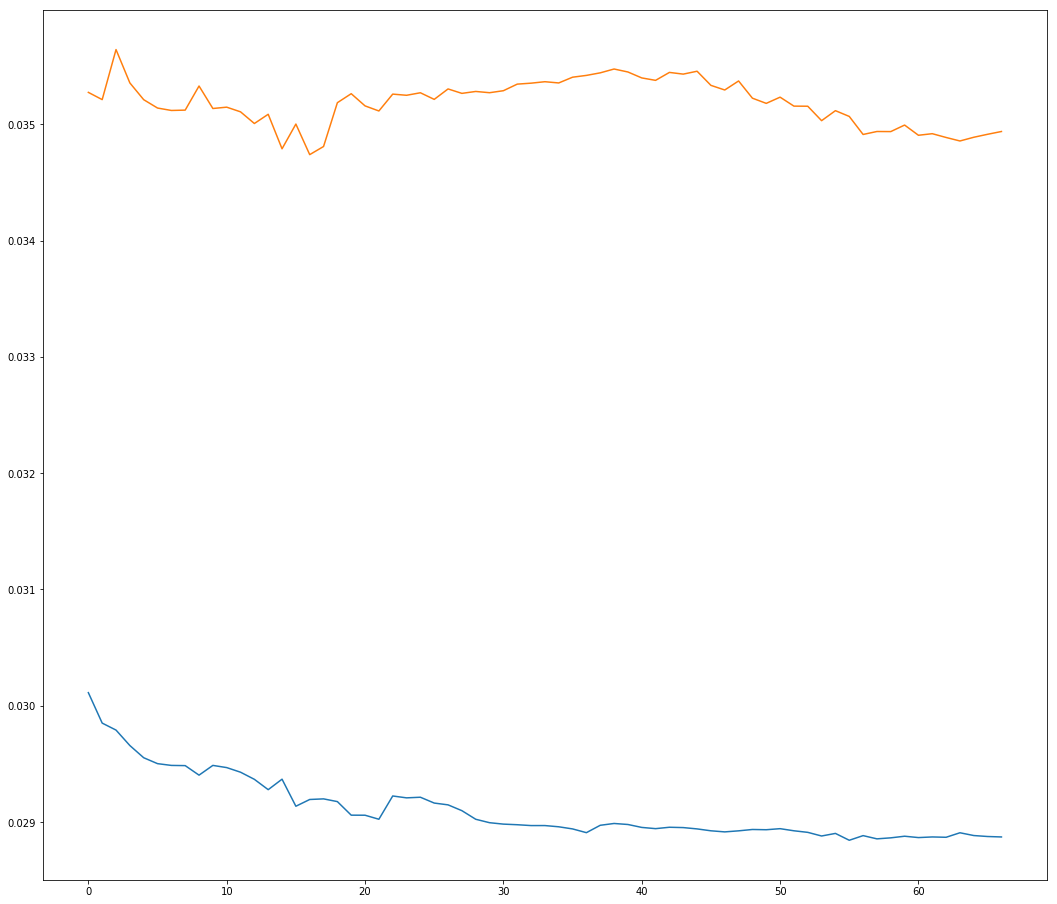

Epoch 1/1
 - 49s - loss: 0.0014
Train Score: 0.02886 RMSE
Test Score: 0.03490 RMSE
(9004, 11)
(9011, 11)


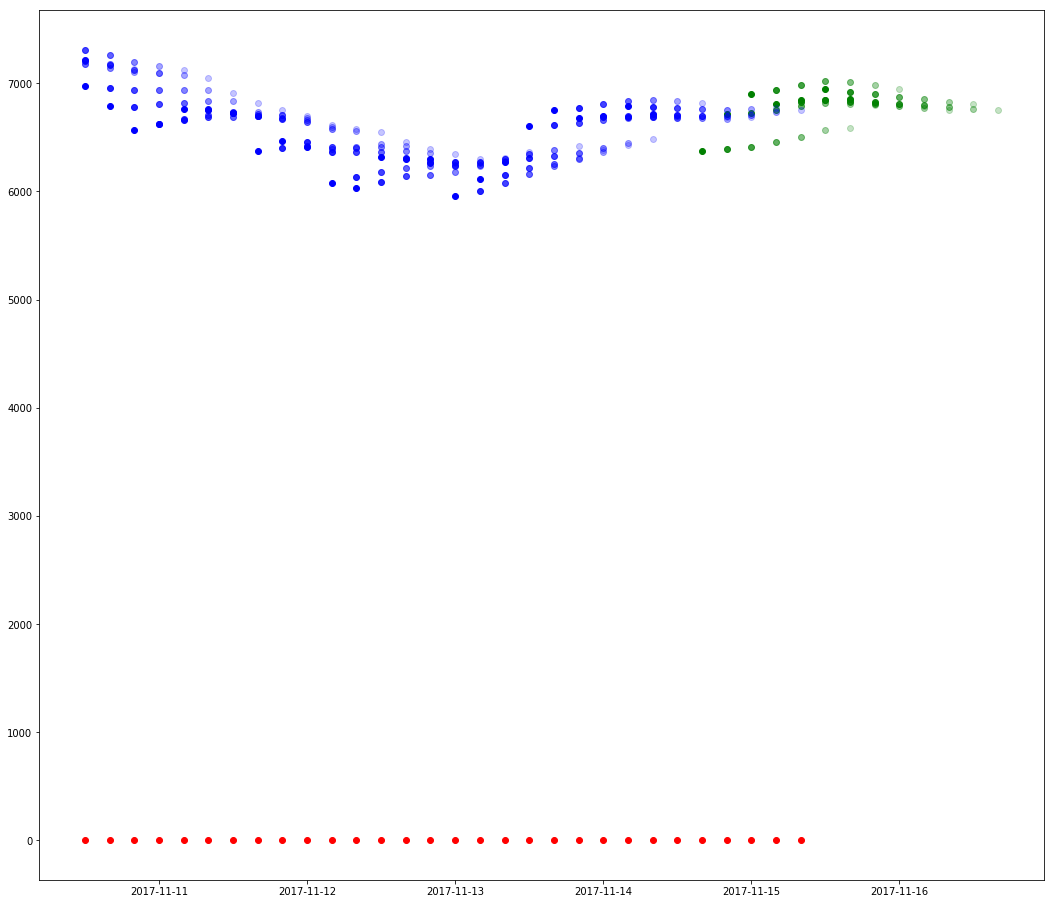

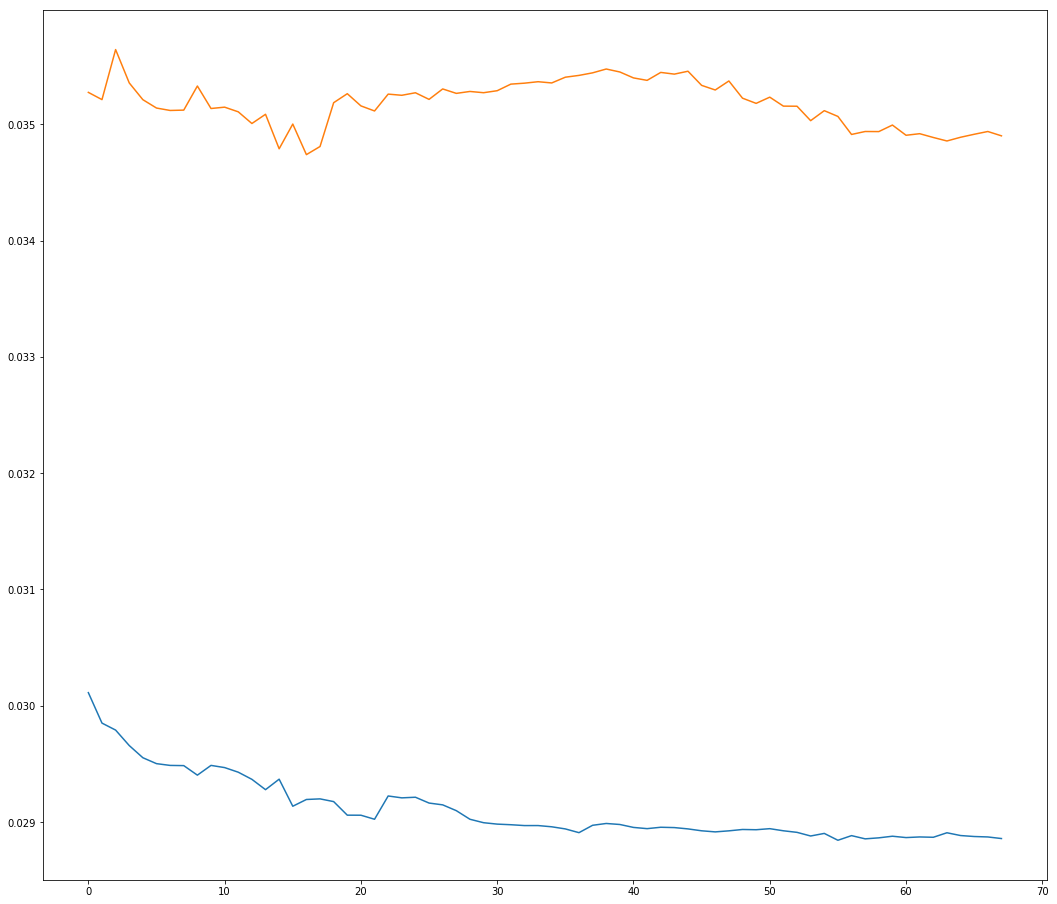

Epoch 1/1
 - 48s - loss: 0.0014
Train Score: 0.02885 RMSE
Test Score: 0.03490 RMSE
(9004, 11)
(9011, 11)


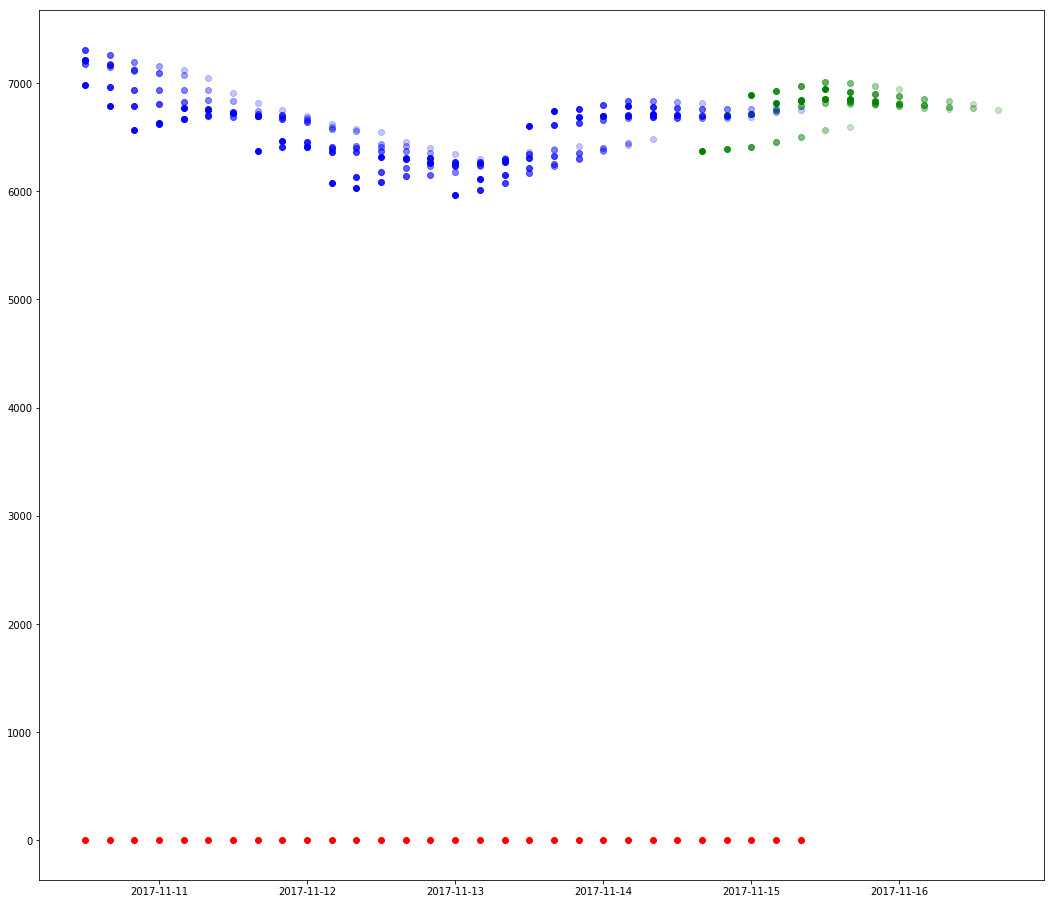

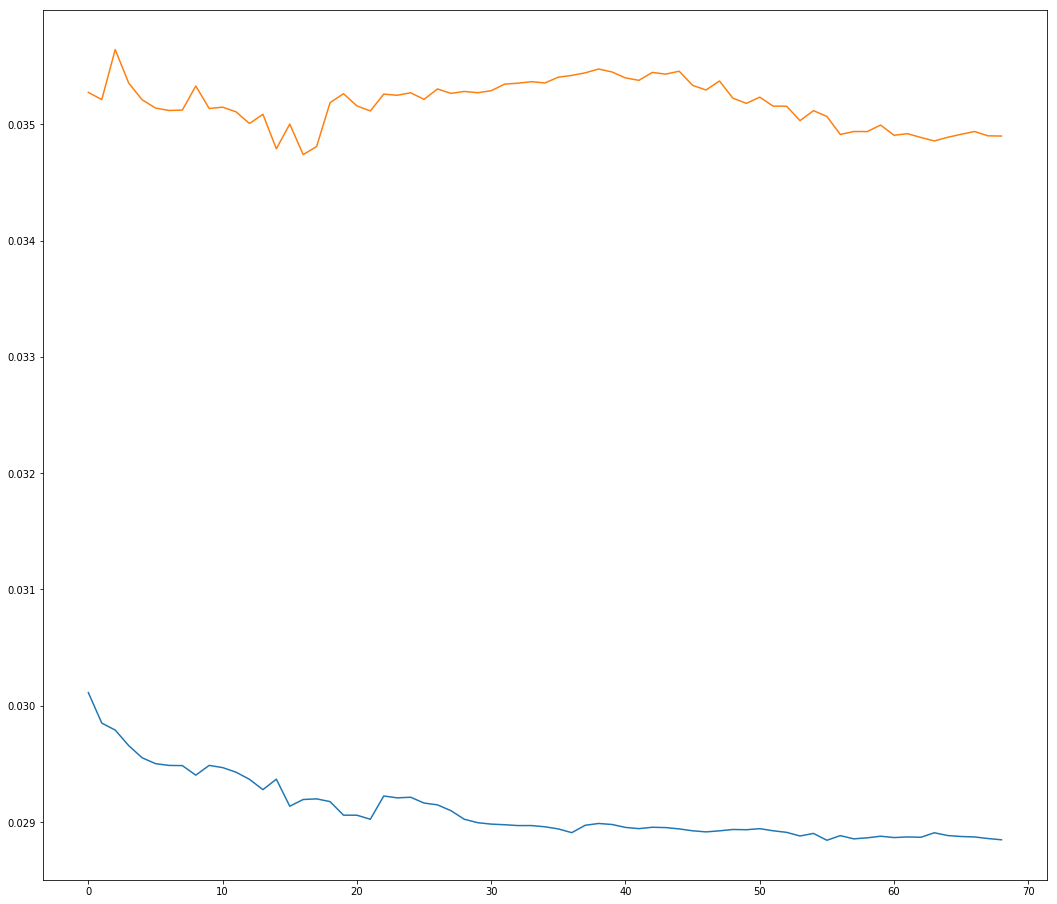

Epoch 1/1
 - 49s - loss: 0.0014
Train Score: 0.02881 RMSE
Test Score: 0.03487 RMSE
(9004, 11)
(9011, 11)


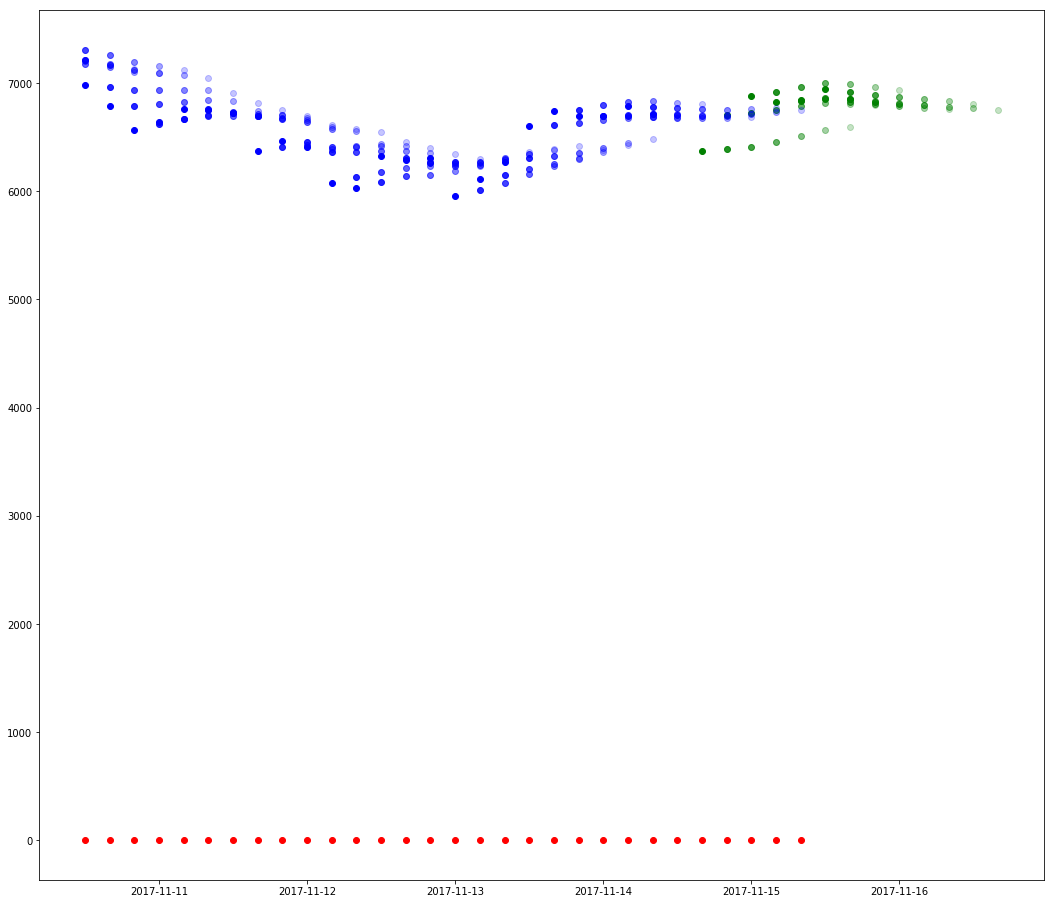

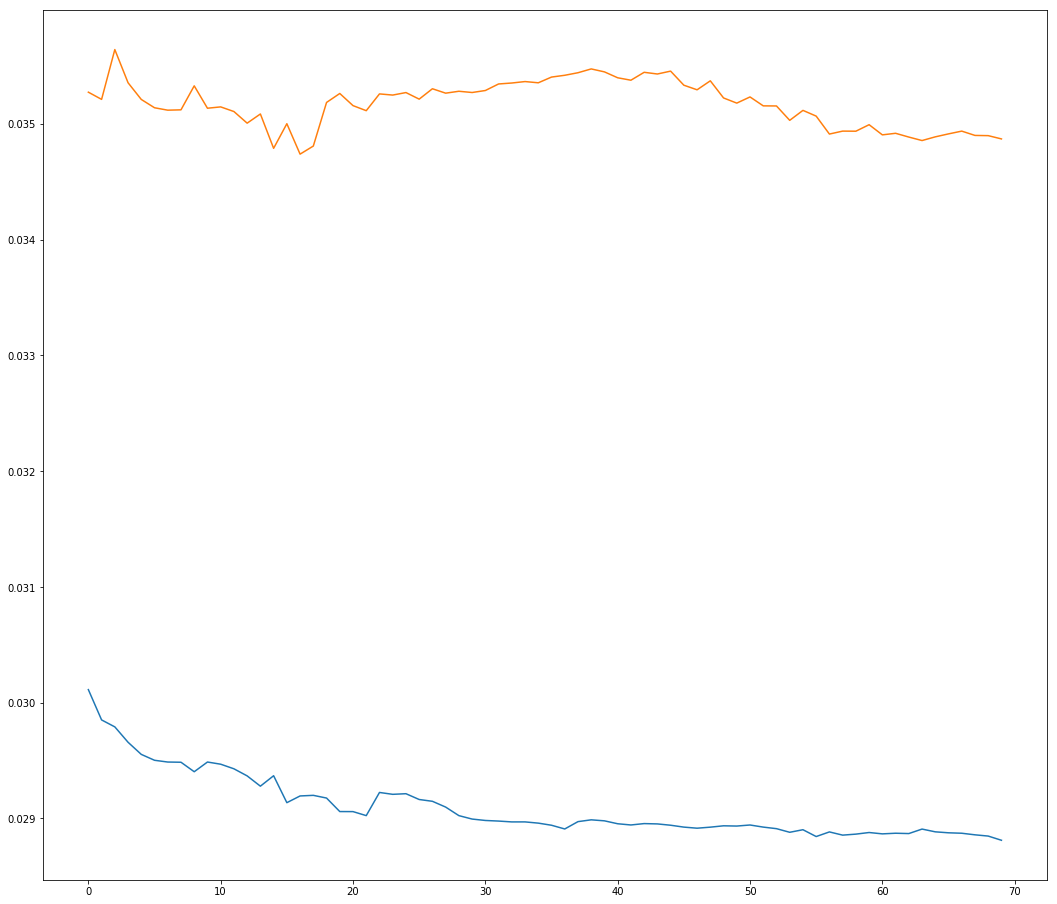

Epoch 1/1
 - 48s - loss: 0.0014
Train Score: 0.02882 RMSE
Test Score: 0.03488 RMSE
(9004, 11)
(9011, 11)


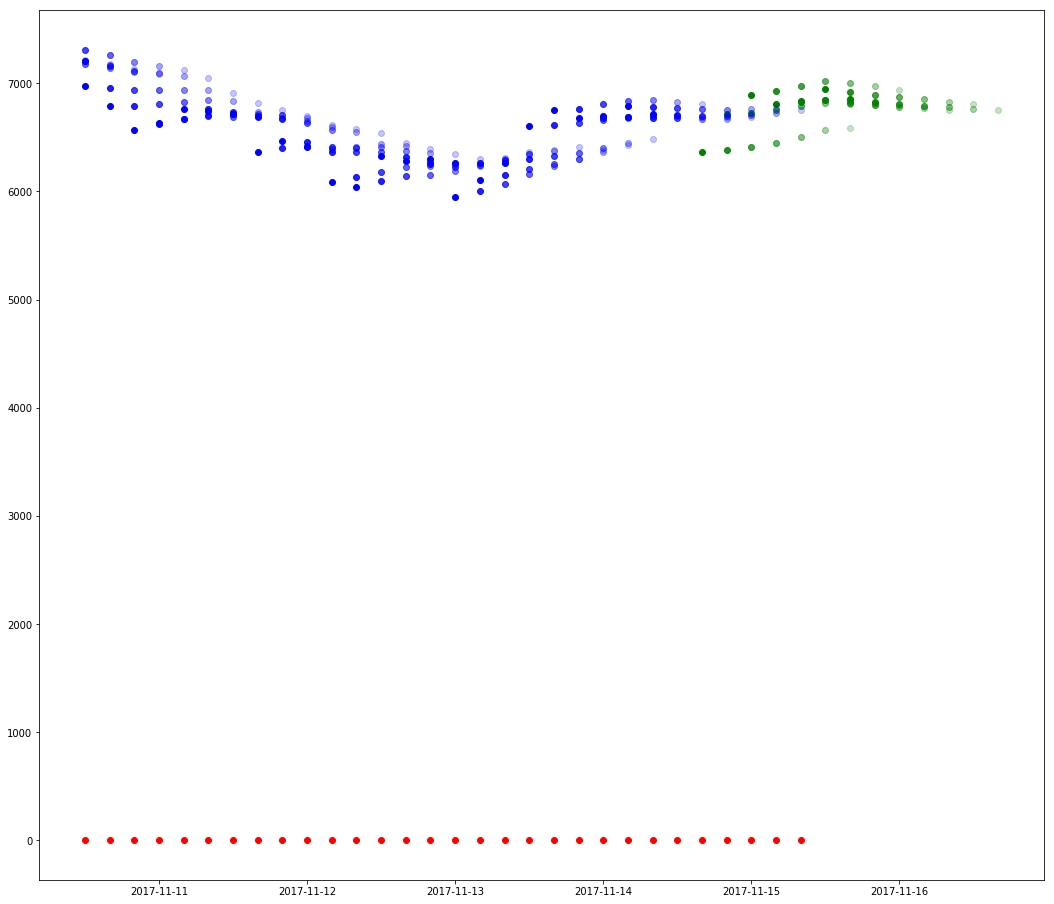

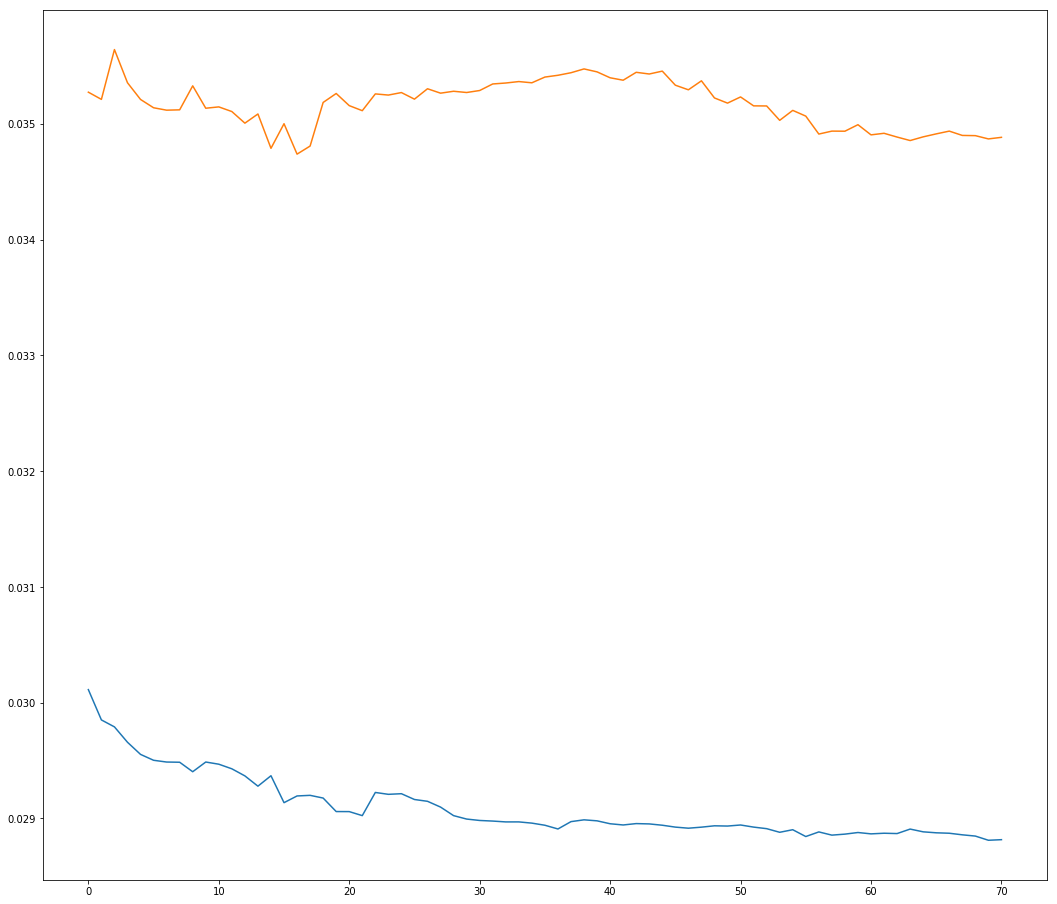

Epoch 1/1
 - 49s - loss: 0.0014
Train Score: 0.02877 RMSE
Test Score: 0.03487 RMSE
(9004, 11)
(9011, 11)


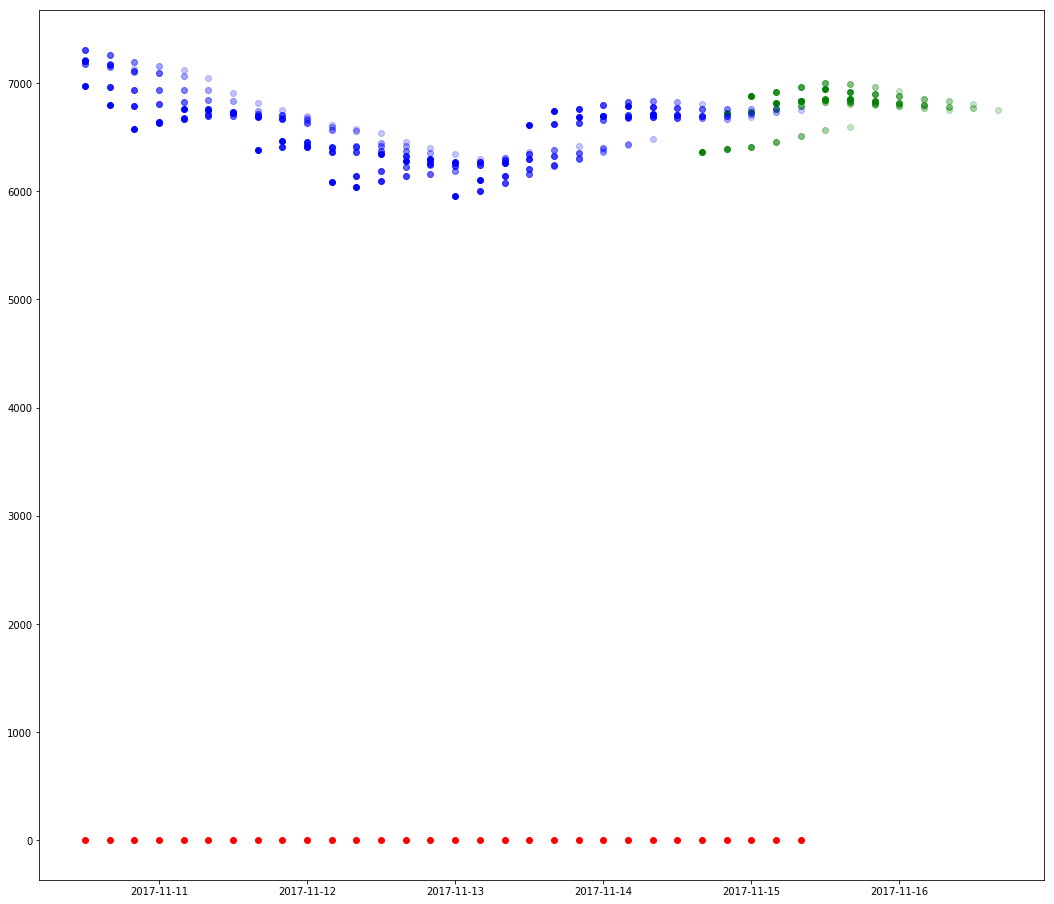

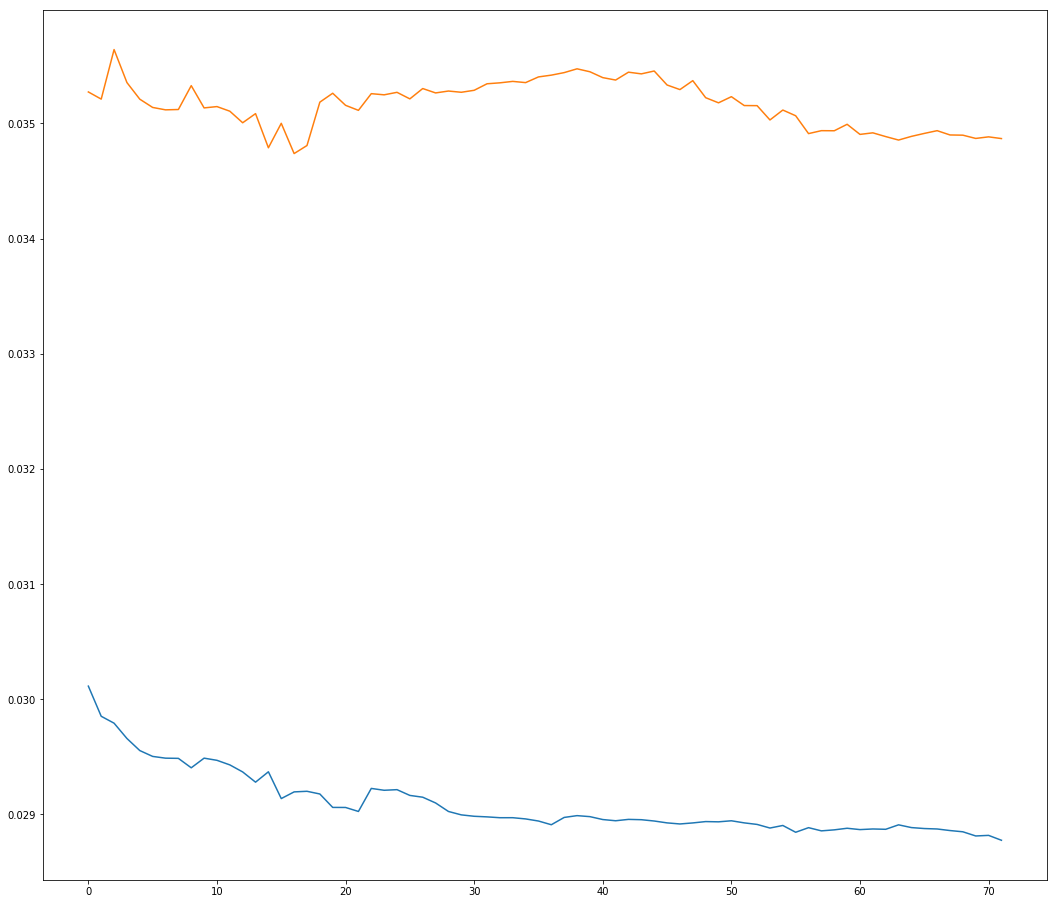

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02878 RMSE
Test Score: 0.03486 RMSE
(9004, 11)
(9011, 11)


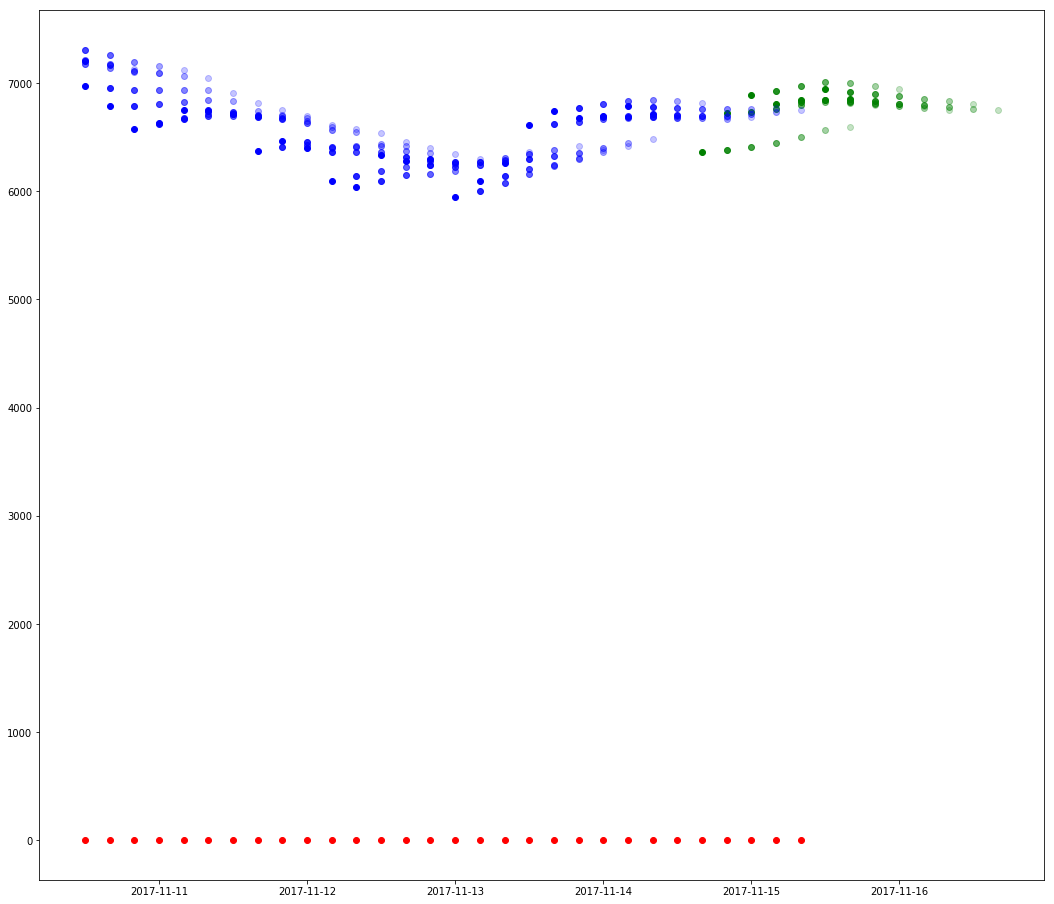

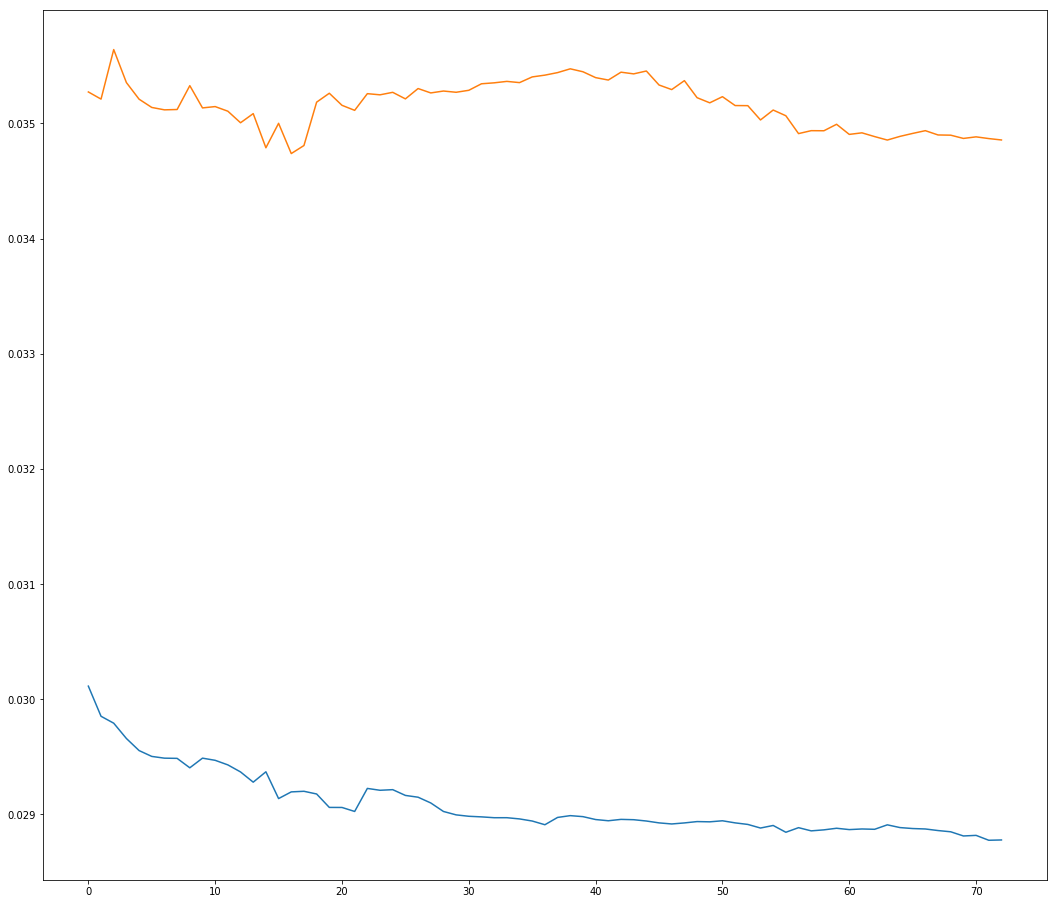

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02872 RMSE
Test Score: 0.03496 RMSE
(9004, 11)
(9011, 11)


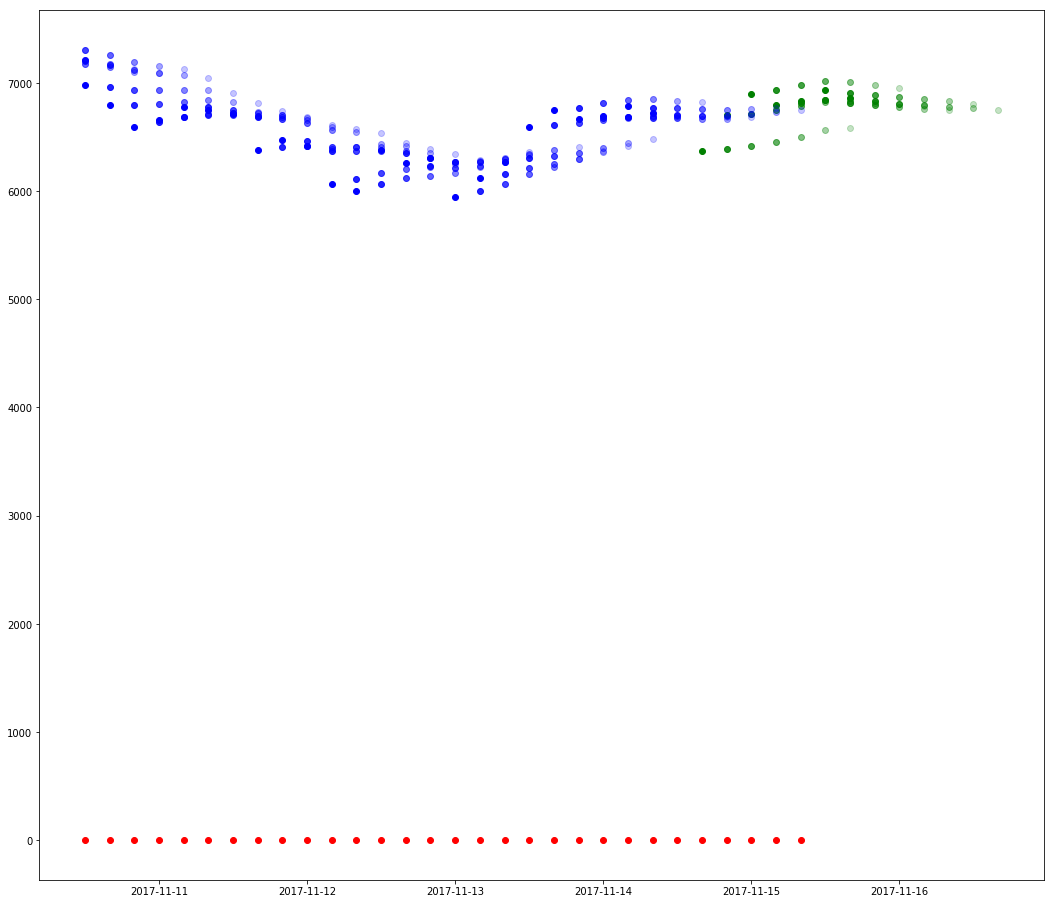

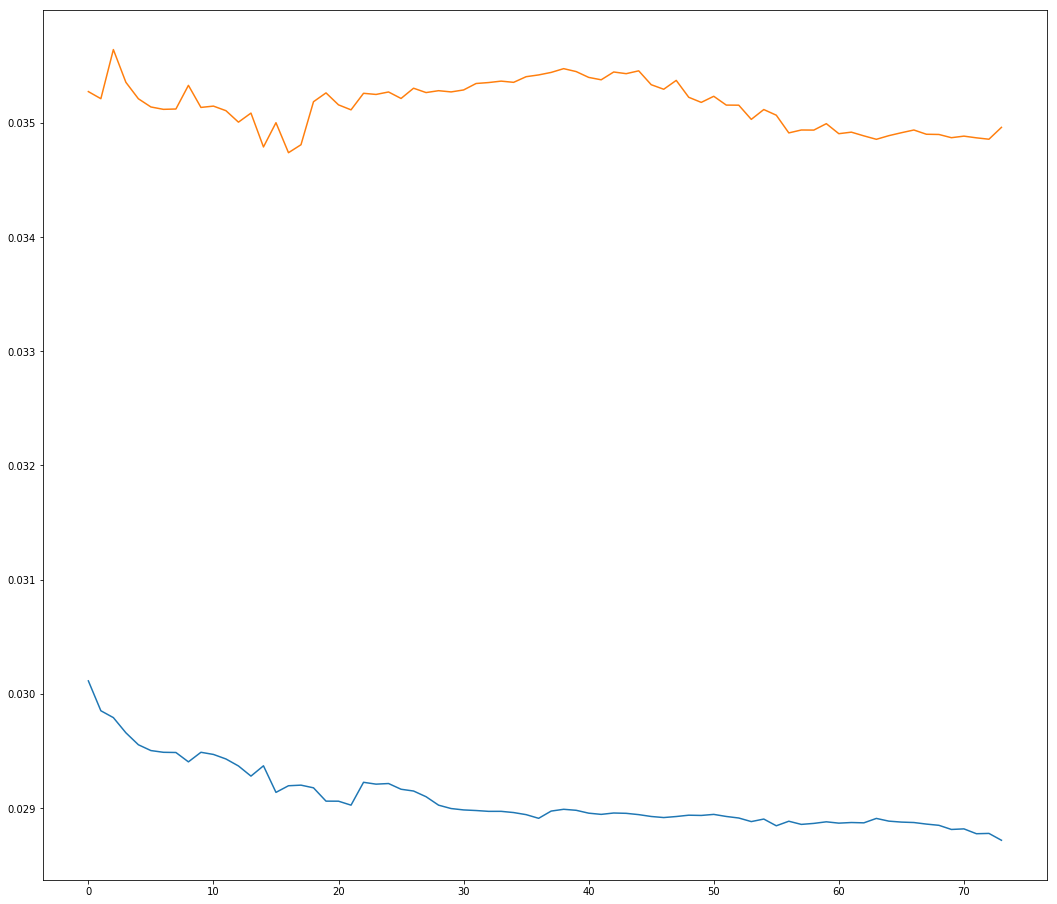

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02870 RMSE
Test Score: 0.03487 RMSE
(9004, 11)
(9011, 11)


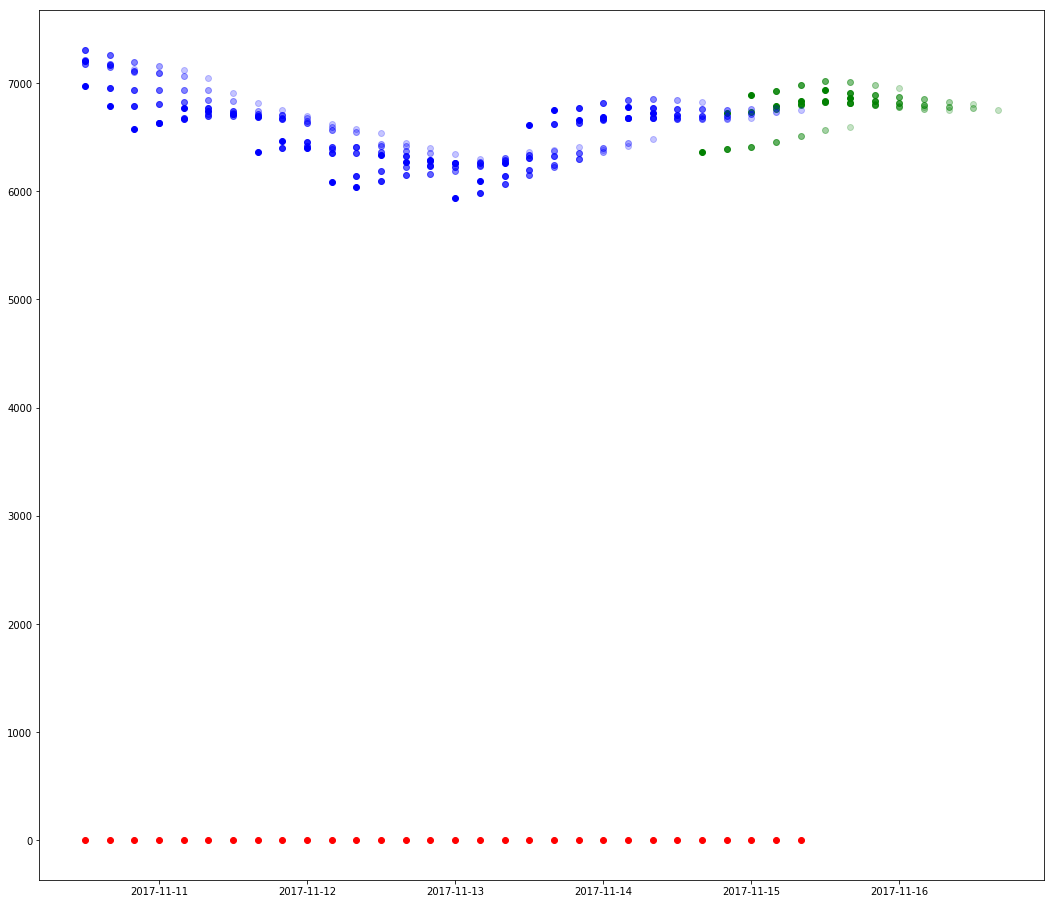

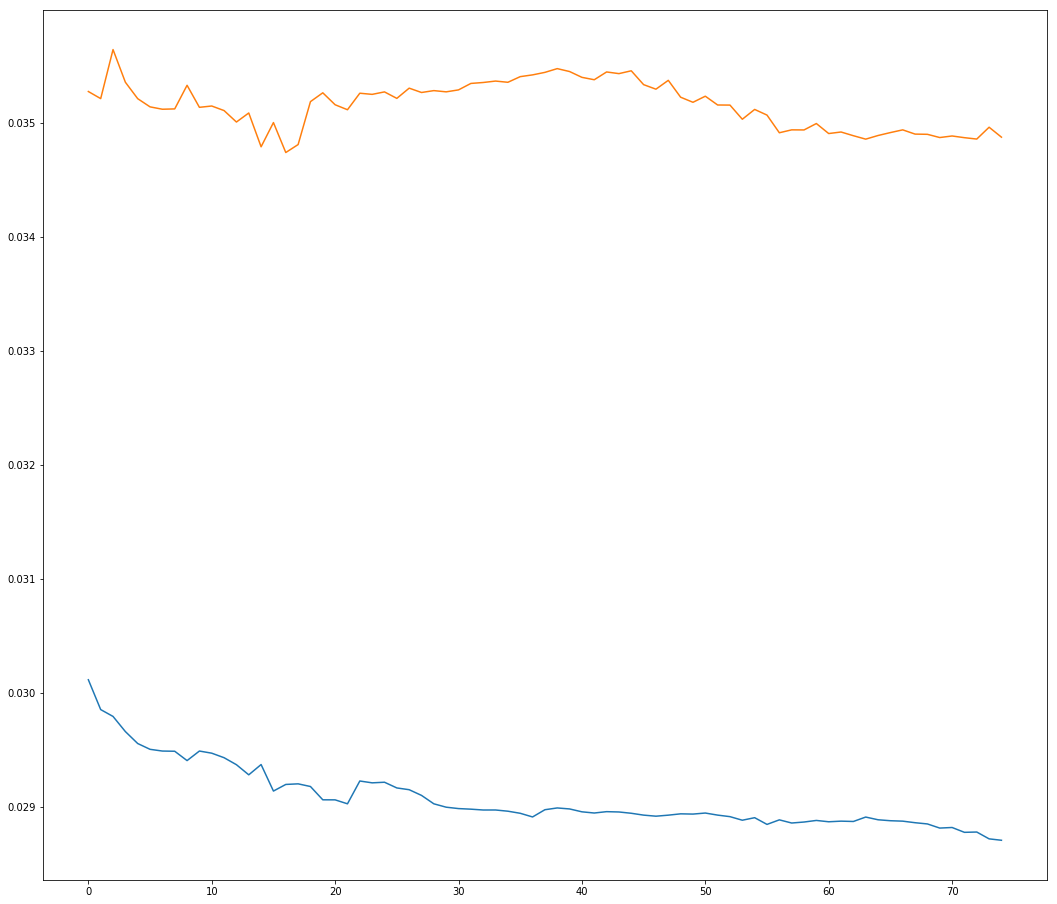

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02871 RMSE
Test Score: 0.03500 RMSE
(9004, 11)
(9011, 11)


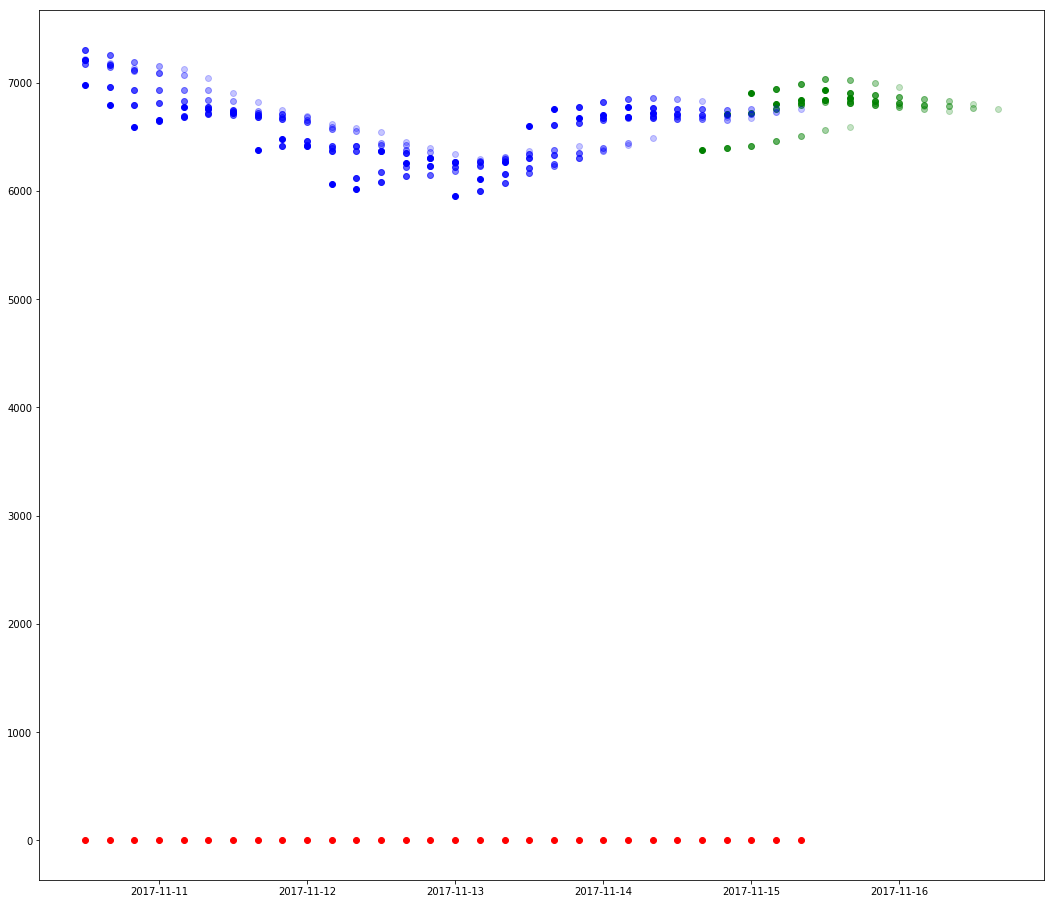

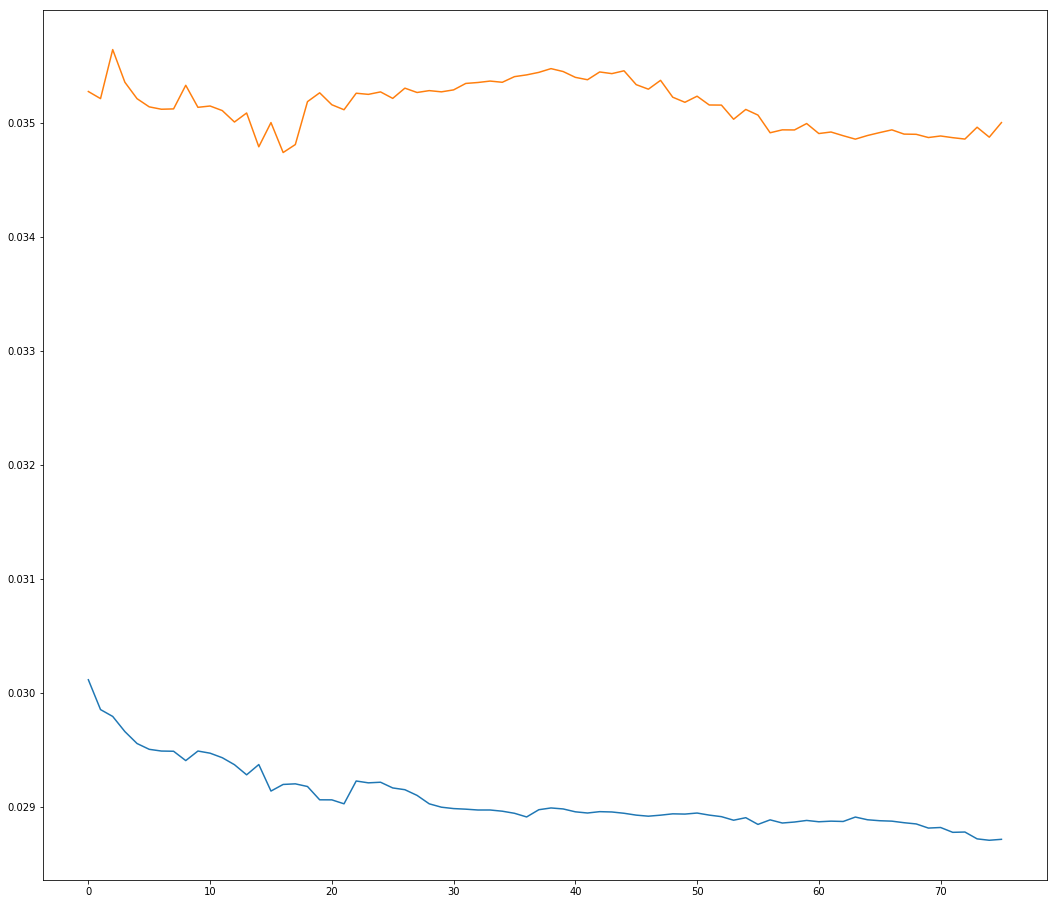

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02867 RMSE
Test Score: 0.03491 RMSE
(9004, 11)
(9011, 11)


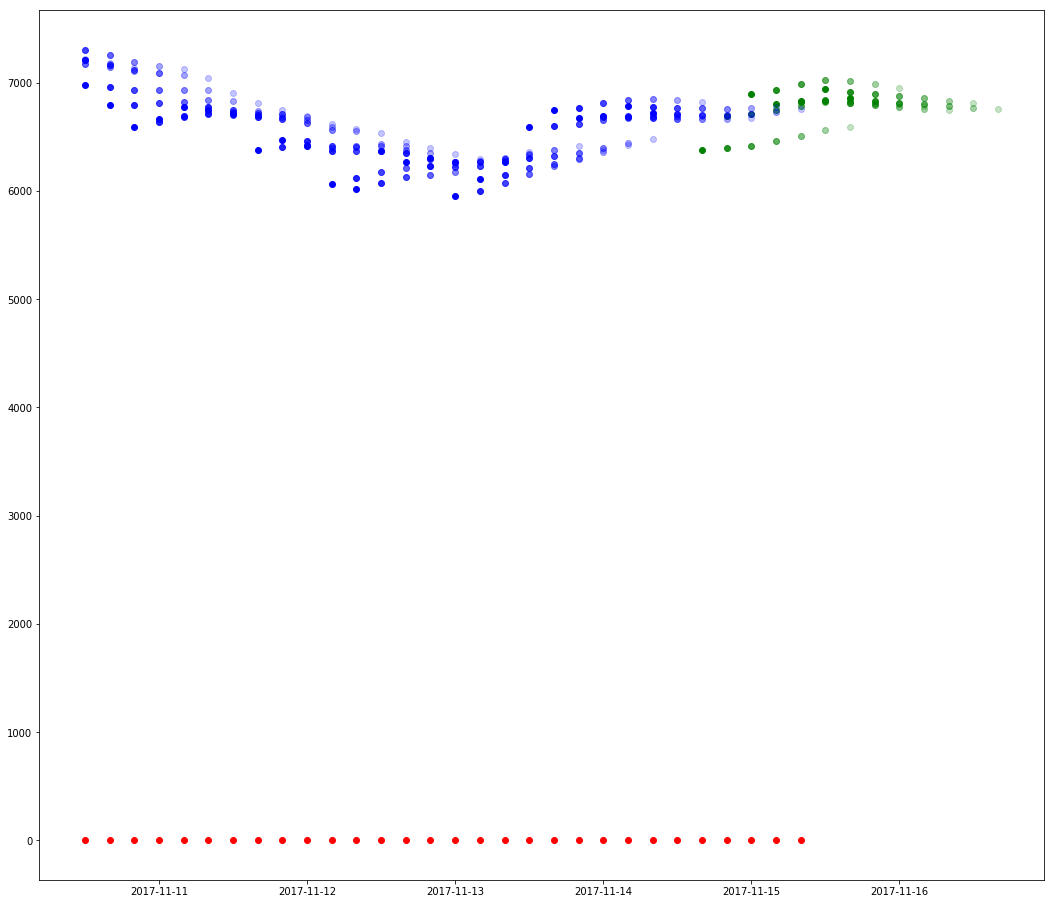

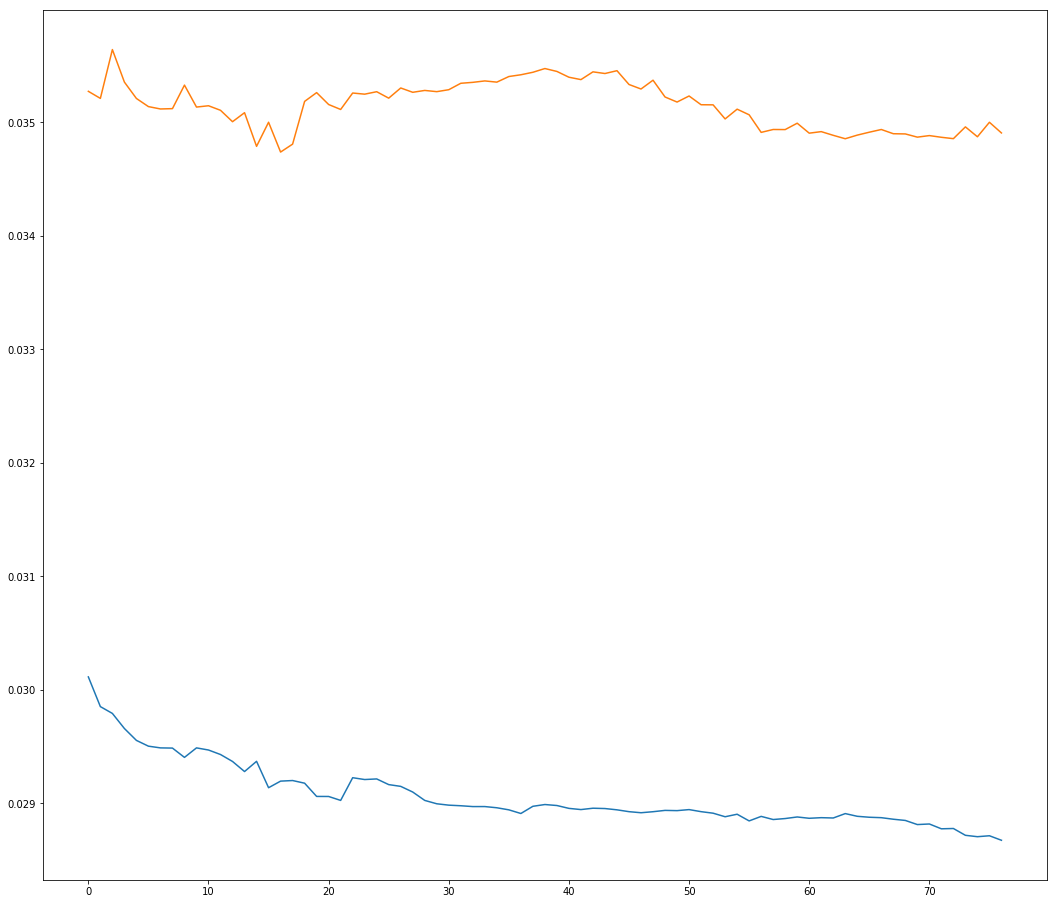

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02869 RMSE
Test Score: 0.03502 RMSE
(9004, 11)
(9011, 11)


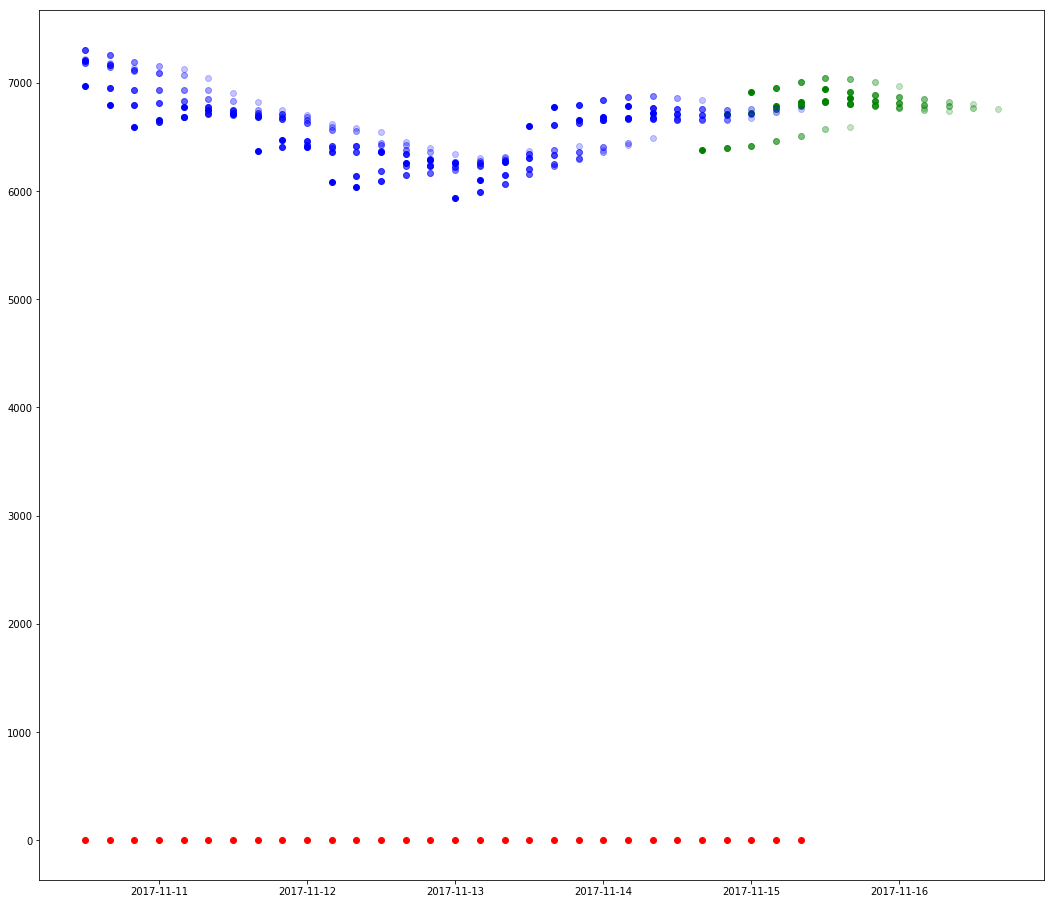

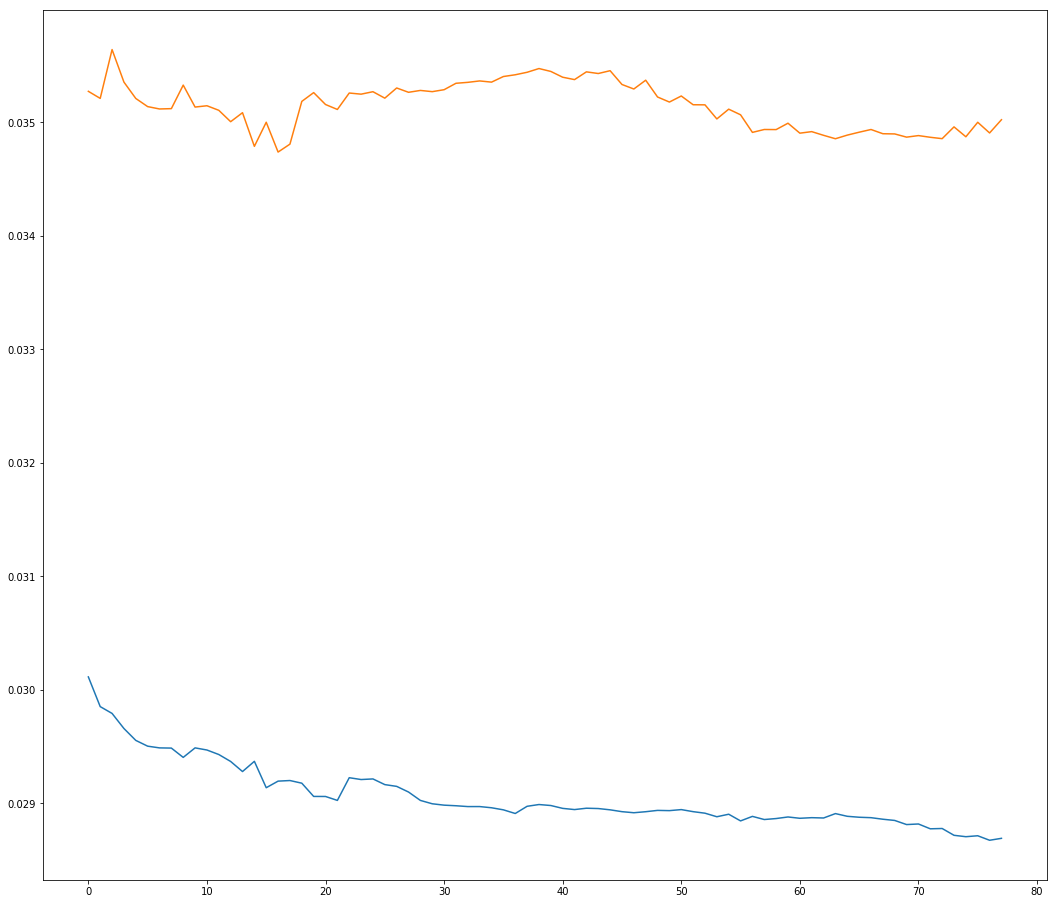

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02854 RMSE
Test Score: 0.03499 RMSE
(9004, 11)
(9011, 11)


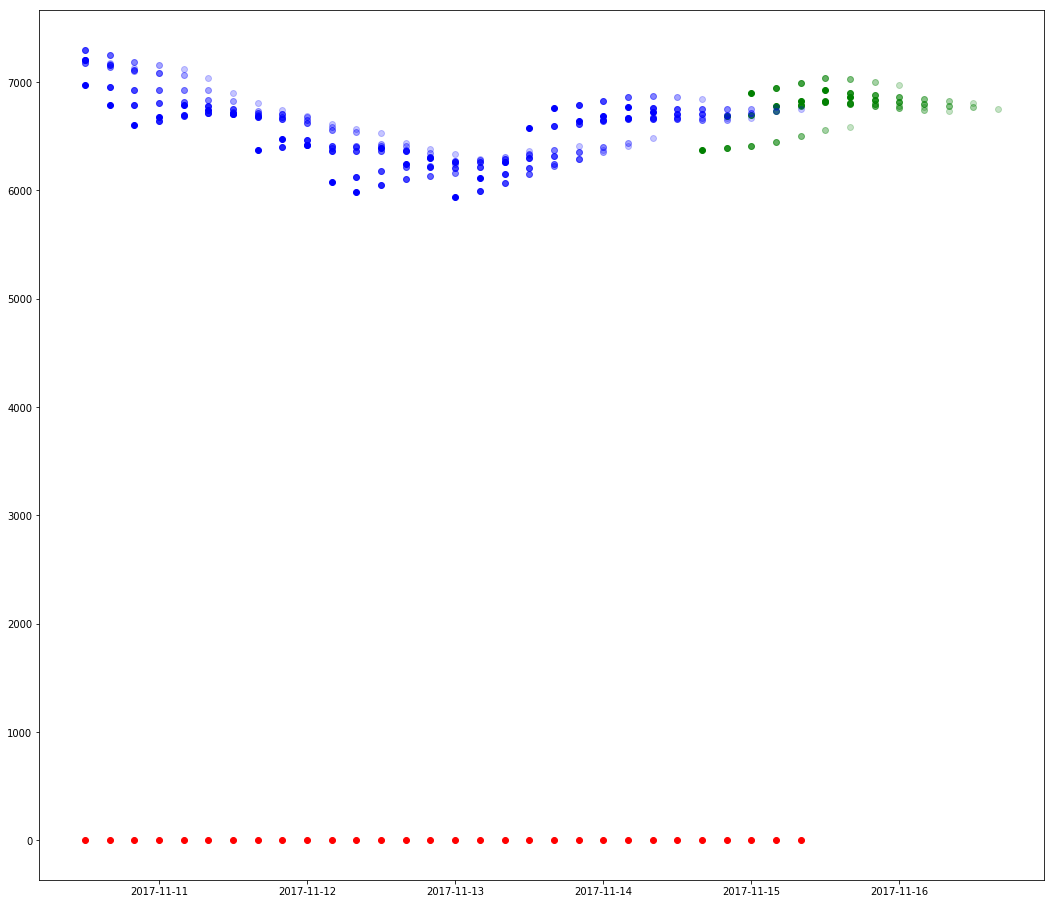

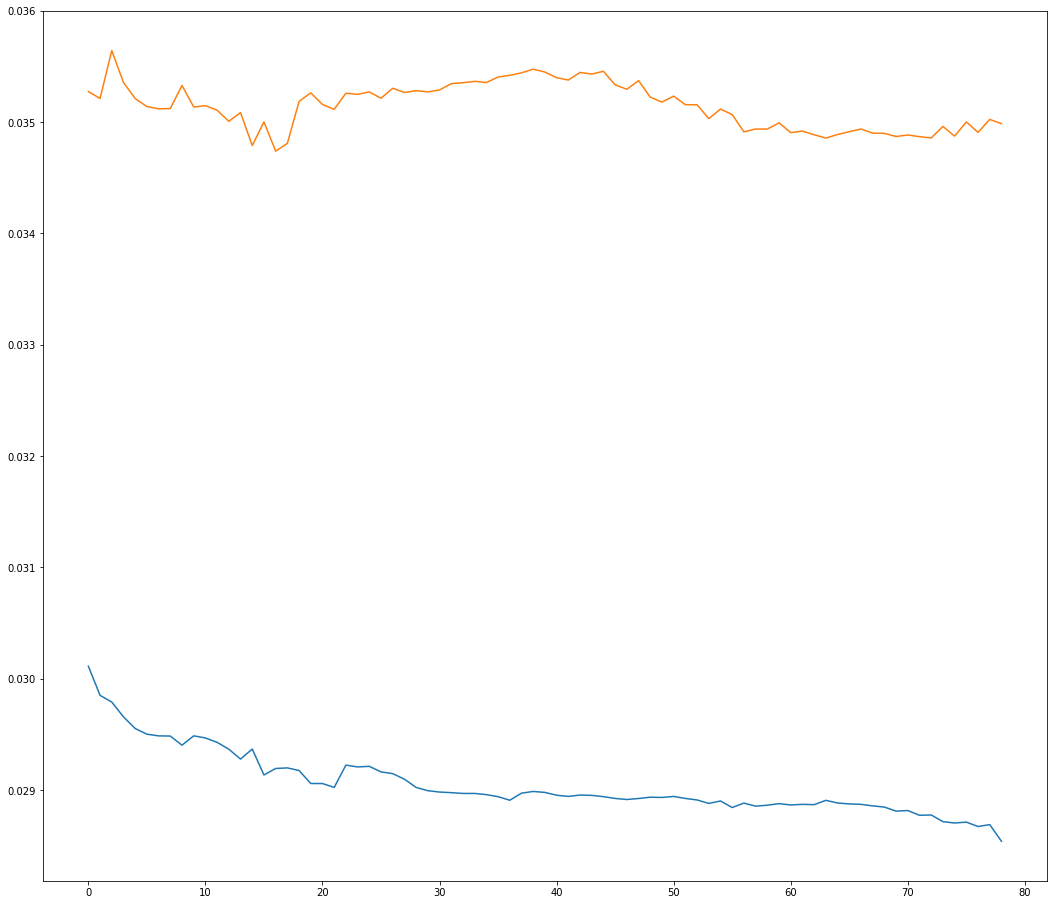

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02859 RMSE
Test Score: 0.03499 RMSE
(9004, 11)
(9011, 11)


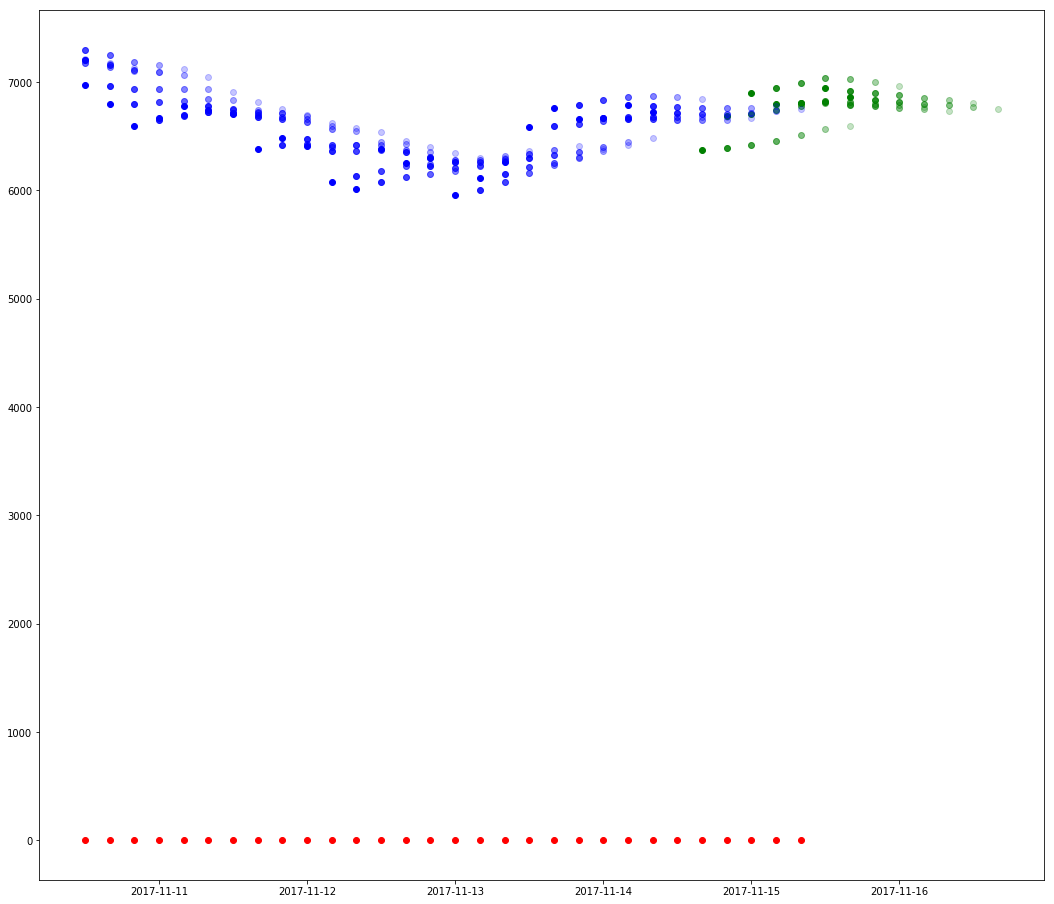

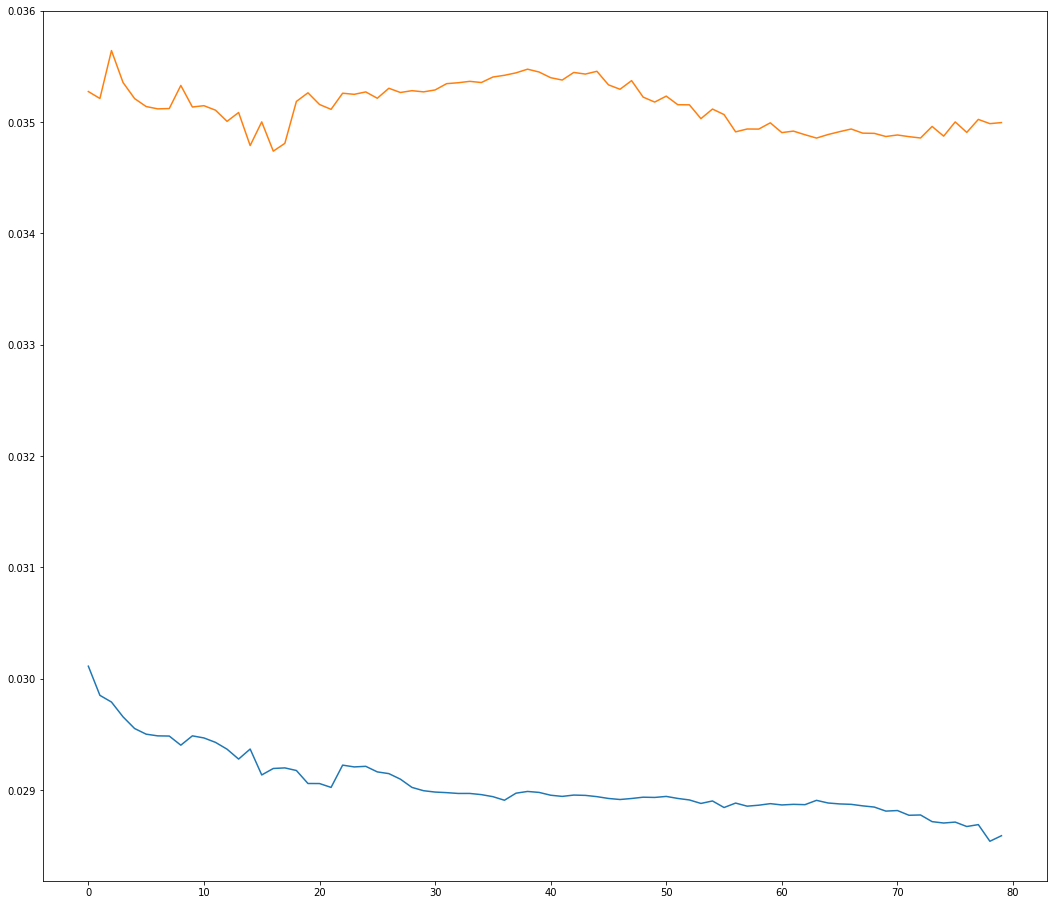

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02848 RMSE
Test Score: 0.03492 RMSE
(9004, 11)
(9011, 11)


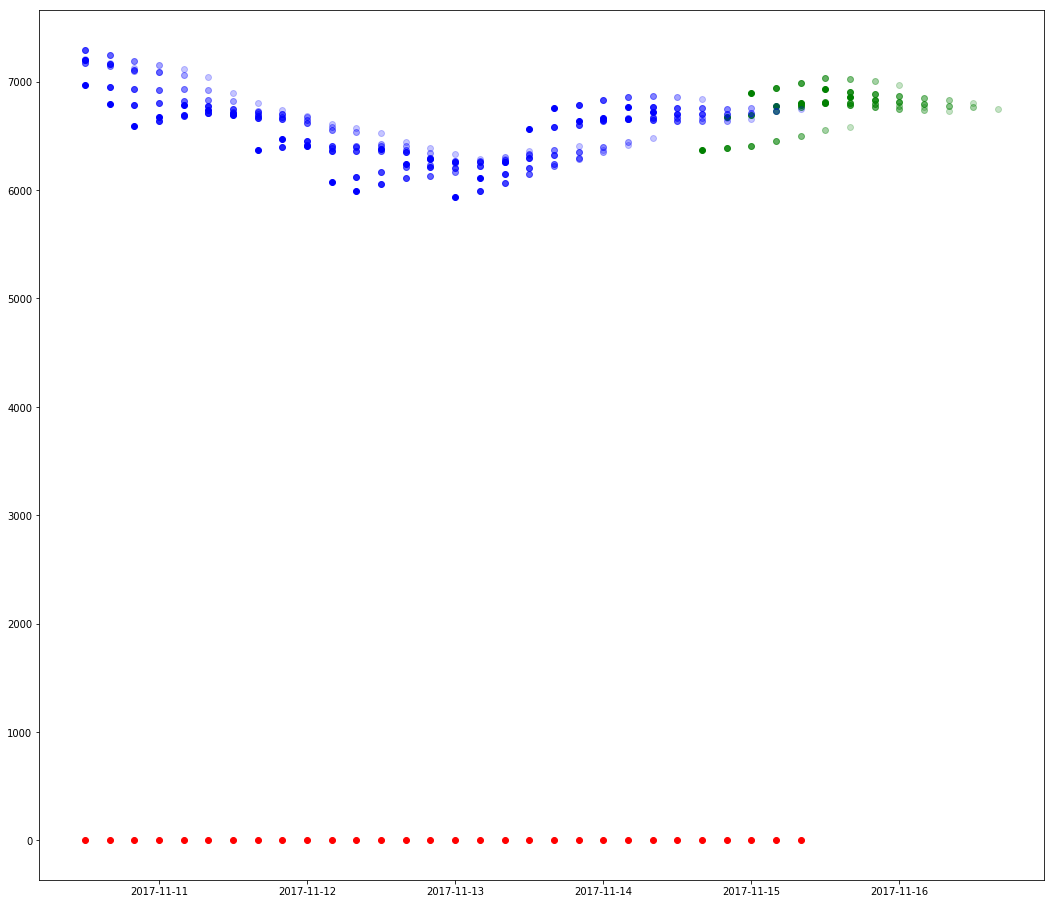

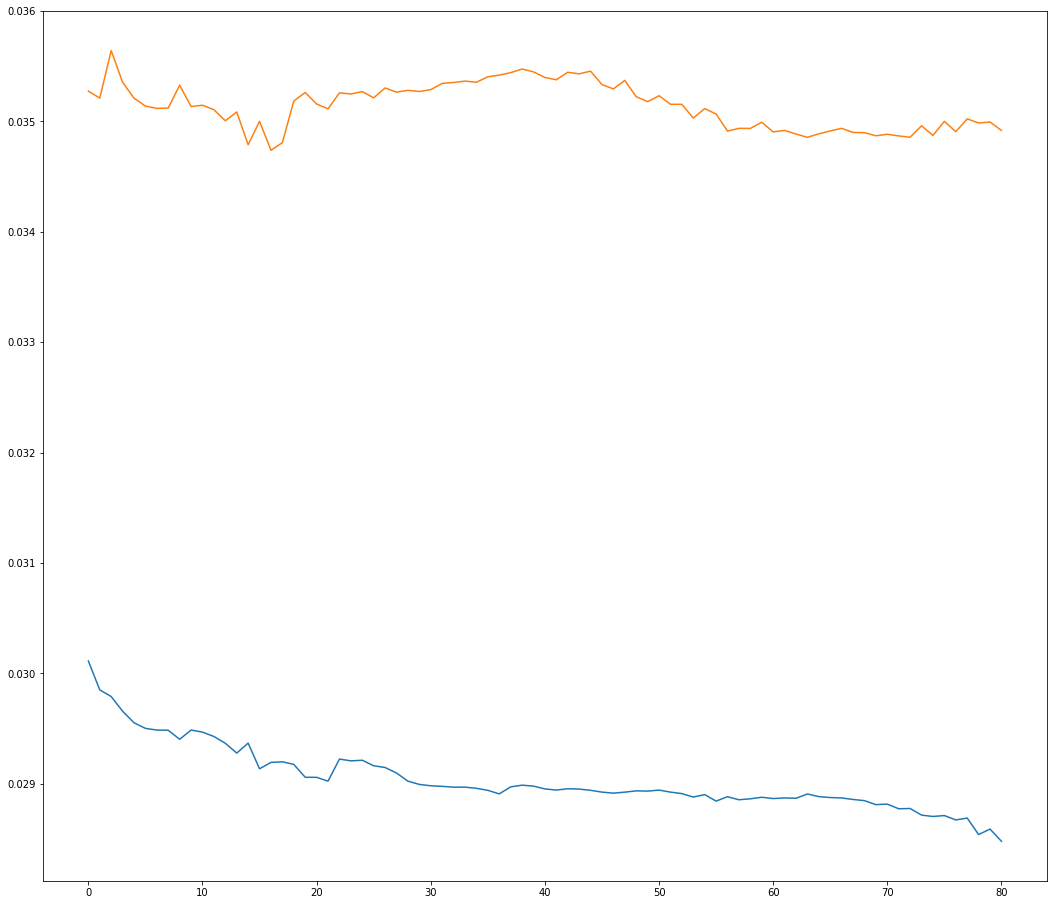

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02854 RMSE
Test Score: 0.03507 RMSE
(9004, 11)
(9011, 11)


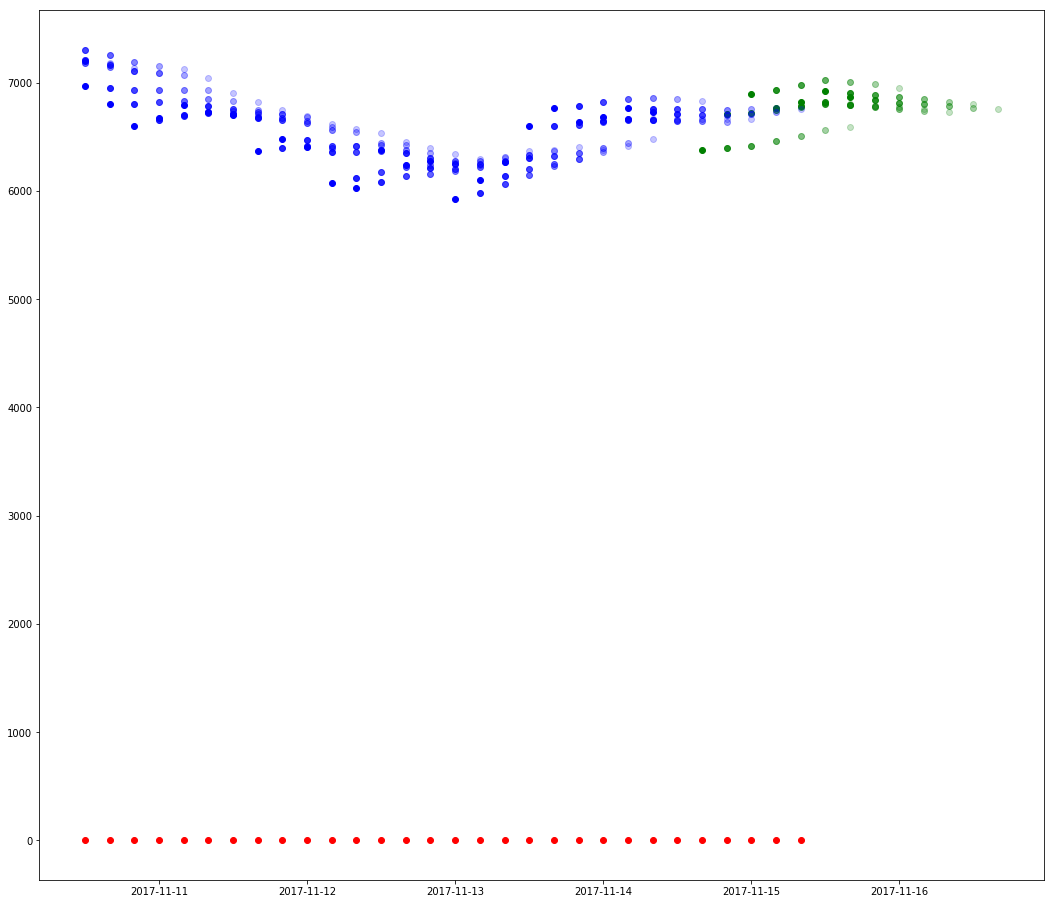

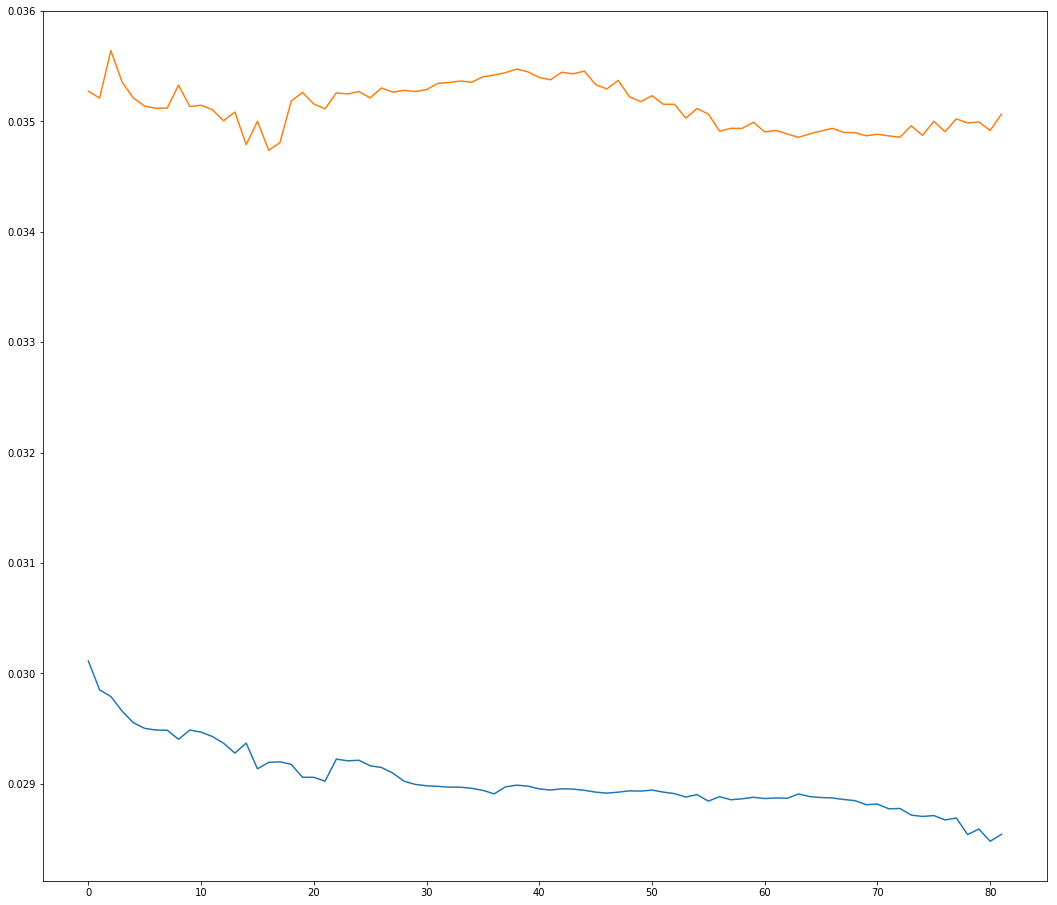

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02849 RMSE
Test Score: 0.03505 RMSE
(9004, 11)
(9011, 11)


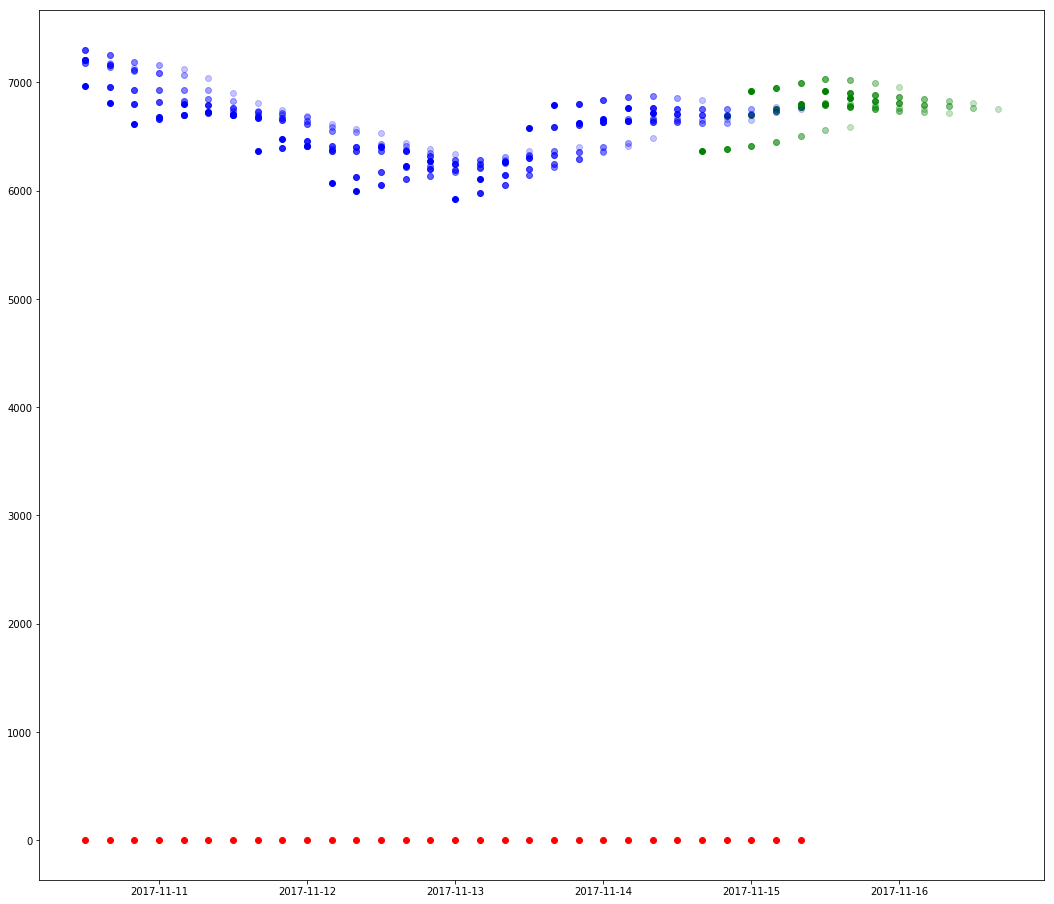

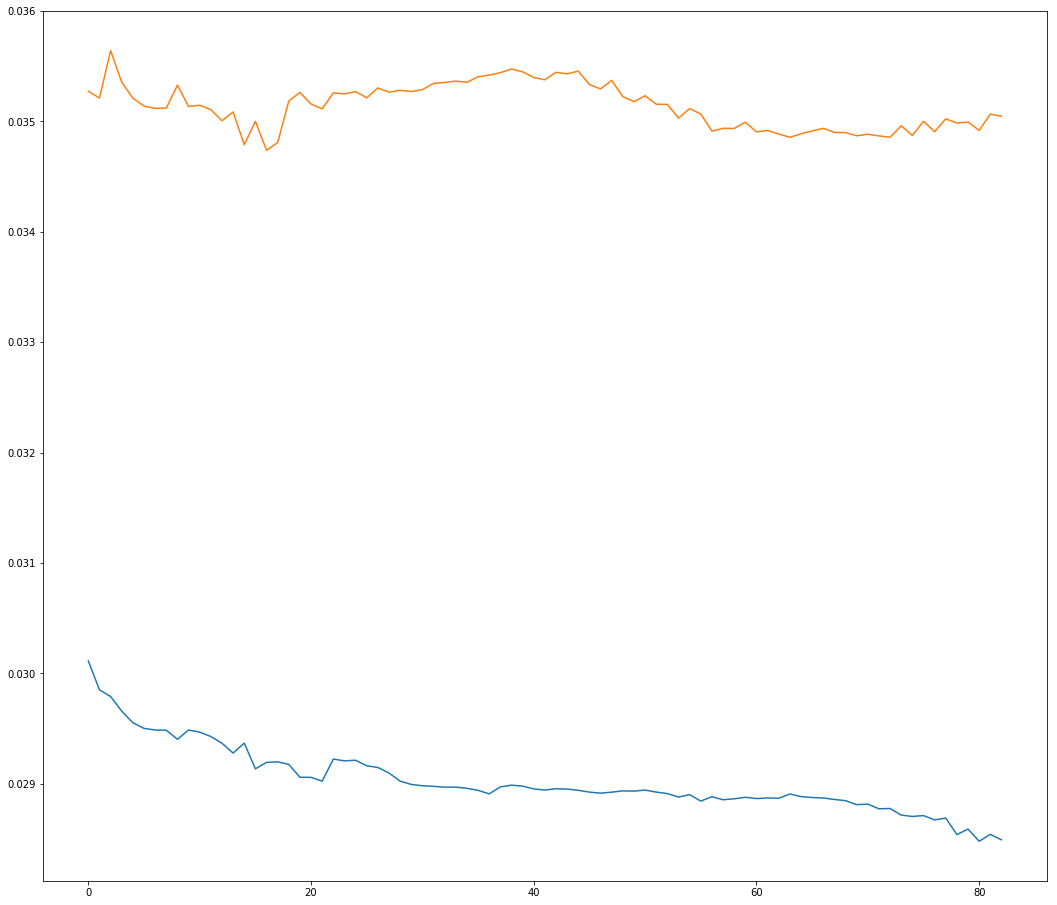

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02840 RMSE
Test Score: 0.03489 RMSE
(9004, 11)
(9011, 11)


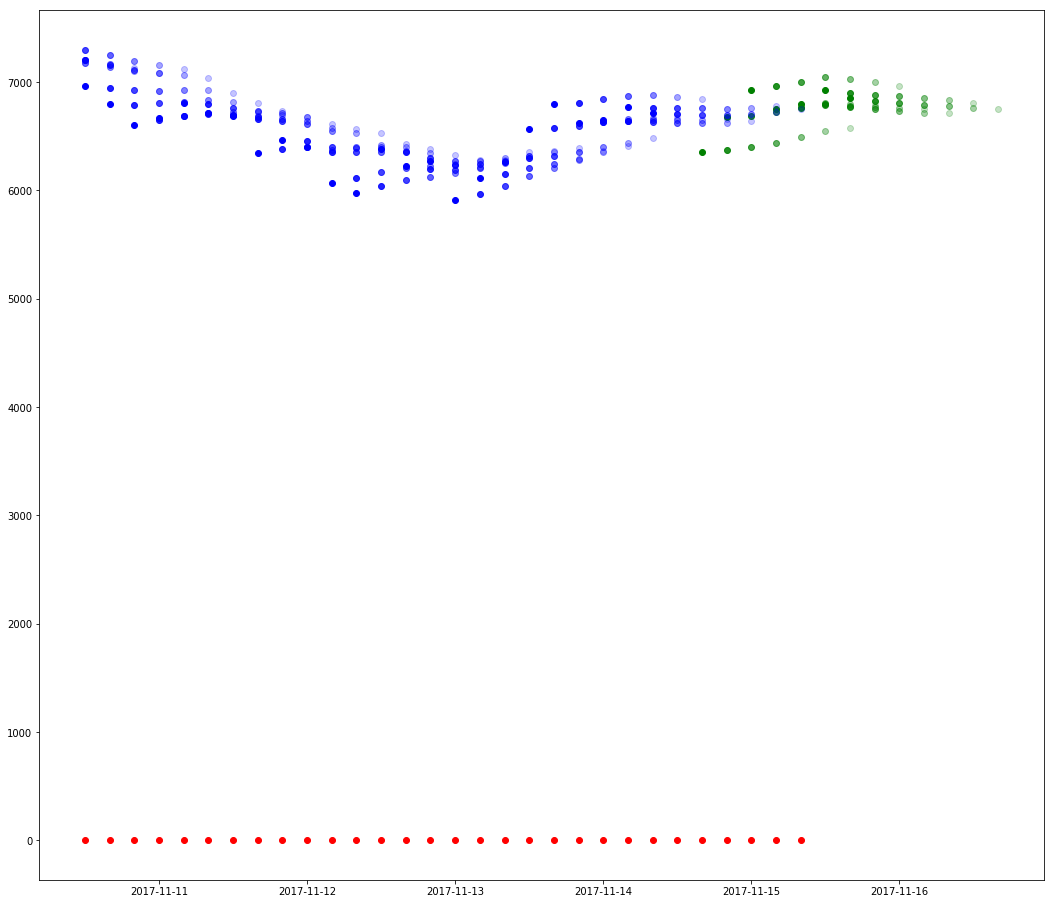

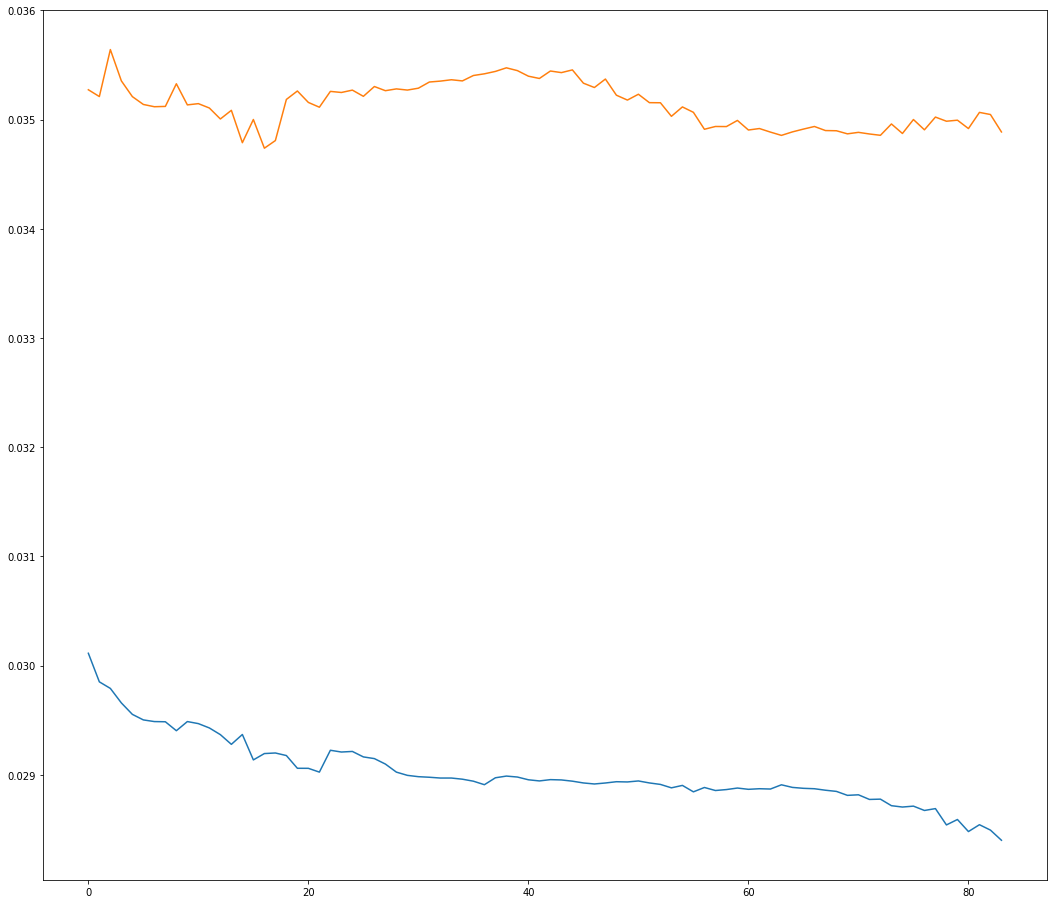

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02840 RMSE
Test Score: 0.03489 RMSE
(9004, 11)
(9011, 11)


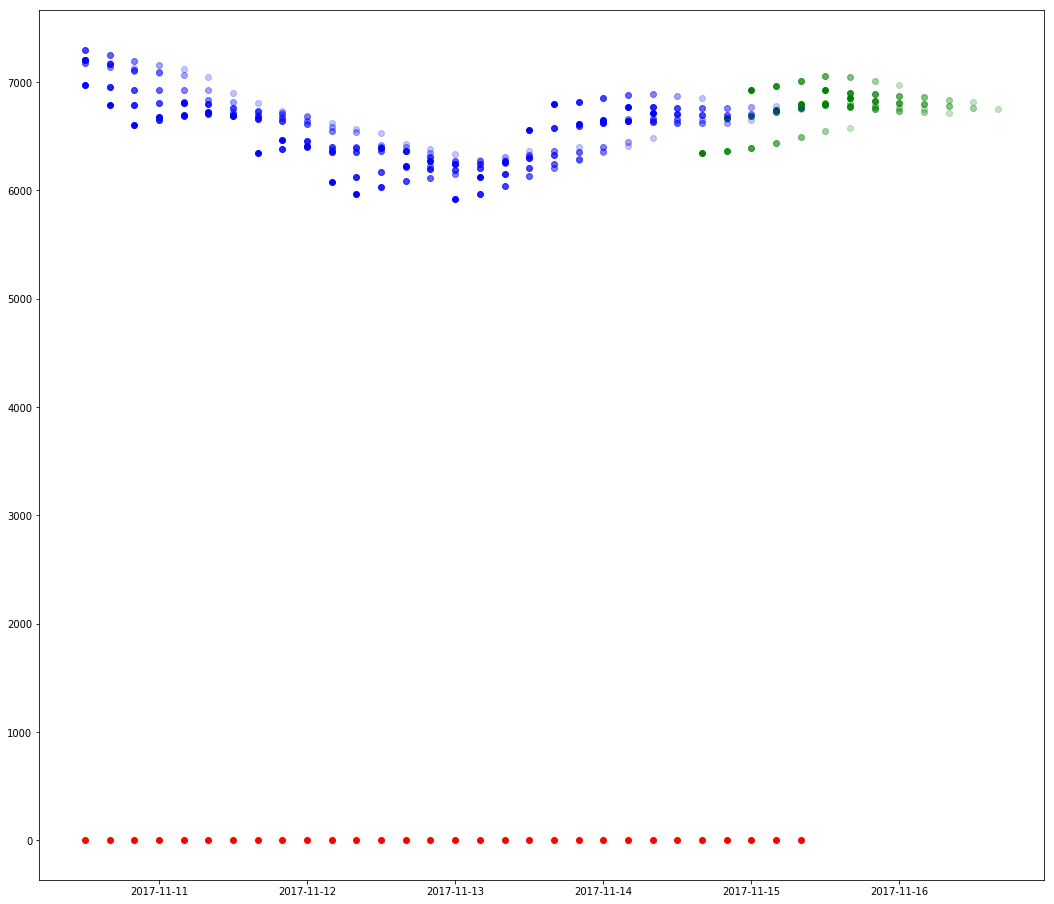

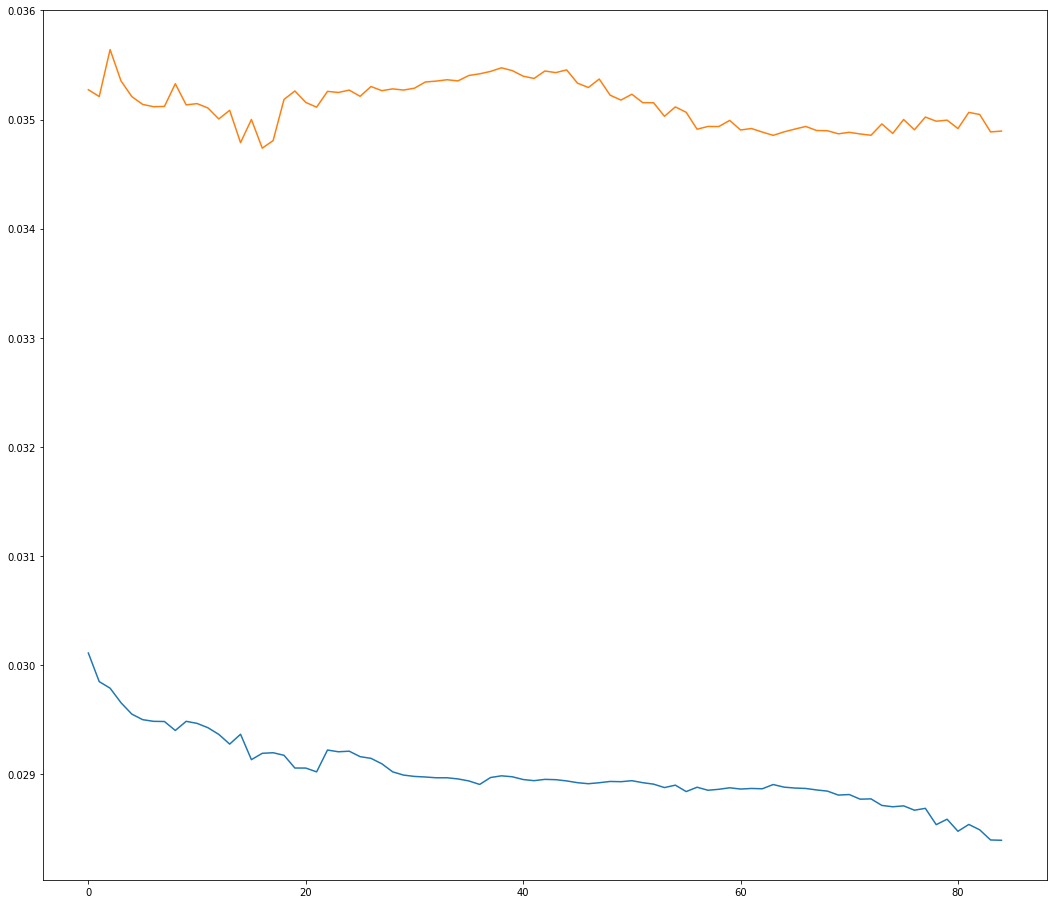

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02848 RMSE
Test Score: 0.03508 RMSE
(9004, 11)
(9011, 11)


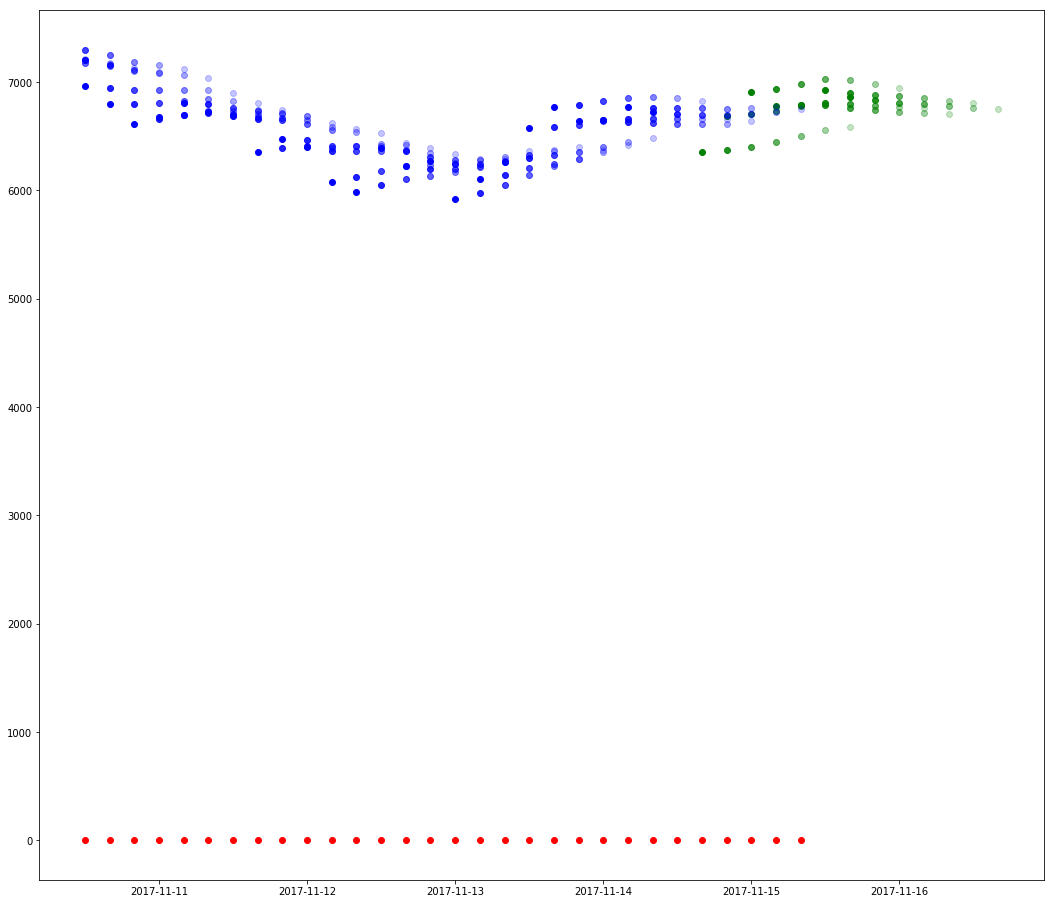

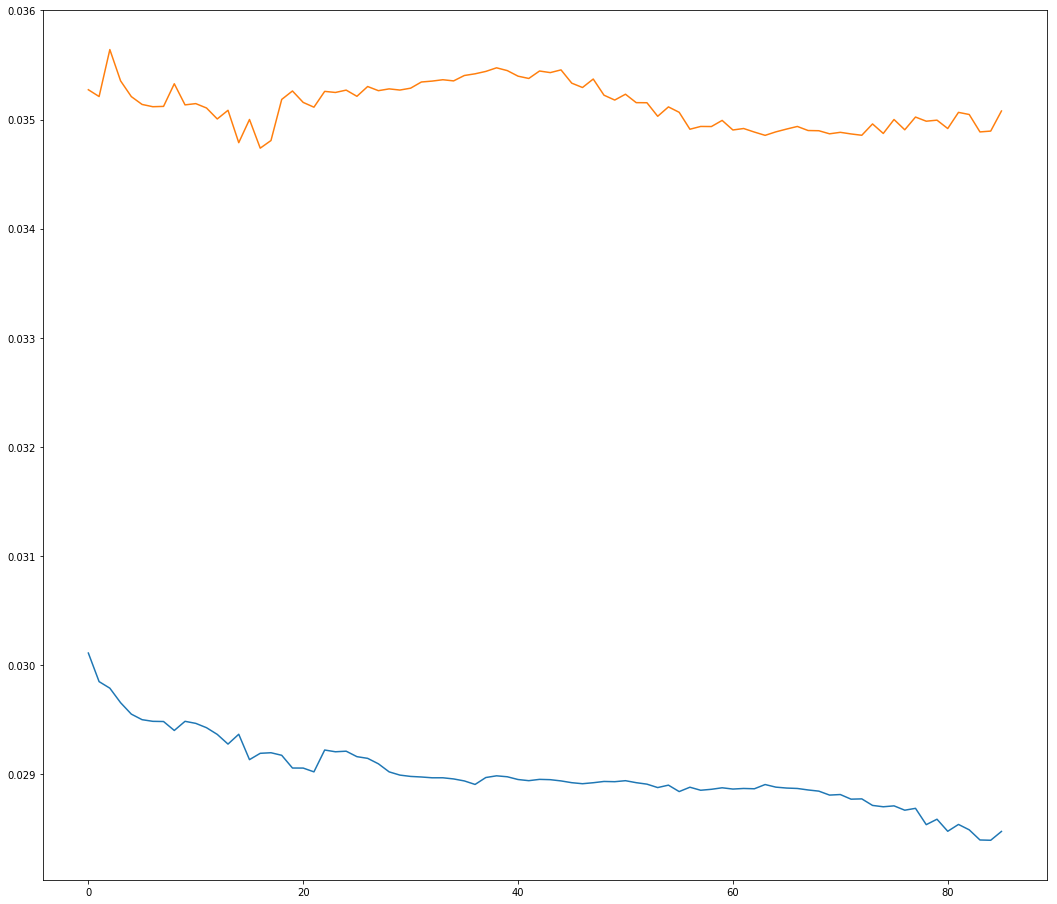

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02841 RMSE
Test Score: 0.03504 RMSE
(9004, 11)
(9011, 11)


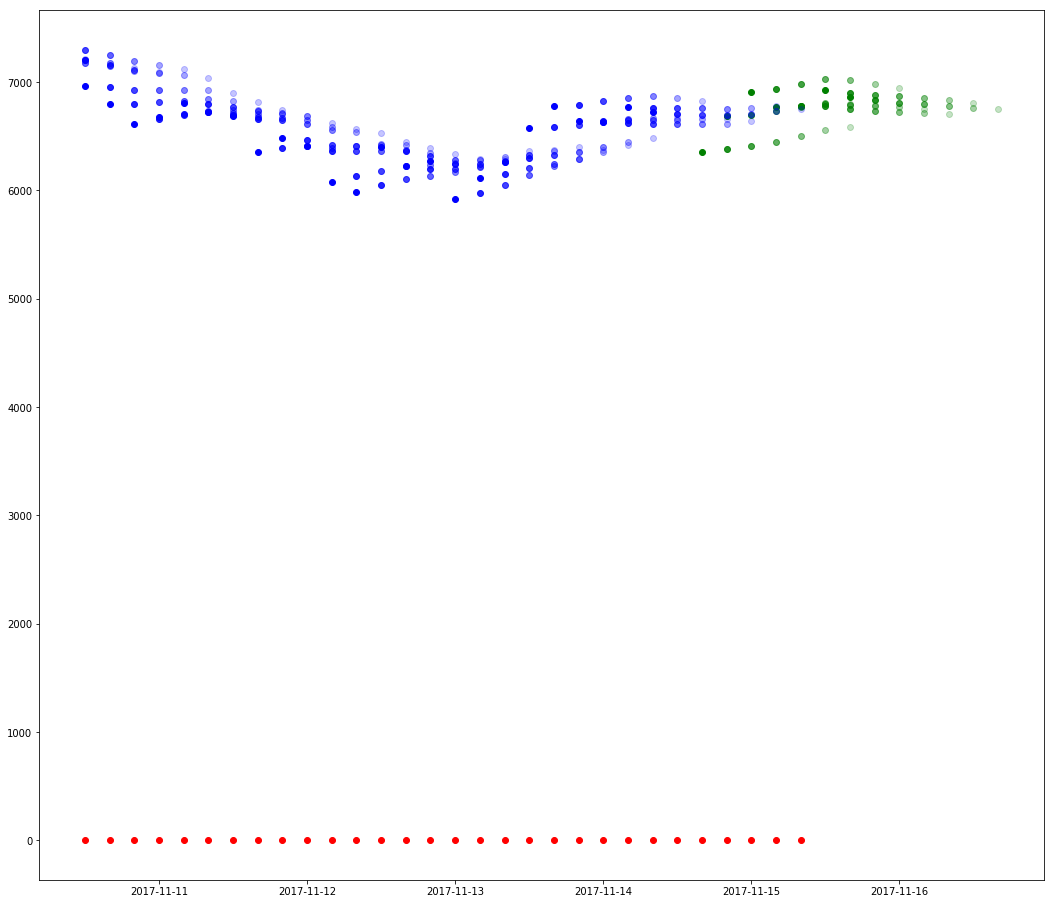

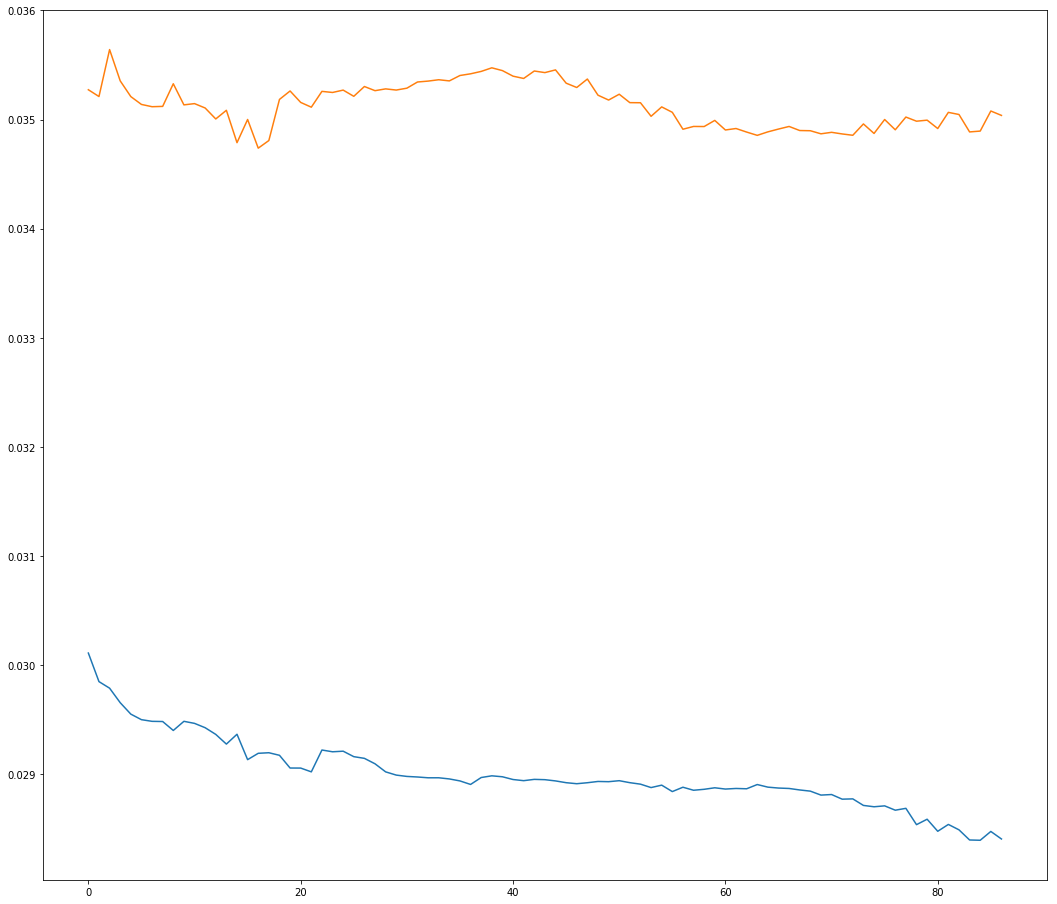

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02830 RMSE
Test Score: 0.03485 RMSE
(9004, 11)
(9011, 11)


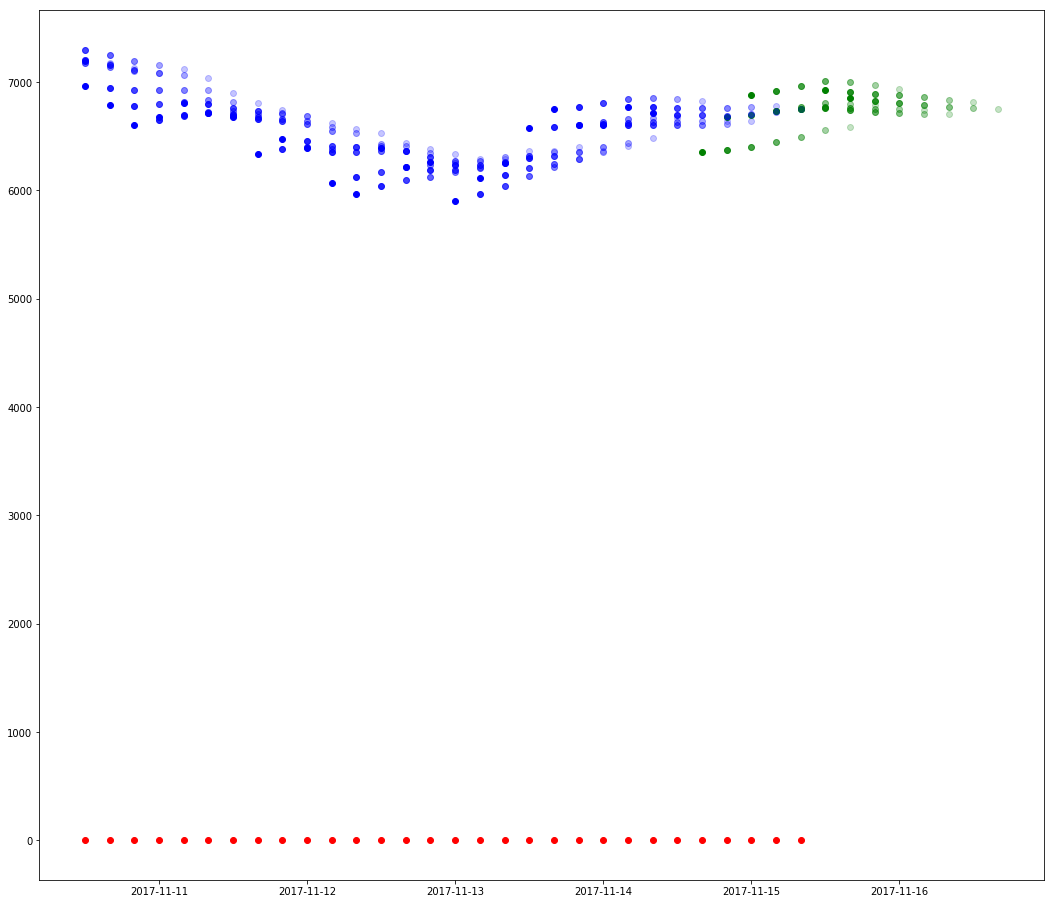

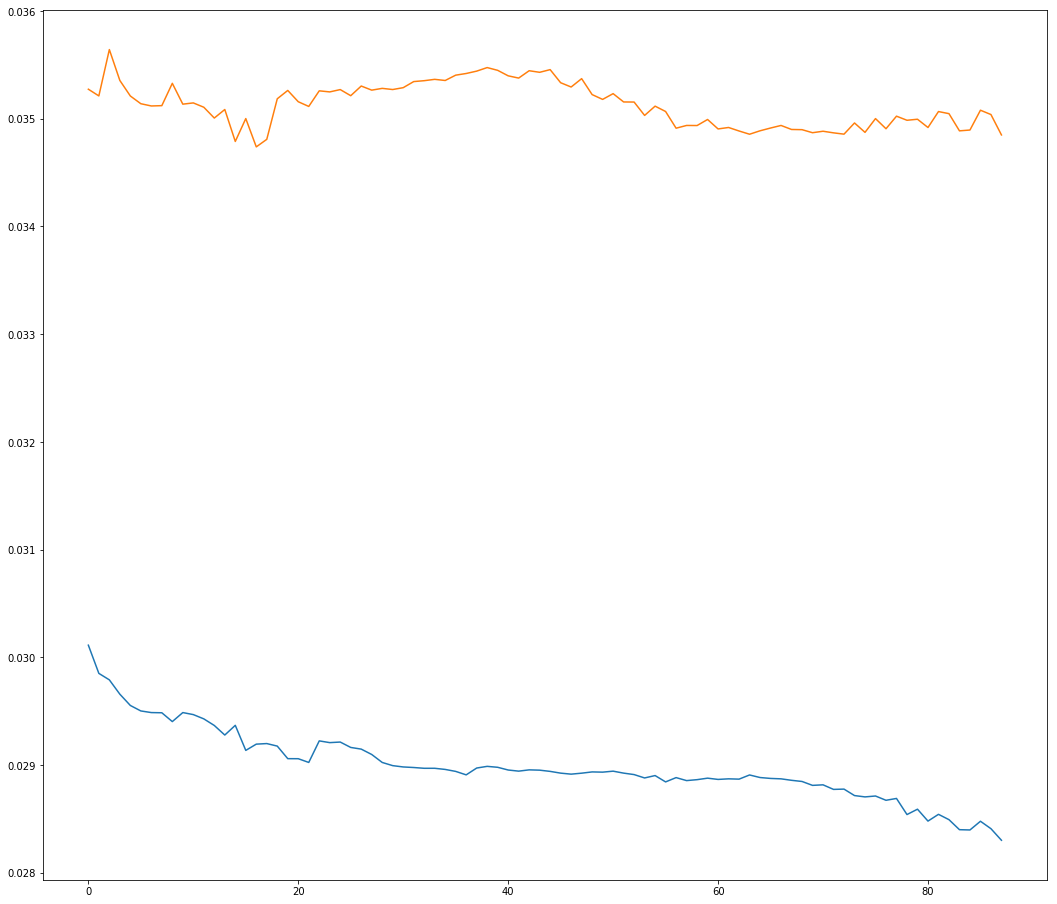

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02834 RMSE
Test Score: 0.03482 RMSE
(9004, 11)
(9011, 11)


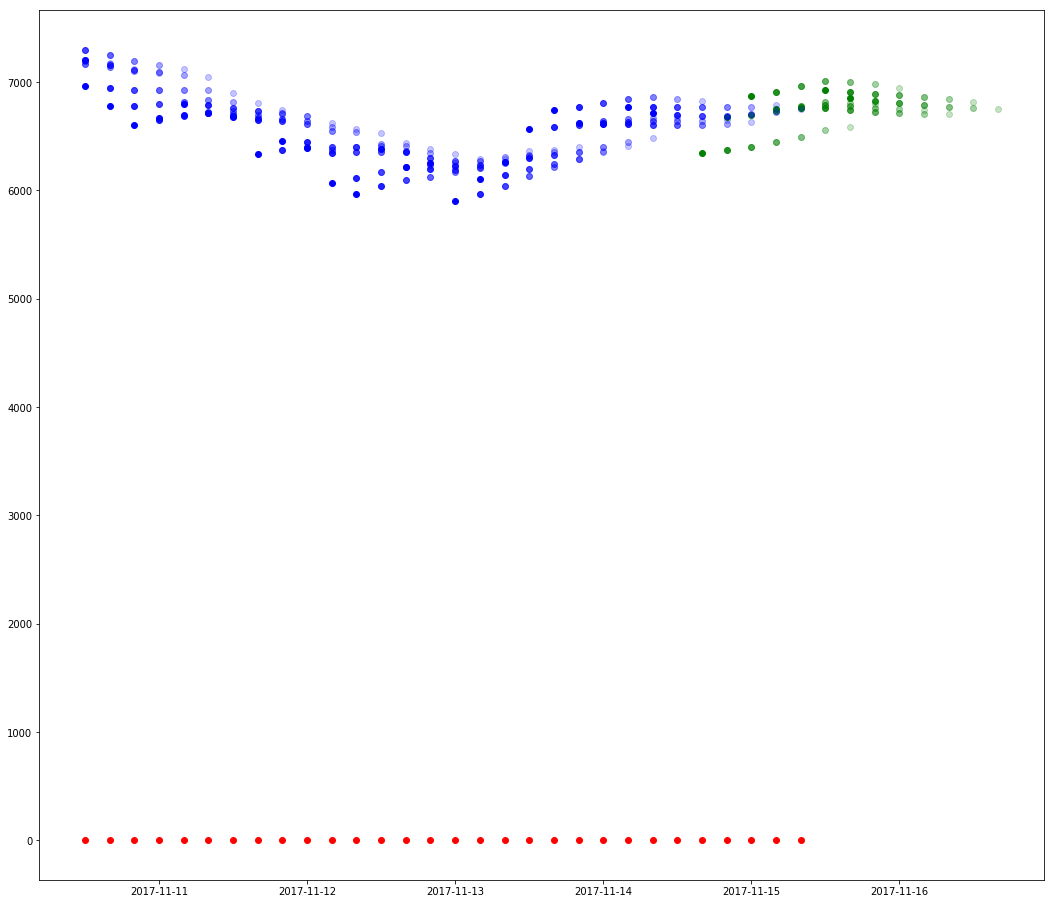

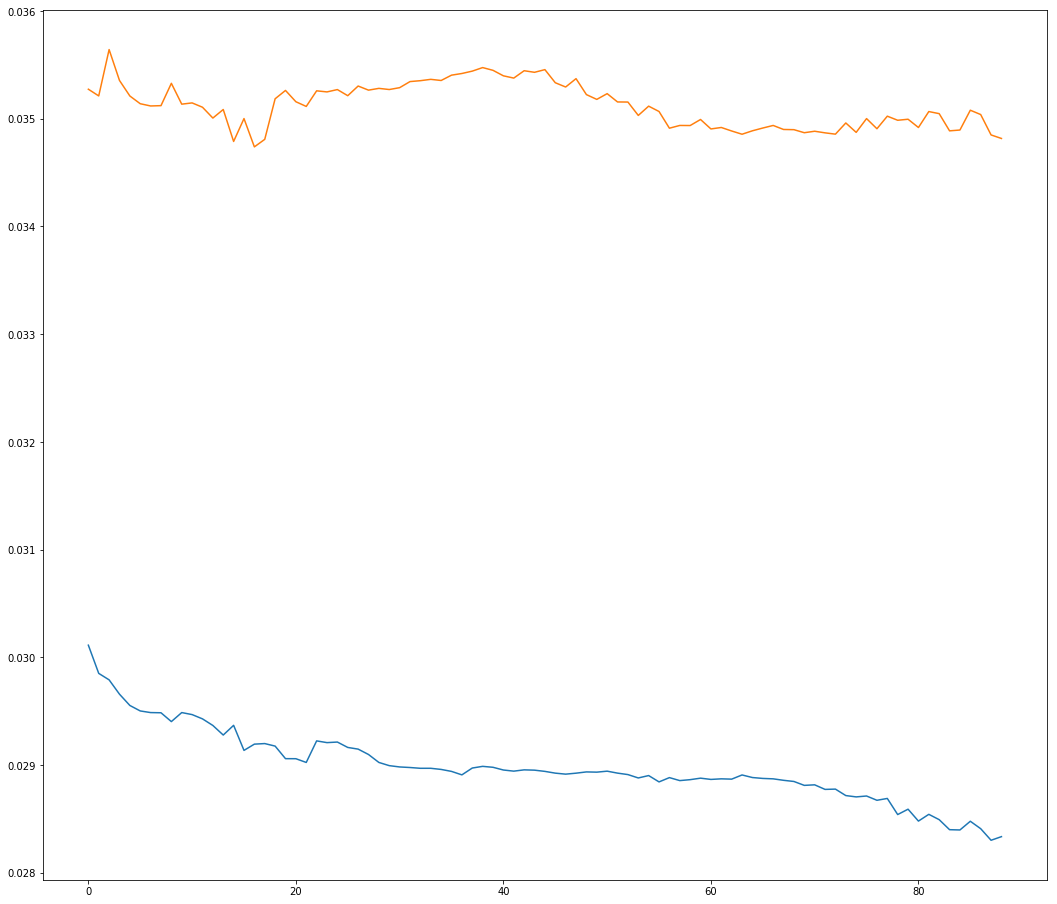

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02839 RMSE
Test Score: 0.03490 RMSE
(9004, 11)
(9011, 11)


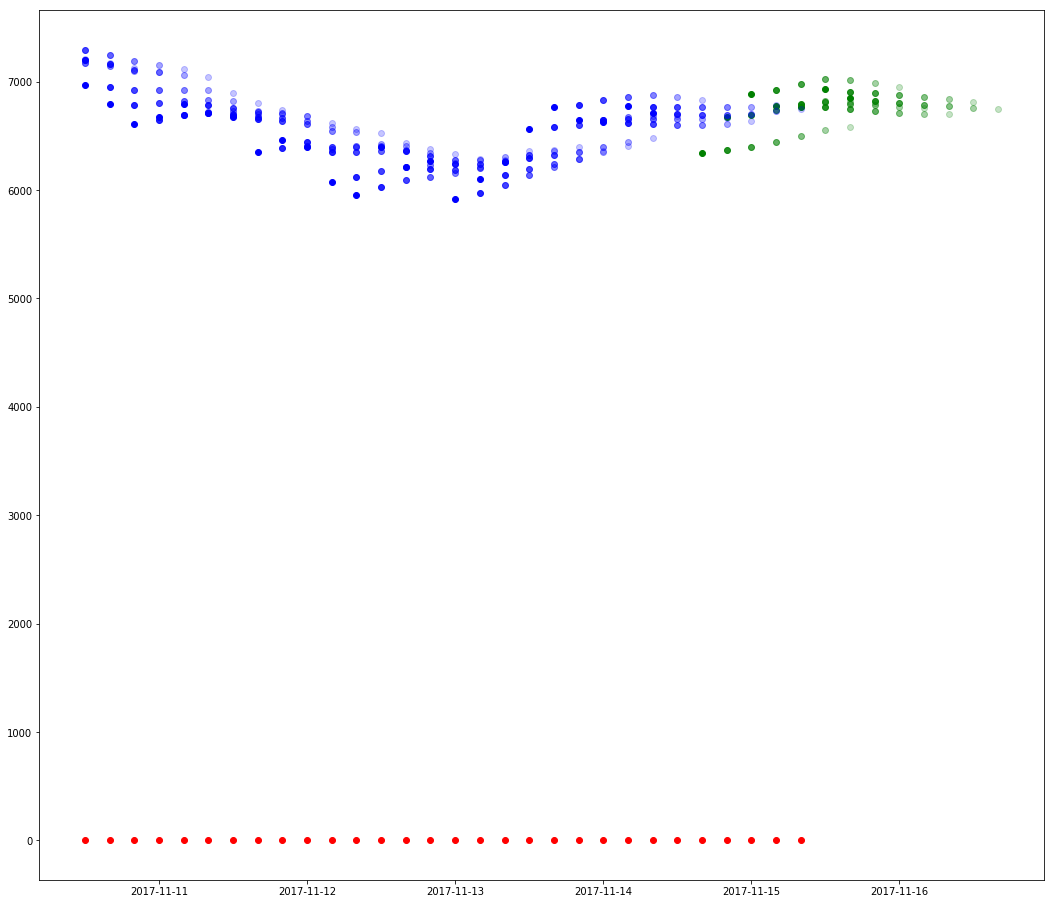

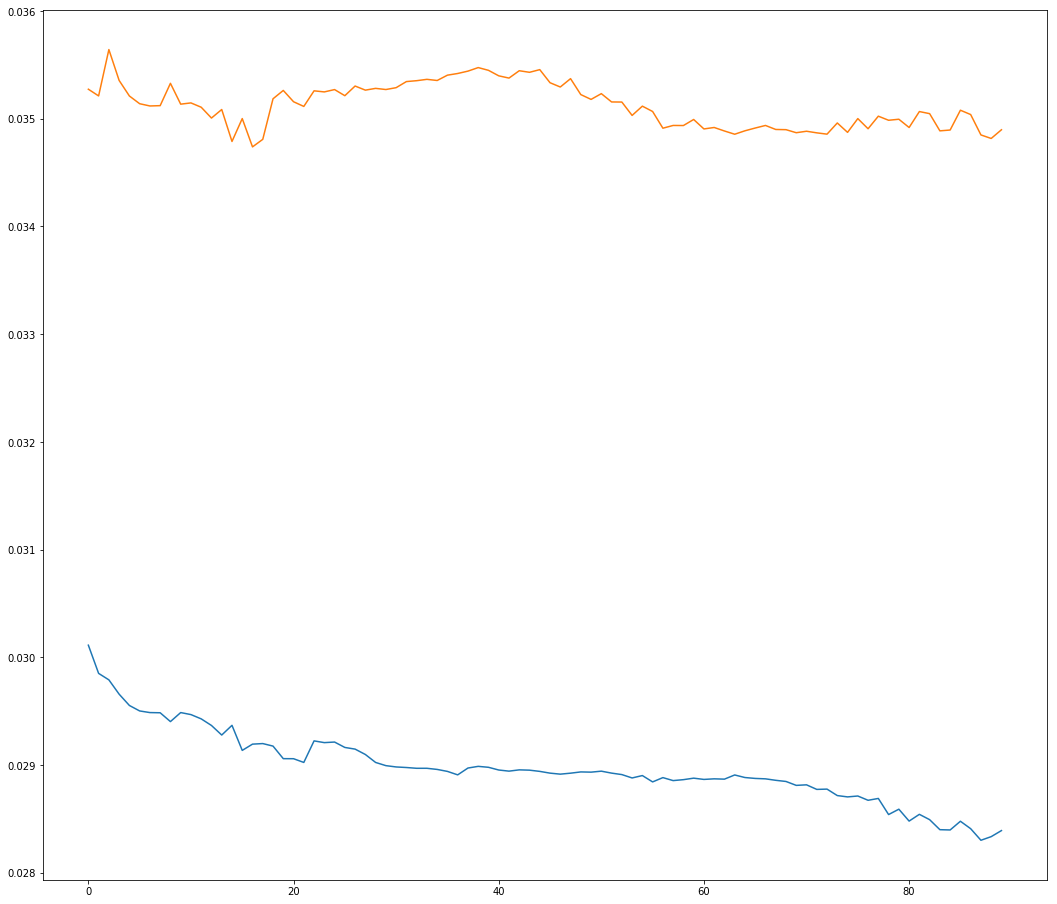

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02856 RMSE
Test Score: 0.03496 RMSE
(9004, 11)
(9011, 11)


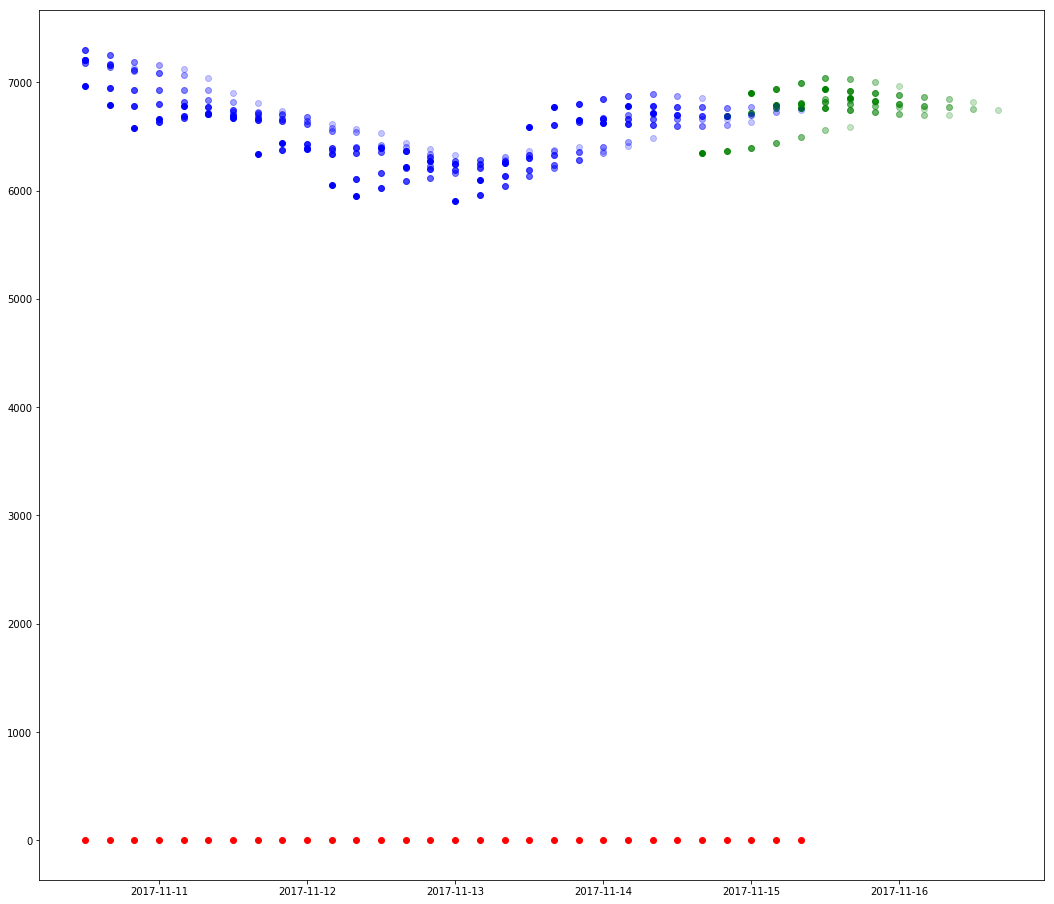

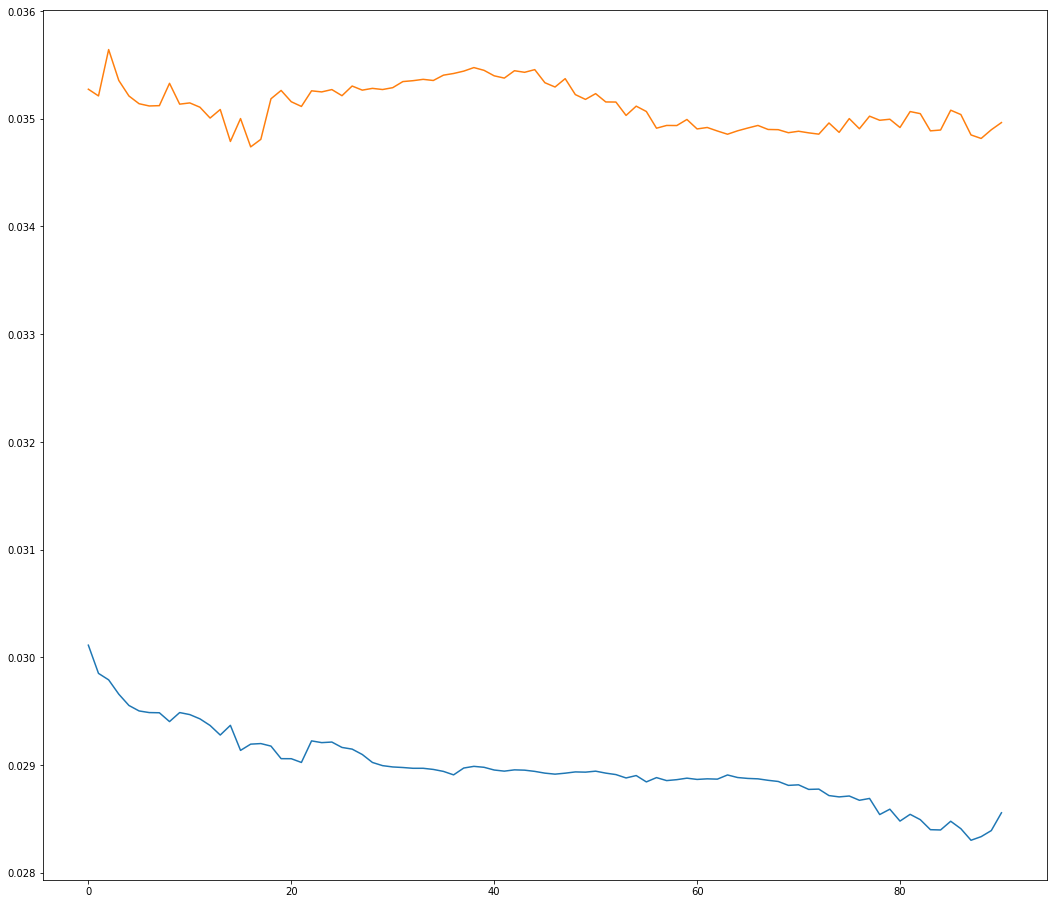

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02834 RMSE
Test Score: 0.03499 RMSE
(9004, 11)
(9011, 11)


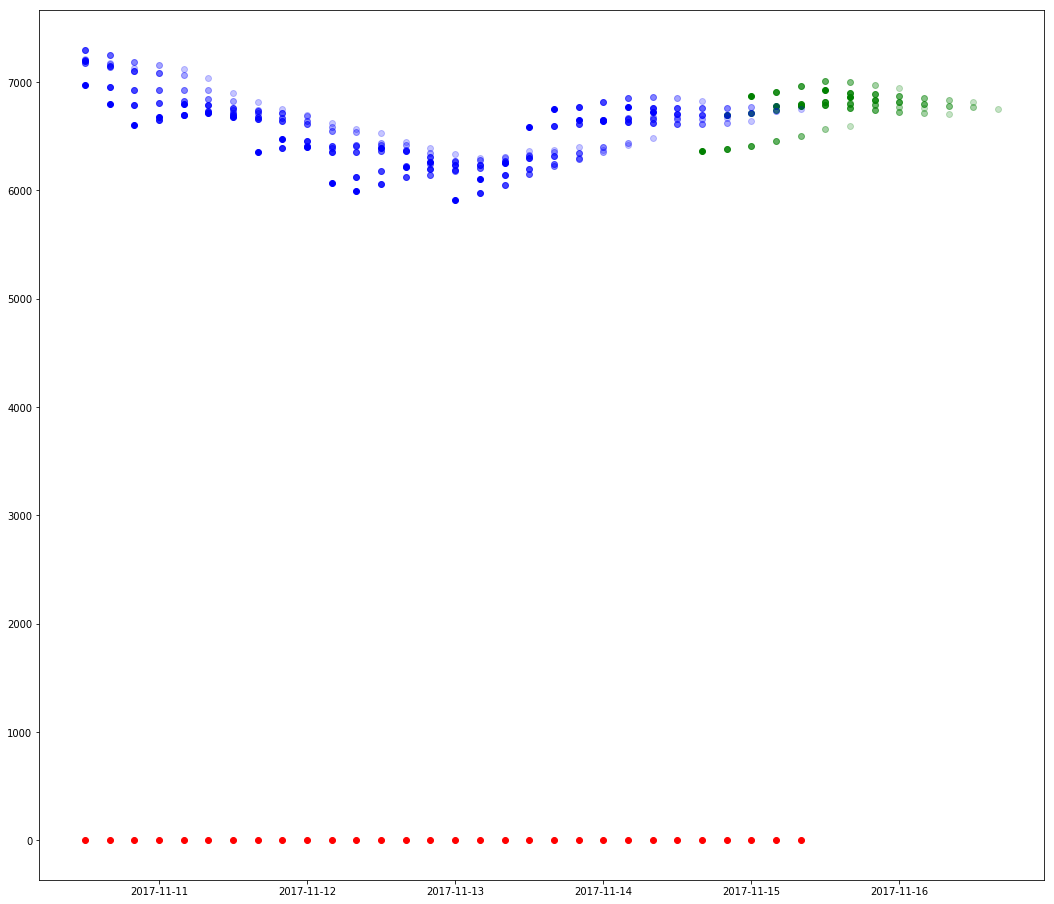

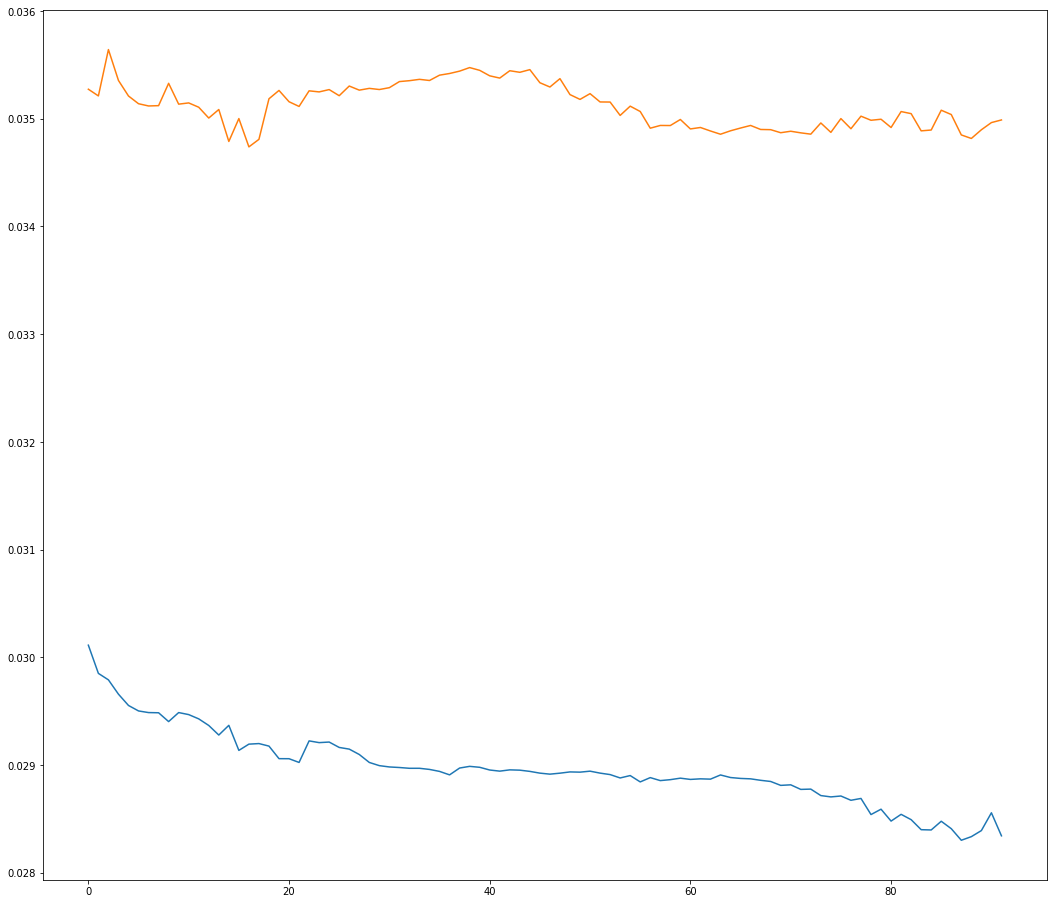

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02858 RMSE
Test Score: 0.03501 RMSE
(9004, 11)
(9011, 11)


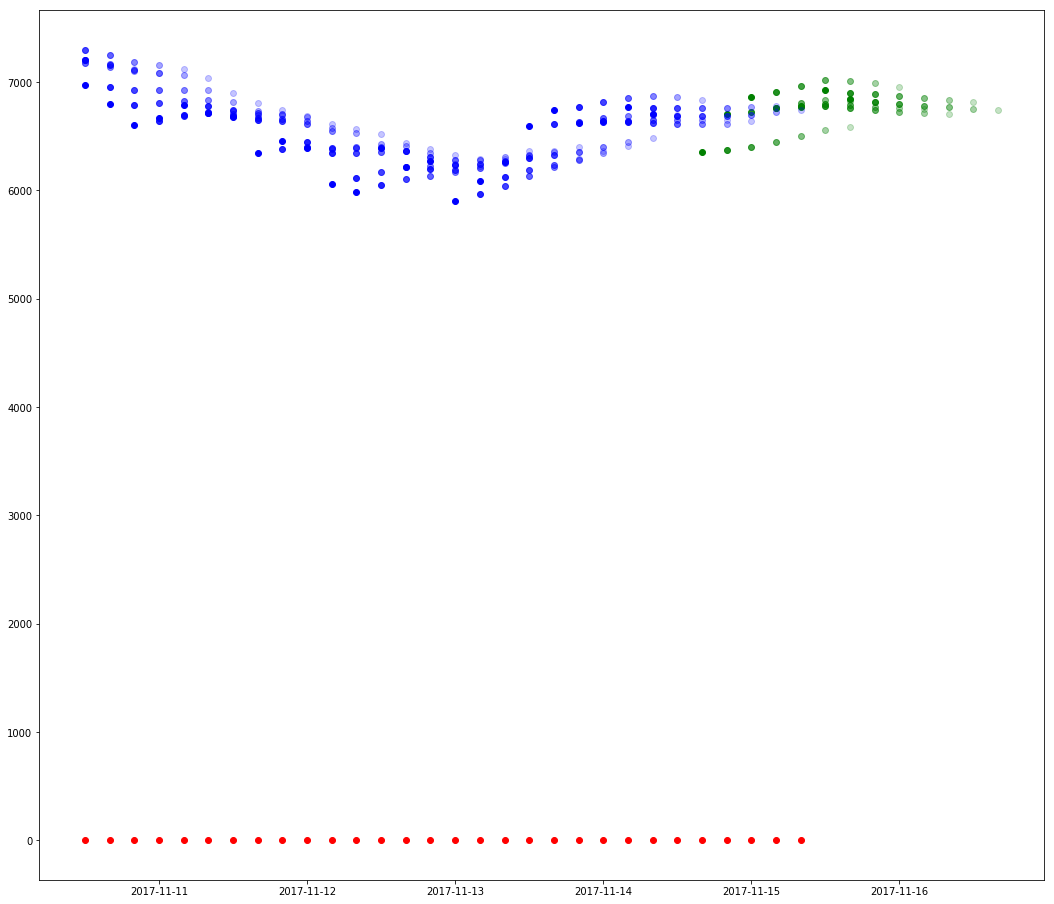

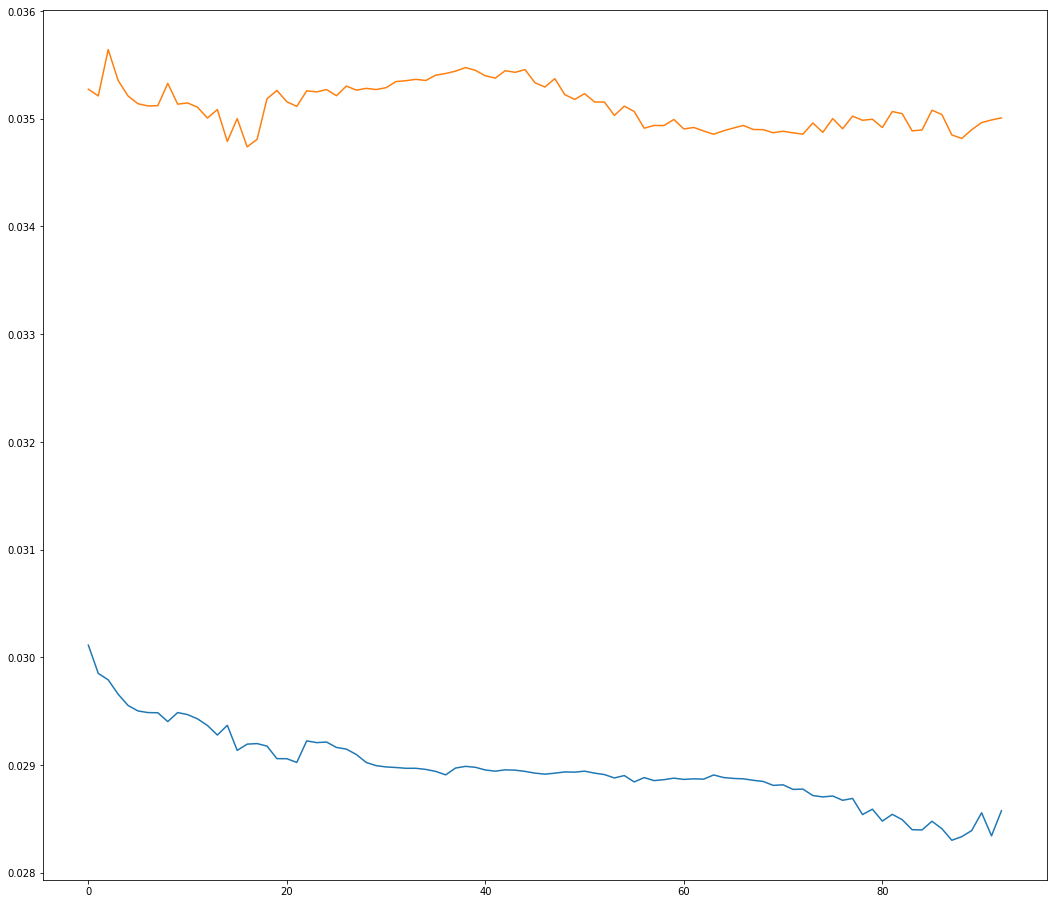

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02857 RMSE
Test Score: 0.03493 RMSE
(9004, 11)
(9011, 11)


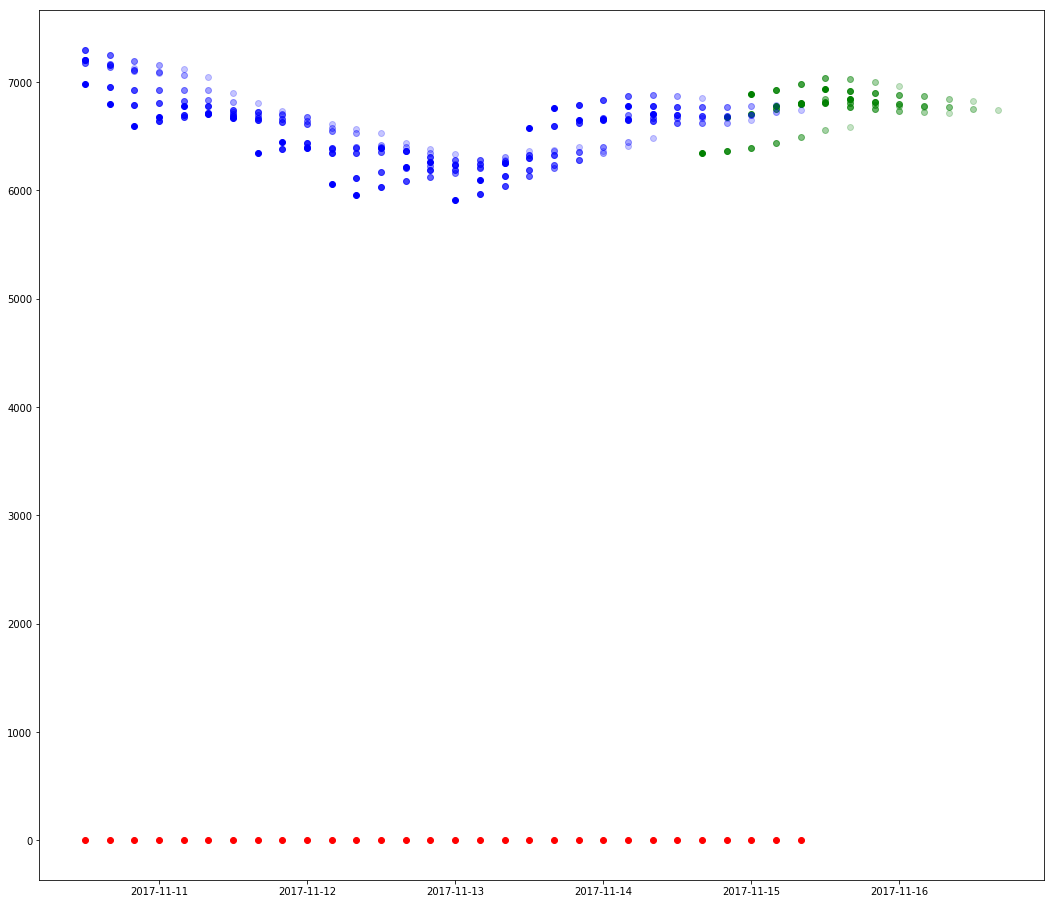

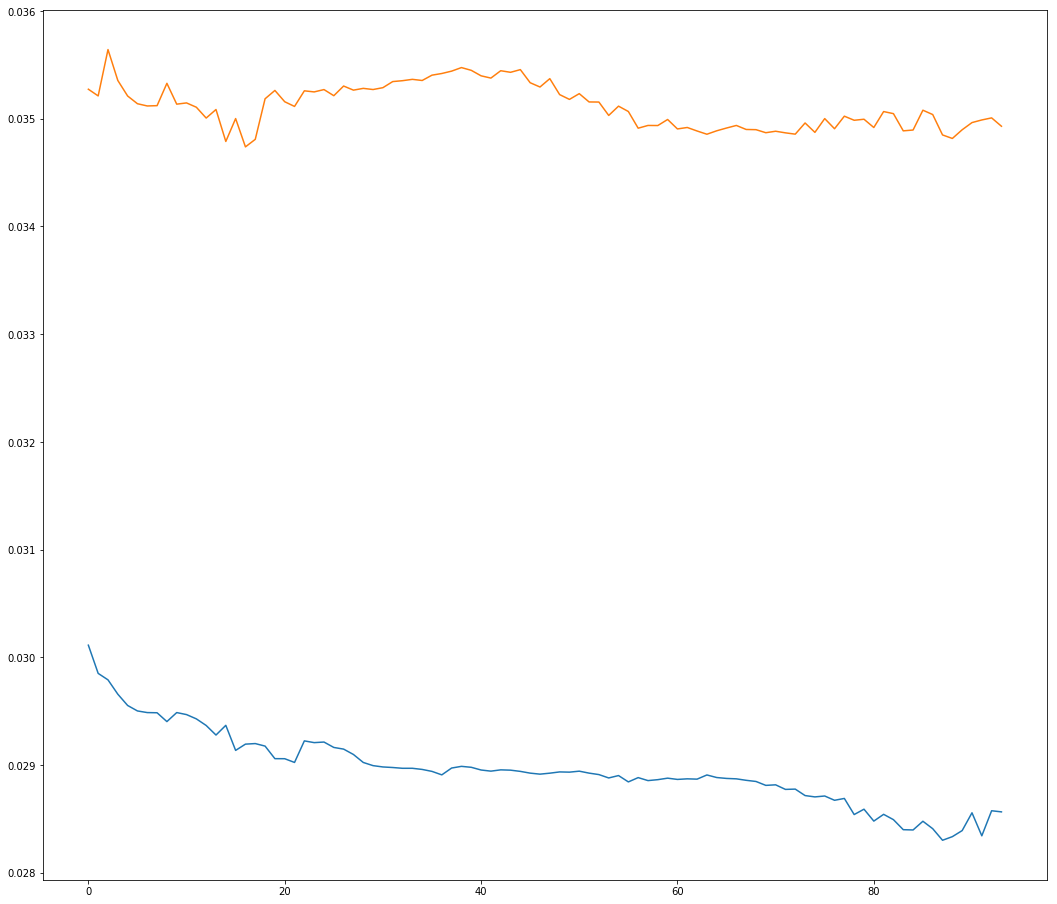

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02856 RMSE
Test Score: 0.03479 RMSE
(9004, 11)
(9011, 11)


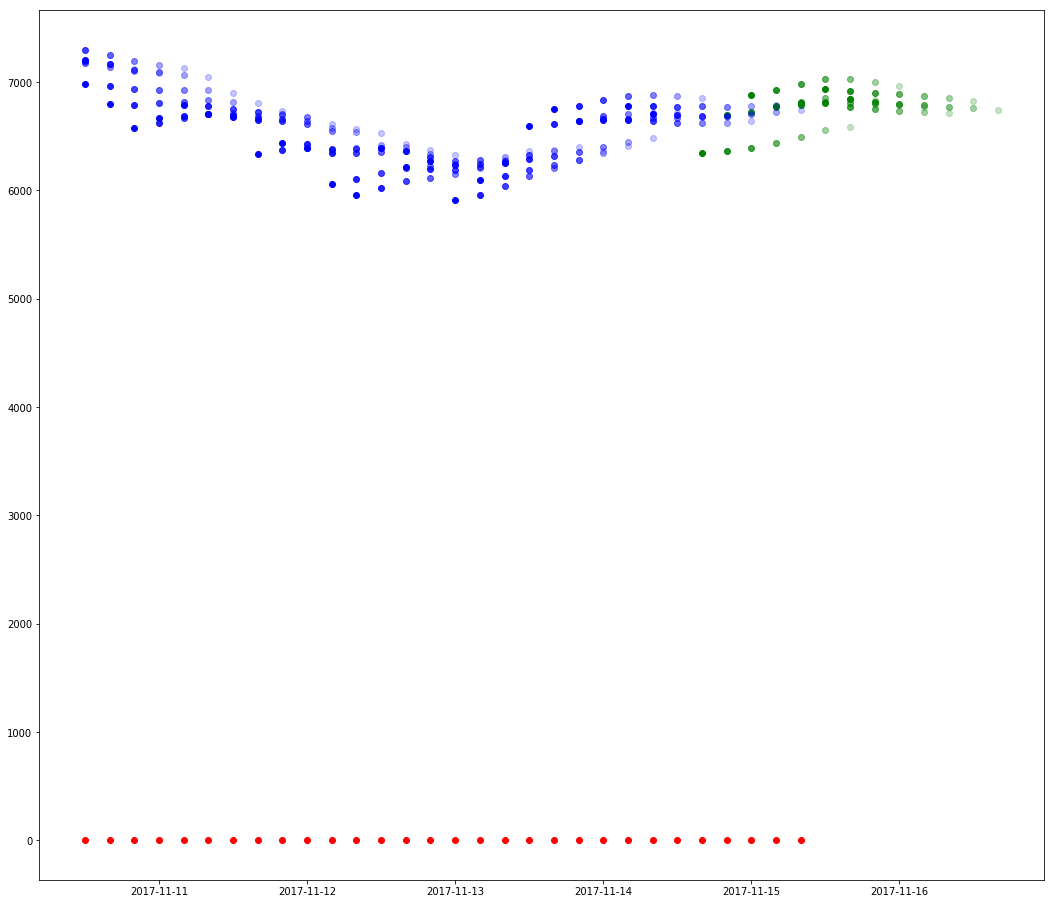

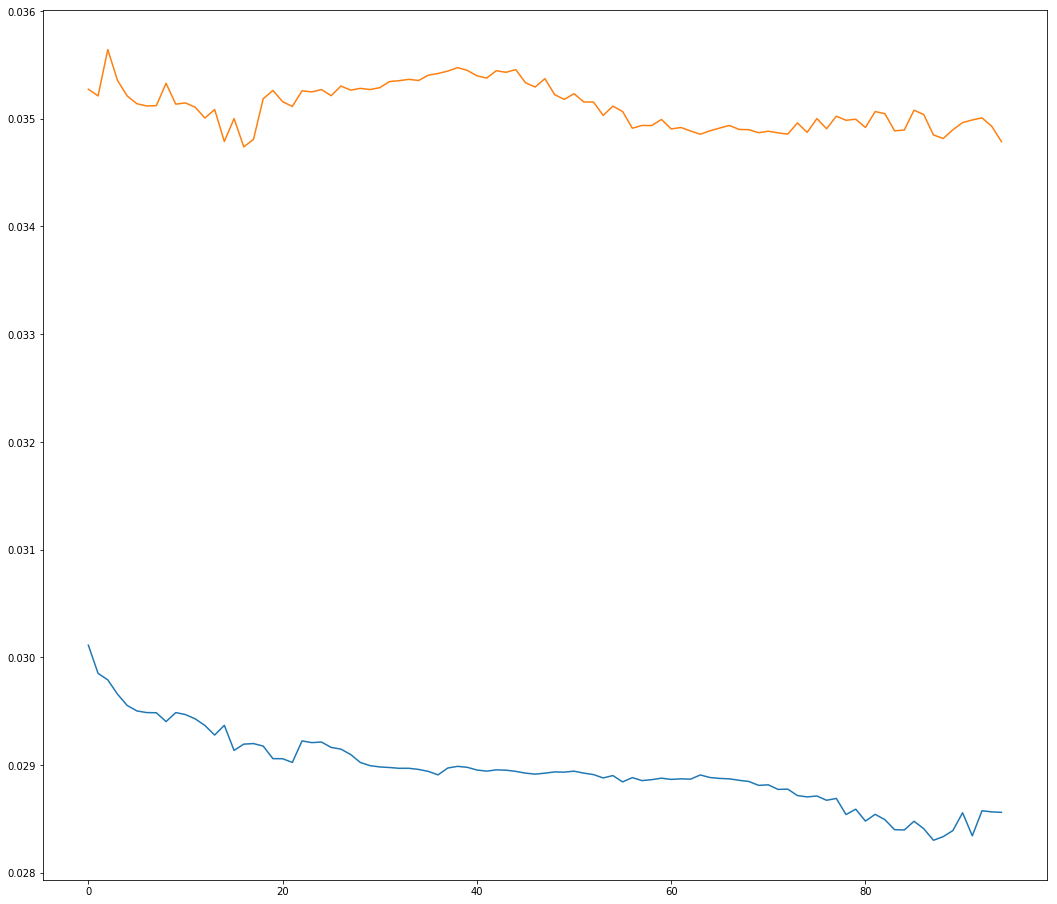

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02866 RMSE
Test Score: 0.03515 RMSE
(9004, 11)
(9011, 11)


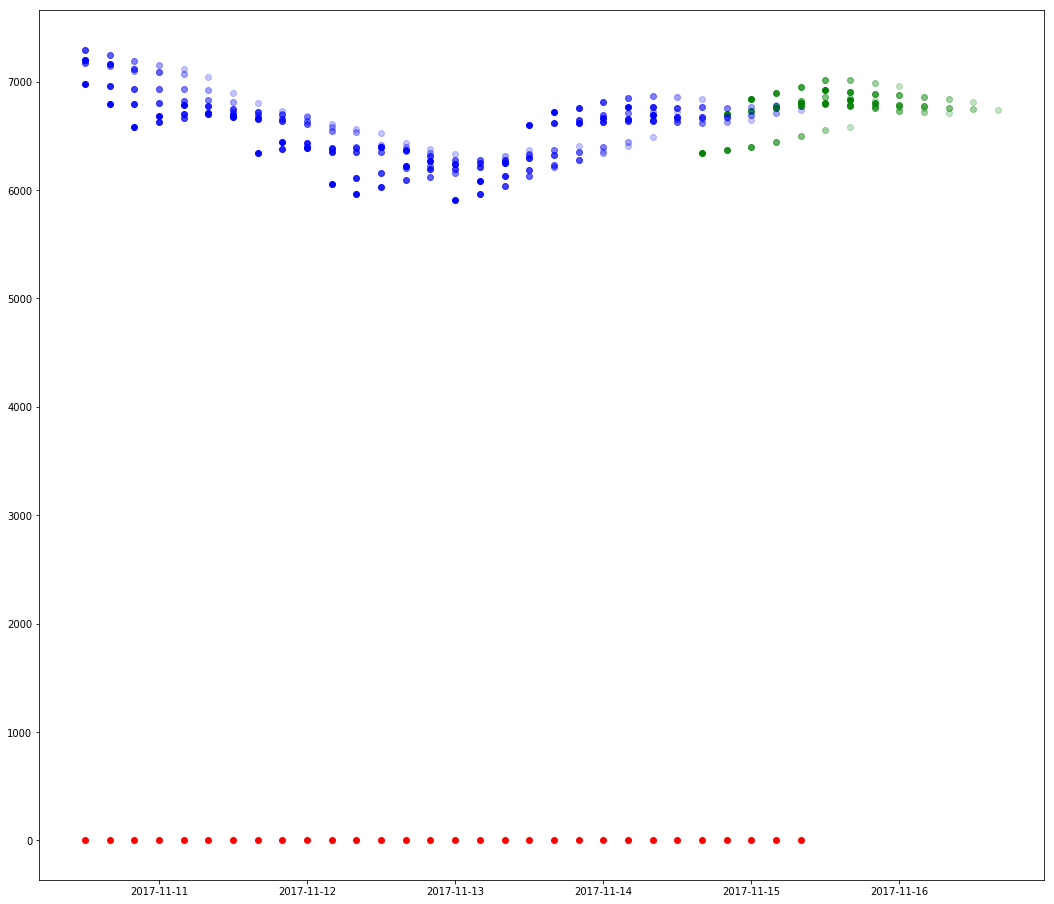

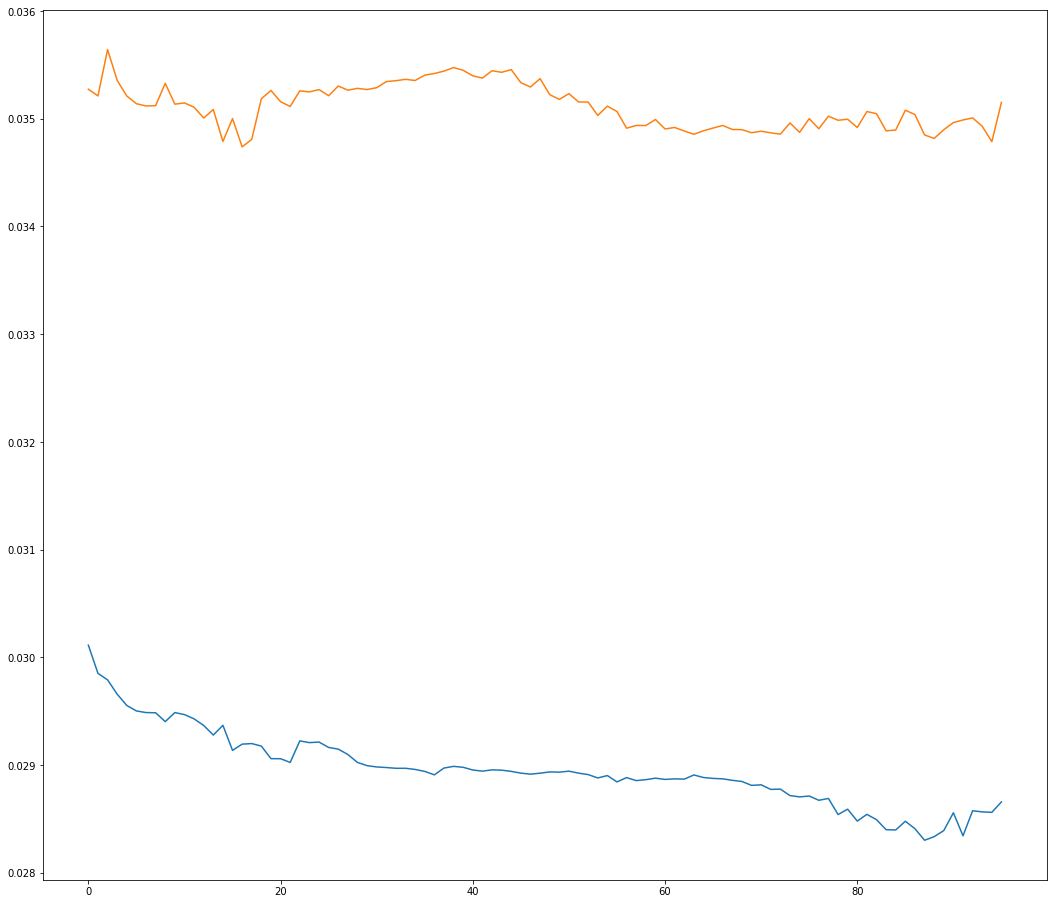

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02874 RMSE
Test Score: 0.03502 RMSE
(9004, 11)
(9011, 11)


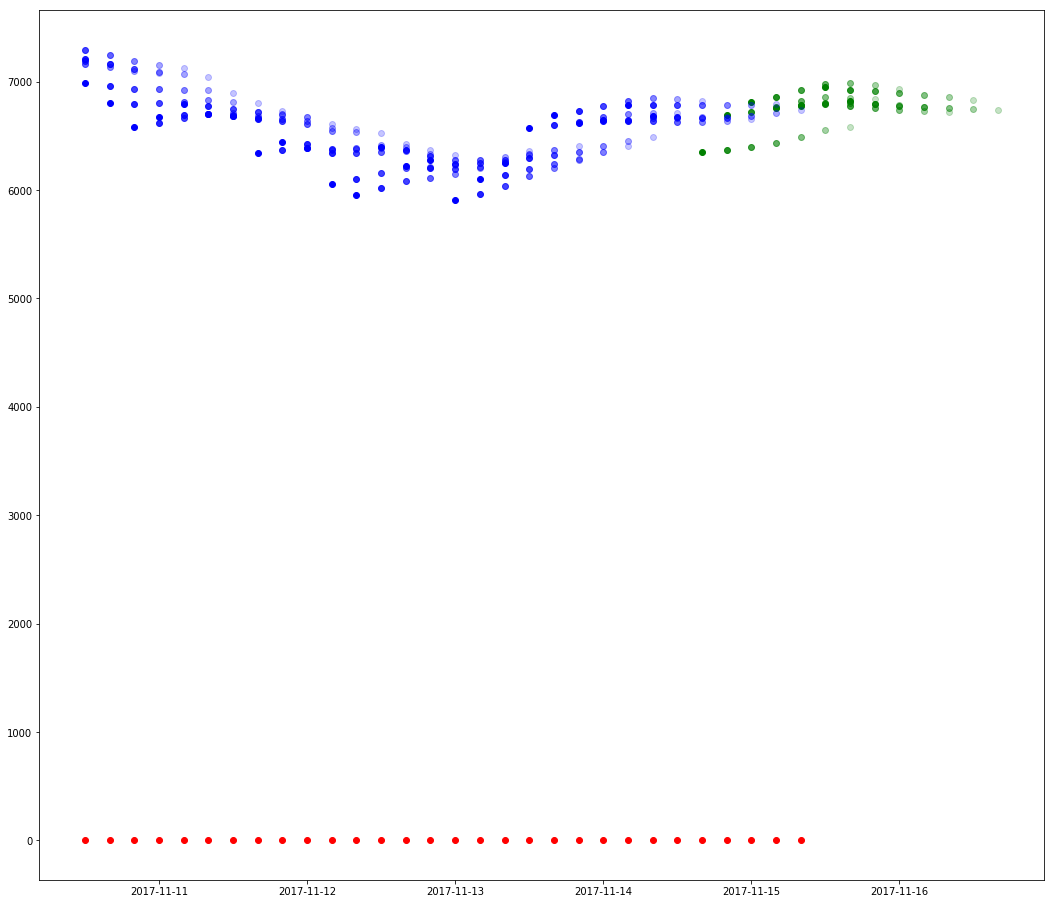

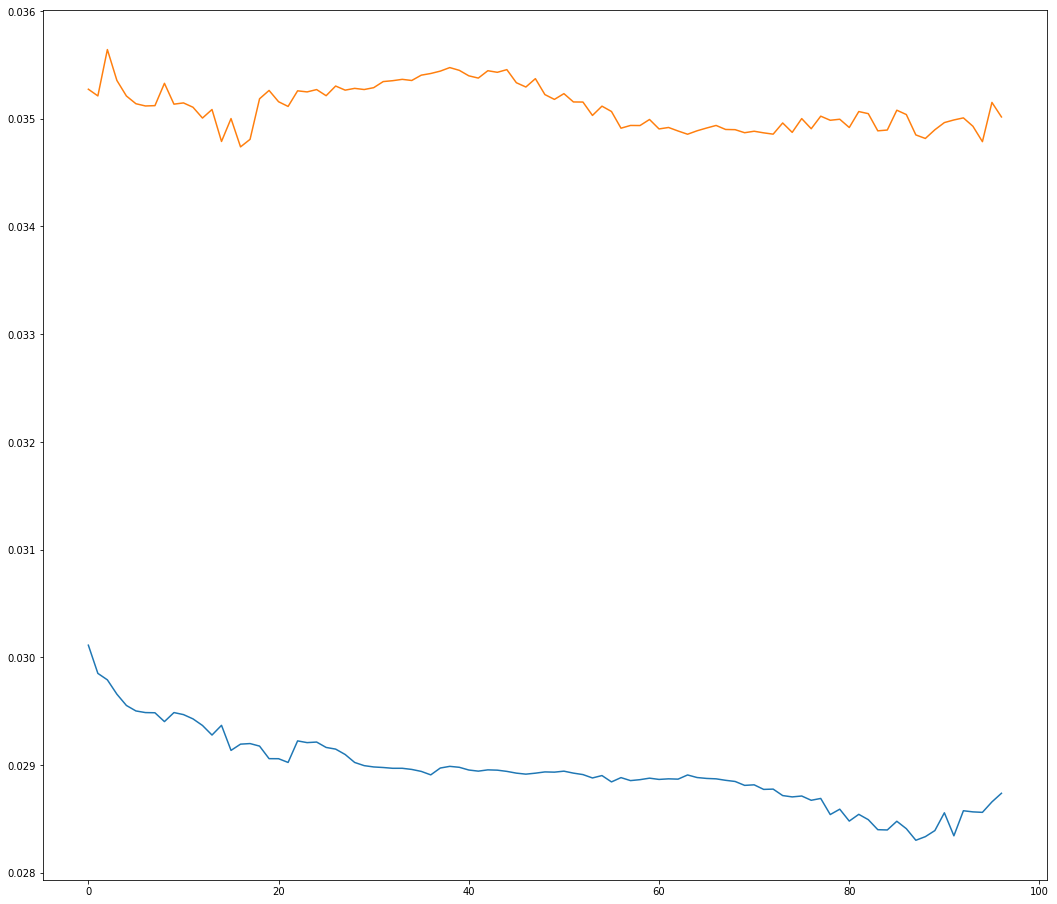

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02863 RMSE
Test Score: 0.03506 RMSE
(9004, 11)
(9011, 11)


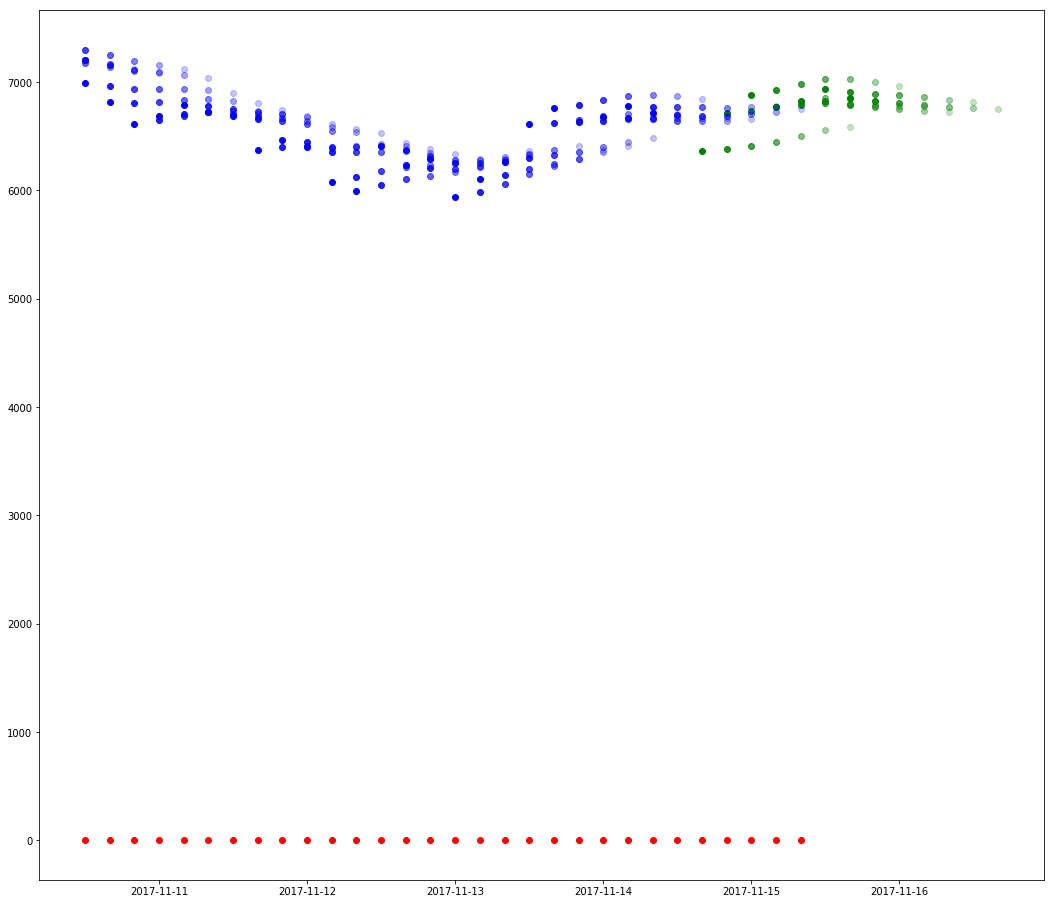

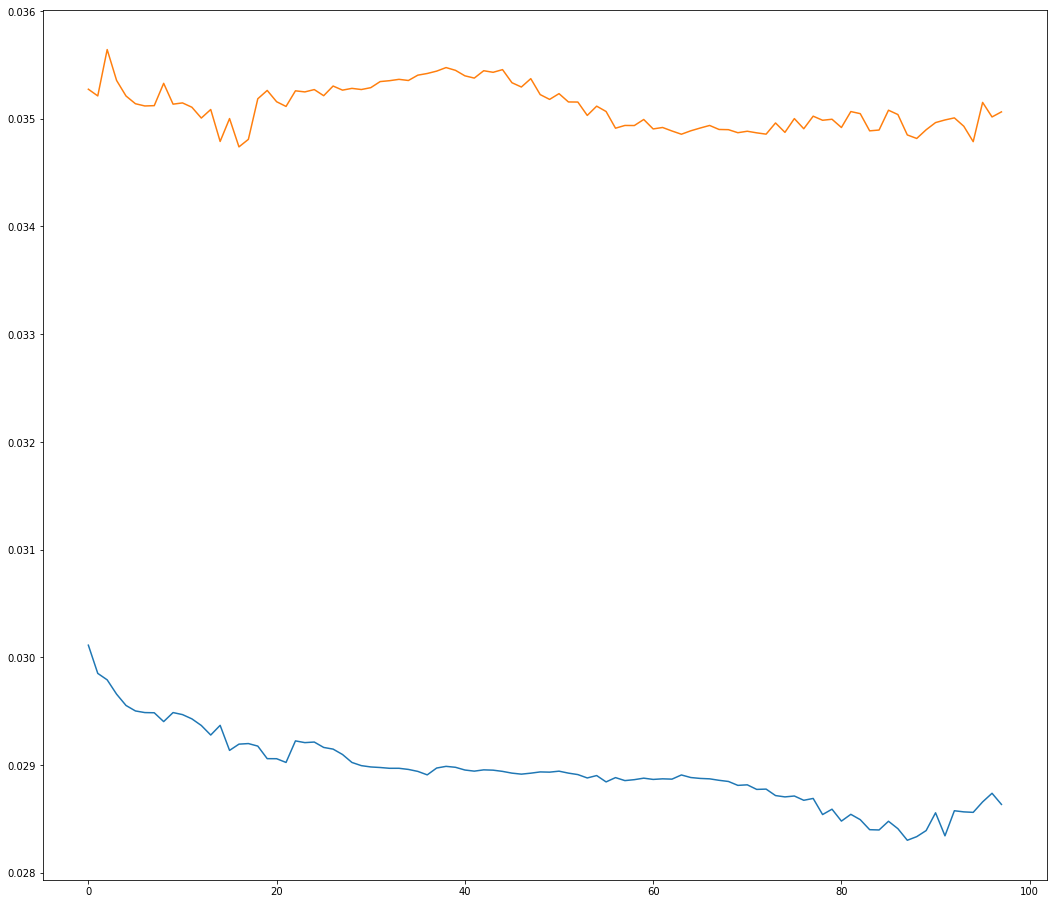

Epoch 1/1
 - 47s - loss: 0.0014
Train Score: 0.02838 RMSE
Test Score: 0.03515 RMSE
(9004, 11)
(9011, 11)


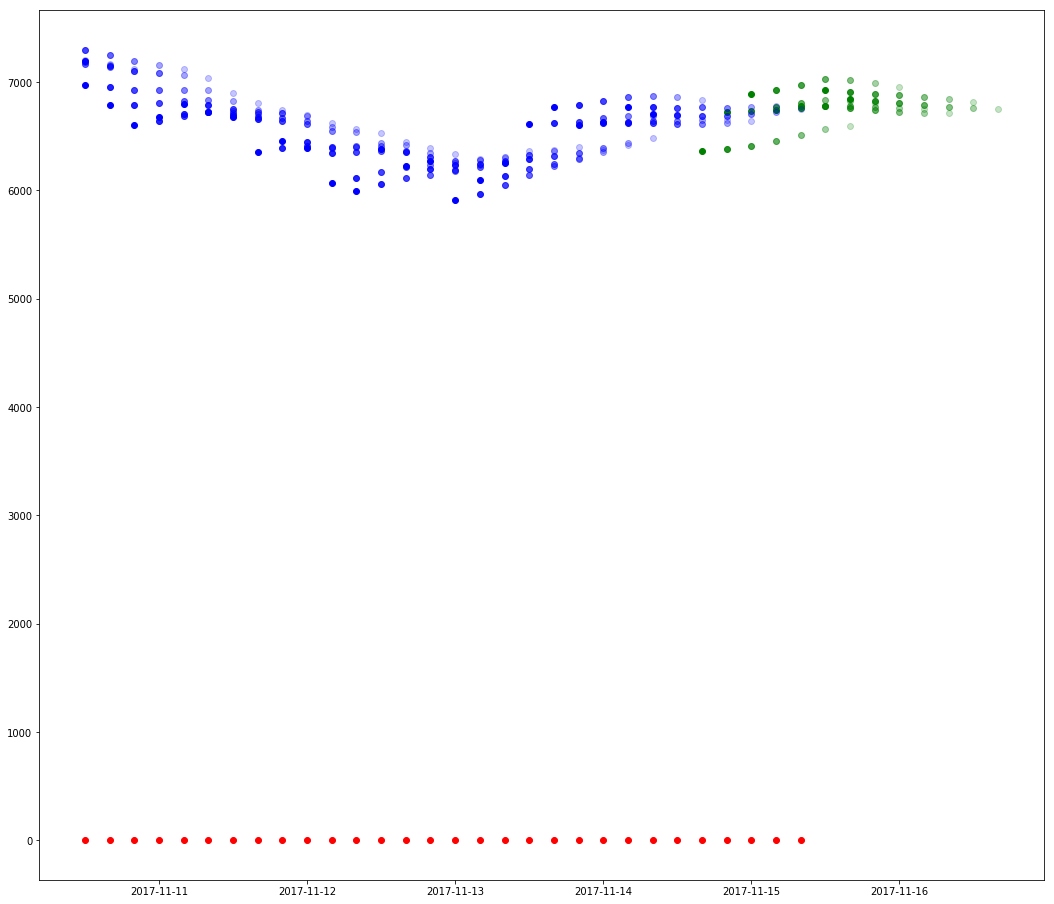

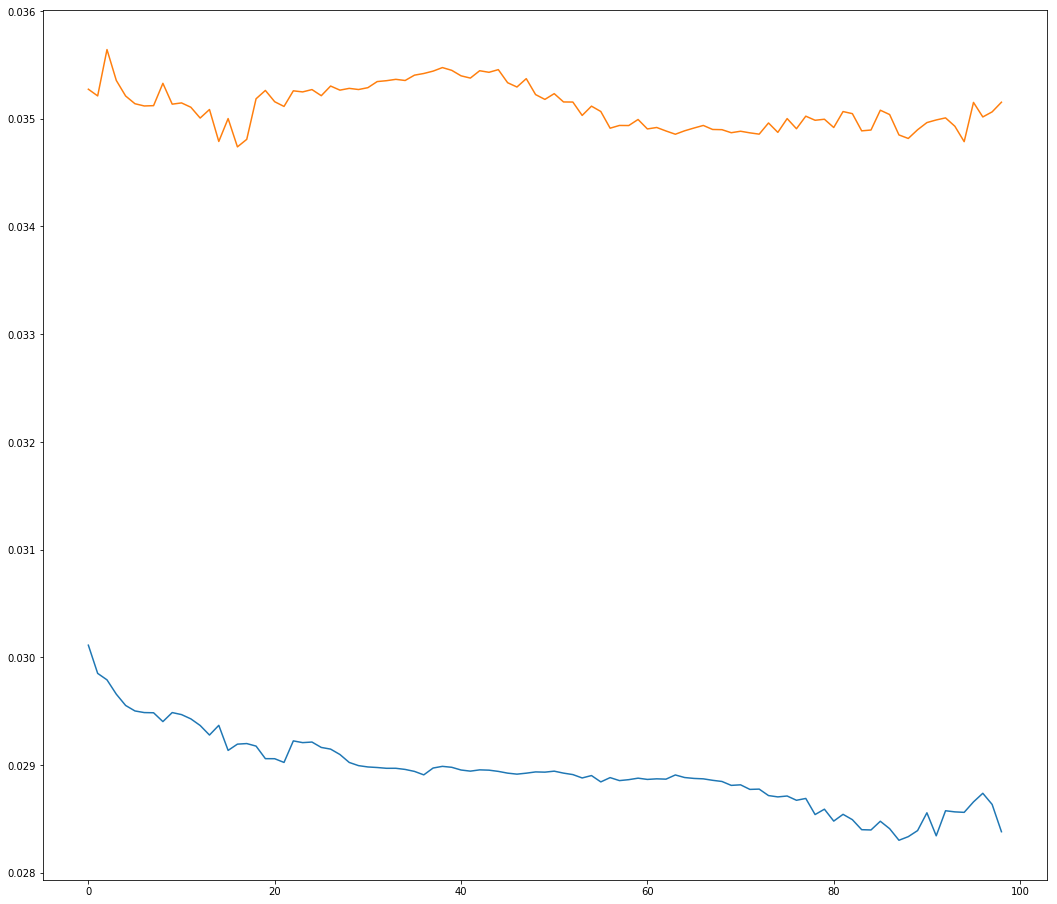

Epoch 1/1
 - 48s - loss: 0.0014
Train Score: 0.02869 RMSE
Test Score: 0.03498 RMSE
(9004, 11)
(9011, 11)


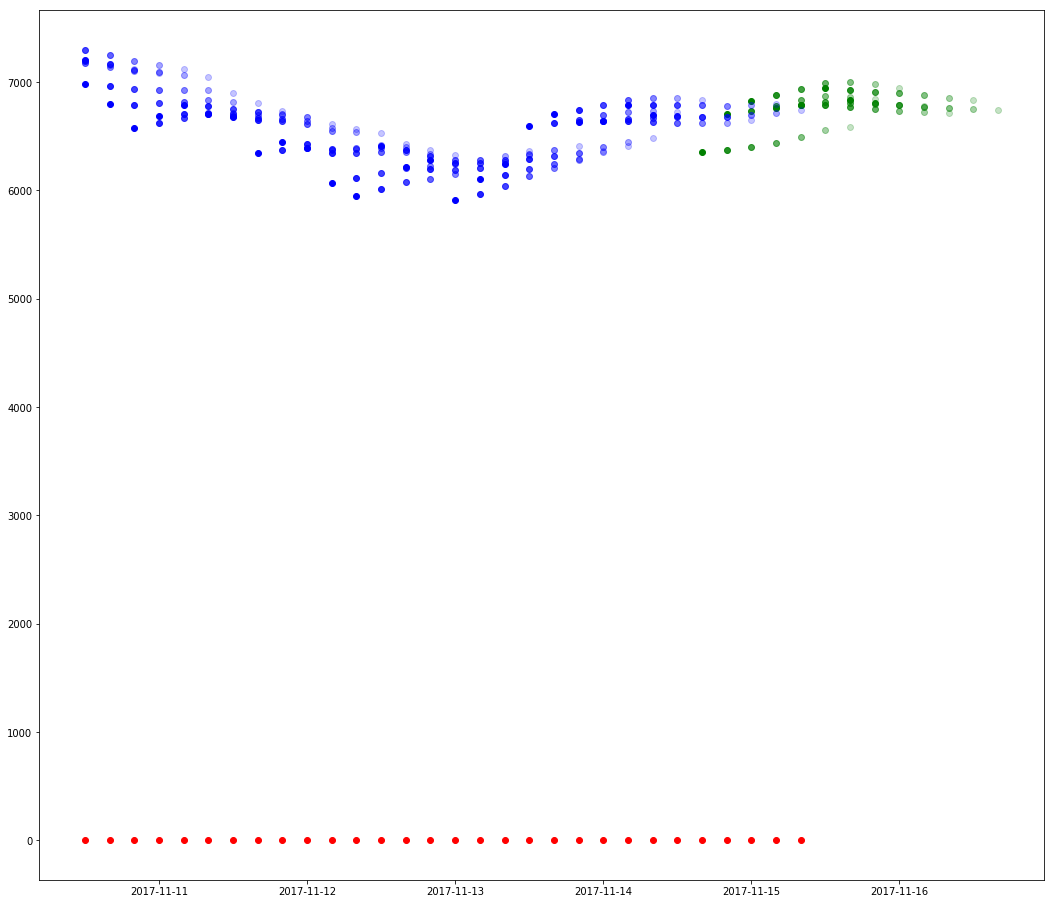

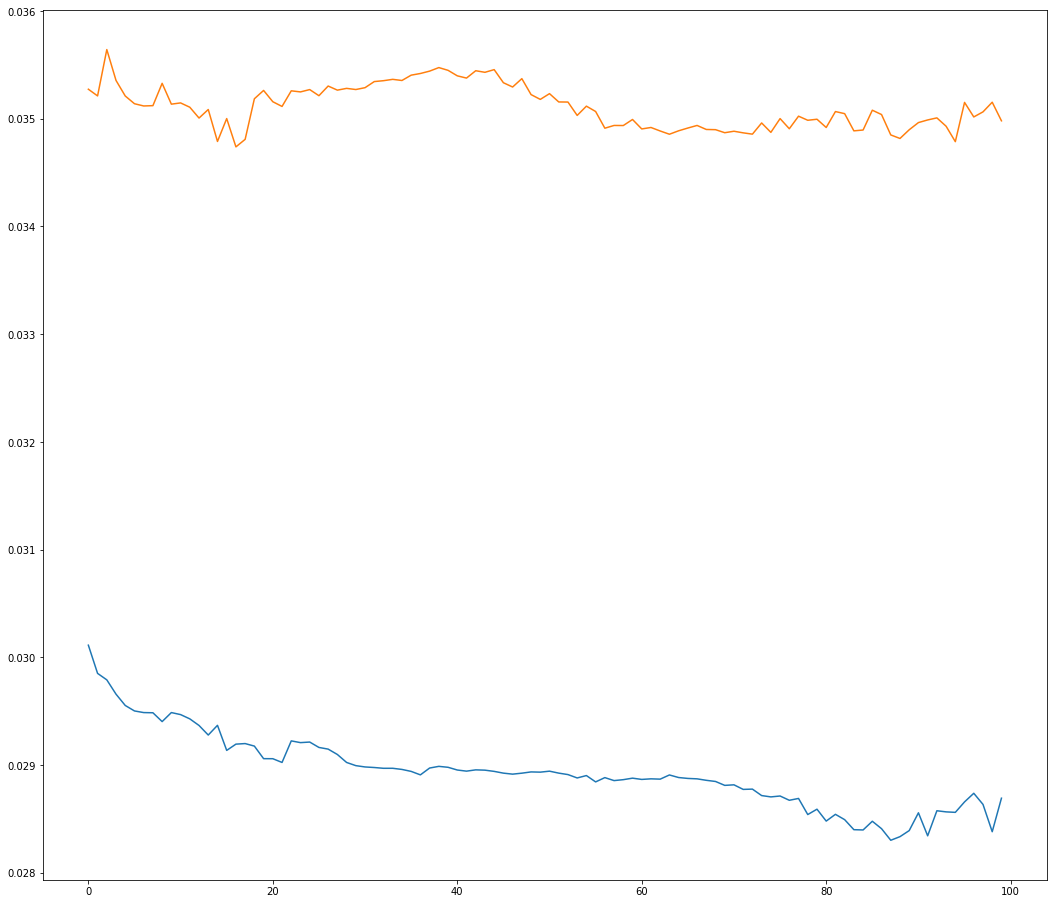

In [12]:
trainError = []
testError = []

for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
    model.save_weights("model_now.h5")
    
    model_test = model
    
    # make predictions
    trainPredict = model_test.predict(trainX, batch_size=batch_size)
    model_test.reset_states()
    testPredict = model_test.predict(testX, batch_size=batch_size)
    model_test.reset_states()
    nowPredict = model_test.predict(nowX, batch_size=batch_size)
    
    trainPredict_t = scaler_price.inverse_transform(trainPredict)
    trainY_t = scaler_price.inverse_transform(trainY)
    testPredict_t = scaler_price.inverse_transform(testPredict)
    testY_t = scaler_price.inverse_transform(testY)
    nowPredict_t = scaler_price.inverse_transform(nowPredict)
    
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY_t, trainPredict_t))
    trainError.append(trainScore)
    print('Train Score: %.5f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY_t[:-look_forward], testPredict_t[:-look_forward]))
    testError.append(testScore)
    print('Test Score: %.5f RMSE' % (testScore))
    
    # shift train predictions for plotting
    trainYPlot = np.empty_like(dataset)
    trainYPlot[:, :] = np.nan
    trainYPlot[look_back:len(trainY_t)+look_back,0] = trainY_t[:,0]
    # shift test predictions for plotting
    testYPlot = np.empty_like(dataset)
    testYPlot[:, :] = np.nan
    testYPlot[len(trainY_t)+(2*look_back)-1:len(dataset)-look_forward+1,0] = testY_t[:,0]
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    nowPredictPlot = np.empty_like(dataset)
    print(nowPredictPlot.shape)
    nowPredictPlot = np.vstack([nowPredictPlot, np.empty_like(dataset[:look_forward])])
    print(nowPredictPlot.shape)
    nowPredictPlot[:, :] = np.nan
    
    for i in range(look_forward):
        trainPredictPlot[look_back+i:len(trainPredict_t)+look_back+i,i] = trainPredict_t[:,i]  
        testPredictPlot[len(trainY_t)+(2*look_back)-1+i:len(dataset)-look_forward+i+1,i] = testPredict_t[:,i]
        nowPredictPlot[len(dataset)-look_forward+i+1:len(dataset)+i+1,i] = nowPredict_t[:,i]
        
    for i in range(look_forward): 
        trainYPlot[:,i] = np.exp(trainYPlot[:,i]+ewma['price'])
        testYPlot[:,i] = np.exp(testYPlot[:,i]+ewma['price'])
        trainPredictPlot[:,i] = np.exp(trainPredictPlot[:,i]+ewma['price'])
        testPredictPlot[:,i] = np.exp(testPredictPlot[:,i]+ewma['price'])
        nowPredictPlot[:-look_forward,i] = np.exp(nowPredictPlot[:-look_forward,i]+ewma['price'])        
    nowPredictPlot[-look_forward:,:] = np.exp(nowPredictPlot[-look_forward:,:]+ewma['price'][-1])
    
    trainYPlot2 = pd.DataFrame(trainYPlot, index=df.index)
    testYPlot2 = pd.DataFrame(testYPlot, index=df.index)
    trainPredictPlot2 = pd.DataFrame(trainPredictPlot, index=df.index)
    testPredictPlot2 = pd.DataFrame(testPredictPlot, index=df.index)
    
    rng = pd.date_range(testPredictPlot2.index[0], periods=len(testPredictPlot2.index)+look_forward+1, freq=frequency)
    nowPredictPlot2 = pd.DataFrame(nowPredictPlot, index=rng[1:])
    
    # plot baseline and predictions
    matplotlib.rcParams['figure.figsize'] = (18,16)
    plt.plot(df['price'].iloc[-30:], 'ro')    
    for i in range(look_forward):
        plt.plot(testPredictPlot2.iloc[-30:,i], 'bo', alpha=(1-0.9*i/look_forward))
        plt.plot(nowPredictPlot2.iloc[:,i], 'go', alpha=(1-0.9*i/look_forward))    
    plt.show()
    
    plt.plot(trainError)
    plt.plot(testError)
    plt.show()

(9004, 11)
(9004, 11)
(9004, 11)
(9004, 11)


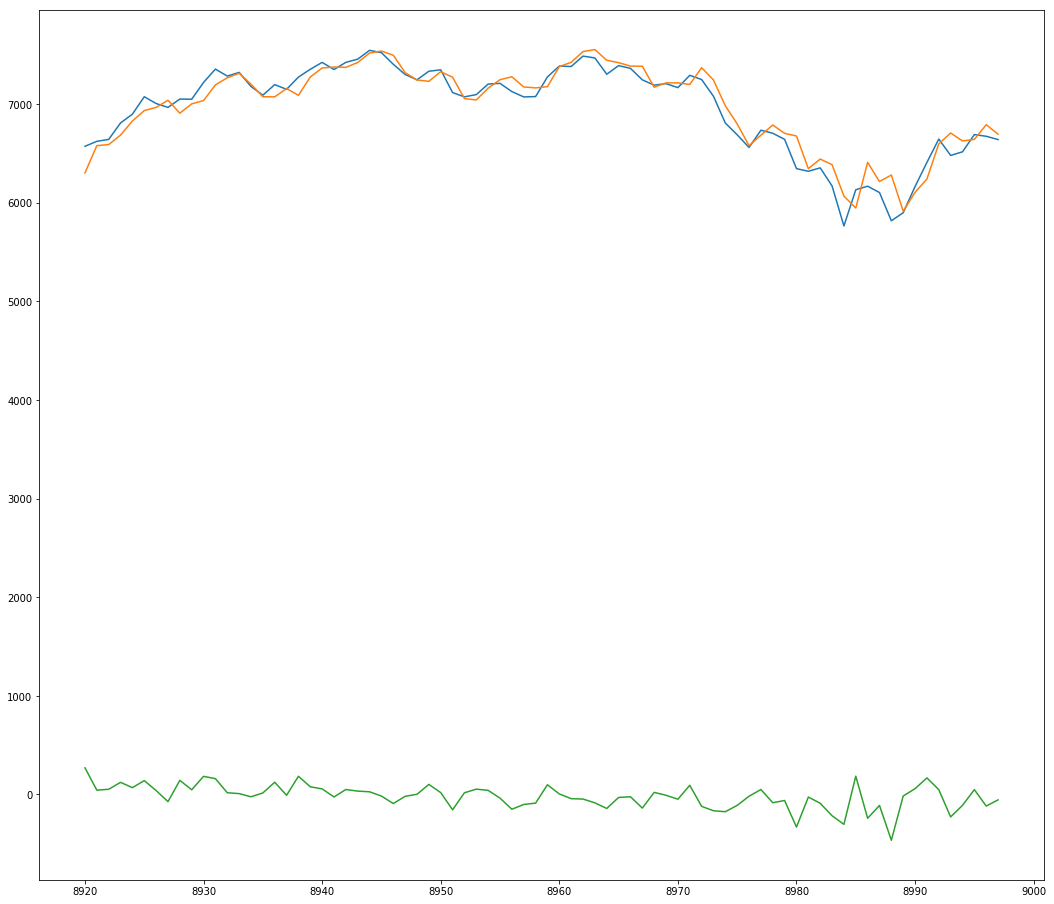

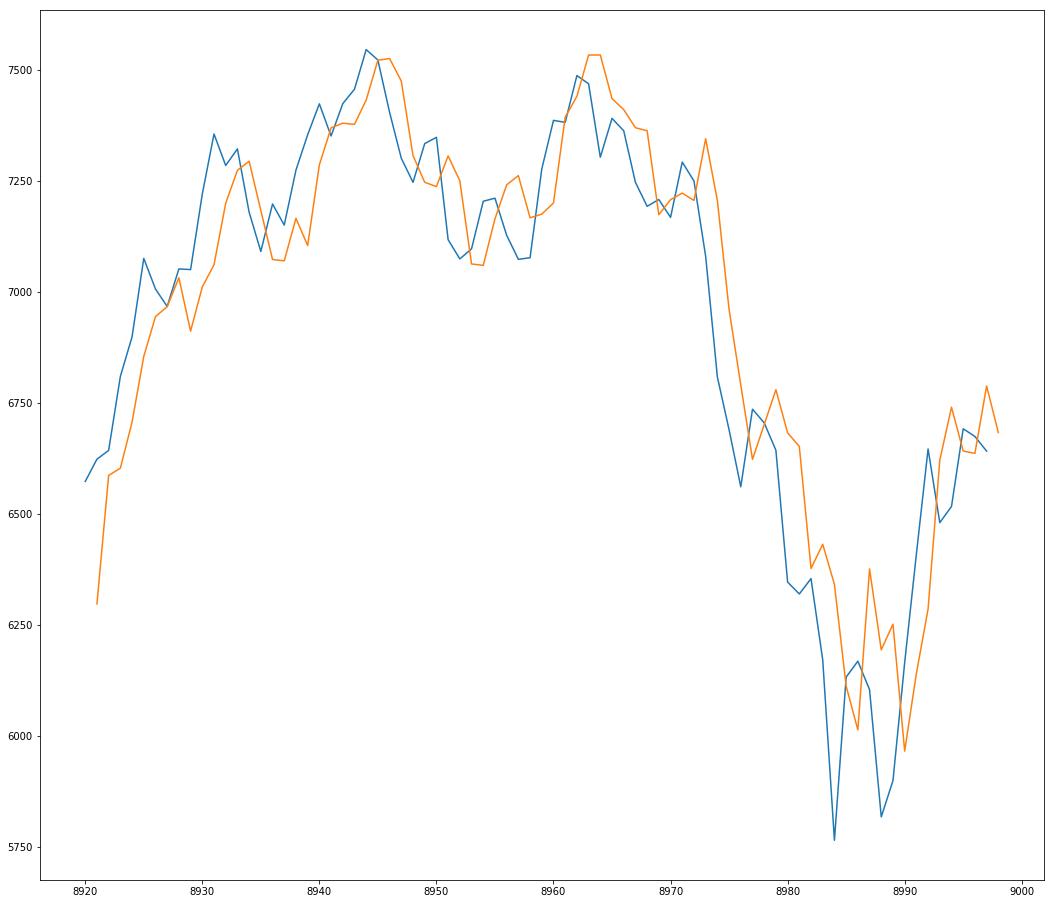

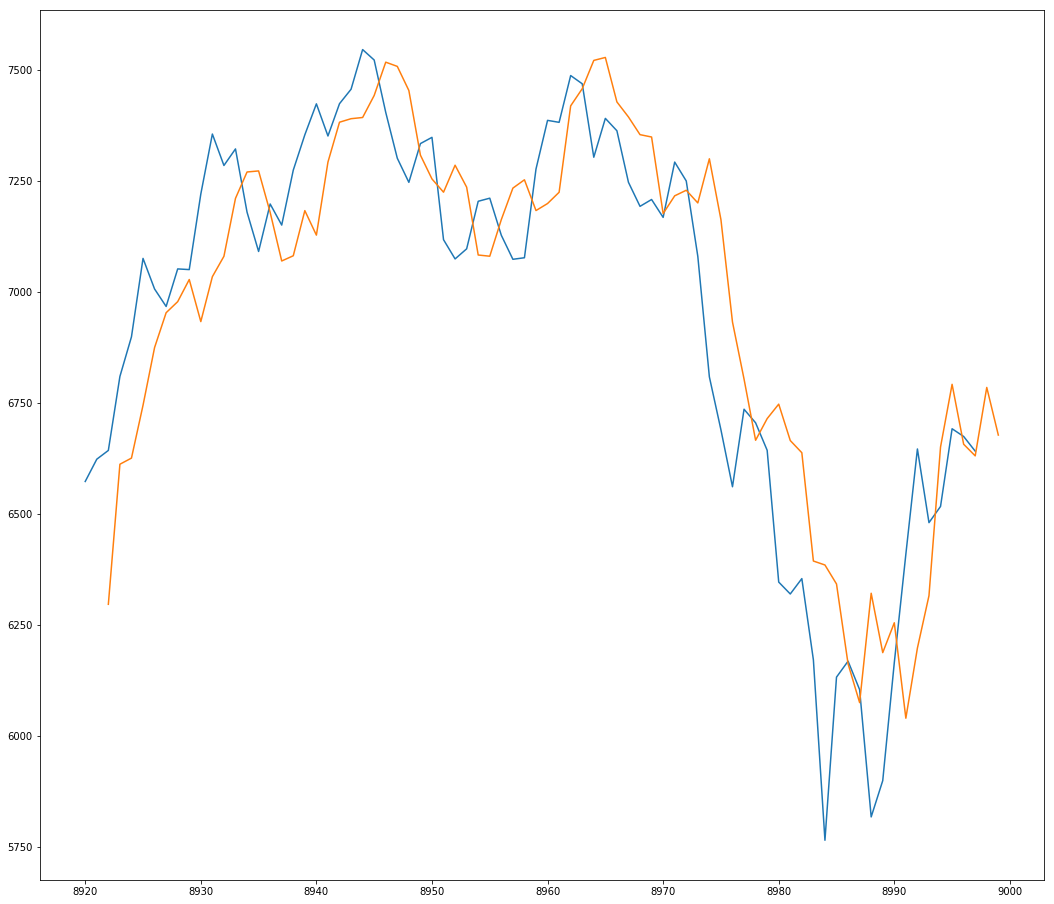

In [13]:
print(trainYPlot.shape)
print(trainPredictPlot.shape)
print(testYPlot.shape)
print(testPredictPlot.shape)


# for i in range(look_forward): 
#     trainYPlot[:,i] = np.exp(trainYPlot[:,i]+ewma['price'])
#     testYPlot[:,i] = np.exp(testYPlot[:,i]+ewma['price'])
#     trainPredictPlot[:,i] = np.exp(trainPredictPlot[:,i]+ewma['price'])
#     testPredictPlot[:,i] = np.exp(testPredictPlot[:,i]+ewma['price'])

# print(trainYPlot)
# print(trainPredictPlot)
# print(testYPlot)
# print(testPredictPlot)





matplotlib.rcParams['figure.figsize'] = (18,16)
# plt.plot(trainYPlot2['price'])
# plt.plot(testYPlot2['price'])
# plt.plot(trainPredictPlot2['price'])
# plt.plot(testPredictPlot2['price'])
# plt.plot(trainYPlot2['price'] - trainPredictPlot2['price'])
# plt.plot(testYPlot2['price'] - testPredictPlot2['price'])
# plt.show()


plt.plot(testYPlot[:,0])
plt.plot(testPredictPlot[:,0])
plt.plot(testYPlot[:,0] - testPredictPlot[:,0])
plt.show()

plt.plot(testYPlot[:,0])
plt.plot(testPredictPlot[:,1])
plt.plot(testYPlot[:,1] - testPredictPlot[:,1])
plt.show()

plt.plot(testYPlot[:,0])
plt.plot(testPredictPlot[:,2])
plt.plot(testYPlot[:,2] - testPredictPlot[:,2])
plt.show()

# trainYError = trainYPlot.replace([np.inf, -np.inf], np.nan).dropna(how="all")
# trainPredictError = trainPredictPlot.replace([np.inf, -np.inf], np.nan).dropna(how="all")
# testYError = testYPlot.replace([np.inf, -np.inf], np.nan).dropna(how="all")
# testPredictError = testPredictPlot.replace([np.inf, -np.inf], np.nan).dropna(how="all")

# calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainYError, trainPredictError))
# print('Train Score: %.5f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testYError, testPredictError))
# print('Test Score: %.5f RMSE' % (testScore))

# for i in range(look_forward):
#     print('Test Score %: %.5f RMSE' % (i, math.sqrt(mean_squared_error(testYError[:,i], testPredictError[:,i]))))